In [1]:
DAY = "20201020"

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/My\ Drive/Kaggle/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Bengali.AI_Handwritten_Grapheme_Classification
global-wheat-detection
IEEE
Ion_Switching_University_of_Liverpool
kaggle.json
lish-moa
m5-forecasting-accuracy
Melanoma_classification
osic-pulmonary-fibrosis-progression
PANDA
Plant_Pathology_2020
Pneumothorax_Segmentation
utils


In [3]:
%%time
#Set Path

_PATH="/content/drive/'My Drive'/Kaggle/lish-moa"

! ls -all $_PATH
! chmod -R 777 $_PATH/input/
! mkdir -p $_PATH/output/$DAY

total 16
drwx------ 3 root root 4096 Oct 15 18:32 input
drwx------ 2 root root 4096 Oct 15 18:32 models
drwx------ 3 root root 4096 Oct 15 18:32 output
drwx------ 2 root root 4096 Oct 15 18:32 scripts
CPU times: user 9.5 ms, sys: 14.8 ms, total: 24.3 ms
Wall time: 333 ms


In [4]:
#!pip install lightgbm==2.3.1
!pip install pandas==1.1.1
!pip install imbalanced-learn==0.7.0

  Using cached https://files.pythonhosted.org/packages/a1/c6/9ac4ae44c24c787a1738e5fb34dd987ada6533de5905a041aa6d5bea4553/pandas-1.1.1-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: pandas 1.1.3
    Uninstalling pandas-1.1.3:
      Successfully uninstalled pandas-1.1.3


In [5]:
#Install_LightGBM_with_GPU

! git clone --recursive https://github.com/Microsoft/LightGBM

%cd /content/LightGBM
! mkdir -p build

%cd build
! cmake -DUSE_GPU=1 /content/LightGBM
! make -j$(nproc)
! sudo apt-get -y install python-pip
! sudo -H pip install setuptools pandas numpy scipy scikit-learn -U

%cd /content/LightGBM/python-package
! sudo python setup.py install --precompile

%cd /content/

fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
/content/LightGBM/build
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM/build
[100%] Built target lightgbm
[100%] Built target _lightgbm
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.3).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (50.3.2)
  Using cached https://files.pythonhosted.org/packages/a2/21/e10d65222d19a2537e3eb0df306686a9eabd08b3c98dd120e43720bf802d/pandas-1.1.3-cp36-cp36m-manylinux1_x86_64.whl
Requirement already up-to-date: numpy in /usr/loc

Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py


In [6]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
Version = "v8" # pasude labeling(theshold=0.6)

In [7]:
DEBUG = True

# Library

In [8]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
from imblearn.over_sampling import SMOTE
import imblearn


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  3.0.0.99
numpy Version:  1.19.2
pandas Version:  1.1.3
imblearn Version:  0.7.0


# Utils

In [9]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [10]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=20
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [11]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [12]:
data_dir = "/content/drive/My Drive/Kaggle/lish-moa/input/"
output_dir = f"/content/drive/My Drive/Kaggle/lish-moa/output/{DAY}/"

In [13]:
train = pd.read_csv(os.path.join(data_dir, "train_features.csv"))
test = pd.read_csv(os.path.join(data_dir, "test_features.csv"))
train_targets_scored = pd.read_csv(os.path.join(data_dir, "train_targets_scored.csv"))
train_targets_nonscored = pd.read_csv(os.path.join(data_dir, "train_targets_nonscored.csv"))
sub = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

In [14]:
annot = pd.read_csv(os.path.join(data_dir, "moa-annot-data/20201016_moa_sig_list.csv"))
annot.head()

,sig_id,annot1,annot2,annot3
0,acetylcholine_receptor_agonist,acetylcholine_release_enhancer,NaN,NaN
1,acetylcholine_receptor_antagonist,atherogenesis_inhibitor,NaN,NaN
2,adenosine_receptor_antagonist,adenosine_deaminase_inhibitor,NaN,NaN
3,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN,NaN
4,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN,NaN


In [15]:
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'apoptosis_stimulant', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atr_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcr-abl_inhibitor', 'calcineurin_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'chk_inhibitor', 'coagulation_factor_inhibitor', 'dopamine_receptor_agonist', 'elastase_inhibitor', 'erbb2_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'glutamate_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'hiv_inhibitor', 'imidazoline_re

In [16]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,thromboxane_synthase_inhibitor,thyroid_hormone_inhibitor,thyroid_hormone_stimulant,thyrotropin_releasing_hormone_receptor_agonist,tie_inhibitor,tissue_transglutaminase_inhibitor,topical_anesthetic,topical_sunscreen_agent,trace_amine_associated_receptor_agonist,trace_amine_associated_receptor_antagonist,trail_modulator,transient_receptor_potential_channel_agonist,triacylglycerol_lipase_inhibitor,tricyclic_antidepressant,tryptophan_hydroxylase_inhibitor,tyrosinase_inhibitor,tyrosine_hydroxylase_inhibitor,tyrosine_phosphatase_inhibitor,ubiquitin-conjugating_enzyme_inhibitor,ubiquitin_ligase_inhibitor,urease_inhibitor,uric_acid_diuretic,uricase_inhibitor,uricosuric,urotensin_receptor_agonist,urotensin_receptor_antagonist,vasoconstrictor,vasodilator,vasopressin_receptor_agonist,vasopressin_receptor_antagonist,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [17]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [18]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
    
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [19]:
def pseudo_labeling(X_train, y_train, X_test, max_iter=3, threshold=0.6):
       
    X = X_train.copy()
    y = y_train.copy()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = []
        for fold_, (train_index, valid_index) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_index, :], X.loc[valid_index, :]
            y_tr, y_val = y[train_index], y[valid_index]
 
            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
            lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train,categorical_feature=categorical_cols)
        
            model = lgb.train(params,
                              lgb_train,
                              valid_sets=[lgb_train, lgb_eval],
                              verbose_eval=100,
                              num_boost_round=Num_boost_round,
                              early_stopping_rounds=Early_stopping_rounds)
        
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            y_preds.append(y_pred)
            
        p_label = pd.Series(sum(y_preds) / len(y_preds))
        p_label = p_label.where(p_label < threshold, 1)
        p_label = p_label.where(p_label >= threshold, 0)
 
        X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
        y = pd.concat([y_train, p_label], axis=0, ignore_index=True)
        
    return X, y

In [20]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [21]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [22]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [23]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [24]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,0.0640,-0.6316,-1.1990,0.7312,0.2752,0.8771,0.7721,-0.6836,-0.7374,-1.1620,0.1262,0.2718,0.3968,-1.1580,0.9891,-0.7642,0.6810,0.8971,0.1092,0.6508,-0.9330,0.1292,-0.5895,0.4987,-0.1180,0.3460,0.6819,-0.9072,1.3150,-0.2573,...,-0.9711

In [25]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,-0.7060,...,-0.0178,0.3768,0.4318,-0.1051,0.3933,-0.3189,0.4128,-0.2116,-1.0410,0.7798,0.1579,1.7250,1.4490,0.9117,-0.0754,-0.8396,0.7640,1.2080,1.1890,0.2114,0.6335,0.3265,-0.1056,0.5478,0.7477,1.2340,0.5035,-0.6591,0.3023,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.5943,0.4266,0.0000,1.0410,-0.1131,0.6593,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.2853,1.4690,-0.3626,0.2441,...,0.2815,-0.7493,-0.2701,0.1205,0.2396,0.3506,-0.9233,0.2490,-0.0824,0.4841,1.1940,-1.1650,-0.4853,1.1080,-0.5979,0.7438,0.2050,-0.2761,-0.1748,0.3385,-0.3500,-0.0309,-0.0409,-0.0735,0.2732,-1.2100,0.0089,0.0317,0.4721,-0.3880,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,0.3829,-1.8700,-0.0324,2.7670,-0.0438,-0.0147,0.1276,0.2968,-0.0704,-0.3767,2.5790,0.4069,-0.3868,-0.2782,1.8180,-2.9390,-0.1150,-0.8009,-1.4440,0.5412,-0.0804,-0.4444,2.9230,2.8270,-0.3437,1.6570,-1.9200,0.3442,1.7160,-0.9357,...,0.7649,0.2789,0.4465,0.9492,0.6385,1.5510,-0.1220,0.6688,0.4396,0.6947,0.9761,1.2430,1.4770,-0.0081,1.0040,1.4420,-0.3482,0.3297,1.2070,0.0524,0.5346,0.7643,0.4067,0.3817,0.4566,0.7736,0.5316,0.2790,0.9735,0.7412,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,0.6459,-0.0109,1.0120,-0.0864,-0.3817,-1.0600,0.9435,0.6296,0.3864,0.1420,0.9834,0.4189,0.7980,-0.2132,0.7651,-1.2410,0.0747,-1.5750,0.1535,-0.0840,0.6705,-0.7517,-0.2756,-1.0920,-0.8683,0.3021,-0.3164,-0.2074,0.4587,0.7203,...,-0.5262,-0.2982,-0.2491,-0.6373,-1.0040,-0.6726,-0.0321,-0.5398,-0.7518,0.0370,0.7213,-0.3466,0.2354,-0.4432,-0.1020,-0.9391,-1.1970,0.1365,-0.9264,0.5828,-0.7379,-0.4354,0.6077,-0.3771,-0.6525,-0.4169,-1.0640,-0.3331,-0.5761,-0.3085,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,-0.1187,1.1610,0.5838,-0.2996,-0.3995,1.0700,0.2969,-0.2785,0.9678,-0.1409,1.0850,-0.0656,-0.6502,0.3527,0.1998,0.0975,0.0563,-0.3578,-0.0657,0.5316,0.6573,-0.5355,1.2380,-0.4994,-0.8140,0.2567,-0.8155,1.1180,-0.2501,-0.3929,...,0.5214,0.0587,-0.5903,0.1332,-0.3517,-0.3276,-0.4955,0.1359,-0.3010,0.5725,-0.1126,-0.0874,1.2220,-0.0641,0.0246,-0.5659,-0.7402,1.1170,-0.0612,-1.3040,-0.4025,0.3760,-0.0873,0.8064,-0.0170,0.3092,0.2671,0.3311,-0.4572,0.4795,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,0.8263,0.5933,0.1388,-0.2246,-0.6127,-0.1687,1.5170,0.6243,-0.8399,-0.1881,-0.1583,0.0622,-0.1170,0.7722,0.0063,0.7347,-0.4820,0.0000,0.0938,-0.6062,0.6108,-0.4900,0.1075,0.3029,-0.1369,0.1946,0.1745,1.1030,0.3444,0.3097,...,0.0541,0.93

In [26]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,0.7785,0.7062,-0.7951,1.3770,0.2856,-0.8331,0.3879,1.3290,-0.4746,0.0857,-0.2745,-0.1093,0.2603,0.7386,-0.6665,-1.6520,-0.9262,0.0000,1.6310,-0.2933,0.2043,-2.2070,0.1383,-0.4966,0.6922,-0.4077,0.2303,-0.0456,-0.7447,-0.7060,...,-0.0178,0.3768,0.4318,-0.1051,0.3933,-0.3189,0.4128,-0.2116,-1.0410,0.7798,0.1579,1.7250,1.4490,0.9117,-0.0754,-0.8396,0.7640,1.2080,1.1890,0.2114,0.6335,0.3265,-0.1056,0.5478,0.7477,1.2340,0.5035,-0.6591,0.3023,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,-0.8204,-1.1320,1.0220,2.8340,1.5950,-0.4357,2.4850,0.0169,0.3497,0.2446,0.9030,1.0480,-0.0236,0.1287,-0.2542,-0.9599,-1.2090,0.8248,1.2270,0.9403,1.2220,0.7952,0.0654,0.1419,0.4826,-0.3608,-1.2470,0.8987,-1.6590,-0.0045,...,0.3862,0.1679,-0.1606,0.7098,-0.2421,0.7089,-0.1834,0.3628,0.3475,-0.4740,0.3952,0.1573,1.7930,0.3352,0.7680,0.6317,0.3930,0.1769,0.6985,0.9422,1.4140,0.9016,0.0636,0.8527,0.9618,0.8359,0.8941,0.3700,0.1103,0.2189,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,1.0850,0.8575,0.0731,0.3261,-0.8354,0.6105,0.9817,-0.8174,0.9794,-1.1220,0.0950,0.0312,0.0000,0.9100,0.5541,-0.0226,0.1048,0.0000,1.4590,0.1450,-0.4427,-1.3700,0.2603,-0.7548,-0.5989,-0.0819,1.2090,-0.5472,-0.7528,0.0771,...,-0.8444,-0.8382,-0.7703,-1.2120,0.5848,0.3334,-0.1429,0.6264,0.3141,-0.5985,-0.8049,-0.7746,-1.1530,-0.3770,-1.0410,-0.8414,-0.7473,-1.1940,-0.2328,0.6899,-0.6464,-1.5320,-1.1400,-0.4167,-0.5939,-0.3889,0.2930,0.5166,-1.1090,-0.5948,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,0.5095,-1.0030,0.7616,-0.0450,0.8976,0.5340,0.8479,-0.1927,0.2563,-0.2668,0.5639,0.8197,-0.1720,0.0382,0.0249,0.2084,0.0435,0.3855,0.7012,0.9375,1.6060,0.5083,0.0893,-1.2330,-0.3194,0.0857,0.4424,1.0410,-1.5520,0.6504,...,0.3872,0.6333,0.4925,0.2797,0.0981,0.2077,-0.2684,0.6154,0.3629,0.6579,0.5901,0.5448,0.7255,0.5442,0.5527,-0.3409,0.2253,0.8130,0.4811,0.7525,0.4871,0.4212,-0.0051,0.9169,1.3130,1.0220,0.0772,-0.0996,0.5776,-0.4568,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,0.2063,0.7966,-0.1971,0.1745,-0.5076,0.3780,0.2870,-0.6213,0.3087,0.7351,-0.0602,-0.5847,0.1123,0.5021,0.5723,0.2225,0.3108,0.0000,1.0100,0.1671,-0.2367,-0.2497,-0.2070,-0.5006,-0.4640,-0.6938,-0.2961,-0.9692,-0.6242,0.3668,...,-0.6199,0.0407,0.0643,-2.0430,-0.2272,-0.5506,0.2947,-0.0099,-0.8868,-0.7292,-1.2720,-0.0604,0.0783,0.2789,-0.7804,0.7360,-0.4960,-0.8932,-1.3190,-0.0178,-0.6259,-0.3449,-0.4012,0.1801,-0.2343,-0.7872,-0.4205,-0.1366,0.1743,-0.2844,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,1.1330,0.5398,0.2281,0.9634,-0.7143,-1.0190,-0.8636,-0.4087,-0.0901,-1.1240,1.6570,-0.0529,0.4482,0.7294,-0.0146,0.5344,0.3501,0.2287,-0.1670,-0.3733,0.5983,0.4366,-0.0904,0.4421,-1.3440,0.8377,0.6535,1.7610,-0.4300,-1.3170,...,-0.7796,-1.0940,-1.1310,-1.366

In [27]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,d_c-60,d_c-61,d_c-62,d_c-63,d_c-64,d_c-65,d_c-66,d_c-67,d_c-68,d_c-69,d_c-70,d_c-71,d_c-72,d_c-73,d_c-74,d_c-75,d_c-76,d_c-77,d_c-78,d_c-79,d_c-80,d_c-81,d_c-82,d_c-83,d_c-84,d_c-85,d_c-86,d_c-87,d_c-88,d_c-89,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,1.191125,2.070471,2.092092,3.582897,0.424269,0.449825,0.697897,3.631891,-1.911436,4.103842,-0.179425,2.652827,1.246513,1.432198,1.284125,0.156154,1.434359,3.367403,2.028305,-2.056187,4.594376,1.388173,-1.880616,0.960478,3.185228,0.610453,1.353252,-0.458706,-4.891223,3.210844,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.0481,-0.4486,1.2570,1.2550,0.3359,-0.5103,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.5354,1.1360,1.1310,-0.1430,...,1.661129,8.665523,7.589502,4.204493,2.042748,6.418707,3.540284,1.239525,0.228903,2.835840,2.140165,4.947658,2.269896,2.623952,5.306856,0.678865,5.860738,-1.170119,4.802489,3.076701,2.219101,3.768268,2.370427,9.761307,2.167845,2.368506,1.375440,4.198996,6.239704,7.411112,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,-1.3770,-0.7637,-1.4880,-0.1970,-0.5229,0.2942,-0.6387,-1.0830,0.2464,0.6330,0.2837,0.0104,-0.0121,-0.1858,-0.6253,0.5023,0.4164,-0.4699,0.3135,-0.2699,0.6885,0.2043,-0.1817,-0.8334,0.7470,0.3260,0.0979,0.3905,-1.2800,0.1171,...,-0.472728,-4.712236,3.744157,2.507647,-2.384758,2.506888,0.275112,-0.933829,2.083436,-1.136676,-1.319590,2.456148,0.725811,0.907258,-0.556076,1.241640,-1.037056,2.130187,1.227781,0.920764,-6.648948,-0.443375,-0.868301,5.900784,-0.193387,-2.098055,-0.205998,2.130879,-1.229569,2.780971,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.5943,0.4266,0.0000,1.0410,-0.1131,0.6593,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.2853,1.4690,-0.3626,0.2441,...,-0.847789,1.173894,-4.259777,-1.148375,0.490637,0.768196,1.391821,-2.667715,0.796036,-0.276043,1.570731,4.308902,-2.499456,-0.724758,5.862408,-1.886111,2.576371,0.818691,-0.908815,-0.491145,1.283168,-0.763688,-0.131261,-0.304987,-0.157757,0.927045,-3.050923,0.036750,0.153218,2.267525,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,1.2090,-3.8910,-1.5450,-2.2870,-2.2040,-0.8888,-1.1730,0.0444,-3.9430,0.1673,-0.9502,-1.1750,0.1686,3.8480,-2.9760,-0.0389,1.6330,-0.0655,1.3810,-2.4340,-1.8040,0.3945,-1.2080,-0.1963,-2.0170,0.6004,-2.5860,-1.4550,-0.4141,3.7900,...,-4.514116,-5.187631,-14.456990,-27.321308,-10.309400,-13.969173,-18.880429,-2.537118,-12.084357,-5.474015,-12.868222,-6.456126,-6.968445,-3.990435,-7.010540,-7.391141,-11.160332,-10.047879,-7.705699,-6.917651,-14.692890,-4.898525,-16.758633,-12.975287,-9.512748,-12.466870,-7.516368,-18.897523,-8.999468,-9.183429,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [28]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,d_c-60,d_c-61,d_c-62,d_c-63,d_c-64,d_c-65,d_c-66,d_c-67,d_c-68,d_c-69,d_c-70,d_c-71,d_c-72,d_c-73,d_c-74,d_c-75,d_c-76,d_c-77,d_c-78,d_c-79,d_c-80,d_c-81,d_c-82,d_c-83,d_c-84,d_c-85,d_c-86,d_c-87,d_c-88,d_c-89,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.63420,0.1778,-0.3694,-0.5688,-1.1360,-1.18800,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.09160,-0.3010,-0.1537,0.21980,...,1.191125,2.070471,2.092092,3.582897,0.424269,0.449825,0.697897,3.631891,-1.911436,4.103842,-0.179425,2.652827,1.246513,1.432198,1.284125,0.156154,1.434359,3.367403,2.028305,-2.056187,4.594376,1.388173,-1.880616,0.960478,3.185228,0.610453,1.353252,-0.458706,-4.891223,3.210844,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.04810,-0.4486,1.2570,1.2550,0.3359,-0.51030,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.53540,1.1360,1.1310,-0.14300,...,1.661129,8.665523,7.589502,4.204493,2.042748,6.418707,3.540284,1.239525,0.228903,2.835840,2.140165,4.947658,2.269896,2.623952,5.306856,0.678865,5.860738,-1.170119,4.802489,3.076701,2.219101,3.768268,2.370427,9.761307,2.167845,2.368506,1.375440,4.198996,6.239704,7.411112,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,-1.3770,-0.7637,-1.4880,-0.1970,-0.5229,0.2942,-0.6387,-1.0830,0.2464,0.6330,0.2837,0.01040,-0.0121,-0.1858,-0.6253,0.5023,0.41640,-0.4699,0.3135,-0.2699,0.6885,0.2043,-0.1817,-0.8334,0.7470,0.3260,0.09790,0.3905,-1.2800,0.11710,...,-0.472728,-4.712236,3.744157,2.507647,-2.384758,2.506888,0.275112,-0.933829,2.083436,-1.136676,-1.319590,2.456148,0.725811,0.907258,-0.556076,1.241640,-1.037056,2.130187,1.227781,0.920764,-6.648948,-0.443375,-0.868301,5.900784,-0.193387,-2.098055,-0.205998,2.130879,-1.229569,2.780971,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.59430,0.4266,0.0000,1.0410,-0.1131,0.65930,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.28530,1.4690,-0.3626,0.24410,...,-0.847789,1.173894,-4.259777,-1.148375,0.490637,0.768196,1.391821,-2.667715,0.796036,-0.276043,1.570731,4.308902,-2.499456,-0.724758,5.862408,-1.886111,2.576371,0.818691,-0.908815,-0.491145,1.283168,-0.763688,-0.131261,-0.304987,-0.157757,0.927045,-3.050923,0.036750,0.153218,2.267525,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,1.2090,-3.8910,-1.5450,-2.2870,-2.2040,-0.8888,-1.1730,0.0444,-3.9430,0.1673,-0.9502,-1.17500,0.1686,1.7871,-2.9760,-0.0389,1.63300,-0.0655,1.3810,-2.4340,-1.8040,0.3945,-1.2080,-0.1963,-2.0170,0.6004,-2.58600,-1.4550,-0.4141,3.79000,...,-4.514116,-5.187631,-14.456990,-27.321308,-10.309400,-13.969173,-18.880429,-2.537118,-12.084357,-5.474015,-12.868222,-6.456126,-6.968445,-3.990435,-7.010540,-7.391141,-11.160332,-10.047879,-7.705699,-6.917651,-14.692890,-4.898525,-16.758633,-12.975287,-9.512748,-12.466870,-7.516368,-18.897523,-8.999468,-9.183429,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [29]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [30]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,d_c-60,d_c-61,d_c-62,d_c-63,d_c-64,d_c-65,d_c-66,d_c-67,d_c-68,d_c-69,d_c-70,d_c-71,d_c-72,d_c-73,d_c-74,d_c-75,d_c-76,d_c-77,d_c-78,d_c-79,d_c-80,d_c-81,d_c-82,d_c-83,d_c-84,d_c-85,d_c-86,d_c-87,d_c-88,d_c-89,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.63420,0.1778,-0.3694,-0.5688,-1.1360,-1.18800,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.09160,-0.3010,-0.1537,0.21980,...,1.191125,2.070471,2.092092,3.582897,0.424269,0.449825,0.697897,3.631891,-1.911436,4.103842,-0.179425,2.652827,1.246513,1.432198,1.284125,0.156154,1.434359,3.367403,2.028305,-2.056187,4.594376,1.388173,-1.880616,0.960478,3.185228,0.610453,1.353252,-0.458706,-4.891223,3.210844,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.04810,-0.4486,1.2570,1.2550,0.3359,-0.51030,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.53540,1.1360,1.1310,-0.14300,...,1.661129,8.665523,7.589502,4.204493,2.042748,6.418707,3.540284,1.239525,0.228903,2.835840,2.140165,4.947658,2.269896,2.623952,5.306856,0.678865,5.860738,-1.170119,4.802489,3.076701,2.219101,3.768268,2.370427,9.761307,2.167845,2.368506,1.375440,4.198996,6.239704,7.411112,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,-1.3770,-0.7637,-1.4880,-0.1970,-0.5229,0.2942,-0.6387,-1.0830,0.2464,0.6330,0.2837,0.01040,-0.0121,-0.1858,-0.6253,0.5023,0.41640,-0.4699,0.3135,-0.2699,0.6885,0.2043,-0.1817,-0.8334,0.7470,0.3260,0.09790,0.3905,-1.2800,0.11710,...,-0.472728,-4.712236,3.744157,2.507647,-2.384758,2.506888,0.275112,-0.933829,2.083436,-1.136676,-1.319590,2.456148,0.725811,0.907258,-0.556076,1.241640,-1.037056,2.130187,1.227781,0.920764,-6.648948,-0.443375,-0.868301,5.900784,-0.193387,-2.098055,-0.205998,2.130879,-1.229569,2.780971,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.59430,0.4266,0.0000,1.0410,-0.1131,0.65930,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.28530,1.4690,-0.3626,0.24410,...,-0.847789,1.173894,-4.259777,-1.148375,0.490637,0.768196,1.391821,-2.667715,0.796036,-0.276043,1.570731,4.308902,-2.499456,-0.724758,5.862408,-1.886111,2.576371,0.818691,-0.908815,-0.491145,1.283168,-0.763688,-0.131261,-0.304987,-0.157757,0.927045,-3.050923,0.036750,0.153218,2.267525,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,1.2090,-3.8910,-1.5450,-2.2870,-2.2040,-0.8888,-1.1730,0.0444,-3.9430,0.1673,-0.9502,-1.17500,0.1686,1.7871,-2.9760,-0.0389,1.63300,-0.0655,1.3810,-2.4340,-1.8040,0.3945,-1.2080,-0.1963,-2.0170,0.6004,-2.58600,-1.4550,-0.4141,3.79000,...,-4.514116,-5.187631,-14.456990,-27.321308,-10.309400,-13.969173,-18.880429,-2.537118,-12.084357,-5.474015,-12.868222,-6.456126,-6.968445,-3.990435,-7.010540,-7.391141,-11.160332,-10.047879,-7.705699,-6.917651,-14.692890,-4.898525,-16.758633,-12.975287,-9.512748,-12.466870,-7.516368,-18.897523,-8.999468,-9.183429,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [31]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,d_c-61,d_c-62,d_c-63,d_c-64,d_c-65,d_c-66,d_c-67,d_c-68,d_c-69,d_c-70,d_c-71,d_c-72,d_c-73,d_c-74,d_c-75,d_c-76,d_c-77,d_c-78,d_c-79,d_c-80,d_c-81,d_c-82,d_c-83,d_c-84,d_c-85,d_c-86,d_c-87,d_c-88,d_c-89,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.63420,0.1778,-0.3694,-0.5688,-1.1360,-1.18800,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.09160,-0.3010,-0.1537,0.21980,...,2.070471,2.092092,3.582897,0.424269,0.449825,0.697897,3.631891,-1.911436,4.103842,-0.179425,2.652827,1.246513,1.432198,1.284125,0.156154,1.434359,3.367403,2.028305,-2.056187,4.594376,1.388173,-1.880616,0.960478,3.185228,0.610453,1.353252,-0.458706,-4.891223,3.210844,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.04810,-0.4486,1.2570,1.2550,0.3359,-0.51030,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.53540,1.1360,1.1310,-0.14300,...,8.665523,7.589502,4.204493,2.042748,6.418707,3.540284,1.239525,0.228903,2.835840,2.140165,4.947658,2.269896,2.623952,5.306856,0.678865,5.860738,-1.170119,4.802489,3.076701,2.219101,3.768268,2.370427,9.761307,2.167845,2.368506,1.375440,4.198996,6.239704,7.411112,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,-1.3770,-0.7637,-1.4880,-0.1970,-0.5229,0.2942,-0.6387,-1.0830,0.2464,0.6330,0.2837,0.01040,-0.0121,-0.1858,-0.6253,0.5023,0.41640,-0.4699,0.3135,-0.2699,0.6885,0.2043,-0.1817,-0.8334,0.7470,0.3260,0.09790,0.3905,-1.2800,0.11710,...,-4.712236,3.744157,2.507647,-2.384758,2.506888,0.275112,-0.933829,2.083436,-1.136676,-1.319590,2.456148,0.725811,0.907258,-0.556076,1.241640,-1.037056,2.130187,1.227781,0.920764,-6.648948,-0.443375,-0.868301,5.900784,-0.193387,-2.098055,-0.205998,2.130879,-1.229569,2.780971,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,0.3856,-0.1670,-0.5400,0.2721,-0.2479,0.0761,-0.4054,2.9760,-0.7679,0.6995,0.0752,0.59430,0.4266,0.0000,1.0410,-0.1131,0.65930,-0.6890,0.5115,-0.2512,-0.8775,-1.3810,0.1419,-0.0363,0.2559,2.5290,0.28530,1.4690,-0.3626,0.24410,...,1.173894,-4.259777,-1.148375,0.490637,0.768196,1.391821,-2.667715,0.796036,-0.276043,1.570731,4.308902,-2.499456,-0.724758,5.862408,-1.886111,2.576371,0.818691,-0.908815,-0.491145,1.283168,-0.763688,-0.131261,-0.304987,-0.157757,0.927045,-3.050923,0.036750,0.153218,2.267525,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,1.2090,-3.8910,-1.5450,-2.2870,-2.2040,-0.8888,-1.1730,0.0444,-3.9430,0.1673,-0.9502,-1.17500,0.1686,1.7871,-2.9760,-0.0389,1.63300,-0.0655,1.3810,-2.4340,-1.8040,0.3945,-1.2080,-0.1963,-2.0170,0.6004,-2.58600,-1.4550,-0.4141,3.79000,...,-5.187631,-14.456990,-27.321308,-10.309400,-13.969173,-18.880429,-2.537118,-12.084357,-5.474015,-12.868222,-6.456126,-6.968445,-3.990435,-7.010540,-7.391141,-11.160332,-10.047879,-7.705699,-6.917651,-14.692890,-4.898525,-16.758633,-12.975287,-9.512748,-12.466870,-7.516368,-18.897523,-8.999468,-9.183429,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [32]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [33]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 415 columns


# Modeling

In [34]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'device_type': "gpu",
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, #randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [35]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0419766	valid_1's binary_logloss: 0.0658934
[200]	training's binary_logloss: 0.00525903	valid_1's binary_logloss: 0.0194673
[300]	training's binary_logloss: 0.00171368	valid_1's binary_logloss: 0.0111005
[400]	training's binary_logloss: 0.00101414	valid_1's binary_logloss: 0.00861056
[500]	training's binary_logloss: 0.000868233	valid_1's binary_logloss: 0.00785738
[600]	training's binary_logloss: 0.000868223	valid_1's binary_logloss: 0.00785712
[700]	training's binary_logloss: 0.00086822	valid_1's binary_logloss: 0.00785706
[800]	training's binary_logloss: 0.00086822	valid_1's binary_logloss: 0.00785704
[900]	training's binary_logloss: 0.00086822	valid_1's binary_logloss: 0.00785704
[1000]	training's binary_logloss: 0.00086822	valid_1's binary_logloss: 0.00785704
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00086822	valid_1's binary_logloss: 0.00785704


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.000865186	valid_1's binary_logloss: 0.0129756
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000865728	valid_1's binary_logloss: 0.0129752
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128962	valid_1's binary_logloss: 0.0254362
[200]	training's binary_logloss: 0.00143522	valid_1's binary_logloss: 0.00876954
[300]	training's binary_logloss: 0.000424744	valid_1's binary_logloss: 0.00621675
[400]	training's binary_logloss: 0.000241959	valid_1's binary_logloss: 0.00548705
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000206007	valid_1's binary_logloss: 0.00535242
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128444	valid_1's binary_logloss: 0.0214666
[200]	training's binary_logloss: 0.00143915	valid_1's binary_logloss: 0.00652711
[300]	training's binary_logloss: 0.000430822	valid_1's binary_logloss: 0.0047407

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0127144	valid_1's binary_logloss: 0.0212812
[200]	training's binary_logloss: 0.00141708	valid_1's binary_logloss: 0.00605294
[300]	training's binary_logloss: 0.000424917	valid_1's binary_logloss: 0.00374758
[400]	training's binary_logloss: 0.000241579	valid_1's binary_logloss: 0.00312636
[500]	training's binary_logloss: 0.000202175	valid_1's binary_logloss: 0.00299879
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000202631	valid_1's binary_logloss: 0.0029973
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0126752	valid_1's binary_logloss: 0.0213994
[200]	training's binary_logloss: 0.00140347	valid_1's binary_logloss: 0.00723315
[300]	training's binary_logloss: 0.000424283	valid_1's binary_logloss: 0.00607227


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000342153	valid_1's binary_logloss: 0.00600484
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128171	valid_1's binary_logloss: 0.0171672
[200]	training's binary_logloss: 0.00141803	valid_1's binary_logloss: 0.00324587
[300]	training's binary_logloss: 0.000423694	valid_1's binary_logloss: 0.00182083
[400]	training's binary_logloss: 0.00024121	valid_1's binary_logloss: 0.00153718
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000200543	valid_1's binary_logloss: 0.00148424


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0125643	valid_1's binary_logloss: 0.0204712
[200]	training's binary_logloss: 0.00138366	valid_1's binary_logloss: 0.00466982
[300]	training's binary_logloss: 0.000414607	valid_1's binary_logloss: 0.00242358
[400]	training's binary_logloss: 0.00023383	valid_1's binary_logloss: 0.00171777
[500]	training's binary_logloss: 0.00019499	valid_1's binary_logloss: 0.00153227
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000193612	valid_1's binary_logloss: 0.00152496


5-alpha_reductase_inhibitor logloss: 0.001504599431366486
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0464405	valid_1's binary_logloss: 0.0823747
[200]	training's binary_logloss: 0.00618714	valid_1's binary_logloss: 0.0251408
[300]	training's binary_logloss: 0.00206618	valid_1's binary_logloss: 0.0144567
[400]	training's binary_logloss: 0.00123517	valid_1's binary_logloss: 0.0106095
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00105423	valid_1's binary_logloss: 0.00969325
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0441755	valid_1's binary_logloss: 0.0982568
[200]	training's binary_logloss: 0.00591581	valid_1's binary_logloss: 0.0443937
[300]	training's binary_logloss: 0.0019614	valid_1's binary_logloss: 0.0304289
[400]	training's binary_logloss: 0.00118394	valid_1's binary_logloss: 0.0243255


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00101862	valid_1's binary_logloss: 0.0226856
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0148927	valid_1's binary_logloss: 0.0273011
[200]	training's binary_logloss: 0.00179832	valid_1's binary_logloss: 0.00993677
[300]	training's binary_logloss: 0.000532377	valid_1's binary_logloss: 0.00789911
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000392099	valid_1's binary_logloss: 0.00767995
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147711	valid_1's binary_logloss: 0.0249293
[200]	training's binary_logloss: 0.00176256	valid_1's binary_logloss: 0.00792
[300]	training's binary_logloss: 0.000531076	valid_1's binary_logloss: 0.0064186


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000548806	valid_1's binary_logloss: 0.00641204
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0142978	valid_1's binary_logloss: 0.0237787
[200]	training's binary_logloss: 0.00168824	valid_1's binary_logloss: 0.00639278
[300]	training's binary_logloss: 0.000505001	valid_1's binary_logloss: 0.00398713
[400]	training's binary_logloss: 0.000287441	valid_1's binary_logloss: 0.00333801
[500]	training's binary_logloss: 0.000232048	valid_1's binary_logloss: 0.00315506
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000232199	valid_1's binary_logloss: 0.00315352
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147474	valid_1's binary_logloss: 0.0232771
[200]	training's binary_logloss: 0.00173034	valid_1's binary_logloss: 0.00648731
[300]	training's binary_logloss: 0.00051593	valid_1's binary_logloss: 0.003804

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0142978	valid_1's binary_logloss: 0.0237896
[200]	training's binary_logloss: 0.00168824	valid_1's binary_logloss: 0.00639125
[300]	training's binary_logloss: 0.000505001	valid_1's binary_logloss: 0.00398537
[400]	training's binary_logloss: 0.000287441	valid_1's binary_logloss: 0.00334883
[500]	training's binary_logloss: 0.000232048	valid_1's binary_logloss: 0.00316568
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000232199	valid_1's binary_logloss: 0.00316414


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147354	valid_1's binary_logloss: 0.0233415
[200]	training's binary_logloss: 0.00173519	valid_1's binary_logloss: 0.00633407
[300]	training's binary_logloss: 0.000515925	valid_1's binary_logloss: 0.00358367
[400]	training's binary_logloss: 0.000292828	valid_1's binary_logloss: 0.00292961
[500]	training's binary_logloss: 0.000226185	valid_1's binary_logloss: 0.00269626
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000226815	valid_1's binary_logloss: 0.00269545


11-beta-hsd1_inhibitor logloss: 0.0029297927569861856
acat_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0620821	valid_1's binary_logloss: 0.134312
[200]	training's binary_logloss: 0.00990543	valid_1's binary_logloss: 0.0510215
[300]	training's binary_logloss: 0.00322657	valid_1's binary_logloss: 0.0331347
[400]	training's binary_logloss: 0.00174031	valid_1's binary_logloss: 0.0262521
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00140371	valid_1's binary_logloss: 0.0242828
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0631719	valid_1's binary_logloss: 0.123571
[200]	training's binary_logloss: 0.010031	valid_1's binary_logloss: 0.041074
[300]	training's binary_logloss: 0.00323044	valid_1's binary_logloss: 0.0230214
[400]	training's binary_logloss: 0.00174737	valid_1's binary_logloss: 0.0164281
[500]	training's binary_logloss: 0.00137779	valid_1's binary_logloss: 0.0141684
[600]	training's binary_logloss: 0.00137775	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0187955	valid_1's binary_logloss: 0.0391447
[200]	training's binary_logloss: 0.00263522	valid_1's binary_logloss: 0.0139837
[300]	training's binary_logloss: 0.00077506	valid_1's binary_logloss: 0.00952755
[400]	training's binary_logloss: 0.000408092	valid_1's binary_logloss: 0.0083536
[500]	training's binary_logloss: 0.000301599	valid_1's binary_logloss: 0.00807145
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000302242	valid_1's binary_logloss: 0.00806916
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0179649	valid_1's binary_logloss: 0.0390244
[200]	training's binary_logloss: 0.00244578	valid_1's binary_logloss: 0.0152707
[300]	training's binary_logloss: 0.000733347	valid_1's binary_logloss: 0.0113418
[400]	training's binary_logloss: 0.000385296	valid_1's binary_logloss: 0.0102329
[500]	training's binary_logloss: 0.00

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0180739	valid_1's binary_logloss: 0.0365896
[200]	training's binary_logloss: 0.00246078	valid_1's binary_logloss: 0.0097395
[300]	training's binary_logloss: 0.00074043	valid_1's binary_logloss: 0.00478565
[400]	training's binary_logloss: 0.000393782	valid_1's binary_logloss: 0.00322588
[500]	training's binary_logloss: 0.000299483	valid_1's binary_logloss: 0.00281059
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000300114	valid_1's binary_logloss: 0.00280706
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0183836	valid_1's binary_logloss: 0.0337806
[200]	training's binary_logloss: 0.00247488	valid_1's binary_logloss: 0.00898286
[300]	training's binary_logloss: 0.000741051	valid_1's binary_logloss: 0.00458089
[400]	training's binary_logloss: 0.000392655	valid_1's binary_logloss: 0.00334163
[500]	training's binary_logloss: 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0180739	valid_1's binary_logloss: 0.0365624
[200]	training's binary_logloss: 0.00246078	valid_1's binary_logloss: 0.00972211
[300]	training's binary_logloss: 0.00074043	valid_1's binary_logloss: 0.00477504
[400]	training's binary_logloss: 0.000393782	valid_1's binary_logloss: 0.00322028
[500]	training's binary_logloss: 0.000299483	valid_1's binary_logloss: 0.00280594
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000300114	valid_1's binary_logloss: 0.00280241


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0183836	valid_1's binary_logloss: 0.0337537
[200]	training's binary_logloss: 0.00247488	valid_1's binary_logloss: 0.00897304
[300]	training's binary_logloss: 0.000741051	valid_1's binary_logloss: 0.00457312
[400]	training's binary_logloss: 0.000392655	valid_1's binary_logloss: 0.00333487
[500]	training's binary_logloss: 0.000293032	valid_1's binary_logloss: 0.00294002
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000292952	valid_1's binary_logloss: 0.00293833


acat_inhibitor logloss: 0.002870366702855377
acetylcholine_receptor_agonist , len(trt) : 196
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.139989	valid_1's binary_logloss: 0.500837
[200]	training's binary_logloss: 0.0373096	valid_1's binary_logloss: 0.465244
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0262937	valid_1's binary_logloss: 0.462981
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.155568	valid_1's binary_logloss: 0.452787
[200]	training's binary_logloss: 0.0438332	valid_1's binary_logloss: 0.40228
[300]	training's binary_logloss: 0.0150993	valid_1's binary_logloss: 0.38609


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[307]	training's binary_logloss: 0.0141658	valid_1's binary_logloss: 0.38486
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.123899	valid_1's binary_logloss: 0.307371
[200]	training's binary_logloss: 0.0446866	valid_1's binary_logloss: 0.276661
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0265471	valid_1's binary_logloss: 0.272753
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.1184	valid_1's binary_logloss: 0.321406
[200]	training's binary_logloss: 0.0410544	valid_1's binary_logloss: 0.296023


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0340335	valid_1's binary_logloss: 0.294667
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.090889	valid_1's binary_logloss: 0.264917
[200]	training's binary_logloss: 0.028713	valid_1's binary_logloss: 0.244697
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.0315891	valid_1's binary_logloss: 0.244662
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.101592	valid_1's binary_logloss: 0.247978
[200]	training's binary_logloss: 0.0348043	valid_1's binary_logloss: 0.21328
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.0168949	valid_1's binary_logloss: 0.206725


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0778185	valid_1's binary_logloss: 0.235179
[200]	training's binary_logloss: 0.0231301	valid_1's binary_logloss: 0.219905
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0246656	valid_1's binary_logloss: 0.219613


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0862834	valid_1's binary_logloss: 0.226465
[200]	training's binary_logloss: 0.0277897	valid_1's binary_logloss: 0.199479
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0195586	valid_1's binary_logloss: 0.197364


acetylcholine_receptor_agonist logloss: 0.20848852357882308
acetylcholine_receptor_antagonist , len(trt) : 307
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.163881	valid_1's binary_logloss: 0.566662
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.155506	valid_1's binary_logloss: 0.565838
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.156479	valid_1's binary_logloss: 0.564038


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0841661	valid_1's binary_logloss: 0.556198
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.193507	valid_1's binary_logloss: 0.391129
[200]	training's binary_logloss: 0.0790829	valid_1's binary_logloss: 0.358608
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0502721	valid_1's binary_logloss: 0.355633
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.192282	valid_1's binary_logloss: 0.381735
[200]	training's binary_logloss: 0.0785967	valid_1's binary_logloss: 0.346222
[300]	training's binary_logloss: 0.0336407	valid_1's binary_logloss: 0.340311
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.03657	valid_1's binary_logloss: 0.339886


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.172649	valid_1's binary_logloss: 0.360964
[200]	training's binary_logloss: 0.0700732	valid_1's binary_logloss: 0.335993
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0561557	valid_1's binary_logloss: 0.334015
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.160836	valid_1's binary_logloss: 0.366864
[200]	training's binary_logloss: 0.0628082	valid_1's binary_logloss: 0.340336
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0352512	valid_1's binary_logloss: 0.33537


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.143742	valid_1's binary_logloss: 0.336868
[200]	training's binary_logloss: 0.0561573	valid_1's binary_logloss: 0.31959
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0502508	valid_1's binary_logloss: 0.318949


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.154	valid_1's binary_logloss: 0.335106
[200]	training's binary_logloss: 0.0606723	valid_1's binary_logloss: 0.315575
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0647036	valid_1's binary_logloss: 0.315176


acetylcholine_receptor_antagonist logloss: 0.3170624831935553
acetylcholinesterase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0933714	valid_1's binary_logloss: 0.297596
[200]	training's binary_logloss: 0.0193203	valid_1's binary_logloss: 0.230877
[300]	training's binary_logloss: 0.00633968	valid_1's binary_logloss: 0.210853
[400]	training's binary_logloss: 0.00324482	valid_1's binary_logloss: 0.20127
[500]	training's binary_logloss: 0.00218766	valid_1's binary_logloss: 0.194809
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00204624	valid_1's binary_logloss: 0.194152
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0977347	valid_1's binary_logloss: 0.303314
[200]	training's binary_logloss: 0.0205733	valid_1's binary_logloss: 0.237409
[300]	training's binary_logloss: 0.00665244	valid_1's binary_logloss: 0.219236
[400]	training's binary_logloss: 0.00336784	valid_1's binary_logloss: 0.213718
[500]	training's binary_logloss: 0.00228491	valid_1's bina

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0460865	valid_1's binary_logloss: 0.139613
[200]	training's binary_logloss: 0.00974847	valid_1's binary_logloss: 0.108424
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0035474	valid_1's binary_logloss: 0.104814
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0504113	valid_1's binary_logloss: 0.142985
[200]	training's binary_logloss: 0.0113223	valid_1's binary_logloss: 0.114273


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00591709	valid_1's binary_logloss: 0.111929
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.040759	valid_1's binary_logloss: 0.101096
[200]	training's binary_logloss: 0.00835237	valid_1's binary_logloss: 0.0625537
[300]	training's binary_logloss: 0.00227066	valid_1's binary_logloss: 0.0534124
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00136362	valid_1's binary_logloss: 0.0522262
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0397414	valid_1's binary_logloss: 0.108418
[200]	training's binary_logloss: 0.00870589	valid_1's binary_logloss: 0.0763489
[300]	training's binary_logloss: 0.00237807	valid_1's binary_logloss: 0.0696206
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00176557	valid_1's binary_logloss: 0.0687153


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.038752	valid_1's binary_logloss: 0.113241
[200]	training's binary_logloss: 0.00777192	valid_1's binary_logloss: 0.0867352
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00298192	valid_1's binary_logloss: 0.0835465


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0379847	valid_1's binary_logloss: 0.107261
[200]	training's binary_logloss: 0.00778941	valid_1's binary_logloss: 0.0774026
[300]	training's binary_logloss: 0.00212678	valid_1's binary_logloss: 0.0707251
[400]	training's binary_logloss: 0.000951843	valid_1's binary_logloss: 0.0686864
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00069648	valid_1's binary_logloss: 0.0682905


acetylcholinesterase_inhibitor logloss: 0.07591848606710944
adenosine_receptor_agonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.089231	valid_1's binary_logloss: 0.236688
[200]	training's binary_logloss: 0.0172911	valid_1's binary_logloss: 0.148036
[300]	training's binary_logloss: 0.00556152	valid_1's binary_logloss: 0.120311
[400]	training's binary_logloss: 0.00288399	valid_1's binary_logloss: 0.10729
[500]	training's binary_logloss: 0.0019717	valid_1's binary_logloss: 0.101351
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00171933	valid_1's binary_logloss: 0.0999933
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0876859	valid_1's binary_logloss: 0.255754
[200]	training's binary_logloss: 0.017441	valid_1's binary_logloss: 0.158254
[300]	training's binary_logloss: 0.00568283	valid_1's binary_logloss: 0.123865
[400]	training's binary_logloss: 0.00290809	valid_1's binary_logloss: 0.107606
[500]	training's binary_logloss: 0.0019721	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0338655	valid_1's binary_logloss: 0.0998817
[200]	training's binary_logloss: 0.00618278	valid_1's binary_logloss: 0.0706115
[300]	training's binary_logloss: 0.00171871	valid_1's binary_logloss: 0.0656815
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00152243	valid_1's binary_logloss: 0.0654691
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0325479	valid_1's binary_logloss: 0.0894843
[200]	training's binary_logloss: 0.00583115	valid_1's binary_logloss: 0.0613345
[300]	training's binary_logloss: 0.00165318	valid_1's binary_logloss: 0.0563645


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00137252	valid_1's binary_logloss: 0.055997
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0306414	valid_1's binary_logloss: 0.0898125
[200]	training's binary_logloss: 0.00509156	valid_1's binary_logloss: 0.0580702
[300]	training's binary_logloss: 0.00142845	valid_1's binary_logloss: 0.0498441
[400]	training's binary_logloss: 0.000693853	valid_1's binary_logloss: 0.0470746
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000608957	valid_1's binary_logloss: 0.0466982
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0302421	valid_1's binary_logloss: 0.0786192
[200]	training's binary_logloss: 0.00530493	valid_1's binary_logloss: 0.0425332
[300]	training's binary_logloss: 0.00152151	valid_1's binary_logloss: 0.0345486
[400]	training's binary_logloss: 0.000733254	valid_1's binary_logloss: 0.0331376
Early st

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0295757	valid_1's binary_logloss: 0.0851148
[200]	training's binary_logloss: 0.00516438	valid_1's binary_logloss: 0.0529774
[300]	training's binary_logloss: 0.00147726	valid_1's binary_logloss: 0.0439982
[400]	training's binary_logloss: 0.000712437	valid_1's binary_logloss: 0.041511
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000506218	valid_1's binary_logloss: 0.0406425


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0311484	valid_1's binary_logloss: 0.0782066
[200]	training's binary_logloss: 0.00542357	valid_1's binary_logloss: 0.0411767
[300]	training's binary_logloss: 0.00153178	valid_1's binary_logloss: 0.0319408
[400]	training's binary_logloss: 0.000731462	valid_1's binary_logloss: 0.0289505
[500]	training's binary_logloss: 0.000474531	valid_1's binary_logloss: 0.0280886
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000416721	valid_1's binary_logloss: 0.0277885


adenosine_receptor_agonist logloss: 0.03421551201526522
adenosine_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.109556	valid_1's binary_logloss: 0.303933
[200]	training's binary_logloss: 0.0245507	valid_1's binary_logloss: 0.226406
[300]	training's binary_logloss: 0.00811557	valid_1's binary_logloss: 0.207278
[400]	training's binary_logloss: 0.00410322	valid_1's binary_logloss: 0.196404
[500]	training's binary_logloss: 0.00270569	valid_1's binary_logloss: 0.187367
[600]	training's binary_logloss: 0.00213742	valid_1's binary_logloss: 0.182741
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.00198792	valid_1's binary_logloss: 0.181188
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0981376	valid_1's binary_logloss: 0.320528
[200]	training's binary_logloss: 0.0211538	valid_1's binary_logloss: 0.249958
[300]	training's binary_logloss: 0.0069164	valid_1's binary_logloss: 0.23343
[400]	training's binary_logloss: 0.00353295	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.059197	valid_1's binary_logloss: 0.149011
[200]	training's binary_logloss: 0.0132299	valid_1's binary_logloss: 0.113957
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00719114	valid_1's binary_logloss: 0.111124
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0498016	valid_1's binary_logloss: 0.154421
[200]	training's binary_logloss: 0.01109	valid_1's binary_logloss: 0.124135


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.006844	valid_1's binary_logloss: 0.122692
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0420503	valid_1's binary_logloss: 0.125868
[200]	training's binary_logloss: 0.00887168	valid_1's binary_logloss: 0.0972857
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00315804	valid_1's binary_logloss: 0.0938585
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0453267	valid_1's binary_logloss: 0.121536
[200]	training's binary_logloss: 0.0103054	valid_1's binary_logloss: 0.0888797


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00361546	valid_1's binary_logloss: 0.0841368


================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0417476	valid_1's binary_logloss: 0.124164
[200]	training's binary_logloss: 0.00856632	valid_1's binary_logloss: 0.0953639
[300]	training's binary_logloss: 0.00240236	valid_1's binary_logloss: 0.0913423
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00297198	valid_1's binary_logloss: 0.0911877


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0443825	valid_1's binary_logloss: 0.122932
[200]	training's binary_logloss: 0.00939627	valid_1's binary_logloss: 0.0862197
[300]	training's binary_logloss: 0.00259968	valid_1's binary_logloss: 0.0778447
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00235111	valid_1's binary_logloss: 0.077462


adenosine_receptor_antagonist logloss: 0.08432485296571043
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0444537	valid_1's binary_logloss: 0.07574
[200]	training's binary_logloss: 0.00553986	valid_1's binary_logloss: 0.0223858
[300]	training's binary_logloss: 0.00169785	valid_1's binary_logloss: 0.0129136
[400]	training's binary_logloss: 0.00102409	valid_1's binary_logloss: 0.0105255
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00090848	valid_1's binary_logloss: 0.00992245
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.045504	valid_1's binary_logloss: 0.0785554
[200]	training's binary_logloss: 0.00563147	valid_1's binary_logloss: 0.0231555
[300]	training's binary_logloss: 0.00172119	valid_1's binary_logloss: 0.0149199
[400]	training's binary_logloss: 0.00102139	valid_1's binary_logloss: 0.0116872


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000904844	valid_1's binary_logloss: 0.011013
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.012066	valid_1's binary_logloss: 0.0234864
[200]	training's binary_logloss: 0.00133031	valid_1's binary_logloss: 0.00780986
[300]	training's binary_logloss: 0.000395752	valid_1's binary_logloss: 0.00506841
[400]	training's binary_logloss: 0.000227294	valid_1's binary_logloss: 0.00425511
[500]	training's binary_logloss: 0.000187872	valid_1's binary_logloss: 0.00409172
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000188163	valid_1's binary_logloss: 0.00408737
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124046	valid_1's binary_logloss: 0.0207577
[200]	training's binary_logloss: 0.00137129	valid_1's binary_logloss: 0.00553592
[300]	training's binary_logloss: 0.000404697	valid_1's binary_logloss: 0.00325567

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000189654	valid_1's binary_logloss: 0.00259736
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0119802	valid_1's binary_logloss: 0.0211534
[200]	training's binary_logloss: 0.00133637	valid_1's binary_logloss: 0.0070431
[300]	training's binary_logloss: 0.000396229	valid_1's binary_logloss: 0.00444529
[400]	training's binary_logloss: 0.00022856	valid_1's binary_logloss: 0.00358798
[500]	training's binary_logloss: 0.000189713	valid_1's binary_logloss: 0.00341803
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000189965	valid_1's binary_logloss: 0.00341778
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0122979	valid_1's binary_logloss: 0.0203258
[200]	training's binary_logloss: 0.00135364	valid_1's binary_logloss: 0.00484952
[300]	training's binary_logloss: 0.000399379	valid_1's binary_logloss: 0.0021802

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0119802	valid_1's binary_logloss: 0.02113
[200]	training's binary_logloss: 0.00133637	valid_1's binary_logloss: 0.00702445
[300]	training's binary_logloss: 0.000396229	valid_1's binary_logloss: 0.00442948
[400]	training's binary_logloss: 0.00022856	valid_1's binary_logloss: 0.0035743
[500]	training's binary_logloss: 0.000189713	valid_1's binary_logloss: 0.00340498
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000189965	valid_1's binary_logloss: 0.00340473


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0122979	valid_1's binary_logloss: 0.0203296
[200]	training's binary_logloss: 0.00135364	valid_1's binary_logloss: 0.00485041
[300]	training's binary_logloss: 0.000399379	valid_1's binary_logloss: 0.00218117
[400]	training's binary_logloss: 0.00022691	valid_1's binary_logloss: 0.00151052
[500]	training's binary_logloss: 0.000186666	valid_1's binary_logloss: 0.00135552
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000186666	valid_1's binary_logloss: 0.00135552


adenylyl_cyclase_activator logloss: 0.0023801249687761704
adrenergic_receptor_agonist , len(trt) : 270
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.142538	valid_1's binary_logloss: 0.518384
[200]	training's binary_logloss: 0.0397991	valid_1's binary_logloss: 0.488516
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.0213853	valid_1's binary_logloss: 0.484806
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.1421	valid_1's binary_logloss: 0.49142


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0512883	valid_1's binary_logloss: 0.468265
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.14091	valid_1's binary_logloss: 0.346962
[200]	training's binary_logloss: 0.0486205	valid_1's binary_logloss: 0.319766
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0415652	valid_1's binary_logloss: 0.318645
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.133967	valid_1's binary_logloss: 0.340949
[200]	training's binary_logloss: 0.0456108	valid_1's binary_logloss: 0.31498


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0349533	valid_1's binary_logloss: 0.313307
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.107755	valid_1's binary_logloss: 0.295784
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.0433069	valid_1's binary_logloss: 0.28137
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.105744	valid_1's binary_logloss: 0.286788
[200]	training's binary_logloss: 0.0346834	valid_1's binary_logloss: 0.26939


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0336685	valid_1's binary_logloss: 0.269204


================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0849289	valid_1's binary_logloss: 0.259327
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0386904	valid_1's binary_logloss: 0.250573


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0896727	valid_1's binary_logloss: 0.25581
[200]	training's binary_logloss: 0.0266576	valid_1's binary_logloss: 0.238498
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0279072	valid_1's binary_logloss: 0.238053


adrenergic_receptor_agonist logloss: 0.24431306278267068
adrenergic_receptor_antagonist , len(trt) : 360
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.163991	valid_1's binary_logloss: 0.614098
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.151122	valid_1's binary_logloss: 0.612969
Training until validation scores don't improve for 20 rounds


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[74]	training's binary_logloss: 0.222464	valid_1's binary_logloss: 0.634853
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.166896	valid_1's binary_logloss: 0.405183
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0897024	valid_1's binary_logloss: 0.390677
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.172678	valid_1's binary_logloss: 0.399595
[200]	training's binary_logloss: 0.0672421	valid_1's binary_logloss: 0.378305


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0588069	valid_1's binary_logloss: 0.376996
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.136013	valid_1's binary_logloss: 0.359335
[200]	training's binary_logloss: 0.0481416	valid_1's binary_logloss: 0.346394
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0506138	valid_1's binary_logloss: 0.346097
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.141943	valid_1's binary_logloss: 0.360328
[200]	training's binary_logloss: 0.0525976	valid_1's binary_logloss: 0.348565
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0633678	valid_1's binary_logloss: 0.347769


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.109127	valid_1's binary_logloss: 0.328659
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0673969	valid_1's binary_logloss: 0.327393


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.115974	valid_1's binary_logloss: 0.327657
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0692923	valid_1's binary_logloss: 0.32392


adrenergic_receptor_antagonist logloss: 0.32565654294512025
akt_inhibitor , len(trt) : 66
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0718138	valid_1's binary_logloss: 0.20997
[200]	training's binary_logloss: 0.012688	valid_1's binary_logloss: 0.125669
[300]	training's binary_logloss: 0.00411098	valid_1's binary_logloss: 0.10765
[400]	training's binary_logloss: 0.00220013	valid_1's binary_logloss: 0.10283
[500]	training's binary_logloss: 0.00158849	valid_1's binary_logloss: 0.101504
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00152373	valid_1's binary_logloss: 0.101194
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0771266	valid_1's binary_logloss: 0.18496
[200]	training's binary_logloss: 0.0134682	valid_1's binary_logloss: 0.0987531
[300]	training's binary_logloss: 0.00427078	valid_1's binary_logloss: 0.0777903
[400]	training's binary_logloss: 0.00224942	valid_1's binary_logloss: 0.0716259
[500]	training's binary_logloss: 0.00159647	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0206742	valid_1's binary_logloss: 0.0692495
[200]	training's binary_logloss: 0.00314733	valid_1's binary_logloss: 0.0471924
[300]	training's binary_logloss: 0.00100026	valid_1's binary_logloss: 0.0431996
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000918804	valid_1's binary_logloss: 0.0429451
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0204669	valid_1's binary_logloss: 0.0706797
[200]	training's binary_logloss: 0.00300683	valid_1's binary_logloss: 0.0544547


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00175322	valid_1's binary_logloss: 0.0533562
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0206603	valid_1's binary_logloss: 0.06523
[200]	training's binary_logloss: 0.00308212	valid_1's binary_logloss: 0.0420582
[300]	training's binary_logloss: 0.000985747	valid_1's binary_logloss: 0.0375424
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000853693	valid_1's binary_logloss: 0.0371741
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0188547	valid_1's binary_logloss: 0.0807286
[200]	training's binary_logloss: 0.00279516	valid_1's binary_logloss: 0.0650349
[300]	training's binary_logloss: 0.000910741	valid_1's binary_logloss: 0.0632327


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000957045	valid_1's binary_logloss: 0.0631615


================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0202729	valid_1's binary_logloss: 0.0734986
[200]	training's binary_logloss: 0.00300306	valid_1's binary_logloss: 0.0512267
[300]	training's binary_logloss: 0.000958075	valid_1's binary_logloss: 0.048906
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000819657	valid_1's binary_logloss: 0.0485358


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0199713	valid_1's binary_logloss: 0.0572542
[200]	training's binary_logloss: 0.00296108	valid_1's binary_logloss: 0.0343383
[300]	training's binary_logloss: 0.000964093	valid_1's binary_logloss: 0.0285362
[400]	training's binary_logloss: 0.000519411	valid_1's binary_logloss: 0.0257641
[500]	training's binary_logloss: 0.000375522	valid_1's binary_logloss: 0.0248283
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000361379	valid_1's binary_logloss: 0.0247444


akt_inhibitor logloss: 0.0366400765503814
aldehyde_dehydrogenase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0468704	valid_1's binary_logloss: 0.0851605
[200]	training's binary_logloss: 0.00635057	valid_1's binary_logloss: 0.027349
[300]	training's binary_logloss: 0.0021043	valid_1's binary_logloss: 0.0174515
[400]	training's binary_logloss: 0.00123339	valid_1's binary_logloss: 0.014065
[500]	training's binary_logloss: 0.00101885	valid_1's binary_logloss: 0.012808
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00101885	valid_1's binary_logloss: 0.012808
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.049633	valid_1's binary_logloss: 0.0978907
[200]	training's binary_logloss: 0.00685069	valid_1's binary_logloss: 0.0363837
[300]	training's binary_logloss: 0.00217154	valid_1's binary_logloss: 0.0222958
[400]	training's binary_logloss: 0.00126008	valid_1's binary_logloss: 0.0171805
[500]	training's binary_logloss: 0.00102396	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156738	valid_1's binary_logloss: 0.034534
[200]	training's binary_logloss: 0.00191702	valid_1's binary_logloss: 0.0173918
[300]	training's binary_logloss: 0.000564993	valid_1's binary_logloss: 0.0163309
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.000607194	valid_1's binary_logloss: 0.016277
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156185	valid_1's binary_logloss: 0.0340898
[200]	training's binary_logloss: 0.0019284	valid_1's binary_logloss: 0.0139507
[300]	training's binary_logloss: 0.000579233	valid_1's binary_logloss: 0.0104119
[400]	training's binary_logloss: 0.000318361	valid_1's binary_logloss: 0.00955259
[500]	training's binary_logloss: 0.00024886	valid_1's binary_logloss: 0.00930318
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000249311	valid_1's binary_logloss: 0.00930044


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147908	valid_1's binary_logloss: 0.0259025
[200]	training's binary_logloss: 0.00176387	valid_1's binary_logloss: 0.00852432
[300]	training's binary_logloss: 0.000529912	valid_1's binary_logloss: 0.00594732
[400]	training's binary_logloss: 0.000291538	valid_1's binary_logloss: 0.00524383
[500]	training's binary_logloss: 0.000229495	valid_1's binary_logloss: 0.00507575
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000229703	valid_1's binary_logloss: 0.00507407
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150138	valid_1's binary_logloss: 0.0333662
[200]	training's binary_logloss: 0.00180256	valid_1's binary_logloss: 0.0114617
[300]	training's binary_logloss: 0.000534811	valid_1's binary_logloss: 0.00754013
[400]	training's binary_logloss: 0.000294426	valid_1's binary_logloss: 0.00637602
[500]	training's binary_logloss:

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015369	valid_1's binary_logloss: 0.0246893
[200]	training's binary_logloss: 0.0018204	valid_1's binary_logloss: 0.00648944
[300]	training's binary_logloss: 0.000536684	valid_1's binary_logloss: 0.00401964
[400]	training's binary_logloss: 0.000293189	valid_1's binary_logloss: 0.00325263
[500]	training's binary_logloss: 0.000232881	valid_1's binary_logloss: 0.00307238
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00023326	valid_1's binary_logloss: 0.00307179


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149292	valid_1's binary_logloss: 0.0267029
[200]	training's binary_logloss: 0.00178063	valid_1's binary_logloss: 0.00593086
[300]	training's binary_logloss: 0.000525622	valid_1's binary_logloss: 0.00270841
[400]	training's binary_logloss: 0.000290368	valid_1's binary_logloss: 0.00200394
[500]	training's binary_logloss: 0.000227364	valid_1's binary_logloss: 0.00181433
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000227032	valid_1's binary_logloss: 0.00181155


aldehyde_dehydrogenase_inhibitor logloss: 0.0024416716741512963
alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0683886	valid_1's binary_logloss: 0.124828
[200]	training's binary_logloss: 0.0113225	valid_1's binary_logloss: 0.0447958
[300]	training's binary_logloss: 0.00356496	valid_1's binary_logloss: 0.0278026
[400]	training's binary_logloss: 0.00188849	valid_1's binary_logloss: 0.022887
[500]	training's binary_logloss: 0.00140046	valid_1's binary_logloss: 0.0203827
[600]	training's binary_logloss: 0.00138742	valid_1's binary_logloss: 0.0203332
[700]	training's binary_logloss: 0.00138742	valid_1's binary_logloss: 0.0203331
[800]	training's binary_logloss: 0.00138742	valid_1's binary_logloss: 0.0203331
[900]	training's binary_logloss: 0.00138742	valid_1's binary_logloss: 0.0203331
[1000]	training's binary_logloss: 0.00138742	valid_1's binary_logloss: 0.0203331
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00138742	valid_1's binary_logloss: 0.0203331
Training unti

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0191379	valid_1's binary_logloss: 0.0641815
[200]	training's binary_logloss: 0.00272515	valid_1's binary_logloss: 0.0442594
[300]	training's binary_logloss: 0.000856427	valid_1's binary_logloss: 0.0413956
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000787647	valid_1's binary_logloss: 0.0412843
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0195853	valid_1's binary_logloss: 0.061924
[200]	training's binary_logloss: 0.00276714	valid_1's binary_logloss: 0.0369489
[300]	training's binary_logloss: 0.000861392	valid_1's binary_logloss: 0.031222
[400]	training's binary_logloss: 0.000452885	valid_1's binary_logloss: 0.0293975
[500]	training's binary_logloss: 0.000328374	valid_1's binary_logloss: 0.0289413
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000311313	valid_1's binary_logloss: 0.0287813


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0180206	valid_1's binary_logloss: 0.0627448
[200]	training's binary_logloss: 0.00252142	valid_1's binary_logloss: 0.0434008
[300]	training's binary_logloss: 0.000786979	valid_1's binary_logloss: 0.0391773
[400]	training's binary_logloss: 0.000420108	valid_1's binary_logloss: 0.0382009
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000409227	valid_1's binary_logloss: 0.0381677
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0187242	valid_1's binary_logloss: 0.0569097
[200]	training's binary_logloss: 0.00265621	valid_1's binary_logloss: 0.0344958
[300]	training's binary_logloss: 0.000828796	valid_1's binary_logloss: 0.0292419
[400]	training's binary_logloss: 0.000441375	valid_1's binary_logloss: 0.0272853
[500]	training's binary_logloss: 0.000320623	valid_1's binary_logloss: 0.0269179
Early stopping, best iteration is:
[490

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181157	valid_1's binary_logloss: 0.0529714
[200]	training's binary_logloss: 0.00259466	valid_1's binary_logloss: 0.0279503
[300]	training's binary_logloss: 0.000805306	valid_1's binary_logloss: 0.021344
[400]	training's binary_logloss: 0.000426374	valid_1's binary_logloss: 0.0190547
[500]	training's binary_logloss: 0.000312265	valid_1's binary_logloss: 0.0183619
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000303143	valid_1's binary_logloss: 0.0183096


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0180961	valid_1's binary_logloss: 0.0453712
[200]	training's binary_logloss: 0.00256386	valid_1's binary_logloss: 0.022913
[300]	training's binary_logloss: 0.000799367	valid_1's binary_logloss: 0.017785
[400]	training's binary_logloss: 0.000430308	valid_1's binary_logloss: 0.0161331
[500]	training's binary_logloss: 0.000314932	valid_1's binary_logloss: 0.0157866
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000311471	valid_1's binary_logloss: 0.0157774


alk_inhibitor logloss: 0.017043524877679725
ampk_activator , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0413652	valid_1's binary_logloss: 0.0683892
[200]	training's binary_logloss: 0.00512251	valid_1's binary_logloss: 0.0176381
[300]	training's binary_logloss: 0.00166679	valid_1's binary_logloss: 0.00986021
[400]	training's binary_logloss: 0.000999383	valid_1's binary_logloss: 0.00736935
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000909023	valid_1's binary_logloss: 0.00697515
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0412317	valid_1's binary_logloss: 0.0674983
[200]	training's binary_logloss: 0.00516638	valid_1's binary_logloss: 0.0166377
[300]	training's binary_logloss: 0.00170299	valid_1's binary_logloss: 0.00792076
[400]	training's binary_logloss: 0.00103523	valid_1's binary_logloss: 0.0056274


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000935328	valid_1's binary_logloss: 0.00514118
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124484	valid_1's binary_logloss: 0.0194921
[200]	training's binary_logloss: 0.00137987	valid_1's binary_logloss: 0.00489711
[300]	training's binary_logloss: 0.000417634	valid_1's binary_logloss: 0.00313753
[400]	training's binary_logloss: 0.000238598	valid_1's binary_logloss: 0.00275283
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00020362	valid_1's binary_logloss: 0.00268511
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0131172	valid_1's binary_logloss: 0.0211523
[200]	training's binary_logloss: 0.00143638	valid_1's binary_logloss: 0.00570184
[300]	training's binary_logloss: 0.000424617	valid_1's binary_logloss: 0.00332722
[400]	training's binary_logloss: 0.000237904	valid_1's binary_logloss: 0.002872

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000204257	valid_1's binary_logloss: 0.00280245
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121762	valid_1's binary_logloss: 0.0207223
[200]	training's binary_logloss: 0.00133786	valid_1's binary_logloss: 0.00658189
[300]	training's binary_logloss: 0.000407405	valid_1's binary_logloss: 0.00425683
[400]	training's binary_logloss: 0.000232843	valid_1's binary_logloss: 0.00350859
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0002079	valid_1's binary_logloss: 0.00337992
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128553	valid_1's binary_logloss: 0.0168013
[200]	training's binary_logloss: 0.00139698	valid_1's binary_logloss: 0.00255674
[300]	training's binary_logloss: 0.0004181	valid_1's binary_logloss: 0.000950095
[400]	training's binary_logloss: 0.000238351	valid_1's binary_logloss: 0.00061934

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121762	valid_1's binary_logloss: 0.020699
[200]	training's binary_logloss: 0.00133786	valid_1's binary_logloss: 0.00656885
[300]	training's binary_logloss: 0.000407405	valid_1's binary_logloss: 0.00424716
[400]	training's binary_logloss: 0.000232843	valid_1's binary_logloss: 0.00349946
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.0002079	valid_1's binary_logloss: 0.00337128


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.012835	valid_1's binary_logloss: 0.0166928
[200]	training's binary_logloss: 0.00138899	valid_1's binary_logloss: 0.0025208
[300]	training's binary_logloss: 0.000416161	valid_1's binary_logloss: 0.000940463
[400]	training's binary_logloss: 0.000237924	valid_1's binary_logloss: 0.000611145
[500]	training's binary_logloss: 0.000199718	valid_1's binary_logloss: 0.000539465
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000199718	valid_1's binary_logloss: 0.000539465


ampk_activator logloss: 0.0019553737071902532
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0364459	valid_1's binary_logloss: 0.0916903
[200]	training's binary_logloss: 0.0042627	valid_1's binary_logloss: 0.0483172
[300]	training's binary_logloss: 0.00144683	valid_1's binary_logloss: 0.034384
[400]	training's binary_logloss: 0.000909792	valid_1's binary_logloss: 0.0299564
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000833992	valid_1's binary_logloss: 0.0293344
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0367442	valid_1's binary_logloss: 0.068428
[200]	training's binary_logloss: 0.00429365	valid_1's binary_logloss: 0.0282756
[300]	training's binary_logloss: 0.00144986	valid_1's binary_logloss: 0.018764
[400]	training's binary_logloss: 0.000924107	valid_1's binary_logloss: 0.0152578
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000862921	valid_1's binary_logloss: 0.0148451


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121057	valid_1's binary_logloss: 0.0224577
[200]	training's binary_logloss: 0.00132025	valid_1's binary_logloss: 0.010343
[300]	training's binary_logloss: 0.000404863	valid_1's binary_logloss: 0.0092539
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.000425743	valid_1's binary_logloss: 0.0092367
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0117128	valid_1's binary_logloss: 0.0200009
[200]	training's binary_logloss: 0.00127534	valid_1's binary_logloss: 0.00878311


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000503136	valid_1's binary_logloss: 0.00830144
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113428	valid_1's binary_logloss: 0.0216463
[200]	training's binary_logloss: 0.00120798	valid_1's binary_logloss: 0.00696723
[300]	training's binary_logloss: 0.000371023	valid_1's binary_logloss: 0.00461237
[400]	training's binary_logloss: 0.000218826	valid_1's binary_logloss: 0.00407297
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000186911	valid_1's binary_logloss: 0.00396574
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113473	valid_1's binary_logloss: 0.0153859
[200]	training's binary_logloss: 0.00120612	valid_1's binary_logloss: 0.00344562
[300]	training's binary_logloss: 0.000377544	valid_1's binary_logloss: 0.00238812


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000266677	valid_1's binary_logloss: 0.00228104


================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0112156	valid_1's binary_logloss: 0.022761
[200]	training's binary_logloss: 0.0011813	valid_1's binary_logloss: 0.012764
[300]	training's binary_logloss: 0.000366552	valid_1's binary_logloss: 0.0100246
[400]	training's binary_logloss: 0.000218135	valid_1's binary_logloss: 0.00929442
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000191184	valid_1's binary_logloss: 0.00918369


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0112739	valid_1's binary_logloss: 0.0137256
[200]	training's binary_logloss: 0.00117713	valid_1's binary_logloss: 0.00237511
[300]	training's binary_logloss: 0.000362626	valid_1's binary_logloss: 0.00101237
[400]	training's binary_logloss: 0.000216297	valid_1's binary_logloss: 0.000714086
[500]	training's binary_logloss: 0.000188588	valid_1's binary_logloss: 0.000658493
[600]	training's binary_logloss: 0.000188586	valid_1's binary_logloss: 0.00065849
[700]	training's binary_logloss: 0.000188585	valid_1's binary_logloss: 0.000658489
[800]	training's binary_logloss: 0.000188585	valid_1's binary_logloss: 0.000658489
[900]	training's binary_logloss: 0.000188585	valid_1's binary_logloss: 0.000658489
[1000]	training's binary_logloss: 0.000188585	valid_1's binary_logloss: 0.000658489
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000188585	valid_1's binary_loglo

analgesic logloss: 0.004921087512277273
androgen_receptor_agonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.081495	valid_1's binary_logloss: 0.208454
[200]	training's binary_logloss: 0.0150137	valid_1's binary_logloss: 0.125028
[300]	training's binary_logloss: 0.00476652	valid_1's binary_logloss: 0.100453
[400]	training's binary_logloss: 0.00247654	valid_1's binary_logloss: 0.0906894
[500]	training's binary_logloss: 0.00172971	valid_1's binary_logloss: 0.0857742
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00156302	valid_1's binary_logloss: 0.0847514
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0829913	valid_1's binary_logloss: 0.234785
[200]	training's binary_logloss: 0.0152331	valid_1's binary_logloss: 0.160271
[300]	training's binary_logloss: 0.00477837	valid_1's binary_logloss: 0.14012
[400]	training's binary_logloss: 0.00248936	valid_1's binary_logloss: 0.130957
[500]	training's binary_logloss: 0.00174236	valid_1's bi

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0340512	valid_1's binary_logloss: 0.0878707
[200]	training's binary_logloss: 0.0059783	valid_1's binary_logloss: 0.0606586
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00231811	valid_1's binary_logloss: 0.0575293
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0333107	valid_1's binary_logloss: 0.0952004
[200]	training's binary_logloss: 0.00586662	valid_1's binary_logloss: 0.0630996
[300]	training's binary_logloss: 0.00167033	valid_1's binary_logloss: 0.0578468


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00138238	valid_1's binary_logloss: 0.0574487
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0287451	valid_1's binary_logloss: 0.0802284
[200]	training's binary_logloss: 0.00483554	valid_1's binary_logloss: 0.0476768
[300]	training's binary_logloss: 0.00138541	valid_1's binary_logloss: 0.0381327
[400]	training's binary_logloss: 0.000680013	valid_1's binary_logloss: 0.0346444
[500]	training's binary_logloss: 0.000453249	valid_1's binary_logloss: 0.0335981
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000416829	valid_1's binary_logloss: 0.0335011
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0306228	valid_1's binary_logloss: 0.0760387
[200]	training's binary_logloss: 0.00533638	valid_1's binary_logloss: 0.0430457
[300]	training's binary_logloss: 0.00145721	valid_1's binary_logloss: 0.0352102
[400]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0298601	valid_1's binary_logloss: 0.0625836
[200]	training's binary_logloss: 0.00491254	valid_1's binary_logloss: 0.0266854
[300]	training's binary_logloss: 0.00136371	valid_1's binary_logloss: 0.0182692
[400]	training's binary_logloss: 0.000656218	valid_1's binary_logloss: 0.015177
[500]	training's binary_logloss: 0.000435213	valid_1's binary_logloss: 0.0142427
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000394151	valid_1's binary_logloss: 0.0140714


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0291389	valid_1's binary_logloss: 0.0832593
[200]	training's binary_logloss: 0.00464614	valid_1's binary_logloss: 0.0566209
[300]	training's binary_logloss: 0.00128757	valid_1's binary_logloss: 0.0539782
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00148189	valid_1's binary_logloss: 0.0534926


androgen_receptor_agonist logloss: 0.033782017739338976
androgen_receptor_antagonist , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.110767	valid_1's binary_logloss: 0.301573
[200]	training's binary_logloss: 0.0250158	valid_1's binary_logloss: 0.222967
[300]	training's binary_logloss: 0.00829478	valid_1's binary_logloss: 0.197956
[400]	training's binary_logloss: 0.00417907	valid_1's binary_logloss: 0.190348
[500]	training's binary_logloss: 0.00273178	valid_1's binary_logloss: 0.186809
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00243339	valid_1's binary_logloss: 0.185293
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.109374	valid_1's binary_logloss: 0.329741
[200]	training's binary_logloss: 0.0244454	valid_1's binary_logloss: 0.245301
[300]	training's binary_logloss: 0.00798823	valid_1's binary_logloss: 0.224956
[400]	training's binary_logloss: 0.00393203	valid_1's binary_logloss: 0.219707
[500]	training's binary_logloss: 0.00256712	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0662021	valid_1's binary_logloss: 0.166387
[200]	training's binary_logloss: 0.0163788	valid_1's binary_logloss: 0.131014
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00668918	valid_1's binary_logloss: 0.126336
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0666591	valid_1's binary_logloss: 0.171946
[200]	training's binary_logloss: 0.016931	valid_1's binary_logloss: 0.13574


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00737315	valid_1's binary_logloss: 0.131518
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0573871	valid_1's binary_logloss: 0.136293
[200]	training's binary_logloss: 0.0140773	valid_1's binary_logloss: 0.0975102
[300]	training's binary_logloss: 0.00387592	valid_1's binary_logloss: 0.0874346
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00244655	valid_1's binary_logloss: 0.0867065
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0510357	valid_1's binary_logloss: 0.133791
[200]	training's binary_logloss: 0.0111217	valid_1's binary_logloss: 0.0974816


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00500724	valid_1's binary_logloss: 0.0942654


================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0482711	valid_1's binary_logloss: 0.118246
[200]	training's binary_logloss: 0.0107333	valid_1's binary_logloss: 0.0799576
[300]	training's binary_logloss: 0.00281124	valid_1's binary_logloss: 0.0685287
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.0017227	valid_1's binary_logloss: 0.0679312


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0471367	valid_1's binary_logloss: 0.118327
[200]	training's binary_logloss: 0.0103741	valid_1's binary_logloss: 0.0820183
[300]	training's binary_logloss: 0.00280031	valid_1's binary_logloss: 0.074624
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00247463	valid_1's binary_logloss: 0.0741603


androgen_receptor_antagonist logloss: 0.07104574788975303
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0990375	valid_1's binary_logloss: 0.288175
[200]	training's binary_logloss: 0.0214179	valid_1's binary_logloss: 0.209467
[300]	training's binary_logloss: 0.00696962	valid_1's binary_logloss: 0.187033
[400]	training's binary_logloss: 0.00353195	valid_1's binary_logloss: 0.180934
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00382978	valid_1's binary_logloss: 0.180297
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.100245	valid_1's binary_logloss: 0.309612
[200]	training's binary_logloss: 0.021666	valid_1's binary_logloss: 0.220175
[300]	training's binary_logloss: 0.00700798	valid_1's binary_logloss: 0.189986
[400]	training's binary_logloss: 0.0035459	valid_1's binary_logloss: 0.179836
[500]	training's binary_logloss: 0.00237931	valid_1's binary_logloss: 0.175622
Early stopping, best iteration is:
[536]	training's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0496	valid_1's binary_logloss: 0.149766
[200]	training's binary_logloss: 0.0105689	valid_1's binary_logloss: 0.122504
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.00598811	valid_1's binary_logloss: 0.120826
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0519729	valid_1's binary_logloss: 0.138553
[200]	training's binary_logloss: 0.0110118	valid_1's binary_logloss: 0.10604


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00533726	valid_1's binary_logloss: 0.103914
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0415512	valid_1's binary_logloss: 0.107956
[200]	training's binary_logloss: 0.00911484	valid_1's binary_logloss: 0.0719761
[300]	training's binary_logloss: 0.00251303	valid_1's binary_logloss: 0.0653266
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00163319	valid_1's binary_logloss: 0.0640372
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0429193	valid_1's binary_logloss: 0.119407
[200]	training's binary_logloss: 0.00887367	valid_1's binary_logloss: 0.0910078


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0042416	valid_1's binary_logloss: 0.0874532


================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0382807	valid_1's binary_logloss: 0.108045
[200]	training's binary_logloss: 0.00790348	valid_1's binary_logloss: 0.0778355
[300]	training's binary_logloss: 0.00216073	valid_1's binary_logloss: 0.0716053
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0016245	valid_1's binary_logloss: 0.0712944


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0414431	valid_1's binary_logloss: 0.104553
[200]	training's binary_logloss: 0.00831008	valid_1's binary_logloss: 0.0727958
[300]	training's binary_logloss: 0.00227693	valid_1's binary_logloss: 0.0681192
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00245707	valid_1's binary_logloss: 0.0680342


anesthetic_-_local logloss: 0.06966434755521307
angiogenesis_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0678039	valid_1's binary_logloss: 0.139214
[200]	training's binary_logloss: 0.0114297	valid_1's binary_logloss: 0.0619076
[300]	training's binary_logloss: 0.00368391	valid_1's binary_logloss: 0.0404122
[400]	training's binary_logloss: 0.00198382	valid_1's binary_logloss: 0.0320588
[500]	training's binary_logloss: 0.00144989	valid_1's binary_logloss: 0.0285676
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00140006	valid_1's binary_logloss: 0.0281664
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.065515	valid_1's binary_logloss: 0.179259
[200]	training's binary_logloss: 0.0108189	valid_1's binary_logloss: 0.109687
[300]	training's binary_logloss: 0.00349502	valid_1's binary_logloss: 0.0911111
[400]	training's binary_logloss: 0.00191895	valid_1's binary_logloss: 0.0847094
[500]	training's binary_logloss: 0.00142327	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0245637	valid_1's binary_logloss: 0.0581645
[200]	training's binary_logloss: 0.0036456	valid_1's binary_logloss: 0.0348482
[300]	training's binary_logloss: 0.00104223	valid_1's binary_logloss: 0.0324982
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000774863	valid_1's binary_logloss: 0.0322844
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0251197	valid_1's binary_logloss: 0.0599782
[200]	training's binary_logloss: 0.00376904	valid_1's binary_logloss: 0.0339127
[300]	training's binary_logloss: 0.00108697	valid_1's binary_logloss: 0.0302517


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000961614	valid_1's binary_logloss: 0.0301901
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0247894	valid_1's binary_logloss: 0.0439625
[200]	training's binary_logloss: 0.0037201	valid_1's binary_logloss: 0.0151947
[300]	training's binary_logloss: 0.00104301	valid_1's binary_logloss: 0.00891465
[400]	training's binary_logloss: 0.000523698	valid_1's binary_logloss: 0.00703076
[500]	training's binary_logloss: 0.0003586	valid_1's binary_logloss: 0.00657773
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000352399	valid_1's binary_logloss: 0.00654031
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0224485	valid_1's binary_logloss: 0.0563654
[200]	training's binary_logloss: 0.00328801	valid_1's binary_logloss: 0.0325643
[300]	training's binary_logloss: 0.000945994	valid_1's binary_logloss: 0.028563
Early

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0245455	valid_1's binary_logloss: 0.0443888
[200]	training's binary_logloss: 0.00365211	valid_1's binary_logloss: 0.0152297
[300]	training's binary_logloss: 0.00103283	valid_1's binary_logloss: 0.0090649
[400]	training's binary_logloss: 0.000519665	valid_1's binary_logloss: 0.00729465
[500]	training's binary_logloss: 0.00035862	valid_1's binary_logloss: 0.00685639
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000336074	valid_1's binary_logloss: 0.00680317


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0224485	valid_1's binary_logloss: 0.0564492
[200]	training's binary_logloss: 0.00328801	valid_1's binary_logloss: 0.0326178
[300]	training's binary_logloss: 0.000945994	valid_1's binary_logloss: 0.0285933
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000568489	valid_1's binary_logloss: 0.0279614


angiogenesis_inhibitor logloss: 0.017382289464539027
angiotensin_receptor_antagonist , len(trt) : 128
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.12015	valid_1's binary_logloss: 0.368148
[200]	training's binary_logloss: 0.0277238	valid_1's binary_logloss: 0.309529
[300]	training's binary_logloss: 0.00916075	valid_1's binary_logloss: 0.293037
[400]	training's binary_logloss: 0.00454474	valid_1's binary_logloss: 0.288956
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00424485	valid_1's binary_logloss: 0.288509
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.119919	valid_1's binary_logloss: 0.38454
[200]	training's binary_logloss: 0.0282532	valid_1's binary_logloss: 0.326395


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.01583	valid_1's binary_logloss: 0.320994
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.10285	valid_1's binary_logloss: 0.24199
[200]	training's binary_logloss: 0.0321984	valid_1's binary_logloss: 0.207408
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0204702	valid_1's binary_logloss: 0.204451
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0988649	valid_1's binary_logloss: 0.241431
[200]	training's binary_logloss: 0.0304985	valid_1's binary_logloss: 0.206089


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0204836	valid_1's binary_logloss: 0.203505
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0762938	valid_1's binary_logloss: 0.188347
[200]	training's binary_logloss: 0.0212446	valid_1's binary_logloss: 0.159045
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.0113577	valid_1's binary_logloss: 0.157203
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0784278	valid_1's binary_logloss: 0.187574
[200]	training's binary_logloss: 0.0245143	valid_1's binary_logloss: 0.156832
[300]	training's binary_logloss: 0.00729589	valid_1's binary_logloss: 0.15084
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00763532	valid_1's binary_logloss: 0.150752


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.066809	valid_1's binary_logloss: 0.159785
[200]	training's binary_logloss: 0.0183168	valid_1's binary_logloss: 0.12818
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00691106	valid_1's binary_logloss: 0.124469


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0638038	valid_1's binary_logloss: 0.165201
[200]	training's binary_logloss: 0.0167908	valid_1's binary_logloss: 0.136751
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00804074	valid_1's binary_logloss: 0.133383


angiotensin_receptor_antagonist logloss: 0.1289260528656339
anti-inflammatory , len(trt) : 145
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.121453	valid_1's binary_logloss: 0.411112
[200]	training's binary_logloss: 0.0304314	valid_1's binary_logloss: 0.348772
[300]	training's binary_logloss: 0.0107148	valid_1's binary_logloss: 0.32925
[400]	training's binary_logloss: 0.00539129	valid_1's binary_logloss: 0.321188
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00554457	valid_1's binary_logloss: 0.32086
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.128507	valid_1's binary_logloss: 0.421563
[200]	training's binary_logloss: 0.032109	valid_1's binary_logloss: 0.366542
[300]	training's binary_logloss: 0.0111065	valid_1's binary_logloss: 0.351293


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00719259	valid_1's binary_logloss: 0.346272
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0819212	valid_1's binary_logloss: 0.241148
[200]	training's binary_logloss: 0.0238114	valid_1's binary_logloss: 0.218172
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0246372	valid_1's binary_logloss: 0.217984
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0721697	valid_1's binary_logloss: 0.220423
[200]	training's binary_logloss: 0.0186163	valid_1's binary_logloss: 0.197863


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[204]	training's binary_logloss: 0.017702	valid_1's binary_logloss: 0.197498
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0521282	valid_1's binary_logloss: 0.18756
[200]	training's binary_logloss: 0.0124162	valid_1's binary_logloss: 0.164069
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0119289	valid_1's binary_logloss: 0.163871
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0595561	valid_1's binary_logloss: 0.184083
[200]	training's binary_logloss: 0.0143679	valid_1's binary_logloss: 0.159742


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[214]	training's binary_logloss: 0.0118643	valid_1's binary_logloss: 0.159005


================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0554555	valid_1's binary_logloss: 0.165767
[200]	training's binary_logloss: 0.0132272	valid_1's binary_logloss: 0.137572
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00848464	valid_1's binary_logloss: 0.134948


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0575242	valid_1's binary_logloss: 0.170309
[200]	training's binary_logloss: 0.0139918	valid_1's binary_logloss: 0.144008
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00857275	valid_1's binary_logloss: 0.1428


anti-inflammatory logloss: 0.13887426887954346
antiarrhythmic , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.113407	valid_1's binary_logloss: 0.341503
[200]	training's binary_logloss: 0.0269155	valid_1's binary_logloss: 0.264224
[300]	training's binary_logloss: 0.00897154	valid_1's binary_logloss: 0.231446
[400]	training's binary_logloss: 0.00455079	valid_1's binary_logloss: 0.218963
[500]	training's binary_logloss: 0.00297842	valid_1's binary_logloss: 0.213926
[600]	training's binary_logloss: 0.00234699	valid_1's binary_logloss: 0.211171
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00241671	valid_1's binary_logloss: 0.211041
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.113552	valid_1's binary_logloss: 0.35075
[200]	training's binary_logloss: 0.0265506	valid_1's binary_logloss: 0.27718
[300]	training's binary_logloss: 0.00883843	valid_1's binary_logloss: 0.253137
[400]	training's binary_logloss: 0.00441321	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.062343	valid_1's binary_logloss: 0.202552
[200]	training's binary_logloss: 0.0155267	valid_1's binary_logloss: 0.180625
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0145292	valid_1's binary_logloss: 0.180356
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0663501	valid_1's binary_logloss: 0.1655
[200]	training's binary_logloss: 0.0169069	valid_1's binary_logloss: 0.128569
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00798496	valid_1's binary_logloss: 0.124835


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0487093	valid_1's binary_logloss: 0.154796
[200]	training's binary_logloss: 0.0110677	valid_1's binary_logloss: 0.125892
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00409562	valid_1's binary_logloss: 0.122387
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0519695	valid_1's binary_logloss: 0.140385
[200]	training's binary_logloss: 0.0120588	valid_1's binary_logloss: 0.101435
[300]	training's binary_logloss: 0.00339264	valid_1's binary_logloss: 0.0936449
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00272326	valid_1's binary_logloss: 0.0930391


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0444546	valid_1's binary_logloss: 0.137924
[200]	training's binary_logloss: 0.0103177	valid_1's binary_logloss: 0.109731
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00630277	valid_1's binary_logloss: 0.10671


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0475141	valid_1's binary_logloss: 0.129176
[200]	training's binary_logloss: 0.011236	valid_1's binary_logloss: 0.0930322
[300]	training's binary_logloss: 0.00306124	valid_1's binary_logloss: 0.0837163
[400]	training's binary_logloss: 0.00133661	valid_1's binary_logloss: 0.0814895
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00117841	valid_1's binary_logloss: 0.0813817


antiarrhythmic logloss: 0.09404577585622595
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0776672	valid_1's binary_logloss: 0.177242
[200]	training's binary_logloss: 0.0142694	valid_1's binary_logloss: 0.0855258
[300]	training's binary_logloss: 0.0046575	valid_1's binary_logloss: 0.063249
[400]	training's binary_logloss: 0.00247292	valid_1's binary_logloss: 0.0548029
[500]	training's binary_logloss: 0.0017304	valid_1's binary_logloss: 0.0514102
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00163066	valid_1's binary_logloss: 0.0506878
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0749796	valid_1's binary_logloss: 0.194126
[200]	training's binary_logloss: 0.0132578	valid_1's binary_logloss: 0.0945071
[300]	training's binary_logloss: 0.00427611	valid_1's binary_logloss: 0.0680418
[400]	training's binary_logloss: 0.00228047	valid_1's binary_logloss: 0.0586735
[500]	training's binary_logloss: 0.0016262	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0260818	valid_1's binary_logloss: 0.0796568
[200]	training's binary_logloss: 0.00419389	valid_1's binary_logloss: 0.0533024
[300]	training's binary_logloss: 0.00125588	valid_1's binary_logloss: 0.049615
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00129949	valid_1's binary_logloss: 0.0494696
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0260423	valid_1's binary_logloss: 0.0678196
[200]	training's binary_logloss: 0.0042724	valid_1's binary_logloss: 0.0414284
[300]	training's binary_logloss: 0.00125482	valid_1's binary_logloss: 0.0373109
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00071621	valid_1's binary_logloss: 0.036338


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0261936	valid_1's binary_logloss: 0.054282
[200]	training's binary_logloss: 0.00414627	valid_1's binary_logloss: 0.0230985
[300]	training's binary_logloss: 0.00118864	valid_1's binary_logloss: 0.016033
[400]	training's binary_logloss: 0.000589104	valid_1's binary_logloss: 0.0138409
[500]	training's binary_logloss: 0.000401275	valid_1's binary_logloss: 0.013061
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000371565	valid_1's binary_logloss: 0.0129993
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0243433	valid_1's binary_logloss: 0.062156
[200]	training's binary_logloss: 0.00377552	valid_1's binary_logloss: 0.0285177
[300]	training's binary_logloss: 0.00111759	valid_1's binary_logloss: 0.0211049
[400]	training's binary_logloss: 0.00057008	valid_1's binary_logloss: 0.0190632
[500]	training's binary_logloss: 0.000392805	v

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0239976	valid_1's binary_logloss: 0.0578827
[200]	training's binary_logloss: 0.00369596	valid_1's binary_logloss: 0.0261838
[300]	training's binary_logloss: 0.00110762	valid_1's binary_logloss: 0.0196717
[400]	training's binary_logloss: 0.000563467	valid_1's binary_logloss: 0.0180743
[500]	training's binary_logloss: 0.000388968	valid_1's binary_logloss: 0.0176841
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.0003927	valid_1's binary_logloss: 0.0176372


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.023909	valid_1's binary_logloss: 0.067448
[200]	training's binary_logloss: 0.00370602	valid_1's binary_logloss: 0.032526
[300]	training's binary_logloss: 0.00109895	valid_1's binary_logloss: 0.0234029
[400]	training's binary_logloss: 0.000567019	valid_1's binary_logloss: 0.020132
[500]	training's binary_logloss: 0.000392447	valid_1's binary_logloss: 0.018942
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000354782	valid_1's binary_logloss: 0.0186933


antibiotic logloss: 0.018165273933719542
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0447962	valid_1's binary_logloss: 0.0800209
[200]	training's binary_logloss: 0.00608812	valid_1's binary_logloss: 0.0258674
[300]	training's binary_logloss: 0.00207433	valid_1's binary_logloss: 0.0163254
[400]	training's binary_logloss: 0.00123556	valid_1's binary_logloss: 0.0126667
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.0010811	valid_1's binary_logloss: 0.0120073
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0448625	valid_1's binary_logloss: 0.0903594
[200]	training's binary_logloss: 0.00603048	valid_1's binary_logloss: 0.040129
[300]	training's binary_logloss: 0.00202344	valid_1's binary_logloss: 0.0307636
[400]	training's binary_logloss: 0.00119087	valid_1's binary_logloss: 0.0266052
[500]	training's binary_logloss: 0.00104693	valid_1's binary_logloss: 0.0258897
[600]	training's binary_logloss: 0.00104689	val

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150886	valid_1's binary_logloss: 0.0256228
[200]	training's binary_logloss: 0.00179995	valid_1's binary_logloss: 0.00860022
[300]	training's binary_logloss: 0.000538668	valid_1's binary_logloss: 0.00659356
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000329606	valid_1's binary_logloss: 0.00626849
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146507	valid_1's binary_logloss: 0.0274619
[200]	training's binary_logloss: 0.00173775	valid_1's binary_logloss: 0.0103026
[300]	training's binary_logloss: 0.000525707	valid_1's binary_logloss: 0.00780784
[400]	training's binary_logloss: 0.000288746	valid_1's binary_logloss: 0.00747449


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000280265	valid_1's binary_logloss: 0.00742868
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144621	valid_1's binary_logloss: 0.021575
[200]	training's binary_logloss: 0.00171729	valid_1's binary_logloss: 0.00449884
[300]	training's binary_logloss: 0.000517906	valid_1's binary_logloss: 0.00183496
[400]	training's binary_logloss: 0.000290665	valid_1's binary_logloss: 0.00120616
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000239532	valid_1's binary_logloss: 0.00106544
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014711	valid_1's binary_logloss: 0.0242032
[200]	training's binary_logloss: 0.00176683	valid_1's binary_logloss: 0.00651191
[300]	training's binary_logloss: 0.000527278	valid_1's binary_logloss: 0.00385436
[400]	training's binary_logloss: 0.000286964	valid_1's binary_logloss: 0.0031896

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144621	valid_1's binary_logloss: 0.0216167
[200]	training's binary_logloss: 0.00171729	valid_1's binary_logloss: 0.0045053
[300]	training's binary_logloss: 0.000517906	valid_1's binary_logloss: 0.00183301
[400]	training's binary_logloss: 0.000290665	valid_1's binary_logloss: 0.00120435
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000239532	valid_1's binary_logloss: 0.00106346


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014711	valid_1's binary_logloss: 0.0242085
[200]	training's binary_logloss: 0.00176683	valid_1's binary_logloss: 0.00653974
[300]	training's binary_logloss: 0.000527278	valid_1's binary_logloss: 0.00387667
[400]	training's binary_logloss: 0.000286964	valid_1's binary_logloss: 0.00321022
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000257668	valid_1's binary_logloss: 0.00312553


anticonvulsant logloss: 0.002094495250097656
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0601077	valid_1's binary_logloss: 0.126193
[200]	training's binary_logloss: 0.00886115	valid_1's binary_logloss: 0.0501046
[300]	training's binary_logloss: 0.00270954	valid_1's binary_logloss: 0.0312041
[400]	training's binary_logloss: 0.00147747	valid_1's binary_logloss: 0.0255546
[500]	training's binary_logloss: 0.0011446	valid_1's binary_logloss: 0.0233112
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00113218	valid_1's binary_logloss: 0.0232253
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0574534	valid_1's binary_logloss: 0.145313
[200]	training's binary_logloss: 0.00835344	valid_1's binary_logloss: 0.0832669
[300]	training's binary_logloss: 0.00261257	valid_1's binary_logloss: 0.0773567


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00190589	valid_1's binary_logloss: 0.0760461
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015601	valid_1's binary_logloss: 0.0389004
[200]	training's binary_logloss: 0.00205663	valid_1's binary_logloss: 0.0162085
[300]	training's binary_logloss: 0.000638345	valid_1's binary_logloss: 0.0116102
[400]	training's binary_logloss: 0.000345257	valid_1's binary_logloss: 0.0104347
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000313077	valid_1's binary_logloss: 0.010307
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0154299	valid_1's binary_logloss: 0.0446132
[200]	training's binary_logloss: 0.00200634	valid_1's binary_logloss: 0.028563
[300]	training's binary_logloss: 0.000610057	valid_1's binary_logloss: 0.0250928
[400]	training's binary_logloss: 0.000330037	valid_1's binary_logloss: 0.0242343
[500]	tr

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0152652	valid_1's binary_logloss: 0.0362836
[200]	training's binary_logloss: 0.00199633	valid_1's binary_logloss: 0.0160515
[300]	training's binary_logloss: 0.000618414	valid_1's binary_logloss: 0.0121748
[400]	training's binary_logloss: 0.000336178	valid_1's binary_logloss: 0.0106909
[500]	training's binary_logloss: 0.000258636	valid_1's binary_logloss: 0.0102846
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000266138	valid_1's binary_logloss: 0.0102812
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150225	valid_1's binary_logloss: 0.047894
[200]	training's binary_logloss: 0.00194491	valid_1's binary_logloss: 0.0287332
[300]	training's binary_logloss: 0.000599139	valid_1's binary_logloss: 0.0264771


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000552139	valid_1's binary_logloss: 0.0263176


================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015248	valid_1's binary_logloss: 0.0364252
[200]	training's binary_logloss: 0.00199811	valid_1's binary_logloss: 0.0165732
[300]	training's binary_logloss: 0.000615826	valid_1's binary_logloss: 0.0124476
[400]	training's binary_logloss: 0.000337834	valid_1's binary_logloss: 0.0108674
[500]	training's binary_logloss: 0.000257719	valid_1's binary_logloss: 0.010436
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000264295	valid_1's binary_logloss: 0.0104177


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150225	valid_1's binary_logloss: 0.047844
[200]	training's binary_logloss: 0.00194491	valid_1's binary_logloss: 0.0286933
[300]	training's binary_logloss: 0.000599139	valid_1's binary_logloss: 0.0264495
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000552139	valid_1's binary_logloss: 0.0262902


antifungal logloss: 0.01835395631619371
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.04969	valid_1's binary_logloss: 0.0856872
[200]	training's binary_logloss: 0.00673292	valid_1's binary_logloss: 0.0226753
[300]	training's binary_logloss: 0.00219322	valid_1's binary_logloss: 0.0114724
[400]	training's binary_logloss: 0.00128878	valid_1's binary_logloss: 0.00798013
[500]	training's binary_logloss: 0.00105698	valid_1's binary_logloss: 0.00686258
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00105679	valid_1's binary_logloss: 0.00686063
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0453914	valid_1's binary_logloss: 0.0873012
[200]	training's binary_logloss: 0.00617957	valid_1's binary_logloss: 0.0322495
[300]	training's binary_logloss: 0.00211017	valid_1's binary_logloss: 0.0203168
[400]	training's binary_logloss: 0.0012811	valid_1's binary_logloss: 0.0154638


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00114077	valid_1's binary_logloss: 0.0145879
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151729	valid_1's binary_logloss: 0.0261122
[200]	training's binary_logloss: 0.00179429	valid_1's binary_logloss: 0.00811127
[300]	training's binary_logloss: 0.000532607	valid_1's binary_logloss: 0.00527609
[400]	training's binary_logloss: 0.000300819	valid_1's binary_logloss: 0.0045552
[500]	training's binary_logloss: 0.000238174	valid_1's binary_logloss: 0.00436787
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000238264	valid_1's binary_logloss: 0.00436646
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015644	valid_1's binary_logloss: 0.025987
[200]	training's binary_logloss: 0.00184367	valid_1's binary_logloss: 0.00776492
[300]	training's binary_logloss: 0.000542937	valid_1's binary_logloss: 0.00454445
[

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000260947	valid_1's binary_logloss: 0.00362701
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151938	valid_1's binary_logloss: 0.0257237
[200]	training's binary_logloss: 0.00181024	valid_1's binary_logloss: 0.00644749
[300]	training's binary_logloss: 0.000536701	valid_1's binary_logloss: 0.00323142
[400]	training's binary_logloss: 0.000299851	valid_1's binary_logloss: 0.00240706
[500]	training's binary_logloss: 0.000237087	valid_1's binary_logloss: 0.00218834
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000237267	valid_1's binary_logloss: 0.00218721
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156239	valid_1's binary_logloss: 0.0258269
[200]	training's binary_logloss: 0.00182818	valid_1's binary_logloss: 0.00655676
[300]	training's binary_logloss: 0.000532241	valid_1's binary_logloss: 0.00316

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151938	valid_1's binary_logloss: 0.0257185
[200]	training's binary_logloss: 0.00181024	valid_1's binary_logloss: 0.00644243
[300]	training's binary_logloss: 0.000536701	valid_1's binary_logloss: 0.00322475
[400]	training's binary_logloss: 0.000299851	valid_1's binary_logloss: 0.00240021
[500]	training's binary_logloss: 0.000237087	valid_1's binary_logloss: 0.00218133
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000237267	valid_1's binary_logloss: 0.0021802


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156239	valid_1's binary_logloss: 0.0258416
[200]	training's binary_logloss: 0.00182818	valid_1's binary_logloss: 0.00655361
[300]	training's binary_logloss: 0.000532241	valid_1's binary_logloss: 0.00316187
[400]	training's binary_logloss: 0.000299143	valid_1's binary_logloss: 0.00227962
[500]	training's binary_logloss: 0.000237543	valid_1's binary_logloss: 0.00208063
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000237543	valid_1's binary_logloss: 0.00208063


antihistamine logloss: 0.002130412336655331
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0471972	valid_1's binary_logloss: 0.0953534
[200]	training's binary_logloss: 0.00651956	valid_1's binary_logloss: 0.0330532
[300]	training's binary_logloss: 0.0021728	valid_1's binary_logloss: 0.0186628
[400]	training's binary_logloss: 0.00129556	valid_1's binary_logloss: 0.0139852
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00113016	valid_1's binary_logloss: 0.0128526
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0462431	valid_1's binary_logloss: 0.0870556
[200]	training's binary_logloss: 0.0063408	valid_1's binary_logloss: 0.0277714
[300]	training's binary_logloss: 0.0021423	valid_1's binary_logloss: 0.0167081
[400]	training's binary_logloss: 0.00129588	valid_1's binary_logloss: 0.012659
[500]	training's binary_logloss: 0.00110728	valid_1's binary_logloss: 0.0116563
[600]	training's binary_logloss: 0.00110726	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016089	valid_1's binary_logloss: 0.0262778
[200]	training's binary_logloss: 0.00196726	valid_1's binary_logloss: 0.00657939
[300]	training's binary_logloss: 0.000572627	valid_1's binary_logloss: 0.00380431
[400]	training's binary_logloss: 0.000312583	valid_1's binary_logloss: 0.00319232
[500]	training's binary_logloss: 0.000249943	valid_1's binary_logloss: 0.00305724
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000249963	valid_1's binary_logloss: 0.00305701
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0162439	valid_1's binary_logloss: 0.0242099
[200]	training's binary_logloss: 0.00194418	valid_1's binary_logloss: 0.00714725
[300]	training's binary_logloss: 0.000560859	valid_1's binary_logloss: 0.00513125


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000351464	valid_1's binary_logloss: 0.00486165
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0159216	valid_1's binary_logloss: 0.0232725
[200]	training's binary_logloss: 0.00193589	valid_1's binary_logloss: 0.00455293
[300]	training's binary_logloss: 0.000558531	valid_1's binary_logloss: 0.00178366
[400]	training's binary_logloss: 0.000306512	valid_1's binary_logloss: 0.00120314
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000248523	valid_1's binary_logloss: 0.00106413
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0155112	valid_1's binary_logloss: 0.0234377
[200]	training's binary_logloss: 0.00186713	valid_1's binary_logloss: 0.00535482
[300]	training's binary_logloss: 0.000544691	valid_1's binary_logloss: 0.00293223
[400]	training's binary_logloss: 0.000301717	valid_1's binary_logloss: 0.00235

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0160486	valid_1's binary_logloss: 0.0236423
[200]	training's binary_logloss: 0.00194513	valid_1's binary_logloss: 0.00460594
[300]	training's binary_logloss: 0.000561462	valid_1's binary_logloss: 0.00183163
[400]	training's binary_logloss: 0.000308504	valid_1's binary_logloss: 0.00124506
[500]	training's binary_logloss: 0.000247115	valid_1's binary_logloss: 0.00110062
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000247115	valid_1's binary_logloss: 0.00110062


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0155112	valid_1's binary_logloss: 0.023445
[200]	training's binary_logloss: 0.00186713	valid_1's binary_logloss: 0.00535446
[300]	training's binary_logloss: 0.000544691	valid_1's binary_logloss: 0.00293224
[400]	training's binary_logloss: 0.000301717	valid_1's binary_logloss: 0.0023524
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000245668	valid_1's binary_logloss: 0.0022527


antimalarial logloss: 0.001676658331515678
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0921781	valid_1's binary_logloss: 0.293052
[200]	training's binary_logloss: 0.0185772	valid_1's binary_logloss: 0.21619
[300]	training's binary_logloss: 0.00595246	valid_1's binary_logloss: 0.190181
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00342222	valid_1's binary_logloss: 0.184172
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0974056	valid_1's binary_logloss: 0.255626
[200]	training's binary_logloss: 0.0207553	valid_1's binary_logloss: 0.176453
[300]	training's binary_logloss: 0.00665989	valid_1's binary_logloss: 0.151813
[400]	training's binary_logloss: 0.00338782	valid_1's binary_logloss: 0.142286
[500]	training's binary_logloss: 0.00226871	valid_1's binary_logloss: 0.136294
[600]	training's binary_logloss: 0.00185841	valid_1's binary_logloss: 0.133662
Early stopping, best iteration is:
[592]	training's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0441084	valid_1's binary_logloss: 0.132697
[200]	training's binary_logloss: 0.00888915	valid_1's binary_logloss: 0.103152
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00542729	valid_1's binary_logloss: 0.100173
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0488377	valid_1's binary_logloss: 0.114864
[200]	training's binary_logloss: 0.0103817	valid_1's binary_logloss: 0.0788849
[300]	training's binary_logloss: 0.00292238	valid_1's binary_logloss: 0.0719792


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0025357	valid_1's binary_logloss: 0.0717165
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0385221	valid_1's binary_logloss: 0.107806
[200]	training's binary_logloss: 0.00797705	valid_1's binary_logloss: 0.0793158
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00422914	valid_1's binary_logloss: 0.0767867
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0374751	valid_1's binary_logloss: 0.0987065
[200]	training's binary_logloss: 0.00725722	valid_1's binary_logloss: 0.0686187
[300]	training's binary_logloss: 0.0020754	valid_1's binary_logloss: 0.0636537
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00197727	valid_1's binary_logloss: 0.0634888


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0382554	valid_1's binary_logloss: 0.0880697
[200]	training's binary_logloss: 0.00780542	valid_1's binary_logloss: 0.0531744
[300]	training's binary_logloss: 0.00206796	valid_1's binary_logloss: 0.0462974
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00132625	valid_1's binary_logloss: 0.0454291


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0372757	valid_1's binary_logloss: 0.0929488
[200]	training's binary_logloss: 0.00727642	valid_1's binary_logloss: 0.0592324
[300]	training's binary_logloss: 0.00198477	valid_1's binary_logloss: 0.0504448
[400]	training's binary_logloss: 0.000905672	valid_1's binary_logloss: 0.0487178
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000651371	valid_1's binary_logloss: 0.0483439


antioxidant logloss: 0.04688649521270517
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0630925	valid_1's binary_logloss: 0.152794
[200]	training's binary_logloss: 0.0104751	valid_1's binary_logloss: 0.0694173
[300]	training's binary_logloss: 0.00346474	valid_1's binary_logloss: 0.0470133
[400]	training's binary_logloss: 0.00191219	valid_1's binary_logloss: 0.0377731
[500]	training's binary_logloss: 0.00140631	valid_1's binary_logloss: 0.0339205
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00134622	valid_1's binary_logloss: 0.0334157
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0641901	valid_1's binary_logloss: 0.143156
[200]	training's binary_logloss: 0.0106133	valid_1's binary_logloss: 0.0637262
[300]	training's binary_logloss: 0.00351151	valid_1's binary_logloss: 0.0441218
[400]	training's binary_logloss: 0.0019185	valid_1's binary_logloss: 0.0371909
[500]	training's binary_logloss: 0.00141132	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0252913	valid_1's binary_logloss: 0.062316
[200]	training's binary_logloss: 0.00373519	valid_1's binary_logloss: 0.0351415
[300]	training's binary_logloss: 0.00107745	valid_1's binary_logloss: 0.0323164
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00120915	valid_1's binary_logloss: 0.0321454
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0248313	valid_1's binary_logloss: 0.0584972
[200]	training's binary_logloss: 0.00376911	valid_1's binary_logloss: 0.0327766
[300]	training's binary_logloss: 0.00108474	valid_1's binary_logloss: 0.0298127


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00114662	valid_1's binary_logloss: 0.0297082
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0219837	valid_1's binary_logloss: 0.046194
[200]	training's binary_logloss: 0.00330399	valid_1's binary_logloss: 0.0169676
[300]	training's binary_logloss: 0.00095148	valid_1's binary_logloss: 0.0106956
[400]	training's binary_logloss: 0.000486154	valid_1's binary_logloss: 0.00862018
[500]	training's binary_logloss: 0.000342412	valid_1's binary_logloss: 0.00803034
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000323698	valid_1's binary_logloss: 0.00794063
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0248878	valid_1's binary_logloss: 0.0472524
[200]	training's binary_logloss: 0.00361959	valid_1's binary_logloss: 0.0179216
[300]	training's binary_logloss: 0.00100656	valid_1's binary_logloss: 0.0124371
[400]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0226428	valid_1's binary_logloss: 0.0462355
[200]	training's binary_logloss: 0.00336957	valid_1's binary_logloss: 0.0168664
[300]	training's binary_logloss: 0.000958509	valid_1's binary_logloss: 0.0105263
[400]	training's binary_logloss: 0.000486361	valid_1's binary_logloss: 0.00836808
[500]	training's binary_logloss: 0.000341059	valid_1's binary_logloss: 0.00767462
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000323448	valid_1's binary_logloss: 0.0075762


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0239989	valid_1's binary_logloss: 0.053938
[200]	training's binary_logloss: 0.00347881	valid_1's binary_logloss: 0.0276614
[300]	training's binary_logloss: 0.000974961	valid_1's binary_logloss: 0.0227212
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000610693	valid_1's binary_logloss: 0.0220872


antiprotozoal logloss: 0.014831681319544404
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0522947	valid_1's binary_logloss: 0.0965958
[200]	training's binary_logloss: 0.00709522	valid_1's binary_logloss: 0.0398506
[300]	training's binary_logloss: 0.00231209	valid_1's binary_logloss: 0.0311374
[400]	training's binary_logloss: 0.00133225	valid_1's binary_logloss: 0.0273277
[500]	training's binary_logloss: 0.001097	valid_1's binary_logloss: 0.0258407
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.001097	valid_1's binary_logloss: 0.0258407
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0537016	valid_1's binary_logloss: 0.109992
[200]	training's binary_logloss: 0.00764215	valid_1's binary_logloss: 0.0442798
[300]	training's binary_logloss: 0.00244307	valid_1's binary_logloss: 0.0282624
[400]	training's binary_logloss: 0.00138693	valid_1's binary_logloss: 0.022671
[500]	training's binary_logloss: 0.00112666	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0154126	valid_1's binary_logloss: 0.0393017
[200]	training's binary_logloss: 0.00200071	valid_1's binary_logloss: 0.0222641
[300]	training's binary_logloss: 0.000611753	valid_1's binary_logloss: 0.0203826
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00043027	valid_1's binary_logloss: 0.0202169
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156669	valid_1's binary_logloss: 0.0320039
[200]	training's binary_logloss: 0.00206181	valid_1's binary_logloss: 0.0155754
[300]	training's binary_logloss: 0.000625387	valid_1's binary_logloss: 0.0136216
[400]	training's binary_logloss: 0.000340191	valid_1's binary_logloss: 0.0133772
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000340191	valid_1's binary_logloss: 0.0133772


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150978	valid_1's binary_logloss: 0.0293104
[200]	training's binary_logloss: 0.00191136	valid_1's binary_logloss: 0.00863615
[300]	training's binary_logloss: 0.000580588	valid_1's binary_logloss: 0.00535399
[400]	training's binary_logloss: 0.00031912	valid_1's binary_logloss: 0.0046763
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000258833	valid_1's binary_logloss: 0.00447776
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145392	valid_1's binary_logloss: 0.0362206
[200]	training's binary_logloss: 0.00182502	valid_1's binary_logloss: 0.0177969
[300]	training's binary_logloss: 0.000565608	valid_1's binary_logloss: 0.0130219
[400]	training's binary_logloss: 0.000310571	valid_1's binary_logloss: 0.0109974
[500]	training's binary_logloss: 0.000243304	valid_1's binary_logloss: 0.0105044
Early stopping, best iteration is:
[4

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150559	valid_1's binary_logloss: 0.0290449
[200]	training's binary_logloss: 0.00192632	valid_1's binary_logloss: 0.0091388
[300]	training's binary_logloss: 0.000586907	valid_1's binary_logloss: 0.00558506
[400]	training's binary_logloss: 0.000320952	valid_1's binary_logloss: 0.00472298
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000259034	valid_1's binary_logloss: 0.00461651


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145367	valid_1's binary_logloss: 0.0355714
[200]	training's binary_logloss: 0.00182849	valid_1's binary_logloss: 0.0173717
[300]	training's binary_logloss: 0.000566384	valid_1's binary_logloss: 0.0128139
[400]	training's binary_logloss: 0.000310137	valid_1's binary_logloss: 0.0107346
[500]	training's binary_logloss: 0.000243485	valid_1's binary_logloss: 0.0102641
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000243646	valid_1's binary_logloss: 0.0102629


antiviral logloss: 0.007439723413095607
apoptosis_stimulant , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.108452	valid_1's binary_logloss: 0.328291
[200]	training's binary_logloss: 0.0243452	valid_1's binary_logloss: 0.241929
[300]	training's binary_logloss: 0.00809742	valid_1's binary_logloss: 0.213669
[400]	training's binary_logloss: 0.00407608	valid_1's binary_logloss: 0.204761
[500]	training's binary_logloss: 0.00267872	valid_1's binary_logloss: 0.199701
[600]	training's binary_logloss: 0.00211516	valid_1's binary_logloss: 0.197868
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00216479	valid_1's binary_logloss: 0.197642
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.108753	valid_1's binary_logloss: 0.305026
[200]	training's binary_logloss: 0.0250724	valid_1's binary_logloss: 0.221801
[300]	training's binary_logloss: 0.00839793	valid_1's binary_logloss: 0.196479
[400]	training's binary_logloss: 0.00420741	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0390402	valid_1's binary_logloss: 0.152174
[200]	training's binary_logloss: 0.00749404	valid_1's binary_logloss: 0.13326
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00718536	valid_1's binary_logloss: 0.133059
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0422567	valid_1's binary_logloss: 0.140012
[200]	training's binary_logloss: 0.00831875	valid_1's binary_logloss: 0.112646


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00320608	valid_1's binary_logloss: 0.110468
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0340032	valid_1's binary_logloss: 0.116934
[200]	training's binary_logloss: 0.00639624	valid_1's binary_logloss: 0.0876258
[300]	training's binary_logloss: 0.00198701	valid_1's binary_logloss: 0.0821178
[400]	training's binary_logloss: 0.000986807	valid_1's binary_logloss: 0.080757
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.00105467	valid_1's binary_logloss: 0.0804072
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0333675	valid_1's binary_logloss: 0.120917
[200]	training's binary_logloss: 0.00625423	valid_1's binary_logloss: 0.0966036
[300]	training's binary_logloss: 0.00194708	valid_1's binary_logloss: 0.0933224
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00181775	valid_1's bina

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0354729	valid_1's binary_logloss: 0.124239
[200]	training's binary_logloss: 0.00683449	valid_1's binary_logloss: 0.0994536
[300]	training's binary_logloss: 0.0020335	valid_1's binary_logloss: 0.0952683
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00113976	valid_1's binary_logloss: 0.0946289


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0318796	valid_1's binary_logloss: 0.130685
[200]	training's binary_logloss: 0.00587527	valid_1's binary_logloss: 0.114353
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00554183	valid_1's binary_logloss: 0.114217


apoptosis_stimulant logloss: 0.10442297960620284
aromatase_inhibitor , len(trt) : 47
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0792463	valid_1's binary_logloss: 0.178375
[200]	training's binary_logloss: 0.01488	valid_1's binary_logloss: 0.10179
[300]	training's binary_logloss: 0.00476479	valid_1's binary_logloss: 0.0843147
[400]	training's binary_logloss: 0.00252036	valid_1's binary_logloss: 0.0748408
[500]	training's binary_logloss: 0.00177424	valid_1's binary_logloss: 0.0693121
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.0016404	valid_1's binary_logloss: 0.0683174
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0773943	valid_1's binary_logloss: 0.204824
[200]	training's binary_logloss: 0.0138063	valid_1's binary_logloss: 0.129803
[300]	training's binary_logloss: 0.00451008	valid_1's binary_logloss: 0.108717
[400]	training's binary_logloss: 0.00238765	valid_1's binary_logloss: 0.101377
[500]	training's binary_logloss: 0.00168014	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0336031	valid_1's binary_logloss: 0.0795752
[200]	training's binary_logloss: 0.00614811	valid_1's binary_logloss: 0.0492306
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00282791	valid_1's binary_logloss: 0.0468119
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.034933	valid_1's binary_logloss: 0.0795692
[200]	training's binary_logloss: 0.00606733	valid_1's binary_logloss: 0.0479356
[300]	training's binary_logloss: 0.00169123	valid_1's binary_logloss: 0.0446228


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00170781	valid_1's binary_logloss: 0.0445587
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.029585	valid_1's binary_logloss: 0.0626807
[200]	training's binary_logloss: 0.00524885	valid_1's binary_logloss: 0.029721
[300]	training's binary_logloss: 0.00143147	valid_1's binary_logloss: 0.0227949
[400]	training's binary_logloss: 0.000677214	valid_1's binary_logloss: 0.0206674
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000498421	valid_1's binary_logloss: 0.0201903
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0311181	valid_1's binary_logloss: 0.0757791
[200]	training's binary_logloss: 0.00501637	valid_1's binary_logloss: 0.0429375
[300]	training's binary_logloss: 0.00134455	valid_1's binary_logloss: 0.0375759
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000755248	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0311059	valid_1's binary_logloss: 0.0639968
[200]	training's binary_logloss: 0.00522395	valid_1's binary_logloss: 0.0301512
[300]	training's binary_logloss: 0.00140106	valid_1's binary_logloss: 0.0224129
[400]	training's binary_logloss: 0.000666035	valid_1's binary_logloss: 0.0210583
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000490252	valid_1's binary_logloss: 0.0208299


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0294127	valid_1's binary_logloss: 0.069328
[200]	training's binary_logloss: 0.00491942	valid_1's binary_logloss: 0.0356686
[300]	training's binary_logloss: 0.00135421	valid_1's binary_logloss: 0.0282531
[400]	training's binary_logloss: 0.000644402	valid_1's binary_logloss: 0.0256921
[500]	training's binary_logloss: 0.000430767	valid_1's binary_logloss: 0.025092
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000410003	valid_1's binary_logloss: 0.0250413


aromatase_inhibitor logloss: 0.02293559741699789
atm_kinase_inhibitor , len(trt) : 157
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0944309	valid_1's binary_logloss: 0.31936
[200]	training's binary_logloss: 0.019804	valid_1's binary_logloss: 0.266981
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0106897	valid_1's binary_logloss: 0.261483
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.10162	valid_1's binary_logloss: 0.291629
[200]	training's binary_logloss: 0.0226804	valid_1's binary_logloss: 0.218328


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00932294	valid_1's binary_logloss: 0.205751
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0317665	valid_1's binary_logloss: 0.142178
[200]	training's binary_logloss: 0.00578982	valid_1's binary_logloss: 0.12935
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00767603	valid_1's binary_logloss: 0.128873
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0337503	valid_1's binary_logloss: 0.13394
[200]	training's binary_logloss: 0.00627763	valid_1's binary_logloss: 0.117675


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00730872	valid_1's binary_logloss: 0.117307
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0308234	valid_1's binary_logloss: 0.116045
[200]	training's binary_logloss: 0.00554857	valid_1's binary_logloss: 0.10077
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00448595	valid_1's binary_logloss: 0.100329
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.029956	valid_1's binary_logloss: 0.13655
[200]	training's binary_logloss: 0.00527461	valid_1's binary_logloss: 0.119857


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00442202	valid_1's binary_logloss: 0.119342


================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0293327	valid_1's binary_logloss: 0.136974
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0089098	valid_1's binary_logloss: 0.126329


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0321021	valid_1's binary_logloss: 0.110366
[200]	training's binary_logloss: 0.00585071	valid_1's binary_logloss: 0.0923957
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00425774	valid_1's binary_logloss: 0.0920627


atm_kinase_inhibitor logloss: 0.10919571038996441
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0324325	valid_1's binary_logloss: 0.0419988
[200]	training's binary_logloss: 0.00323486	valid_1's binary_logloss: 0.00748684
[300]	training's binary_logloss: 0.00106981	valid_1's binary_logloss: 0.00371215
[400]	training's binary_logloss: 0.000716125	valid_1's binary_logloss: 0.00275465
[500]	training's binary_logloss: 0.000640208	valid_1's binary_logloss: 0.00251159
[600]	training's binary_logloss: 0.00063512	valid_1's binary_logloss: 0.00249273
[700]	training's binary_logloss: 0.000635114	valid_1's binary_logloss: 0.0024927
[800]	training's binary_logloss: 0.000635112	valid_1's binary_logloss: 0.00249269
[900]	training's binary_logloss: 0.000635111	valid_1's binary_logloss: 0.00249269
[1000]	training's binary_logloss: 0.000635111	valid_1's binary_logloss: 0.00249269
Did not meet early stopping. Best iteration is:
[997]	training's binary_logloss: 0.000635111	valid_1's binary_logloss: 0.0024

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.000653607	valid_1's binary_logloss: 0.00314199
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000653607	valid_1's binary_logloss: 0.00314199
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101932	valid_1's binary_logloss: 0.0123382
[200]	training's binary_logloss: 0.000897761	valid_1's binary_logloss: 0.00247183
[300]	training's binary_logloss: 0.0002566	valid_1's binary_logloss: 0.00169339
[400]	training's binary_logloss: 0.000161365	valid_1's binary_logloss: 0.00163294
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000152757	valid_1's binary_logloss: 0.00162925
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100722	valid_1's binary_logloss: 0.0144765
[200]	training's binary_logloss: 0.000875207	valid_1's binary_logloss: 0.0036997
[300]	training's binary_logloss: 0.000254704	valid_1's binary_lo

================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.000138039	valid_1's binary_logloss: 0.00222804
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000139109	valid_1's binary_logloss: 0.00222588
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100928	valid_1's binary_logloss: 0.0117705
[200]	training's binary_logloss: 0.000879869	valid_1's binary_logloss: 0.00148136
[300]	training's binary_logloss: 0.000254223	valid_1's binary_logloss: 0.000658868
[400]	training's binary_logloss: 0.000158586	valid_1's binary_logloss: 0.000538954
[500]	training's binary_logloss: 0.000136718	valid_1's binary_logloss: 0.000521651
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000135477	valid_1's binary_logloss: 0.000520259
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101517	valid_1's binary_logloss: 0.0112363
[200]	training's binary_logloss: 0.000889561	valid_1's binary_logloss: 0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100928	valid_1's binary_logloss: 0.0117726
[200]	training's binary_logloss: 0.000879869	valid_1's binary_logloss: 0.00148152
[300]	training's binary_logloss: 0.000254223	valid_1's binary_logloss: 0.000658791
[400]	training's binary_logloss: 0.000158586	valid_1's binary_logloss: 0.000538986
[500]	training's binary_logloss: 0.000136718	valid_1's binary_logloss: 0.000521682
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000135477	valid_1's binary_logloss: 0.00052029


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101517	valid_1's binary_logloss: 0.0112371
[200]	training's binary_logloss: 0.000889561	valid_1's binary_logloss: 0.00114142
[300]	training's binary_logloss: 0.000256951	valid_1's binary_logloss: 0.000380543
[400]	training's binary_logloss: 0.000160543	valid_1's binary_logloss: 0.000253426
[500]	training's binary_logloss: 0.000139239	valid_1's binary_logloss: 0.000223753
[600]	training's binary_logloss: 0.000139238	valid_1's binary_logloss: 0.000223752
[700]	training's binary_logloss: 0.000139237	valid_1's binary_logloss: 0.000223751
[800]	training's binary_logloss: 0.000139237	valid_1's binary_logloss: 0.000223751
[900]	training's binary_logloss: 0.000139237	valid_1's binary_logloss: 0.000223751
[1000]	training's binary_logloss: 0.000139237	valid_1's binary_logloss: 0.000223751
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000139237	valid_1's binary_lo

atp-sensitive_potassium_channel_antagonist logloss: 0.00037202044126372356
atp_synthase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0339718	valid_1's binary_logloss: 0.042373
[200]	training's binary_logloss: 0.00341778	valid_1's binary_logloss: 0.0141736
[300]	training's binary_logloss: 0.00110558	valid_1's binary_logloss: 0.0127056
[400]	training's binary_logloss: 0.000732742	valid_1's binary_logloss: 0.0120461
[500]	training's binary_logloss: 0.000658135	valid_1's binary_logloss: 0.0119118
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000658917	valid_1's binary_logloss: 0.0119097
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.033593	valid_1's binary_logloss: 0.0587769
[200]	training's binary_logloss: 0.00306229	valid_1's binary_logloss: 0.0261235
[300]	training's binary_logloss: 0.00099899	valid_1's binary_logloss: 0.0226918
[400]	training's binary_logloss: 0.000687642	valid_1's binary_logloss: 0.0207033
Early stopping, best iteration is:
[451]	tr

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100522	valid_1's binary_logloss: 0.0143529
[200]	training's binary_logloss: 0.000806443	valid_1's binary_logloss: 0.0065759
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.000822958	valid_1's binary_logloss: 0.00655813
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0106853	valid_1's binary_logloss: 0.0127377
[200]	training's binary_logloss: 0.000922939	valid_1's binary_logloss: 0.00269239
[300]	training's binary_logloss: 0.000254665	valid_1's binary_logloss: 0.00197519
[400]	training's binary_logloss: 0.000165846	valid_1's binary_logloss: 0.001853
[500]	training's binary_logloss: 0.00014913	valid_1's binary_logloss: 0.0018333
[600]	training's binary_logloss: 0.000147961	valid_1's binary_logloss: 0.00183122
[700]	training's binary_logloss: 0.00014796	valid_1's binary_logloss: 0.00183122
[800]	training's binary_logloss: 0.

================= Pseudo labeling 3 / 3 =================


[1000]	training's binary_logloss: 0.00014796	valid_1's binary_logloss: 0.00183122
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00014796	valid_1's binary_logloss: 0.00183122
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0104354	valid_1's binary_logloss: 0.0120827
[200]	training's binary_logloss: 0.00090336	valid_1's binary_logloss: 0.00160073
[300]	training's binary_logloss: 0.00025019	valid_1's binary_logloss: 0.000803522
[400]	training's binary_logloss: 0.000160377	valid_1's binary_logloss: 0.000725536
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000165642	valid_1's binary_logloss: 0.000722408
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0102491	valid_1's binary_logloss: 0.0124042
[200]	training's binary_logloss: 0.00080368	valid_1's binary_logloss: 0.00402509


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atp_synthase_inhibitor=================================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000595438	valid_1's binary_logloss: 0.00397413
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0104354	valid_1's binary_logloss: 0.0120822
[200]	training's binary_logloss: 0.00090336	valid_1's binary_logloss: 0.00159932
[300]	training's binary_logloss: 0.00025019	valid_1's binary_logloss: 0.000802597
[400]	training's binary_logloss: 0.000160377	valid_1's binary_logloss: 0.000724871
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000165642	valid_1's binary_logloss: 0.000721734


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0102491	valid_1's binary_logloss: 0.0124054
[200]	training's binary_logloss: 0.00080368	valid_1's binary_logloss: 0.00402529


atp_synthase_inhibitor logloss: 0.002348002796625898
atpase_inhibitor , len(trt) : 97


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.000595438	valid_1's binary_logloss: 0.00397427


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0948119	valid_1's binary_logloss: 0.274045
[200]	training's binary_logloss: 0.020257	valid_1's binary_logloss: 0.195731
[300]	training's binary_logloss: 0.00672883	valid_1's binary_logloss: 0.175528
[400]	training's binary_logloss: 0.00344445	valid_1's binary_logloss: 0.16786
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00258819	valid_1's binary_logloss: 0.165838
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.091414	valid_1's binary_logloss: 0.279367
[200]	training's binary_logloss: 0.0191088	valid_1's binary_logloss: 0.198654
[300]	training's binary_logloss: 0.00635705	valid_1's binary_logloss: 0.174466
[400]	training's binary_logloss: 0.00326782	valid_1's binary_logloss: 0.16778
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00255945	valid_1's binary_logloss: 0.165556


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0392511	valid_1's binary_logloss: 0.127391
[200]	training's binary_logloss: 0.0077022	valid_1's binary_logloss: 0.0999939
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00285135	valid_1's binary_logloss: 0.0978498
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.038072	valid_1's binary_logloss: 0.135639
[200]	training's binary_logloss: 0.00751012	valid_1's binary_logloss: 0.111441


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0040771	valid_1's binary_logloss: 0.110129
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0328392	valid_1's binary_logloss: 0.11192
[200]	training's binary_logloss: 0.00622077	valid_1's binary_logloss: 0.0884524
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00306937	valid_1's binary_logloss: 0.0868811
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.037182	valid_1's binary_logloss: 0.12819
[200]	training's binary_logloss: 0.00720125	valid_1's binary_logloss: 0.102716
[300]	training's binary_logloss: 0.00208257	valid_1's binary_logloss: 0.0999523
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00229876	valid_1's binary_logloss: 0.0996464


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0307874	valid_1's binary_logloss: 0.116976
[200]	training's binary_logloss: 0.00565656	valid_1's binary_logloss: 0.0917711
[300]	training's binary_logloss: 0.00174321	valid_1's binary_logloss: 0.08861
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00198573	valid_1's binary_logloss: 0.0884696


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0352721	valid_1's binary_logloss: 0.112448
[200]	training's binary_logloss: 0.0068278	valid_1's binary_logloss: 0.0891607
[300]	training's binary_logloss: 0.00197246	valid_1's binary_logloss: 0.0852903
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00134363	valid_1's binary_logloss: 0.0846324


atpase_inhibitor logloss: 0.08655101530292562
atr_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0466108	valid_1's binary_logloss: 0.0997795
[200]	training's binary_logloss: 0.00595909	valid_1's binary_logloss: 0.0494882
[300]	training's binary_logloss: 0.00183735	valid_1's binary_logloss: 0.0442947
[400]	training's binary_logloss: 0.00104308	valid_1's binary_logloss: 0.0431482
[500]	training's binary_logloss: 0.000861644	valid_1's binary_logloss: 0.0425658
[600]	training's binary_logloss: 0.000857958	valid_1's binary_logloss: 0.0425372
[700]	training's binary_logloss: 0.000857957	valid_1's binary_logloss: 0.0425372
[800]	training's binary_logloss: 0.000857957	valid_1's binary_logloss: 0.0425372
[900]	training's binary_logloss: 0.000857956	valid_1's binary_logloss: 0.0425372
[1000]	training's binary_logloss: 0.000857956	valid_1's binary_logloss: 0.0425372
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000857956	valid_1's binary_logloss: 0.0425372
Trai

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000987509	valid_1's binary_logloss: 0.0359223
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147154	valid_1's binary_logloss: 0.0321096
[200]	training's binary_logloss: 0.00178637	valid_1's binary_logloss: 0.0138578
[300]	training's binary_logloss: 0.000529045	valid_1's binary_logloss: 0.0107046
[400]	training's binary_logloss: 0.000288836	valid_1's binary_logloss: 0.0100932
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000233225	valid_1's binary_logloss: 0.00998221
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144437	valid_1's binary_logloss: 0.0340664
[200]	training's binary_logloss: 0.00170314	valid_1's binary_logloss: 0.0186839
[300]	training's binary_logloss: 0.000502387	valid_1's binary_logloss: 0.0163369
[400]	training's binary_logloss: 0.000276122	valid_1's binary_logloss: 0.0157827


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000265681	valid_1's binary_logloss: 0.0157319
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144077	valid_1's binary_logloss: 0.0273967
[200]	training's binary_logloss: 0.00171735	valid_1's binary_logloss: 0.0115047
[300]	training's binary_logloss: 0.000502534	valid_1's binary_logloss: 0.00947725
[400]	training's binary_logloss: 0.000277611	valid_1's binary_logloss: 0.00910801
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000282193	valid_1's binary_logloss: 0.00909702
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139992	valid_1's binary_logloss: 0.0299467
[200]	training's binary_logloss: 0.00163349	valid_1's binary_logloss: 0.0126305
[300]	training's binary_logloss: 0.000475455	valid_1's binary_logloss: 0.00909835
[400]	training's binary_logloss: 0.000265454	valid_1's binary_logloss: 0.00799845

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0136804	valid_1's binary_logloss: 0.0324425
[200]	training's binary_logloss: 0.00159058	valid_1's binary_logloss: 0.0139744
[300]	training's binary_logloss: 0.000471276	valid_1's binary_logloss: 0.0102156
[400]	training's binary_logloss: 0.000263661	valid_1's binary_logloss: 0.00917522
[500]	training's binary_logloss: 0.00021181	valid_1's binary_logloss: 0.00887442
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000207203	valid_1's binary_logloss: 0.00885313


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0140126	valid_1's binary_logloss: 0.0324727
[200]	training's binary_logloss: 0.00166473	valid_1's binary_logloss: 0.0138263
[300]	training's binary_logloss: 0.00049451	valid_1's binary_logloss: 0.0104838
[400]	training's binary_logloss: 0.000272475	valid_1's binary_logloss: 0.00913639
[500]	training's binary_logloss: 0.000216838	valid_1's binary_logloss: 0.00882783
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000214434	valid_1's binary_logloss: 0.00881092


atr_kinase_inhibitor logloss: 0.008832025861560792
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0681742	valid_1's binary_logloss: 0.150785
[200]	training's binary_logloss: 0.0107037	valid_1's binary_logloss: 0.0852499
[300]	training's binary_logloss: 0.00332003	valid_1's binary_logloss: 0.0723804
[400]	training's binary_logloss: 0.00179981	valid_1's binary_logloss: 0.0685761
[500]	training's binary_logloss: 0.00129858	valid_1's binary_logloss: 0.0664383
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00125497	valid_1's binary_logloss: 0.0661252
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0625774	valid_1's binary_logloss: 0.165625
[200]	training's binary_logloss: 0.0100014	valid_1's binary_logloss: 0.114595


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00510977	valid_1's binary_logloss: 0.110434
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0193696	valid_1's binary_logloss: 0.081429
[200]	training's binary_logloss: 0.0027082	valid_1's binary_logloss: 0.062572
[300]	training's binary_logloss: 0.000846556	valid_1's binary_logloss: 0.0605394
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000524985	valid_1's binary_logloss: 0.059879
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0193362	valid_1's binary_logloss: 0.0645881
[200]	training's binary_logloss: 0.00273372	valid_1's binary_logloss: 0.0496931


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00116008	valid_1's binary_logloss: 0.0483548
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0183058	valid_1's binary_logloss: 0.0606141
[200]	training's binary_logloss: 0.00253487	valid_1's binary_logloss: 0.04377
[300]	training's binary_logloss: 0.000808098	valid_1's binary_logloss: 0.0405059
[400]	training's binary_logloss: 0.000432194	valid_1's binary_logloss: 0.0400369
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000472097	valid_1's binary_logloss: 0.0399353
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0183447	valid_1's binary_logloss: 0.072524
[200]	training's binary_logloss: 0.00254361	valid_1's binary_logloss: 0.0589825


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00126104	valid_1's binary_logloss: 0.058489


================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0179049	valid_1's binary_logloss: 0.06362
[200]	training's binary_logloss: 0.00250999	valid_1's binary_logloss: 0.0473057
[300]	training's binary_logloss: 0.000797161	valid_1's binary_logloss: 0.0442269
[400]	training's binary_logloss: 0.000428279	valid_1's binary_logloss: 0.0433376
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000366603	valid_1's binary_logloss: 0.0430839


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0183364	valid_1's binary_logloss: 0.0589067
[200]	training's binary_logloss: 0.00259062	valid_1's binary_logloss: 0.0413076
[300]	training's binary_logloss: 0.000810652	valid_1's binary_logloss: 0.0383537
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000562456	valid_1's binary_logloss: 0.0376464


aurora_kinase_inhibitor logloss: 0.04036512614233419
autotaxin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0638653	valid_1's binary_logloss: 0.134163
[200]	training's binary_logloss: 0.0101596	valid_1's binary_logloss: 0.0566677
[300]	training's binary_logloss: 0.00330618	valid_1's binary_logloss: 0.0380804
[400]	training's binary_logloss: 0.00183138	valid_1's binary_logloss: 0.0311489
[500]	training's binary_logloss: 0.00134786	valid_1's binary_logloss: 0.028368
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00126799	valid_1's binary_logloss: 0.0277259
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0652487	valid_1's binary_logloss: 0.142231
[200]	training's binary_logloss: 0.0103951	valid_1's binary_logloss: 0.0660144
[300]	training's binary_logloss: 0.00332162	valid_1's binary_logloss: 0.0470412
[400]	training's binary_logloss: 0.00180211	valid_1's binary_logloss: 0.0399545
[500]	training's binary_logloss: 0.00132513	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0210917	valid_1's binary_logloss: 0.0511749
[200]	training's binary_logloss: 0.00305295	valid_1's binary_logloss: 0.0296577
[300]	training's binary_logloss: 0.000924702	valid_1's binary_logloss: 0.0264547
[400]	training's binary_logloss: 0.000481938	valid_1's binary_logloss: 0.0259819
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000448185	valid_1's binary_logloss: 0.0259069
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0205817	valid_1's binary_logloss: 0.0537412
[200]	training's binary_logloss: 0.00301171	valid_1's binary_logloss: 0.0296699
[300]	training's binary_logloss: 0.000920501	valid_1's binary_logloss: 0.0261295


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000615906	valid_1's binary_logloss: 0.0258836
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0198542	valid_1's binary_logloss: 0.0486852
[200]	training's binary_logloss: 0.00289317	valid_1's binary_logloss: 0.026555
[300]	training's binary_logloss: 0.000872977	valid_1's binary_logloss: 0.022356
[400]	training's binary_logloss: 0.00046306	valid_1's binary_logloss: 0.0214486
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000373122	valid_1's binary_logloss: 0.0213184
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.02073	valid_1's binary_logloss: 0.0479757
[200]	training's binary_logloss: 0.00297797	valid_1's binary_logloss: 0.018144
[300]	training's binary_logloss: 0.00090109	valid_1's binary_logloss: 0.0122094
[400]	training's binary_logloss: 0.000466072	valid_1's binary_logloss: 0.0106622
Early stopp

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0201046	valid_1's binary_logloss: 0.0441664
[200]	training's binary_logloss: 0.0029156	valid_1's binary_logloss: 0.0173354
[300]	training's binary_logloss: 0.000878518	valid_1's binary_logloss: 0.011461
[400]	training's binary_logloss: 0.000463136	valid_1's binary_logloss: 0.0100577
[500]	training's binary_logloss: 0.000327974	valid_1's binary_logloss: 0.00943051
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000308821	valid_1's binary_logloss: 0.00936115


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0197545	valid_1's binary_logloss: 0.0435141
[200]	training's binary_logloss: 0.00282474	valid_1's binary_logloss: 0.0192266
[300]	training's binary_logloss: 0.00085136	valid_1's binary_logloss: 0.0145
[400]	training's binary_logloss: 0.000447332	valid_1's binary_logloss: 0.012934
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.000368077	valid_1's binary_logloss: 0.0127996


autotaxin_inhibitor logloss: 0.011080396347583477
bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0865346	valid_1's binary_logloss: 0.259877
[200]	training's binary_logloss: 0.0166418	valid_1's binary_logloss: 0.189876
[300]	training's binary_logloss: 0.00530469	valid_1's binary_logloss: 0.17062
[400]	training's binary_logloss: 0.00273395	valid_1's binary_logloss: 0.165871
[500]	training's binary_logloss: 0.00189107	valid_1's binary_logloss: 0.162706
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00167367	valid_1's binary_logloss: 0.162115
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0892563	valid_1's binary_logloss: 0.222434
[200]	training's binary_logloss: 0.0181457	valid_1's binary_logloss: 0.132234
[300]	training's binary_logloss: 0.00597637	valid_1's binary_logloss: 0.102697
[400]	training's binary_logloss: 0.00311598	valid_1's binary_logloss: 0.0929353
[500]	training's binary_logloss: 0.00211722	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0367653	valid_1's binary_logloss: 0.0988697
[200]	training's binary_logloss: 0.0067889	valid_1's binary_logloss: 0.0727454
[300]	training's binary_logloss: 0.00191398	valid_1's binary_logloss: 0.0708811
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00220745	valid_1's binary_logloss: 0.0706622
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0359174	valid_1's binary_logloss: 0.0966773
[200]	training's binary_logloss: 0.00660298	valid_1's binary_logloss: 0.0634389
[300]	training's binary_logloss: 0.00191882	valid_1's binary_logloss: 0.0585721
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0015699	valid_1's binary_logloss: 0.0580017


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0310572	valid_1's binary_logloss: 0.0832412
[200]	training's binary_logloss: 0.00554708	valid_1's binary_logloss: 0.0498243
[300]	training's binary_logloss: 0.00155816	valid_1's binary_logloss: 0.0420781
[400]	training's binary_logloss: 0.000745621	valid_1's binary_logloss: 0.0400713
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000754347	valid_1's binary_logloss: 0.040051
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0296304	valid_1's binary_logloss: 0.0866464
[200]	training's binary_logloss: 0.00516473	valid_1's binary_logloss: 0.0550395
[300]	training's binary_logloss: 0.00151045	valid_1's binary_logloss: 0.049014
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000973282	valid_1's binary_logloss: 0.0477218


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0286518	valid_1's binary_logloss: 0.083369
[200]	training's binary_logloss: 0.00499412	valid_1's binary_logloss: 0.0560538
[300]	training's binary_logloss: 0.00143478	valid_1's binary_logloss: 0.0528656
[400]	training's binary_logloss: 0.000693446	valid_1's binary_logloss: 0.0520916
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000705614	valid_1's binary_logloss: 0.052019


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0310161	valid_1's binary_logloss: 0.0780285
[200]	training's binary_logloss: 0.0054872	valid_1's binary_logloss: 0.0438689
[300]	training's binary_logloss: 0.00155802	valid_1's binary_logloss: 0.0342336
[400]	training's binary_logloss: 0.000753531	valid_1's binary_logloss: 0.0321177
[500]	training's binary_logloss: 0.000494409	valid_1's binary_logloss: 0.0311388
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000442139	valid_1's binary_logloss: 0.0310483


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.041533608896041144
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.100548	valid_1's binary_logloss: 0.289185
[200]	training's binary_logloss: 0.0222754	valid_1's binary_logloss: 0.203806
[300]	training's binary_logloss: 0.00721031	valid_1's binary_logloss: 0.17232
[400]	training's binary_logloss: 0.00362948	valid_1's binary_logloss: 0.155862
[500]	training's binary_logloss: 0.00241086	valid_1's binary_logloss: 0.144791
[600]	training's binary_logloss: 0.00193147	valid_1's binary_logloss: 0.139677
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00191075	valid_1's binary_logloss: 0.139328
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.104385	valid_1's binary_logloss: 0.294965
[200]	training's binary_logloss: 0.0223924	valid_1's binary_logloss: 0.178207
[300]	training's binary_logloss: 0.00733477	valid_1's binary_logloss: 0.140811
[400]	training's binary_logloss: 0.00366053	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0432279	valid_1's binary_logloss: 0.133561
[200]	training's binary_logloss: 0.00876455	valid_1's binary_logloss: 0.104747
Early stopping, best iteration is:
[262]	training's binary_logloss: 0.00386555	valid_1's binary_logloss: 0.102162
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0449962	valid_1's binary_logloss: 0.122249
[200]	training's binary_logloss: 0.0090252	valid_1's binary_logloss: 0.0872073


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00332431	valid_1's binary_logloss: 0.0826209
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.036436	valid_1's binary_logloss: 0.11942
[200]	training's binary_logloss: 0.00682452	valid_1's binary_logloss: 0.0939242
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0038057	valid_1's binary_logloss: 0.0926619
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0406973	valid_1's binary_logloss: 0.11396
[200]	training's binary_logloss: 0.00778909	valid_1's binary_logloss: 0.0814954
[300]	training's binary_logloss: 0.00213354	valid_1's binary_logloss: 0.0767068
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00211289	valid_1's binary_logloss: 0.0766437


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0348347	valid_1's binary_logloss: 0.103023
[200]	training's binary_logloss: 0.00648629	valid_1's binary_logloss: 0.0639239
[300]	training's binary_logloss: 0.00191686	valid_1's binary_logloss: 0.0552865
[400]	training's binary_logloss: 0.000924198	valid_1's binary_logloss: 0.0536322
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0010337	valid_1's binary_logloss: 0.0536128


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0356576	valid_1's binary_logloss: 0.123234
[200]	training's binary_logloss: 0.00667464	valid_1's binary_logloss: 0.0930698
[300]	training's binary_logloss: 0.00191288	valid_1's binary_logloss: 0.0889506
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0017561	valid_1's binary_logloss: 0.0887236


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.07116821459950785
bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0637879	valid_1's binary_logloss: 0.146047
[200]	training's binary_logloss: 0.010457	valid_1's binary_logloss: 0.0692062
[300]	training's binary_logloss: 0.00329102	valid_1's binary_logloss: 0.0510508
[400]	training's binary_logloss: 0.00176783	valid_1's binary_logloss: 0.0444373
[500]	training's binary_logloss: 0.00130784	valid_1's binary_logloss: 0.0406936
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00124212	valid_1's binary_logloss: 0.0400859
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.066772	valid_1's binary_logloss: 0.153366
[200]	training's binary_logloss: 0.0108436	valid_1's binary_logloss: 0.0710699
[300]	training's binary_logloss: 0.00340313	valid_1's binary_logloss: 0.0507674
[400]	training's binary_logloss: 0.00182356	valid_1's binary_logloss: 0.0459232
[500]	training's binary_logloss: 0.00134848	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0261718	valid_1's binary_logloss: 0.0765948
[200]	training's binary_logloss: 0.00417393	valid_1's binary_logloss: 0.0558519
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00211021	valid_1's binary_logloss: 0.0539671
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0252331	valid_1's binary_logloss: 0.0668017
[200]	training's binary_logloss: 0.00391393	valid_1's binary_logloss: 0.0442687


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0015924	valid_1's binary_logloss: 0.0429659
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0226507	valid_1's binary_logloss: 0.0608578
[200]	training's binary_logloss: 0.00325073	valid_1's binary_logloss: 0.0310957
[300]	training's binary_logloss: 0.000944014	valid_1's binary_logloss: 0.0255268
[400]	training's binary_logloss: 0.000480694	valid_1's binary_logloss: 0.0246648
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000433543	valid_1's binary_logloss: 0.0244904
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0227194	valid_1's binary_logloss: 0.0570786
[200]	training's binary_logloss: 0.00332774	valid_1's binary_logloss: 0.0297687
[300]	training's binary_logloss: 0.000977385	valid_1's binary_logloss: 0.0242755
[400]	training's binary_logloss: 0.000502065	valid_1's binary_logloss: 0.0231542
Early 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0231512	valid_1's binary_logloss: 0.0408384
[200]	training's binary_logloss: 0.00339855	valid_1's binary_logloss: 0.0125044
[300]	training's binary_logloss: 0.000959669	valid_1's binary_logloss: 0.00620627
[400]	training's binary_logloss: 0.0004809	valid_1's binary_logloss: 0.00437843
[500]	training's binary_logloss: 0.000337198	valid_1's binary_logloss: 0.00370821
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000310724	valid_1's binary_logloss: 0.00357973


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0208381	valid_1's binary_logloss: 0.0495105
[200]	training's binary_logloss: 0.00306932	valid_1's binary_logloss: 0.0199841
[300]	training's binary_logloss: 0.000903056	valid_1's binary_logloss: 0.0131688
[400]	training's binary_logloss: 0.000459036	valid_1's binary_logloss: 0.0110005
[500]	training's binary_logloss: 0.000322068	valid_1's binary_logloss: 0.0102989
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000317771	valid_1's binary_logloss: 0.0102841


bacterial_antifolate logloss: 0.006931890671082359
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.129002	valid_1's binary_logloss: 0.465034
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0475319	valid_1's binary_logloss: 0.447873
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.145011	valid_1's binary_logloss: 0.458704
[200]	training's binary_logloss: 0.0393444	valid_1's binary_logloss: 0.416698


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0350884	valid_1's binary_logloss: 0.41479
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.132829	valid_1's binary_logloss: 0.309952
[200]	training's binary_logloss: 0.0449213	valid_1's binary_logloss: 0.276315
[300]	training's binary_logloss: 0.01599	valid_1's binary_logloss: 0.272272
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0187782	valid_1's binary_logloss: 0.272033
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.135823	valid_1's binary_logloss: 0.305925
[200]	training's binary_logloss: 0.045339	valid_1's binary_logloss: 0.268149


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0222929	valid_1's binary_logloss: 0.263555
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.114104	valid_1's binary_logloss: 0.262826
[200]	training's binary_logloss: 0.0370838	valid_1's binary_logloss: 0.228596
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0175156	valid_1's binary_logloss: 0.224224
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.11	valid_1's binary_logloss: 0.276315
[200]	training's binary_logloss: 0.0356889	valid_1's binary_logloss: 0.243449


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[254]	training's binary_logloss: 0.0194329	valid_1's binary_logloss: 0.240625


================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0946272	valid_1's binary_logloss: 0.250461
[200]	training's binary_logloss: 0.0286496	valid_1's binary_logloss: 0.230831
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0238864	valid_1's binary_logloss: 0.230784


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.091548	valid_1's binary_logloss: 0.245396
[200]	training's binary_logloss: 0.0269075	valid_1's binary_logloss: 0.217374
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0177446	valid_1's binary_logloss: 0.216233


bacterial_cell_wall_synthesis_inhibitor logloss: 0.22350841268124744
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.108987	valid_1's binary_logloss: 0.294914
[200]	training's binary_logloss: 0.0245345	valid_1's binary_logloss: 0.20319
[300]	training's binary_logloss: 0.00792084	valid_1's binary_logloss: 0.16312
[400]	training's binary_logloss: 0.00393151	valid_1's binary_logloss: 0.145984
[500]	training's binary_logloss: 0.00260194	valid_1's binary_logloss: 0.13321
[600]	training's binary_logloss: 0.00206477	valid_1's binary_logloss: 0.127146
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.00201323	valid_1's binary_logloss: 0.126476
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.103308	valid_1's binary_logloss: 0.304887
[200]	training's binary_logloss: 0.0226597	valid_1's binary_logloss: 0.215125
[300]	training's binary_logloss: 0.00747881	valid_1's binary_logloss: 0.185841
[400]	training's binary_logloss: 0.00374318	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0488924	valid_1's binary_logloss: 0.157741
[200]	training's binary_logloss: 0.0107014	valid_1's binary_logloss: 0.127547
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00431481	valid_1's binary_logloss: 0.125155
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0529626	valid_1's binary_logloss: 0.152115
[200]	training's binary_logloss: 0.0121875	valid_1's binary_logloss: 0.124826


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00906311	valid_1's binary_logloss: 0.124245
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0398222	valid_1's binary_logloss: 0.120324
[200]	training's binary_logloss: 0.00825278	valid_1's binary_logloss: 0.0883011
[300]	training's binary_logloss: 0.00238669	valid_1's binary_logloss: 0.0832847
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00231646	valid_1's binary_logloss: 0.0831503
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0422548	valid_1's binary_logloss: 0.120516
[200]	training's binary_logloss: 0.00916006	valid_1's binary_logloss: 0.0863445
[300]	training's binary_logloss: 0.00256704	valid_1's binary_logloss: 0.0790833
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.00207845	valid_1's binary_logloss: 0.0787672


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0360794	valid_1's binary_logloss: 0.116965
[200]	training's binary_logloss: 0.00713426	valid_1's binary_logloss: 0.0859008
[300]	training's binary_logloss: 0.0021068	valid_1's binary_logloss: 0.0819357
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00244878	valid_1's binary_logloss: 0.081521


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0423804	valid_1's binary_logloss: 0.111601
[200]	training's binary_logloss: 0.0082739	valid_1's binary_logloss: 0.0756821
[300]	training's binary_logloss: 0.002337	valid_1's binary_logloss: 0.0688937
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00152204	valid_1's binary_logloss: 0.0682919


bacterial_dna_gyrase_inhibitor logloss: 0.07490646448022573
bacterial_dna_inhibitor , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.112078	valid_1's binary_logloss: 0.354671
[200]	training's binary_logloss: 0.0257309	valid_1's binary_logloss: 0.282677
[300]	training's binary_logloss: 0.00857796	valid_1's binary_logloss: 0.260533
[400]	training's binary_logloss: 0.00427266	valid_1's binary_logloss: 0.252377
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00316312	valid_1's binary_logloss: 0.25032
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.114336	valid_1's binary_logloss: 0.355165
[200]	training's binary_logloss: 0.0264079	valid_1's binary_logloss: 0.277738
[300]	training's binary_logloss: 0.00873972	valid_1's binary_logloss: 0.2586
[400]	training's binary_logloss: 0.00434733	valid_1's binary_logloss: 0.253164
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00324392	valid_1's binary_logloss: 0.249015


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0663059	valid_1's binary_logloss: 0.194861
[200]	training's binary_logloss: 0.0167558	valid_1's binary_logloss: 0.165076
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0123609	valid_1's binary_logloss: 0.163855
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0645843	valid_1's binary_logloss: 0.196406
[200]	training's binary_logloss: 0.0157123	valid_1's binary_logloss: 0.173309


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0170537	valid_1's binary_logloss: 0.172926
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0510248	valid_1's binary_logloss: 0.146826
[200]	training's binary_logloss: 0.0119389	valid_1's binary_logloss: 0.114217
[300]	training's binary_logloss: 0.00340149	valid_1's binary_logloss: 0.110034
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00343903	valid_1's binary_logloss: 0.110008
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0513656	valid_1's binary_logloss: 0.137495
[200]	training's binary_logloss: 0.0128003	valid_1's binary_logloss: 0.107943


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00583482	valid_1's binary_logloss: 0.104568


================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0475678	valid_1's binary_logloss: 0.143472
[200]	training's binary_logloss: 0.0110714	valid_1's binary_logloss: 0.117363
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00761628	valid_1's binary_logloss: 0.116573


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.048526	valid_1's binary_logloss: 0.13881
[200]	training's binary_logloss: 0.0114913	valid_1's binary_logloss: 0.103919
[300]	training's binary_logloss: 0.00315848	valid_1's binary_logloss: 0.0989452
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00368654	valid_1's binary_logloss: 0.0986847


bacterial_dna_inhibitor logloss: 0.1076285894591055
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0429469	valid_1's binary_logloss: 0.0781359
[200]	training's binary_logloss: 0.00592309	valid_1's binary_logloss: 0.0236099
[300]	training's binary_logloss: 0.00202526	valid_1's binary_logloss: 0.0128838
[400]	training's binary_logloss: 0.0012128	valid_1's binary_logloss: 0.0100296
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00106941	valid_1's binary_logloss: 0.00943689
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0462235	valid_1's binary_logloss: 0.0868939
[200]	training's binary_logloss: 0.00619032	valid_1's binary_logloss: 0.0338761
[300]	training's binary_logloss: 0.00202094	valid_1's binary_logloss: 0.0249386
[400]	training's binary_logloss: 0.00119891	valid_1's binary_logloss: 0.022507


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00104468	valid_1's binary_logloss: 0.0220244
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0142666	valid_1's binary_logloss: 0.0235761
[200]	training's binary_logloss: 0.00167834	valid_1's binary_logloss: 0.00736002
[300]	training's binary_logloss: 0.000500946	valid_1's binary_logloss: 0.00521123
[400]	training's binary_logloss: 0.000276489	valid_1's binary_logloss: 0.00475675
[500]	training's binary_logloss: 0.00022394	valid_1's binary_logloss: 0.00466526
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00022394	valid_1's binary_logloss: 0.00466525
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146087	valid_1's binary_logloss: 0.022666
[200]	training's binary_logloss: 0.00172999	valid_1's binary_logloss: 0.00492298
[300]	training's binary_logloss: 0.000520029	valid_1's binary_logloss: 0.00250099
[

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144397	valid_1's binary_logloss: 0.0233928
[200]	training's binary_logloss: 0.00169051	valid_1's binary_logloss: 0.00718311
[300]	training's binary_logloss: 0.000498926	valid_1's binary_logloss: 0.00516536
[400]	training's binary_logloss: 0.00027733	valid_1's binary_logloss: 0.00473789
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000266271	valid_1's binary_logloss: 0.00471061
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145228	valid_1's binary_logloss: 0.0236064
[200]	training's binary_logloss: 0.00171867	valid_1's binary_logloss: 0.00635649
[300]	training's binary_logloss: 0.000520267	valid_1's binary_logloss: 0.00365462
[400]	training's binary_logloss: 0.000292152	valid_1's binary_logloss: 0.00301778
[500]	training's binary_logloss: 0.000234802	valid_1's binary_logloss: 0.00281271
Early stopping, best iteration i

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145492	valid_1's binary_logloss: 0.0262906
[200]	training's binary_logloss: 0.00169077	valid_1's binary_logloss: 0.00781062
[300]	training's binary_logloss: 0.000502089	valid_1's binary_logloss: 0.00484117
[400]	training's binary_logloss: 0.000281302	valid_1's binary_logloss: 0.00413199
[500]	training's binary_logloss: 0.000226533	valid_1's binary_logloss: 0.00395773
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000226983	valid_1's binary_logloss: 0.00395569


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145707	valid_1's binary_logloss: 0.0218913
[200]	training's binary_logloss: 0.00172337	valid_1's binary_logloss: 0.00455485
[300]	training's binary_logloss: 0.000513523	valid_1's binary_logloss: 0.00228621
[400]	training's binary_logloss: 0.000284929	valid_1's binary_logloss: 0.00176119
[500]	training's binary_logloss: 0.000228063	valid_1's binary_logloss: 0.00163914
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000228063	valid_1's binary_logloss: 0.00163914


bacterial_membrane_integrity_inhibitor logloss: 0.0027974145071252604
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0607971	valid_1's binary_logloss: 0.118803
[200]	training's binary_logloss: 0.00903831	valid_1's binary_logloss: 0.0518578
[300]	training's binary_logloss: 0.00278741	valid_1's binary_logloss: 0.0390398
[400]	training's binary_logloss: 0.0015154	valid_1's binary_logloss: 0.0348527
[500]	training's binary_logloss: 0.00117321	valid_1's binary_logloss: 0.0335211
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00117321	valid_1's binary_logloss: 0.0335211
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0573587	valid_1's binary_logloss: 0.117286
[200]	training's binary_logloss: 0.00837445	valid_1's binary_logloss: 0.0487471
[300]	training's binary_logloss: 0.0026098	valid_1's binary_logloss: 0.0346494
[400]	training's binary_logloss: 0.00142897	valid_1's binary_logloss: 0.0294784
[500]	training's binary_logloss: 0.00114569	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0185428	valid_1's binary_logloss: 0.0436596
[200]	training's binary_logloss: 0.00259824	valid_1's binary_logloss: 0.0241178
[300]	training's binary_logloss: 0.000804576	valid_1's binary_logloss: 0.0205306
[400]	training's binary_logloss: 0.000424407	valid_1's binary_logloss: 0.0196334
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000334192	valid_1's binary_logloss: 0.0194649
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0194413	valid_1's binary_logloss: 0.0441427
[200]	training's binary_logloss: 0.00267978	valid_1's binary_logloss: 0.0222577
[300]	training's binary_logloss: 0.000804448	valid_1's binary_logloss: 0.0186779
[400]	training's binary_logloss: 0.000420646	valid_1's binary_logloss: 0.0181758
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000393481	valid_1's binary_logloss: 0.01807


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0176703	valid_1's binary_logloss: 0.0445913
[200]	training's binary_logloss: 0.00238835	valid_1's binary_logloss: 0.0250792
[300]	training's binary_logloss: 0.000730102	valid_1's binary_logloss: 0.0225519
[400]	training's binary_logloss: 0.000385148	valid_1's binary_logloss: 0.0219865
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000345211	valid_1's binary_logloss: 0.0218223
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181406	valid_1's binary_logloss: 0.0477217
[200]	training's binary_logloss: 0.00243896	valid_1's binary_logloss: 0.027611
[300]	training's binary_logloss: 0.000751536	valid_1's binary_logloss: 0.024144


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000487416	valid_1's binary_logloss: 0.0234917


================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.017614	valid_1's binary_logloss: 0.0372592
[200]	training's binary_logloss: 0.00244016	valid_1's binary_logloss: 0.0159274
[300]	training's binary_logloss: 0.000763	valid_1's binary_logloss: 0.0110093
[400]	training's binary_logloss: 0.000405174	valid_1's binary_logloss: 0.00894211
[500]	training's binary_logloss: 0.000298223	valid_1's binary_logloss: 0.00829183
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00029246	valid_1's binary_logloss: 0.00827141


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0176476	valid_1's binary_logloss: 0.0418275
[200]	training's binary_logloss: 0.00238187	valid_1's binary_logloss: 0.0225458
[300]	training's binary_logloss: 0.000723423	valid_1's binary_logloss: 0.0201316
[400]	training's binary_logloss: 0.000388245	valid_1's binary_logloss: 0.0191846
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000320631	valid_1's binary_logloss: 0.0190659


bcl_inhibitor logloss: 0.013668646226708821
bcr-abl_inhibitor , len(trt) : 63
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0897025	valid_1's binary_logloss: 0.247115
[200]	training's binary_logloss: 0.0185453	valid_1's binary_logloss: 0.160697
[300]	training's binary_logloss: 0.00599656	valid_1's binary_logloss: 0.132417
[400]	training's binary_logloss: 0.00304614	valid_1's binary_logloss: 0.121352
[500]	training's binary_logloss: 0.00203604	valid_1's binary_logloss: 0.115249
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00175708	valid_1's binary_logloss: 0.113994
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0915881	valid_1's binary_logloss: 0.243547
[200]	training's binary_logloss: 0.0185208	valid_1's binary_logloss: 0.148023
[300]	training's binary_logloss: 0.00599416	valid_1's binary_logloss: 0.127829
[400]	training's binary_logloss: 0.00304375	valid_1's binary_logloss: 0.119602
[500]	training's binary_logloss: 0.00204252	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0294798	valid_1's binary_logloss: 0.0922711
[200]	training's binary_logloss: 0.00517269	valid_1's binary_logloss: 0.0657305
[300]	training's binary_logloss: 0.00162255	valid_1's binary_logloss: 0.0611339
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0016082	valid_1's binary_logloss: 0.0610715
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0278417	valid_1's binary_logloss: 0.103541
[200]	training's binary_logloss: 0.00471127	valid_1's binary_logloss: 0.0811572


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00250158	valid_1's binary_logloss: 0.0800878
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0252261	valid_1's binary_logloss: 0.0836913
[200]	training's binary_logloss: 0.00435564	valid_1's binary_logloss: 0.0587072
[300]	training's binary_logloss: 0.00136492	valid_1's binary_logloss: 0.0528281
[400]	training's binary_logloss: 0.000699913	valid_1's binary_logloss: 0.0516069
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00060212	valid_1's binary_logloss: 0.0513761
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.024596	valid_1's binary_logloss: 0.0965619
[200]	training's binary_logloss: 0.0041613	valid_1's binary_logloss: 0.0730975
[300]	training's binary_logloss: 0.00131787	valid_1's binary_logloss: 0.0705129
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00156142	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0256519	valid_1's binary_logloss: 0.0816718
[200]	training's binary_logloss: 0.00435951	valid_1's binary_logloss: 0.0535406
[300]	training's binary_logloss: 0.00134149	valid_1's binary_logloss: 0.0468513
[400]	training's binary_logloss: 0.000683614	valid_1's binary_logloss: 0.0446776
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000674148	valid_1's binary_logloss: 0.0445908


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0241125	valid_1's binary_logloss: 0.0932395
[200]	training's binary_logloss: 0.00399346	valid_1's binary_logloss: 0.0714095
[300]	training's binary_logloss: 0.00126642	valid_1's binary_logloss: 0.0691819
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00135916	valid_1's binary_logloss: 0.0689883


bcr-abl_inhibitor logloss: 0.05678950449457406
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0879083	valid_1's binary_logloss: 0.265299
[200]	training's binary_logloss: 0.0171475	valid_1's binary_logloss: 0.178215
[300]	training's binary_logloss: 0.0055366	valid_1's binary_logloss: 0.148563
[400]	training's binary_logloss: 0.00283981	valid_1's binary_logloss: 0.13791
[500]	training's binary_logloss: 0.00195535	valid_1's binary_logloss: 0.13182
[600]	training's binary_logloss: 0.00165044	valid_1's binary_logloss: 0.128247
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00164992	valid_1's binary_logloss: 0.128229
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0914803	valid_1's binary_logloss: 0.235228
[200]	training's binary_logloss: 0.0180319	valid_1's binary_logloss: 0.137791
[300]	training's binary_logloss: 0.00587962	valid_1's binary_logloss: 0.109908
[400]	training's binary_logloss: 0.00300066	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0393823	valid_1's binary_logloss: 0.10521
[200]	training's binary_logloss: 0.00765968	valid_1's binary_logloss: 0.0726741
[300]	training's binary_logloss: 0.00215563	valid_1's binary_logloss: 0.0681987
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00219738	valid_1's binary_logloss: 0.0681292
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0423358	valid_1's binary_logloss: 0.10186
[200]	training's binary_logloss: 0.00796916	valid_1's binary_logloss: 0.0673537


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00299407	valid_1's binary_logloss: 0.0634157
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0332624	valid_1's binary_logloss: 0.113687
[200]	training's binary_logloss: 0.00582379	valid_1's binary_logloss: 0.0812424
[300]	training's binary_logloss: 0.00164559	valid_1's binary_logloss: 0.0750067
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000979863	valid_1's binary_logloss: 0.0741474
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.034883	valid_1's binary_logloss: 0.0827803
[200]	training's binary_logloss: 0.00699632	valid_1's binary_logloss: 0.0473705
[300]	training's binary_logloss: 0.00189433	valid_1's binary_logloss: 0.0368548
[400]	training's binary_logloss: 0.000883582	valid_1's binary_logloss: 0.0339889
[500]	training's binary_logloss: 0.00055814	valid_1's binary_logloss: 0.0335591
Early stop

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0351592	valid_1's binary_logloss: 0.0928735
[200]	training's binary_logloss: 0.00676457	valid_1's binary_logloss: 0.0604659
[300]	training's binary_logloss: 0.00180793	valid_1's binary_logloss: 0.0536386
[400]	training's binary_logloss: 0.000826705	valid_1's binary_logloss: 0.0520466
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000567133	valid_1's binary_logloss: 0.0514362


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0325301	valid_1's binary_logloss: 0.0899
[200]	training's binary_logloss: 0.00577419	valid_1's binary_logloss: 0.0602092
[300]	training's binary_logloss: 0.0016384	valid_1's binary_logloss: 0.0549793
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00128608	valid_1's binary_logloss: 0.0546635


benzodiazepine_receptor_agonist logloss: 0.05304985941015193
beta_amyloid_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0595446	valid_1's binary_logloss: 0.126497
[200]	training's binary_logloss: 0.00923548	valid_1's binary_logloss: 0.0516263
[300]	training's binary_logloss: 0.00293991	valid_1's binary_logloss: 0.0348629
[400]	training's binary_logloss: 0.00161531	valid_1's binary_logloss: 0.0286634
[500]	training's binary_logloss: 0.00123078	valid_1's binary_logloss: 0.0262101
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00122922	valid_1's binary_logloss: 0.0261937
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0605938	valid_1's binary_logloss: 0.126536
[200]	training's binary_logloss: 0.00913478	valid_1's binary_logloss: 0.0503209
[300]	training's binary_logloss: 0.00297018	valid_1's binary_logloss: 0.03151
[400]	training's binary_logloss: 0.00165082	valid_1's binary_logloss: 0.023649
[500]	training's binary_logloss: 0.00128548	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190384	valid_1's binary_logloss: 0.037106
[200]	training's binary_logloss: 0.00251766	valid_1's binary_logloss: 0.0122814
[300]	training's binary_logloss: 0.000722245	valid_1's binary_logloss: 0.00819584
[400]	training's binary_logloss: 0.000386198	valid_1's binary_logloss: 0.00697717
[500]	training's binary_logloss: 0.000282176	valid_1's binary_logloss: 0.00666718
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00027745	valid_1's binary_logloss: 0.00664979
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190098	valid_1's binary_logloss: 0.03338
[200]	training's binary_logloss: 0.00255123	valid_1's binary_logloss: 0.00928897
[300]	training's binary_logloss: 0.000739641	valid_1's binary_logloss: 0.00489438
[400]	training's binary_logloss: 0.00038701	valid_1's binary_logloss: 0.00364423
[500]	training's binary_logloss: 0.00

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0186284	valid_1's binary_logloss: 0.0388348
[200]	training's binary_logloss: 0.00249204	valid_1's binary_logloss: 0.0122921
[300]	training's binary_logloss: 0.000732231	valid_1's binary_logloss: 0.00743665
[400]	training's binary_logloss: 0.000385742	valid_1's binary_logloss: 0.00617307
[500]	training's binary_logloss: 0.000282103	valid_1's binary_logloss: 0.00580839
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000274162	valid_1's binary_logloss: 0.00578697
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181008	valid_1's binary_logloss: 0.038512
[200]	training's binary_logloss: 0.00240569	valid_1's binary_logloss: 0.0151672
[300]	training's binary_logloss: 0.000702749	valid_1's binary_logloss: 0.0106436
[400]	training's binary_logloss: 0.000370348	valid_1's binary_logloss: 0.00910114
[500]	training's binary_logloss: 0.

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0186284	valid_1's binary_logloss: 0.0388417
[200]	training's binary_logloss: 0.00249204	valid_1's binary_logloss: 0.0122939
[300]	training's binary_logloss: 0.000732231	valid_1's binary_logloss: 0.00743748
[400]	training's binary_logloss: 0.000385742	valid_1's binary_logloss: 0.00617583
[500]	training's binary_logloss: 0.000282103	valid_1's binary_logloss: 0.00581099
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000274162	valid_1's binary_logloss: 0.00578957


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181267	valid_1's binary_logloss: 0.0377532
[200]	training's binary_logloss: 0.00240764	valid_1's binary_logloss: 0.0138356
[300]	training's binary_logloss: 0.000704142	valid_1's binary_logloss: 0.00942528
[400]	training's binary_logloss: 0.000370931	valid_1's binary_logloss: 0.00805933
[500]	training's binary_logloss: 0.000278655	valid_1's binary_logloss: 0.00759494
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00027881	valid_1's binary_logloss: 0.00759179


beta_amyloid_inhibitor logloss: 0.006690682329675895
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0679648	valid_1's binary_logloss: 0.159338
[200]	training's binary_logloss: 0.0114196	valid_1's binary_logloss: 0.0790316
[300]	training's binary_logloss: 0.00365179	valid_1's binary_logloss: 0.0587624
[400]	training's binary_logloss: 0.00193607	valid_1's binary_logloss: 0.0510849
[500]	training's binary_logloss: 0.00140546	valid_1's binary_logloss: 0.047774
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00137802	valid_1's binary_logloss: 0.0475311
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0669313	valid_1's binary_logloss: 0.16173
[200]	training's binary_logloss: 0.0110344	valid_1's binary_logloss: 0.0970177
[300]	training's binary_logloss: 0.0034787	valid_1's binary_logloss: 0.0869722


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00270111	valid_1's binary_logloss: 0.0863743
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0188046	valid_1's binary_logloss: 0.0622396
[200]	training's binary_logloss: 0.0027577	valid_1's binary_logloss: 0.0423491
[300]	training's binary_logloss: 0.000858752	valid_1's binary_logloss: 0.0393073
[400]	training's binary_logloss: 0.000450189	valid_1's binary_logloss: 0.0385571
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000420753	valid_1's binary_logloss: 0.0385125
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0195905	valid_1's binary_logloss: 0.0529672
[200]	training's binary_logloss: 0.00284297	valid_1's binary_logloss: 0.0293551
[300]	training's binary_logloss: 0.000887823	valid_1's binary_logloss: 0.0249261
[400]	training's binary_logloss: 0.00046998	valid_1's binary_logloss: 0.0239512
[500]	t

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0178887	valid_1's binary_logloss: 0.0657617
[200]	training's binary_logloss: 0.00252449	valid_1's binary_logloss: 0.0481181
[300]	training's binary_logloss: 0.000791988	valid_1's binary_logloss: 0.0443215
[400]	training's binary_logloss: 0.00042442	valid_1's binary_logloss: 0.0436171
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000330704	valid_1's binary_logloss: 0.0431508
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181079	valid_1's binary_logloss: 0.0609894
[200]	training's binary_logloss: 0.00259931	valid_1's binary_logloss: 0.0414517
[300]	training's binary_logloss: 0.000814141	valid_1's binary_logloss: 0.0385838


len(train_index) : 2491


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000756775	valid_1's binary_logloss: 0.0385259


len(valid_index) : 2491
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0182879	valid_1's binary_logloss: 0.0595753
[200]	training's binary_logloss: 0.00260204	valid_1's binary_logloss: 0.0365093
[300]	training's binary_logloss: 0.000811144	valid_1's binary_logloss: 0.0316719
[400]	training's binary_logloss: 0.000429507	valid_1's binary_logloss: 0.0303534
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000329533	valid_1's binary_logloss: 0.0301625


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0184132	valid_1's binary_logloss: 0.0440099
[200]	training's binary_logloss: 0.00269453	valid_1's binary_logloss: 0.0225009
[300]	training's binary_logloss: 0.000837094	valid_1's binary_logloss: 0.0178173
[400]	training's binary_logloss: 0.000441729	valid_1's binary_logloss: 0.0168262
[500]	training's binary_logloss: 0.000316489	valid_1's binary_logloss: 0.0165958
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000307551	valid_1's binary_logloss: 0.0165609


bromodomain_inhibitor logloss: 0.023361717498127533
btk_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0612743	valid_1's binary_logloss: 0.107486
[200]	training's binary_logloss: 0.00944565	valid_1's binary_logloss: 0.0368811
[300]	training's binary_logloss: 0.00300143	valid_1's binary_logloss: 0.02245
[400]	training's binary_logloss: 0.00161927	valid_1's binary_logloss: 0.0166887
[500]	training's binary_logloss: 0.0012079	valid_1's binary_logloss: 0.0146229
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00116758	valid_1's binary_logloss: 0.0143628
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0576095	valid_1's binary_logloss: 0.136485
[200]	training's binary_logloss: 0.00832292	valid_1's binary_logloss: 0.0630237
[300]	training's binary_logloss: 0.00268245	valid_1's binary_logloss: 0.043203
[400]	training's binary_logloss: 0.0014797	valid_1's binary_logloss: 0.0350824
[500]	training's binary_logloss: 0.00114335	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0174024	valid_1's binary_logloss: 0.0443072
[200]	training's binary_logloss: 0.00230277	valid_1's binary_logloss: 0.0236434
[300]	training's binary_logloss: 0.000688382	valid_1's binary_logloss: 0.0203185
[400]	training's binary_logloss: 0.000365883	valid_1's binary_logloss: 0.019461
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000355601	valid_1's binary_logloss: 0.0194148
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171334	valid_1's binary_logloss: 0.0489189
[200]	training's binary_logloss: 0.00226737	valid_1's binary_logloss: 0.0281743
[300]	training's binary_logloss: 0.000690539	valid_1's binary_logloss: 0.0229904
[400]	training's binary_logloss: 0.00036527	valid_1's binary_logloss: 0.0210136
[500]	training's binary_logloss: 0.00026753	valid_1's binary_logloss: 0.0206274
Early stopping, best iteration is:
[542]	t

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171936	valid_1's binary_logloss: 0.0397829
[200]	training's binary_logloss: 0.00227195	valid_1's binary_logloss: 0.016896
[300]	training's binary_logloss: 0.000675895	valid_1's binary_logloss: 0.0114158
[400]	training's binary_logloss: 0.000355621	valid_1's binary_logloss: 0.0100731
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000279923	valid_1's binary_logloss: 0.00976323
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0165498	valid_1's binary_logloss: 0.0419557
[200]	training's binary_logloss: 0.00216697	valid_1's binary_logloss: 0.0192375
[300]	training's binary_logloss: 0.000647843	valid_1's binary_logloss: 0.0143383
[400]	training's binary_logloss: 0.000347525	valid_1's binary_logloss: 0.0128993
[500]	training's binary_logloss: 0.00025766	valid_1's binary_logloss: 0.0125349
Early stopping, best iteration is:
[500]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172129	valid_1's binary_logloss: 0.0290499
[200]	training's binary_logloss: 0.00226478	valid_1's binary_logloss: 0.00753347
[300]	training's binary_logloss: 0.000677221	valid_1's binary_logloss: 0.00358109
[400]	training's binary_logloss: 0.000357923	valid_1's binary_logloss: 0.00249095
[500]	training's binary_logloss: 0.000262075	valid_1's binary_logloss: 0.00209486
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000251837	valid_1's binary_logloss: 0.00204823


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0165348	valid_1's binary_logloss: 0.0456996
[200]	training's binary_logloss: 0.00216724	valid_1's binary_logloss: 0.0234044
[300]	training's binary_logloss: 0.000649891	valid_1's binary_logloss: 0.0176503
[400]	training's binary_logloss: 0.000343806	valid_1's binary_logloss: 0.0157543
[500]	training's binary_logloss: 0.00025322	valid_1's binary_logloss: 0.0150837
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000250455	valid_1's binary_logloss: 0.0150553


btk_inhibitor logloss: 0.008551750481411527
calcineurin_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0389374	valid_1's binary_logloss: 0.0550516
[200]	training's binary_logloss: 0.00455672	valid_1's binary_logloss: 0.0116731
[300]	training's binary_logloss: 0.00153474	valid_1's binary_logloss: 0.00560515
[400]	training's binary_logloss: 0.000961715	valid_1's binary_logloss: 0.00400742
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000896403	valid_1's binary_logloss: 0.00382421
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0396472	valid_1's binary_logloss: 0.0643784
[200]	training's binary_logloss: 0.00452369	valid_1's binary_logloss: 0.0182977
[300]	training's binary_logloss: 0.00146517	valid_1's binary_logloss: 0.011998
[400]	training's binary_logloss: 0.000912834	valid_1's binary_logloss: 0.0099003


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000825416	valid_1's binary_logloss: 0.0094403
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0114127	valid_1's binary_logloss: 0.0186376
[200]	training's binary_logloss: 0.00116677	valid_1's binary_logloss: 0.00504693
[300]	training's binary_logloss: 0.000348896	valid_1's binary_logloss: 0.00342459
[400]	training's binary_logloss: 0.00020654	valid_1's binary_logloss: 0.00325802
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00018473	valid_1's binary_logloss: 0.00322285
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0116067	valid_1's binary_logloss: 0.0164024
[200]	training's binary_logloss: 0.00120869	valid_1's binary_logloss: 0.0032675
[300]	training's binary_logloss: 0.000362802	valid_1's binary_logloss: 0.00148855
[400]	training's binary_logloss: 0.000213687	valid_1's binary_logloss: 0.00107228


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000186728	valid_1's binary_logloss: 0.000986637
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0116209	valid_1's binary_logloss: 0.0169186
[200]	training's binary_logloss: 0.00119558	valid_1's binary_logloss: 0.00263359
[300]	training's binary_logloss: 0.000355025	valid_1's binary_logloss: 0.000989555
[400]	training's binary_logloss: 0.000208066	valid_1's binary_logloss: 0.000644594
[500]	training's binary_logloss: 0.000178788	valid_1's binary_logloss: 0.000578659
[600]	training's binary_logloss: 0.000178786	valid_1's binary_logloss: 0.000578658
[700]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000578657
[800]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000578657
[900]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000578657
[1000]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000578

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000181612	valid_1's binary_logloss: 0.000958103


================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0116209	valid_1's binary_logloss: 0.0169342
[200]	training's binary_logloss: 0.00119558	valid_1's binary_logloss: 0.00263747
[300]	training's binary_logloss: 0.000355025	valid_1's binary_logloss: 0.000990972
[400]	training's binary_logloss: 0.000208066	valid_1's binary_logloss: 0.000645194
[500]	training's binary_logloss: 0.000178788	valid_1's binary_logloss: 0.00057921
[600]	training's binary_logloss: 0.000178786	valid_1's binary_logloss: 0.000579208
[700]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000579208
[800]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000579208
[900]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000579208
[1000]	training's binary_logloss: 0.000178785	valid_1's binary_logloss: 0.000579208
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000178785	valid_1's binary_loglo

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113008	valid_1's binary_logloss: 0.0161732
[200]	training's binary_logloss: 0.00117105	valid_1's binary_logloss: 0.00335559
[300]	training's binary_logloss: 0.000349244	valid_1's binary_logloss: 0.00148585
[400]	training's binary_logloss: 0.00020679	valid_1's binary_logloss: 0.00103368
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000181612	valid_1's binary_logloss: 0.00095884


calcineurin_inhibitor logloss: 0.0007690239244160543
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.15729	valid_1's binary_logloss: 0.544091
[200]	training's binary_logloss: 0.0459409	valid_1's binary_logloss: 0.524029
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0317399	valid_1's binary_logloss: 0.521361
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.15261	valid_1's binary_logloss: 0.540673
[200]	training's binary_logloss: 0.0448463	valid_1's binary_logloss: 0.503514


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0433736	valid_1's binary_logloss: 0.503038
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.147941	valid_1's binary_logloss: 0.365873
[200]	training's binary_logloss: 0.0550405	valid_1's binary_logloss: 0.341774
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0461456	valid_1's binary_logloss: 0.34076
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.147039	valid_1's binary_logloss: 0.36546
[200]	training's binary_logloss: 0.0529103	valid_1's binary_logloss: 0.342515


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0453886	valid_1's binary_logloss: 0.341717
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.109995	valid_1's binary_logloss: 0.299987
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.0528121	valid_1's binary_logloss: 0.283856
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.115719	valid_1's binary_logloss: 0.295787
[200]	training's binary_logloss: 0.0389542	valid_1's binary_logloss: 0.279418


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0467848	valid_1's binary_logloss: 0.278347


================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0860548	valid_1's binary_logloss: 0.260104
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0483377	valid_1's binary_logloss: 0.253426


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0899714	valid_1's binary_logloss: 0.255566
[200]	training's binary_logloss: 0.0281404	valid_1's binary_logloss: 0.246288
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0323147	valid_1's binary_logloss: 0.245138


calcium_channel_blocker logloss: 0.24928222327566044
cannabinoid_receptor_agonist , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0737967	valid_1's binary_logloss: 0.163002
[200]	training's binary_logloss: 0.0127421	valid_1's binary_logloss: 0.0810762
[300]	training's binary_logloss: 0.00410571	valid_1's binary_logloss: 0.0598683
[400]	training's binary_logloss: 0.00217453	valid_1's binary_logloss: 0.0514643
[500]	training's binary_logloss: 0.00155793	valid_1's binary_logloss: 0.0476466
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00148527	valid_1's binary_logloss: 0.0470935
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0714834	valid_1's binary_logloss: 0.165548
[200]	training's binary_logloss: 0.0123184	valid_1's binary_logloss: 0.0905218
[300]	training's binary_logloss: 0.00398874	valid_1's binary_logloss: 0.0714856
[400]	training's binary_logloss: 0.00214638	valid_1's binary_logloss: 0.0629633
[500]	training's binary_logloss: 0.00153687	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0311888	valid_1's binary_logloss: 0.0826226
[200]	training's binary_logloss: 0.00515358	valid_1's binary_logloss: 0.0600913
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00393178	valid_1's binary_logloss: 0.0595903
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0307714	valid_1's binary_logloss: 0.0709638
[200]	training's binary_logloss: 0.00502372	valid_1's binary_logloss: 0.0433211
[300]	training's binary_logloss: 0.00143265	valid_1's binary_logloss: 0.0400512


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00143265	valid_1's binary_logloss: 0.0400512
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0277761	valid_1's binary_logloss: 0.0539733
[200]	training's binary_logloss: 0.00448855	valid_1's binary_logloss: 0.0191146
[300]	training's binary_logloss: 0.00121651	valid_1's binary_logloss: 0.0116477
[400]	training's binary_logloss: 0.000584742	valid_1's binary_logloss: 0.00923624
[500]	training's binary_logloss: 0.000391098	valid_1's binary_logloss: 0.0083569
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000351018	valid_1's binary_logloss: 0.0082792
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0298054	valid_1's binary_logloss: 0.060935
[200]	training's binary_logloss: 0.00458929	valid_1's binary_logloss: 0.0257228
[300]	training's binary_logloss: 0.00121873	valid_1's binary_logloss: 0.0190004
[400]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0277761	valid_1's binary_logloss: 0.0539812
[200]	training's binary_logloss: 0.00448855	valid_1's binary_logloss: 0.0191182
[300]	training's binary_logloss: 0.00121651	valid_1's binary_logloss: 0.0116496
[400]	training's binary_logloss: 0.000584742	valid_1's binary_logloss: 0.00923622
[500]	training's binary_logloss: 0.000391098	valid_1's binary_logloss: 0.0083567
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000351018	valid_1's binary_logloss: 0.00827962


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0298054	valid_1's binary_logloss: 0.0609612
[200]	training's binary_logloss: 0.00458929	valid_1's binary_logloss: 0.0257397
[300]	training's binary_logloss: 0.00121873	valid_1's binary_logloss: 0.0190057
[400]	training's binary_logloss: 0.000587768	valid_1's binary_logloss: 0.0171485
[500]	training's binary_logloss: 0.000388459	valid_1's binary_logloss: 0.0164679
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000364997	valid_1's binary_logloss: 0.0164046


cannabinoid_receptor_agonist logloss: 0.012342096105685903
cannabinoid_receptor_antagonist , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0860566	valid_1's binary_logloss: 0.186695
[200]	training's binary_logloss: 0.0163242	valid_1's binary_logloss: 0.0970064
[300]	training's binary_logloss: 0.00520017	valid_1's binary_logloss: 0.0708409
[400]	training's binary_logloss: 0.00272427	valid_1's binary_logloss: 0.0599232
[500]	training's binary_logloss: 0.00189698	valid_1's binary_logloss: 0.054597
[600]	training's binary_logloss: 0.00164255	valid_1's binary_logloss: 0.0525982
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00164412	valid_1's binary_logloss: 0.0525899
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0816574	valid_1's binary_logloss: 0.25007
[200]	training's binary_logloss: 0.0150085	valid_1's binary_logloss: 0.186151
[300]	training's binary_logloss: 0.00475021	valid_1's binary_logloss: 0.169768
[400]	training's binary_logloss: 0.00249416	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0357357	valid_1's binary_logloss: 0.0980956
[200]	training's binary_logloss: 0.00645514	valid_1's binary_logloss: 0.0720467
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00291411	valid_1's binary_logloss: 0.0695391
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0376584	valid_1's binary_logloss: 0.0934955
[200]	training's binary_logloss: 0.00699417	valid_1's binary_logloss: 0.0615255
[300]	training's binary_logloss: 0.00193662	valid_1's binary_logloss: 0.0568892


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00199568	valid_1's binary_logloss: 0.056821
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0317697	valid_1's binary_logloss: 0.0768118
[200]	training's binary_logloss: 0.00543799	valid_1's binary_logloss: 0.0466472
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00193105	valid_1's binary_logloss: 0.0433208
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0305201	valid_1's binary_logloss: 0.0813297
[200]	training's binary_logloss: 0.00528001	valid_1's binary_logloss: 0.0514962
[300]	training's binary_logloss: 0.0014778	valid_1's binary_logloss: 0.0456685
[400]	training's binary_logloss: 0.00070617	valid_1's binary_logloss: 0.0445102
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000743455	valid_1's binary_logloss: 0.0444578


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0323267	valid_1's binary_logloss: 0.0674863
[200]	training's binary_logloss: 0.00569926	valid_1's binary_logloss: 0.0310727
[300]	training's binary_logloss: 0.0015356	valid_1's binary_logloss: 0.0219954
[400]	training's binary_logloss: 0.000723183	valid_1's binary_logloss: 0.0198457
[500]	training's binary_logloss: 0.00047187	valid_1's binary_logloss: 0.0188984
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000398314	valid_1's binary_logloss: 0.0186102


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0302571	valid_1's binary_logloss: 0.0778377
[200]	training's binary_logloss: 0.00525571	valid_1's binary_logloss: 0.0501604
[300]	training's binary_logloss: 0.00144247	valid_1's binary_logloss: 0.0447542
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00083652	valid_1's binary_logloss: 0.0444408


cannabinoid_receptor_antagonist logloss: 0.0315255015649485
carbonic_anhydrase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0692804	valid_1's binary_logloss: 0.172336
[200]	training's binary_logloss: 0.0116291	valid_1's binary_logloss: 0.0883405
[300]	training's binary_logloss: 0.00374621	valid_1's binary_logloss: 0.0637559
[400]	training's binary_logloss: 0.0020153	valid_1's binary_logloss: 0.05392
[500]	training's binary_logloss: 0.00147066	valid_1's binary_logloss: 0.0492789
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00142238	valid_1's binary_logloss: 0.0488236
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.070918	valid_1's binary_logloss: 0.171994
[200]	training's binary_logloss: 0.0120216	valid_1's binary_logloss: 0.0868902
[300]	training's binary_logloss: 0.00382553	valid_1's binary_logloss: 0.0609553
[400]	training's binary_logloss: 0.00203744	valid_1's binary_logloss: 0.0509419
[500]	training's binary_logloss: 0.00149586	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0246015	valid_1's binary_logloss: 0.0602856
[200]	training's binary_logloss: 0.00374815	valid_1's binary_logloss: 0.0330702
[300]	training's binary_logloss: 0.0010626	valid_1's binary_logloss: 0.0292706
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000812429	valid_1's binary_logloss: 0.0291527
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0240748	valid_1's binary_logloss: 0.0509229
[200]	training's binary_logloss: 0.00371455	valid_1's binary_logloss: 0.0235612
[300]	training's binary_logloss: 0.00107642	valid_1's binary_logloss: 0.0188179
[400]	training's binary_logloss: 0.000541456	valid_1's binary_logloss: 0.0179214
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000470089	valid_1's binary_logloss: 0.0176738


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0236813	valid_1's binary_logloss: 0.0476112
[200]	training's binary_logloss: 0.00355972	valid_1's binary_logloss: 0.0195486
[300]	training's binary_logloss: 0.0010088	valid_1's binary_logloss: 0.0137754
[400]	training's binary_logloss: 0.000500645	valid_1's binary_logloss: 0.0119494
[500]	training's binary_logloss: 0.000350238	valid_1's binary_logloss: 0.0114848
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000336845	valid_1's binary_logloss: 0.011463
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0244414	valid_1's binary_logloss: 0.0490481
[200]	training's binary_logloss: 0.00372036	valid_1's binary_logloss: 0.0212668
[300]	training's binary_logloss: 0.00104982	valid_1's binary_logloss: 0.0163433
[400]	training's binary_logloss: 0.000522027	valid_1's binary_logloss: 0.0153236
Early stopping, best iteration is:
[404]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0237862	valid_1's binary_logloss: 0.0499828
[200]	training's binary_logloss: 0.00356163	valid_1's binary_logloss: 0.0205988
[300]	training's binary_logloss: 0.000993236	valid_1's binary_logloss: 0.0137123
[400]	training's binary_logloss: 0.000494708	valid_1's binary_logloss: 0.0119183
[500]	training's binary_logloss: 0.000346846	valid_1's binary_logloss: 0.0114024
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000337181	valid_1's binary_logloss: 0.0113385


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0240493	valid_1's binary_logloss: 0.0487438
[200]	training's binary_logloss: 0.00363951	valid_1's binary_logloss: 0.0198822
[300]	training's binary_logloss: 0.00102321	valid_1's binary_logloss: 0.0139275
[400]	training's binary_logloss: 0.000504881	valid_1's binary_logloss: 0.0131216
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000531822	valid_1's binary_logloss: 0.0130221


carbonic_anhydrase_inhibitor logloss: 0.012180322439138365
casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0665719	valid_1's binary_logloss: 0.133724
[200]	training's binary_logloss: 0.0111924	valid_1's binary_logloss: 0.057439
[300]	training's binary_logloss: 0.00362585	valid_1's binary_logloss: 0.037402
[400]	training's binary_logloss: 0.00195213	valid_1's binary_logloss: 0.0289667
[500]	training's binary_logloss: 0.00143813	valid_1's binary_logloss: 0.0252509
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00137997	valid_1's binary_logloss: 0.02486
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0668007	valid_1's binary_logloss: 0.177327
[200]	training's binary_logloss: 0.0108088	valid_1's binary_logloss: 0.095545
[300]	training's binary_logloss: 0.00342701	valid_1's binary_logloss: 0.0753649
[400]	training's binary_logloss: 0.00184565	valid_1's binary_logloss: 0.0679054
[500]	training's binary_logloss: 0.00136484	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0215666	valid_1's binary_logloss: 0.0509564
[200]	training's binary_logloss: 0.00316326	valid_1's binary_logloss: 0.0241513
[300]	training's binary_logloss: 0.00095249	valid_1's binary_logloss: 0.0191118
[400]	training's binary_logloss: 0.000496319	valid_1's binary_logloss: 0.0178581
[500]	training's binary_logloss: 0.000348938	valid_1's binary_logloss: 0.0176447
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00036043	valid_1's binary_logloss: 0.0176366
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0204541	valid_1's binary_logloss: 0.066637
[200]	training's binary_logloss: 0.00304015	valid_1's binary_logloss: 0.0430082
[300]	training's binary_logloss: 0.000927645	valid_1's binary_logloss: 0.0392558
[400]	training's binary_logloss: 0.000483618	valid_1's binary_logloss: 0.038303
Early stopping, best iteration is:
[453]	tr

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0210392	valid_1's binary_logloss: 0.0478843
[200]	training's binary_logloss: 0.00309201	valid_1's binary_logloss: 0.0174296
[300]	training's binary_logloss: 0.000921181	valid_1's binary_logloss: 0.0108788
[400]	training's binary_logloss: 0.000471752	valid_1's binary_logloss: 0.00878315
[500]	training's binary_logloss: 0.000338339	valid_1's binary_logloss: 0.00808166
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.000325662	valid_1's binary_logloss: 0.00802024
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0197692	valid_1's binary_logloss: 0.0528016
[200]	training's binary_logloss: 0.00286661	valid_1's binary_logloss: 0.0279397
[300]	training's binary_logloss: 0.000864832	valid_1's binary_logloss: 0.0226875
[400]	training's binary_logloss: 0.000450552	valid_1's binary_logloss: 0.0209249
[500]	training's binary_logloss: 0.0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0202992	valid_1's binary_logloss: 0.04507
[200]	training's binary_logloss: 0.00301677	valid_1's binary_logloss: 0.0190226
[300]	training's binary_logloss: 0.00090495	valid_1's binary_logloss: 0.0127906
[400]	training's binary_logloss: 0.000464457	valid_1's binary_logloss: 0.0106778
[500]	training's binary_logloss: 0.000330117	valid_1's binary_logloss: 0.010054
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000318637	valid_1's binary_logloss: 0.00999844


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190917	valid_1's binary_logloss: 0.0569345
[200]	training's binary_logloss: 0.00277687	valid_1's binary_logloss: 0.0345811
[300]	training's binary_logloss: 0.000830477	valid_1's binary_logloss: 0.0316137
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00062082	valid_1's binary_logloss: 0.0315042


casein_kinase_inhibitor logloss: 0.020751312148683785
caspase_activator , len(trt) : 55
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0860495	valid_1's binary_logloss: 0.224769
[200]	training's binary_logloss: 0.0169483	valid_1's binary_logloss: 0.128947
[300]	training's binary_logloss: 0.00546324	valid_1's binary_logloss: 0.0974231
[400]	training's binary_logloss: 0.00284525	valid_1's binary_logloss: 0.0841851
[500]	training's binary_logloss: 0.00195049	valid_1's binary_logloss: 0.0758624
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00178389	valid_1's binary_logloss: 0.0739079
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0828868	valid_1's binary_logloss: 0.22629
[200]	training's binary_logloss: 0.0165519	valid_1's binary_logloss: 0.13669
[300]	training's binary_logloss: 0.0054458	valid_1's binary_logloss: 0.115759
[400]	training's binary_logloss: 0.00283799	valid_1's binary_logloss: 0.109782
[500]	training's binary_logloss: 0.00190703	valid_1's bi

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0282511	valid_1's binary_logloss: 0.0917473
[200]	training's binary_logloss: 0.00496242	valid_1's binary_logloss: 0.0668915
[300]	training's binary_logloss: 0.00152473	valid_1's binary_logloss: 0.064562
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00173373	valid_1's binary_logloss: 0.0642994
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0317601	valid_1's binary_logloss: 0.0906302
[200]	training's binary_logloss: 0.00557969	valid_1's binary_logloss: 0.0630623
[300]	training's binary_logloss: 0.00165806	valid_1's binary_logloss: 0.0573008
[400]	training's binary_logloss: 0.000819126	valid_1's binary_logloss: 0.0562703
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000866435	valid_1's binary_logloss: 0.0561579


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0275167	valid_1's binary_logloss: 0.075616
[200]	training's binary_logloss: 0.00479435	valid_1's binary_logloss: 0.0450427
[300]	training's binary_logloss: 0.00141377	valid_1's binary_logloss: 0.0384562
[400]	training's binary_logloss: 0.000699999	valid_1's binary_logloss: 0.036483
[500]	training's binary_logloss: 0.000470217	valid_1's binary_logloss: 0.0357928
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000486886	valid_1's binary_logloss: 0.0357407
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0293953	valid_1's binary_logloss: 0.0725908
[200]	training's binary_logloss: 0.00494246	valid_1's binary_logloss: 0.0413812
[300]	training's binary_logloss: 0.00144307	valid_1's binary_logloss: 0.0344829
[400]	training's binary_logloss: 0.000721252	valid_1's binary_logloss: 0.0319505
[500]	training's binary_logloss: 0.00048540

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0281153	valid_1's binary_logloss: 0.0746799
[200]	training's binary_logloss: 0.00494068	valid_1's binary_logloss: 0.0425237
[300]	training's binary_logloss: 0.00142223	valid_1's binary_logloss: 0.0347209
[400]	training's binary_logloss: 0.000703841	valid_1's binary_logloss: 0.0332083
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000585778	valid_1's binary_logloss: 0.0329569


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0263682	valid_1's binary_logloss: 0.0762397
[200]	training's binary_logloss: 0.00433097	valid_1's binary_logloss: 0.0491837
[300]	training's binary_logloss: 0.00130954	valid_1's binary_logloss: 0.0448761
[400]	training's binary_logloss: 0.000668543	valid_1's binary_logloss: 0.0441205
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000718893	valid_1's binary_logloss: 0.0440211


caspase_activator logloss: 0.03848900036987817
catechol_o_methyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0513476	valid_1's binary_logloss: 0.089241
[200]	training's binary_logloss: 0.00714187	valid_1's binary_logloss: 0.0235106
[300]	training's binary_logloss: 0.00226481	valid_1's binary_logloss: 0.0114051
[400]	training's binary_logloss: 0.0012931	valid_1's binary_logloss: 0.00797065
[500]	training's binary_logloss: 0.00104231	valid_1's binary_logloss: 0.00681528
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00104231	valid_1's binary_logloss: 0.00681528
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0474417	valid_1's binary_logloss: 0.0938722
[200]	training's binary_logloss: 0.00635238	valid_1's binary_logloss: 0.0285429
[300]	training's binary_logloss: 0.0020748	valid_1's binary_logloss: 0.0154981
[400]	training's binary_logloss: 0.00122397	valid_1's binary_logloss: 0.011564
[500]	training's binary_logloss: 0.00103374	va

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147857	valid_1's binary_logloss: 0.025311
[200]	training's binary_logloss: 0.00176114	valid_1's binary_logloss: 0.00642387
[300]	training's binary_logloss: 0.000519026	valid_1's binary_logloss: 0.00394298
[400]	training's binary_logloss: 0.00028802	valid_1's binary_logloss: 0.00331805
[500]	training's binary_logloss: 0.000228029	valid_1's binary_logloss: 0.00315533
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000228143	valid_1's binary_logloss: 0.00315522
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146269	valid_1's binary_logloss: 0.0280313
[200]	training's binary_logloss: 0.00172561	valid_1's binary_logloss: 0.00734963
[300]	training's binary_logloss: 0.000509247	valid_1's binary_logloss: 0.00392184
[400]	training's binary_logloss: 0.000278761	valid_1's binary_logloss: 0.00307448
[500]	training's binary_logloss: 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146877	valid_1's binary_logloss: 0.0235455
[200]	training's binary_logloss: 0.00174077	valid_1's binary_logloss: 0.00521394
[300]	training's binary_logloss: 0.000520172	valid_1's binary_logloss: 0.0025615
[400]	training's binary_logloss: 0.000289678	valid_1's binary_logloss: 0.00188221
[500]	training's binary_logloss: 0.000227463	valid_1's binary_logloss: 0.00169504
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000227118	valid_1's binary_logloss: 0.00169354
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151209	valid_1's binary_logloss: 0.0258986
[200]	training's binary_logloss: 0.00176523	valid_1's binary_logloss: 0.00632908
[300]	training's binary_logloss: 0.000513184	valid_1's binary_logloss: 0.00310303
[400]	training's binary_logloss: 0.000282299	valid_1's binary_logloss: 0.0024119
[500]	training's binary_logloss: 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146877	valid_1's binary_logloss: 0.0235092
[200]	training's binary_logloss: 0.00174077	valid_1's binary_logloss: 0.00520531
[300]	training's binary_logloss: 0.000520172	valid_1's binary_logloss: 0.00255604
[400]	training's binary_logloss: 0.000289678	valid_1's binary_logloss: 0.00187786
[500]	training's binary_logloss: 0.000227463	valid_1's binary_logloss: 0.00169095
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000227118	valid_1's binary_logloss: 0.00168946


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151209	valid_1's binary_logloss: 0.0259022
[200]	training's binary_logloss: 0.00176523	valid_1's binary_logloss: 0.00632319
[300]	training's binary_logloss: 0.000513184	valid_1's binary_logloss: 0.00309927
[400]	training's binary_logloss: 0.000282299	valid_1's binary_logloss: 0.0024085
[500]	training's binary_logloss: 0.000222791	valid_1's binary_logloss: 0.00220453
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000222791	valid_1's binary_logloss: 0.00220453


catechol_o_methyltransferase_inhibitor logloss: 0.0019469969393550734
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.117798	valid_1's binary_logloss: 0.335746
[200]	training's binary_logloss: 0.0277844	valid_1's binary_logloss: 0.25282
[300]	training's binary_logloss: 0.00930966	valid_1's binary_logloss: 0.225301
[400]	training's binary_logloss: 0.00461243	valid_1's binary_logloss: 0.214078
[500]	training's binary_logloss: 0.00299215	valid_1's binary_logloss: 0.209651
[600]	training's binary_logloss: 0.00229895	valid_1's binary_logloss: 0.205446
Early stopping, best iteration is:
[663]	training's binary_logloss: 0.00211388	valid_1's binary_logloss: 0.204009
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.114604	valid_1's binary_logloss: 0.348799
[200]	training's binary_logloss: 0.0265941	valid_1's binary_logloss: 0.263001
[300]	training's binary_logloss: 0.00893512	valid_1's binary_logloss: 0.235882
[400]	training's binary_logloss: 0.00444931	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0669767	valid_1's binary_logloss: 0.202675
[200]	training's binary_logloss: 0.016433	valid_1's binary_logloss: 0.176648
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0142076	valid_1's binary_logloss: 0.175816
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0657049	valid_1's binary_logloss: 0.19139
[200]	training's binary_logloss: 0.0150296	valid_1's binary_logloss: 0.160319


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00975257	valid_1's binary_logloss: 0.158633
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0464878	valid_1's binary_logloss: 0.155431
[200]	training's binary_logloss: 0.0103789	valid_1's binary_logloss: 0.129629
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00605754	valid_1's binary_logloss: 0.127763
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0538619	valid_1's binary_logloss: 0.14932
[200]	training's binary_logloss: 0.0125179	valid_1's binary_logloss: 0.118229


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00475106	valid_1's binary_logloss: 0.114991


================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0477703	valid_1's binary_logloss: 0.131193
[200]	training's binary_logloss: 0.0109471	valid_1's binary_logloss: 0.098695
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00545597	valid_1's binary_logloss: 0.0948337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0445016	valid_1's binary_logloss: 0.13663
[200]	training's binary_logloss: 0.0102867	valid_1's binary_logloss: 0.10757
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00453737	valid_1's binary_logloss: 0.106066


cc_chemokine_receptor_antagonist logloss: 0.1004496227264861
cck_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0420433	valid_1's binary_logloss: 0.076766
[200]	training's binary_logloss: 0.00559688	valid_1's binary_logloss: 0.0263882
[300]	training's binary_logloss: 0.00194055	valid_1's binary_logloss: 0.0166673
[400]	training's binary_logloss: 0.00117302	valid_1's binary_logloss: 0.0134328
[500]	training's binary_logloss: 0.000996133	valid_1's binary_logloss: 0.0123238
[600]	training's binary_logloss: 0.000992585	valid_1's binary_logloss: 0.0122783
[700]	training's binary_logloss: 0.000992583	valid_1's binary_logloss: 0.0122783
[800]	training's binary_logloss: 0.000992583	valid_1's binary_logloss: 0.0122783
[900]	training's binary_logloss: 0.000992582	valid_1's binary_logloss: 0.0122783
[1000]	training's binary_logloss: 0.000992582	valid_1's binary_logloss: 0.0122783
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000992582	valid_1's binary_logloss: 0.0122783
Trai

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00102946	valid_1's binary_logloss: 0.0138824
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0152197	valid_1's binary_logloss: 0.0323611
[200]	training's binary_logloss: 0.00180989	valid_1's binary_logloss: 0.018828
[300]	training's binary_logloss: 0.000543076	valid_1's binary_logloss: 0.0173962
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000485385	valid_1's binary_logloss: 0.0173021
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0152546	valid_1's binary_logloss: 0.0282202
[200]	training's binary_logloss: 0.00182031	valid_1's binary_logloss: 0.0119119
[300]	training's binary_logloss: 0.000549069	valid_1's binary_logloss: 0.00944028


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000355335	valid_1's binary_logloss: 0.00914824
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146834	valid_1's binary_logloss: 0.0213636
[200]	training's binary_logloss: 0.00172807	valid_1's binary_logloss: 0.00453804
[300]	training's binary_logloss: 0.00051545	valid_1's binary_logloss: 0.00210267
[400]	training's binary_logloss: 0.00028418	valid_1's binary_logloss: 0.00144804
[500]	training's binary_logloss: 0.000225726	valid_1's binary_logloss: 0.00128907
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000225037	valid_1's binary_logloss: 0.00128773
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147818	valid_1's binary_logloss: 0.0212049
[200]	training's binary_logloss: 0.0017123	valid_1's binary_logloss: 0.00423186
[300]	training's binary_logloss: 0.000509761	valid_1's binary_logloss: 0.00198359

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146834	valid_1's binary_logloss: 0.0213774
[200]	training's binary_logloss: 0.00172807	valid_1's binary_logloss: 0.0045215
[300]	training's binary_logloss: 0.00051545	valid_1's binary_logloss: 0.00208956
[400]	training's binary_logloss: 0.00028418	valid_1's binary_logloss: 0.00143725
[500]	training's binary_logloss: 0.000225726	valid_1's binary_logloss: 0.00127869
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000225037	valid_1's binary_logloss: 0.00127735


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147818	valid_1's binary_logloss: 0.0212189
[200]	training's binary_logloss: 0.0017123	valid_1's binary_logloss: 0.00424194
[300]	training's binary_logloss: 0.000509761	valid_1's binary_logloss: 0.00198776
[400]	training's binary_logloss: 0.000285136	valid_1's binary_logloss: 0.00141993
[500]	training's binary_logloss: 0.000223987	valid_1's binary_logloss: 0.00124015
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000221936	valid_1's binary_logloss: 0.00123411


cck_receptor_antagonist logloss: 0.0012557286269304743
cdk_inhibitor , len(trt) : 352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0802356	valid_1's binary_logloss: 0.276504
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.0223237	valid_1's binary_logloss: 0.260677
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0845941	valid_1's binary_logloss: 0.263517
[200]	training's binary_logloss: 0.0162336	valid_1's binary_logloss: 0.242689


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0174475	valid_1's binary_logloss: 0.241998
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0249863	valid_1's binary_logloss: 0.117629
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0155356	valid_1's binary_logloss: 0.115467
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.025434	valid_1's binary_logloss: 0.100664


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0120923	valid_1's binary_logloss: 0.0967318
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0224219	valid_1's binary_logloss: 0.099877
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0115076	valid_1's binary_logloss: 0.0976684
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0233583	valid_1's binary_logloss: 0.0943306


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cdk_inhibitor=================================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00974368	valid_1's binary_logloss: 0.0907548
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0237837	valid_1's binary_logloss: 0.0883605


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00786644	valid_1's binary_logloss: 0.0836467


================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0209253	valid_1's binary_logloss: 0.103575


cdk_inhibitor logloss: 0.09287381557178832


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.012092	valid_1's binary_logloss: 0.102101


chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0856683	valid_1's binary_logloss: 0.209729
[200]	training's binary_logloss: 0.0161556	valid_1's binary_logloss: 0.113686
[300]	training's binary_logloss: 0.00526038	valid_1's binary_logloss: 0.0861537
[400]	training's binary_logloss: 0.00271641	valid_1's binary_logloss: 0.0751733
[500]	training's binary_logloss: 0.00186893	valid_1's binary_logloss: 0.0700974
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00163496	valid_1's binary_logloss: 0.0684128
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0835872	valid_1's binary_logloss: 0.218709
[200]	training's binary_logloss: 0.0161421	valid_1's binary_logloss: 0.126254
[300]	training's binary_logloss: 0.00518542	valid_1's binary_logloss: 0.100609
[400]	training's binary_logloss: 0.00266836	valid_1's binary_logloss: 0.0921499
[500]	training's binary_logloss: 0.00182477	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0314961	valid_1's binary_logloss: 0.0965168
[200]	training's binary_logloss: 0.00529559	valid_1's binary_logloss: 0.0687692
[300]	training's binary_logloss: 0.00151715	valid_1's binary_logloss: 0.0649946
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00174092	valid_1's binary_logloss: 0.0648359
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0315226	valid_1's binary_logloss: 0.0922761
[200]	training's binary_logloss: 0.00546467	valid_1's binary_logloss: 0.0655165


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00246542	valid_1's binary_logloss: 0.0641148
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0270785	valid_1's binary_logloss: 0.0802386
[200]	training's binary_logloss: 0.00448175	valid_1's binary_logloss: 0.0508312
[300]	training's binary_logloss: 0.00129819	valid_1's binary_logloss: 0.0448416
[400]	training's binary_logloss: 0.000638488	valid_1's binary_logloss: 0.0430213
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000589634	valid_1's binary_logloss: 0.0427532
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0290887	valid_1's binary_logloss: 0.0680749
[200]	training's binary_logloss: 0.0048957	valid_1's binary_logloss: 0.0348729
[300]	training's binary_logloss: 0.00141443	valid_1's binary_logloss: 0.0272441
[400]	training's binary_logloss: 0.000697542	valid_1's binary_logloss: 0.0249949
[500]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0292681	valid_1's binary_logloss: 0.071642
[200]	training's binary_logloss: 0.00493161	valid_1's binary_logloss: 0.0388594
[300]	training's binary_logloss: 0.00137682	valid_1's binary_logloss: 0.0318779
[400]	training's binary_logloss: 0.000660986	valid_1's binary_logloss: 0.0306095
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000664898	valid_1's binary_logloss: 0.0305646


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0285769	valid_1's binary_logloss: 0.071153
[200]	training's binary_logloss: 0.0049208	valid_1's binary_logloss: 0.0349119
[300]	training's binary_logloss: 0.0013996	valid_1's binary_logloss: 0.0259128
[400]	training's binary_logloss: 0.000675057	valid_1's binary_logloss: 0.0232991
[500]	training's binary_logloss: 0.000449354	valid_1's binary_logloss: 0.0225465
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.000405876	valid_1's binary_logloss: 0.0224544


chelating_agent logloss: 0.026509482403594995
chk_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0466108	valid_1's binary_logloss: 0.0998643
[200]	training's binary_logloss: 0.00595909	valid_1's binary_logloss: 0.0495596
[300]	training's binary_logloss: 0.00183735	valid_1's binary_logloss: 0.0443584
[400]	training's binary_logloss: 0.00104308	valid_1's binary_logloss: 0.0432258
[500]	training's binary_logloss: 0.000861644	valid_1's binary_logloss: 0.0426375
[600]	training's binary_logloss: 0.000857958	valid_1's binary_logloss: 0.0426089
[700]	training's binary_logloss: 0.000857957	valid_1's binary_logloss: 0.0426089
[800]	training's binary_logloss: 0.000857957	valid_1's binary_logloss: 0.0426089
[900]	training's binary_logloss: 0.000857956	valid_1's binary_logloss: 0.0426089
[1000]	training's binary_logloss: 0.000857956	valid_1's binary_logloss: 0.0426089
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000857956	valid_1's binary_logloss: 0.0426089
Trai

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000987509	valid_1's binary_logloss: 0.0359601
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147154	valid_1's binary_logloss: 0.0321
[200]	training's binary_logloss: 0.00178637	valid_1's binary_logloss: 0.0138459
[300]	training's binary_logloss: 0.000529045	valid_1's binary_logloss: 0.0106806
[400]	training's binary_logloss: 0.000288836	valid_1's binary_logloss: 0.0100704
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000260983	valid_1's binary_logloss: 0.00996993
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0143887	valid_1's binary_logloss: 0.0337288
[200]	training's binary_logloss: 0.00169153	valid_1's binary_logloss: 0.0186371
[300]	training's binary_logloss: 0.000501672	valid_1's binary_logloss: 0.0162469
[400]	training's binary_logloss: 0.000276494	valid_1's binary_logloss: 0.015632


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000247684	valid_1's binary_logloss: 0.0155792
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0142683	valid_1's binary_logloss: 0.0266776
[200]	training's binary_logloss: 0.00168324	valid_1's binary_logloss: 0.0111208
[300]	training's binary_logloss: 0.00049221	valid_1's binary_logloss: 0.00862262
[400]	training's binary_logloss: 0.000271666	valid_1's binary_logloss: 0.00799149
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000236597	valid_1's binary_logloss: 0.00793978
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0138291	valid_1's binary_logloss: 0.0305989
[200]	training's binary_logloss: 0.00163251	valid_1's binary_logloss: 0.0136604
[300]	training's binary_logloss: 0.000481271	valid_1's binary_logloss: 0.010649
[400]	training's binary_logloss: 0.000265609	valid_1's binary_logloss: 0.00950237
[5

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139676	valid_1's binary_logloss: 0.0290549
[200]	training's binary_logloss: 0.00162698	valid_1's binary_logloss: 0.0128843
[300]	training's binary_logloss: 0.000482452	valid_1's binary_logloss: 0.0101381
[400]	training's binary_logloss: 0.000267987	valid_1's binary_logloss: 0.00911544
[500]	training's binary_logloss: 0.000214618	valid_1's binary_logloss: 0.00886979
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000211831	valid_1's binary_logloss: 0.0088548


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0138531	valid_1's binary_logloss: 0.0268808
[200]	training's binary_logloss: 0.00163215	valid_1's binary_logloss: 0.00908933
[300]	training's binary_logloss: 0.000485423	valid_1's binary_logloss: 0.00627187
[400]	training's binary_logloss: 0.000268765	valid_1's binary_logloss: 0.0054459
[500]	training's binary_logloss: 0.000216535	valid_1's binary_logloss: 0.00525018
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000215483	valid_1's binary_logloss: 0.00524402


chk_inhibitor logloss: 0.007049408144015112
chloride_channel_blocker , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0744057	valid_1's binary_logloss: 0.175138
[200]	training's binary_logloss: 0.0132427	valid_1's binary_logloss: 0.0816247
[300]	training's binary_logloss: 0.00422673	valid_1's binary_logloss: 0.0532095
[400]	training's binary_logloss: 0.002293	valid_1's binary_logloss: 0.0427749
[500]	training's binary_logloss: 0.00161207	valid_1's binary_logloss: 0.0377974
[600]	training's binary_logloss: 0.00146008	valid_1's binary_logloss: 0.0363563
[700]	training's binary_logloss: 0.00146007	valid_1's binary_logloss: 0.0363557
[800]	training's binary_logloss: 0.00146006	valid_1's binary_logloss: 0.0363556
[900]	training's binary_logloss: 0.00146006	valid_1's binary_logloss: 0.0363556
[1000]	training's binary_logloss: 0.00146006	valid_1's binary_logloss: 0.0363556
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00146006	valid_1's binary_logloss: 0.0363556
Training until

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0300507	valid_1's binary_logloss: 0.0735235
[200]	training's binary_logloss: 0.004779	valid_1's binary_logloss: 0.0430708
[300]	training's binary_logloss: 0.00132667	valid_1's binary_logloss: 0.0376164
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00114769	valid_1's binary_logloss: 0.0373322
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0287643	valid_1's binary_logloss: 0.0785791
[200]	training's binary_logloss: 0.00478168	valid_1's binary_logloss: 0.0511207
[300]	training's binary_logloss: 0.00135125	valid_1's binary_logloss: 0.0470496
[400]	training's binary_logloss: 0.000653535	valid_1's binary_logloss: 0.0464297
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000553784	valid_1's binary_logloss: 0.0460942


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.02538	valid_1's binary_logloss: 0.0594385
[200]	training's binary_logloss: 0.0040123	valid_1's binary_logloss: 0.02804
[300]	training's binary_logloss: 0.00114157	valid_1's binary_logloss: 0.0198317
[400]	training's binary_logloss: 0.000564184	valid_1's binary_logloss: 0.0174947
[500]	training's binary_logloss: 0.000382776	valid_1's binary_logloss: 0.0167306
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000349126	valid_1's binary_logloss: 0.0165579
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0280371	valid_1's binary_logloss: 0.0646735
[200]	training's binary_logloss: 0.00439037	valid_1's binary_logloss: 0.0338146
[300]	training's binary_logloss: 0.0012166	valid_1's binary_logloss: 0.0264405
[400]	training's binary_logloss: 0.000591008	valid_1's binary_logloss: 0.0240422
[500]	training's binary_logloss: 0.000394763	va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.02538	valid_1's binary_logloss: 0.0594475
[200]	training's binary_logloss: 0.0040123	valid_1's binary_logloss: 0.028059
[300]	training's binary_logloss: 0.00114157	valid_1's binary_logloss: 0.0198509
[400]	training's binary_logloss: 0.000564184	valid_1's binary_logloss: 0.0175125
[500]	training's binary_logloss: 0.000382776	valid_1's binary_logloss: 0.0167446
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000349126	valid_1's binary_logloss: 0.016572


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0277126	valid_1's binary_logloss: 0.0647736
[200]	training's binary_logloss: 0.00432135	valid_1's binary_logloss: 0.0345436
[300]	training's binary_logloss: 0.00120704	valid_1's binary_logloss: 0.0269687
[400]	training's binary_logloss: 0.000586787	valid_1's binary_logloss: 0.0248422
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000420139	valid_1's binary_logloss: 0.0242495


chloride_channel_blocker logloss: 0.02041072044284456
cholesterol_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0787013	valid_1's binary_logloss: 0.240113
[200]	training's binary_logloss: 0.0145078	valid_1's binary_logloss: 0.180842
[300]	training's binary_logloss: 0.00463592	valid_1's binary_logloss: 0.165518
[400]	training's binary_logloss: 0.00244627	valid_1's binary_logloss: 0.161548
[500]	training's binary_logloss: 0.00171488	valid_1's binary_logloss: 0.157718
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00158803	valid_1's binary_logloss: 0.157009
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0811222	valid_1's binary_logloss: 0.206904
[200]	training's binary_logloss: 0.0150055	valid_1's binary_logloss: 0.121704
[300]	training's binary_logloss: 0.0048567	valid_1's binary_logloss: 0.100325
[400]	training's binary_logloss: 0.0025564	valid_1's binary_logloss: 0.0946358
[500]	training's binary_logloss: 0.00177337	valid_1's bina

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0318115	valid_1's binary_logloss: 0.0757543
[200]	training's binary_logloss: 0.00562502	valid_1's binary_logloss: 0.0429139
[300]	training's binary_logloss: 0.00159845	valid_1's binary_logloss: 0.0379791
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00121586	valid_1's binary_logloss: 0.0376393
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.031277	valid_1's binary_logloss: 0.0821069
[200]	training's binary_logloss: 0.00512448	valid_1's binary_logloss: 0.0522232
[300]	training's binary_logloss: 0.00145619	valid_1's binary_logloss: 0.048945
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00166478	valid_1's binary_logloss: 0.0487948


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0269864	valid_1's binary_logloss: 0.077334
[200]	training's binary_logloss: 0.00461589	valid_1's binary_logloss: 0.052236
[300]	training's binary_logloss: 0.00127471	valid_1's binary_logloss: 0.0489938
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00132219	valid_1's binary_logloss: 0.0488605
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0265856	valid_1's binary_logloss: 0.065277
[200]	training's binary_logloss: 0.00430405	valid_1's binary_logloss: 0.0313965
[300]	training's binary_logloss: 0.00125753	valid_1's binary_logloss: 0.0239452
[400]	training's binary_logloss: 0.000626545	valid_1's binary_logloss: 0.0216038
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000476923	valid_1's binary_logloss: 0.0209705


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0269864	valid_1's binary_logloss: 0.0772726
[200]	training's binary_logloss: 0.00461589	valid_1's binary_logloss: 0.0522056
[300]	training's binary_logloss: 0.00127471	valid_1's binary_logloss: 0.0489721
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00132219	valid_1's binary_logloss: 0.0488387


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0265856	valid_1's binary_logloss: 0.0652699
[200]	training's binary_logloss: 0.00430405	valid_1's binary_logloss: 0.0313882
[300]	training's binary_logloss: 0.00125753	valid_1's binary_logloss: 0.0239371
[400]	training's binary_logloss: 0.000626545	valid_1's binary_logloss: 0.021598
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000476923	valid_1's binary_logloss: 0.0209652


cholesterol_inhibitor logloss: 0.03490195483249087
cholinergic_receptor_antagonist , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0905432	valid_1's binary_logloss: 0.225668
[200]	training's binary_logloss: 0.0180962	valid_1's binary_logloss: 0.130891
[300]	training's binary_logloss: 0.00578665	valid_1's binary_logloss: 0.0992966
[400]	training's binary_logloss: 0.00297911	valid_1's binary_logloss: 0.088454
[500]	training's binary_logloss: 0.0020337	valid_1's binary_logloss: 0.0838351
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00176249	valid_1's binary_logloss: 0.0828737
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0874949	valid_1's binary_logloss: 0.239189
[200]	training's binary_logloss: 0.0171883	valid_1's binary_logloss: 0.14482
[300]	training's binary_logloss: 0.00562621	valid_1's binary_logloss: 0.118378
[400]	training's binary_logloss: 0.0028672	valid_1's binary_logloss: 0.10942
[500]	training's binary_logloss: 0.00193622	valid_1's bina

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0307829	valid_1's binary_logloss: 0.083335
[200]	training's binary_logloss: 0.00556194	valid_1's binary_logloss: 0.0505014
[300]	training's binary_logloss: 0.00159297	valid_1's binary_logloss: 0.0431669
[400]	training's binary_logloss: 0.000762212	valid_1's binary_logloss: 0.0421013
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000858541	valid_1's binary_logloss: 0.0419195
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0302455	valid_1's binary_logloss: 0.0790239
[200]	training's binary_logloss: 0.00539118	valid_1's binary_logloss: 0.0481367
[300]	training's binary_logloss: 0.00154828	valid_1's binary_logloss: 0.0419805
[400]	training's binary_logloss: 0.00075982	valid_1's binary_logloss: 0.0406245
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000671997	valid_1's binary_logloss: 0.0404526


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0266132	valid_1's binary_logloss: 0.080016
[200]	training's binary_logloss: 0.00453928	valid_1's binary_logloss: 0.0494348
[300]	training's binary_logloss: 0.0013488	valid_1's binary_logloss: 0.042768
[400]	training's binary_logloss: 0.000679692	valid_1's binary_logloss: 0.0413737
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000682732	valid_1's binary_logloss: 0.0413457
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0297758	valid_1's binary_logloss: 0.0747471
[200]	training's binary_logloss: 0.00525836	valid_1's binary_logloss: 0.0383964
[300]	training's binary_logloss: 0.00150485	valid_1's binary_logloss: 0.0286097
[400]	training's binary_logloss: 0.000734298	valid_1's binary_logloss: 0.0257073
[500]	training's binary_logloss: 0.000484977	valid_1's binary_logloss: 0.0245567
[600]	training's binary_logloss: 0.00040213	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0262154	valid_1's binary_logloss: 0.0822769
[200]	training's binary_logloss: 0.0045118	valid_1's binary_logloss: 0.0501304
[300]	training's binary_logloss: 0.00134625	valid_1's binary_logloss: 0.0438547
[400]	training's binary_logloss: 0.000676765	valid_1's binary_logloss: 0.042204
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000595455	valid_1's binary_logloss: 0.0419746


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0297041	valid_1's binary_logloss: 0.0740157
[200]	training's binary_logloss: 0.00520221	valid_1's binary_logloss: 0.038376
[300]	training's binary_logloss: 0.00148711	valid_1's binary_logloss: 0.02897
[400]	training's binary_logloss: 0.000730893	valid_1's binary_logloss: 0.0262885
[500]	training's binary_logloss: 0.000486262	valid_1's binary_logloss: 0.0252677
[600]	training's binary_logloss: 0.00039981	valid_1's binary_logloss: 0.0248799
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.00040026	valid_1's binary_logloss: 0.0248616


cholinergic_receptor_antagonist logloss: 0.03341808914078911
coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.053795	valid_1's binary_logloss: 0.120655
[200]	training's binary_logloss: 0.00796591	valid_1's binary_logloss: 0.0498302
[300]	training's binary_logloss: 0.0026052	valid_1's binary_logloss: 0.0357311
[400]	training's binary_logloss: 0.00147879	valid_1's binary_logloss: 0.0321048
[500]	training's binary_logloss: 0.00116178	valid_1's binary_logloss: 0.0311867
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00116365	valid_1's binary_logloss: 0.0311794
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0533887	valid_1's binary_logloss: 0.110234
[200]	training's binary_logloss: 0.00808449	valid_1's binary_logloss: 0.0416448
[300]	training's binary_logloss: 0.00266548	valid_1's binary_logloss: 0.025671
[400]	training's binary_logloss: 0.00151989	valid_1's binary_logloss: 0.0200815
[500]	training's binary_logloss: 0.00117772	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015036	valid_1's binary_logloss: 0.0425342
[200]	training's binary_logloss: 0.00197569	valid_1's binary_logloss: 0.0199463
[300]	training's binary_logloss: 0.000617693	valid_1's binary_logloss: 0.0157458
[400]	training's binary_logloss: 0.00033698	valid_1's binary_logloss: 0.0143253
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000278102	valid_1's binary_logloss: 0.0140843
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0154126	valid_1's binary_logloss: 0.0251681
[200]	training's binary_logloss: 0.00199863	valid_1's binary_logloss: 0.00600068
[300]	training's binary_logloss: 0.000619318	valid_1's binary_logloss: 0.00299366
[400]	training's binary_logloss: 0.000334933	valid_1's binary_logloss: 0.00211939
[500]	training's binary_logloss: 0.000253357	valid_1's binary_logloss: 0.00188683
Early stopping, best iteration is:
[5

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015036	valid_1's binary_logloss: 0.0425432
[200]	training's binary_logloss: 0.00197569	valid_1's binary_logloss: 0.0199456
[300]	training's binary_logloss: 0.000617693	valid_1's binary_logloss: 0.0157447
[400]	training's binary_logloss: 0.00033698	valid_1's binary_logloss: 0.0143242
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000278102	valid_1's binary_logloss: 0.0140833
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156909	valid_1's binary_logloss: 0.025454
[200]	training's binary_logloss: 0.00203753	valid_1's binary_logloss: 0.00607886
[300]	training's binary_logloss: 0.000625374	valid_1's binary_logloss: 0.00296372
[400]	training's binary_logloss: 0.000337433	valid_1's binary_logloss: 0.00208705
[500]	training's binary_logloss: 0.000254071	valid_1's binary_logloss: 0.00186876
Early stopping, best iteration is:
[52

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015036	valid_1's binary_logloss: 0.0425312
[200]	training's binary_logloss: 0.00197569	valid_1's binary_logloss: 0.0199256
[300]	training's binary_logloss: 0.000617693	valid_1's binary_logloss: 0.015711
[400]	training's binary_logloss: 0.00033698	valid_1's binary_logloss: 0.0142893
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000278102	valid_1's binary_logloss: 0.0140483


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156909	valid_1's binary_logloss: 0.0254519
[200]	training's binary_logloss: 0.00203753	valid_1's binary_logloss: 0.00608597
[300]	training's binary_logloss: 0.000625374	valid_1's binary_logloss: 0.00296832
[400]	training's binary_logloss: 0.000337433	valid_1's binary_logloss: 0.00209072
[500]	training's binary_logloss: 0.000254071	valid_1's binary_logloss: 0.00187237
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000249247	valid_1's binary_logloss: 0.00185819


coagulation_factor_inhibitor logloss: 0.007953259364555465
corticosteroid_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0478196	valid_1's binary_logloss: 0.12579
[200]	training's binary_logloss: 0.00659044	valid_1's binary_logloss: 0.067902
[300]	training's binary_logloss: 0.00209917	valid_1's binary_logloss: 0.0574202
[400]	training's binary_logloss: 0.00118591	valid_1's binary_logloss: 0.0546036
[500]	training's binary_logloss: 0.000955193	valid_1's binary_logloss: 0.0539267
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000961656	valid_1's binary_logloss: 0.0538888
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0561301	valid_1's binary_logloss: 0.105571
[200]	training's binary_logloss: 0.00782715	valid_1's binary_logloss: 0.032963
[300]	training's binary_logloss: 0.00243004	valid_1's binary_logloss: 0.0211274
[400]	training's binary_logloss: 0.00132774	valid_1's binary_logloss: 0.0176783
[500]	training's binary_logloss: 0.00103257	vali

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0152831	valid_1's binary_logloss: 0.0391318
[200]	training's binary_logloss: 0.00188282	valid_1's binary_logloss: 0.0202866
[300]	training's binary_logloss: 0.000568089	valid_1's binary_logloss: 0.0171749
[400]	training's binary_logloss: 0.000307924	valid_1's binary_logloss: 0.0161334
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000244544	valid_1's binary_logloss: 0.0159226
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151718	valid_1's binary_logloss: 0.0430538
[200]	training's binary_logloss: 0.00187514	valid_1's binary_logloss: 0.0258369
[300]	training's binary_logloss: 0.00056495	valid_1's binary_logloss: 0.0215019
[400]	training's binary_logloss: 0.000307768	valid_1's binary_logloss: 0.0197629
[500]	training's binary_logloss: 0.000234569	valid_1's binary_logloss: 0.019338
Early stopping, best iteration is:
[520]	

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145617	valid_1's binary_logloss: 0.0486087
[200]	training's binary_logloss: 0.00175766	valid_1's binary_logloss: 0.0316115
[300]	training's binary_logloss: 0.000518736	valid_1's binary_logloss: 0.0282272
[400]	training's binary_logloss: 0.000284445	valid_1's binary_logloss: 0.0272422
[500]	training's binary_logloss: 0.000225591	valid_1's binary_logloss: 0.0269346
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000227629	valid_1's binary_logloss: 0.0269268
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0148928	valid_1's binary_logloss: 0.0383663
[200]	training's binary_logloss: 0.0018603	valid_1's binary_logloss: 0.022495
[300]	training's binary_logloss: 0.000565659	valid_1's binary_logloss: 0.019818


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000352659	valid_1's binary_logloss: 0.0194217


================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151671	valid_1's binary_logloss: 0.0349749
[200]	training's binary_logloss: 0.0018692	valid_1's binary_logloss: 0.016298
[300]	training's binary_logloss: 0.000560321	valid_1's binary_logloss: 0.0125777
[400]	training's binary_logloss: 0.00030293	valid_1's binary_logloss: 0.0113605
[500]	training's binary_logloss: 0.000239288	valid_1's binary_logloss: 0.0109231
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000239326	valid_1's binary_logloss: 0.0109223


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0148141	valid_1's binary_logloss: 0.0367999
[200]	training's binary_logloss: 0.00181514	valid_1's binary_logloss: 0.0181332
[300]	training's binary_logloss: 0.00054643	valid_1's binary_logloss: 0.0139146
[400]	training's binary_logloss: 0.000299665	valid_1's binary_logloss: 0.0125568
[500]	training's binary_logloss: 0.000228222	valid_1's binary_logloss: 0.0122568
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000224701	valid_1's binary_logloss: 0.0122543


corticosteroid_agonist logloss: 0.011588301519465764
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.334861	valid_1's binary_logloss: 0.662018
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.173327	valid_1's binary_logloss: 0.601308


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.142738	valid_1's binary_logloss: 0.599001
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.188867	valid_1's binary_logloss: 0.41794
[200]	training's binary_logloss: 0.0808215	valid_1's binary_logloss: 0.398471
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0665606	valid_1's binary_logloss: 0.397492
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.179881	valid_1's binary_logloss: 0.430568
[200]	training's binary_logloss: 0.0746973	valid_1's binary_logloss: 0.418946


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0685348	valid_1's binary_logloss: 0.418525
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.160769	valid_1's binary_logloss: 0.382659
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.101992	valid_1's binary_logloss: 0.372069
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.15614	valid_1's binary_logloss: 0.379601
[200]	training's binary_logloss: 0.0609071	valid_1's binary_logloss: 0.367583


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.0718982	valid_1's binary_logloss: 0.366366


================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.12236	valid_1's binary_logloss: 0.357087


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.10123	valid_1's binary_logloss: 0.356109


================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.132714	valid_1's binary_logloss: 0.347536


cyclooxygenase_inhibitor logloss: 0.35115786343734434


Early stopping, best iteration is:
[132]	training's binary_logloss: 0.0974544	valid_1's binary_logloss: 0.346207


cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.109113	valid_1's binary_logloss: 0.323149
[200]	training's binary_logloss: 0.0248152	valid_1's binary_logloss: 0.240586
[300]	training's binary_logloss: 0.00824507	valid_1's binary_logloss: 0.214012
[400]	training's binary_logloss: 0.00416428	valid_1's binary_logloss: 0.20654
[500]	training's binary_logloss: 0.00273762	valid_1's binary_logloss: 0.202601
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00228395	valid_1's binary_logloss: 0.200453
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.110547	valid_1's binary_logloss: 0.307479
[200]	training's binary_logloss: 0.0255494	valid_1's binary_logloss: 0.228546
[300]	training's binary_logloss: 0.00843127	valid_1's binary_logloss: 0.201754
[400]	training's binary_logloss: 0.00420315	valid_1's binary_logloss: 0.196142
[500]	training's binary_logloss: 0.00274419	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0646507	valid_1's binary_logloss: 0.186218
[200]	training's binary_logloss: 0.0154851	valid_1's binary_logloss: 0.157535
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.010658	valid_1's binary_logloss: 0.156179
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0640481	valid_1's binary_logloss: 0.188023
[200]	training's binary_logloss: 0.0149999	valid_1's binary_logloss: 0.158723


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00710256	valid_1's binary_logloss: 0.15732
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0487288	valid_1's binary_logloss: 0.145267
[200]	training's binary_logloss: 0.0107266	valid_1's binary_logloss: 0.116315
[300]	training's binary_logloss: 0.00306204	valid_1's binary_logloss: 0.110661
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00296968	valid_1's binary_logloss: 0.11056
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0473203	valid_1's binary_logloss: 0.150409
[200]	training's binary_logloss: 0.0101855	valid_1's binary_logloss: 0.12627


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00645901	valid_1's binary_logloss: 0.124661


================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0425824	valid_1's binary_logloss: 0.140881
[200]	training's binary_logloss: 0.0089029	valid_1's binary_logloss: 0.116242
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00575387	valid_1's binary_logloss: 0.114929


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0462506	valid_1's binary_logloss: 0.131907
[200]	training's binary_logloss: 0.00992054	valid_1's binary_logloss: 0.0945568
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00427506	valid_1's binary_logloss: 0.0914963


cytochrome_p450_inhibitor logloss: 0.10321276563874388
dihydrofolate_reductase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0609274	valid_1's binary_logloss: 0.123208
[200]	training's binary_logloss: 0.00911098	valid_1's binary_logloss: 0.0439051
[300]	training's binary_logloss: 0.00290322	valid_1's binary_logloss: 0.0256637
[400]	training's binary_logloss: 0.00159806	valid_1's binary_logloss: 0.019491
[500]	training's binary_logloss: 0.0011941	valid_1's binary_logloss: 0.0169584
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00118063	valid_1's binary_logloss: 0.0168451
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0609097	valid_1's binary_logloss: 0.143819
[200]	training's binary_logloss: 0.00943361	valid_1's binary_logloss: 0.0728376
[300]	training's binary_logloss: 0.00292844	valid_1's binary_logloss: 0.0584193
[400]	training's binary_logloss: 0.00160704	valid_1's binary_logloss: 0.0531959
[500]	training's binary_logloss: 0.00121255	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0166375	valid_1's binary_logloss: 0.0421938
[200]	training's binary_logloss: 0.00224496	valid_1's binary_logloss: 0.0190267
[300]	training's binary_logloss: 0.000698903	valid_1's binary_logloss: 0.01538
[400]	training's binary_logloss: 0.000373217	valid_1's binary_logloss: 0.0142618
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000318216	valid_1's binary_logloss: 0.0140798
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016653	valid_1's binary_logloss: 0.0529709
[200]	training's binary_logloss: 0.00221289	valid_1's binary_logloss: 0.0309504
[300]	training's binary_logloss: 0.00068554	valid_1's binary_logloss: 0.0270134
[400]	training's binary_logloss: 0.000374007	valid_1's binary_logloss: 0.0264797
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000350849	valid_1's binary_logloss: 0.0264353


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0165057	valid_1's binary_logloss: 0.0374039
[200]	training's binary_logloss: 0.00223585	valid_1's binary_logloss: 0.0150437
[300]	training's binary_logloss: 0.000702405	valid_1's binary_logloss: 0.0102958
[400]	training's binary_logloss: 0.000377623	valid_1's binary_logloss: 0.00881323
[500]	training's binary_logloss: 0.000276855	valid_1's binary_logloss: 0.00843969
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000271001	valid_1's binary_logloss: 0.00841824
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016246	valid_1's binary_logloss: 0.0466608
[200]	training's binary_logloss: 0.00212197	valid_1's binary_logloss: 0.029578
[300]	training's binary_logloss: 0.000646682	valid_1's binary_logloss: 0.0280758


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000502438	valid_1's binary_logloss: 0.0277972


================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0166309	valid_1's binary_logloss: 0.0357896
[200]	training's binary_logloss: 0.00224149	valid_1's binary_logloss: 0.0116256
[300]	training's binary_logloss: 0.000699766	valid_1's binary_logloss: 0.0065984
[400]	training's binary_logloss: 0.000375537	valid_1's binary_logloss: 0.00507755
[500]	training's binary_logloss: 0.000276125	valid_1's binary_logloss: 0.00456897
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.000266628	valid_1's binary_logloss: 0.00451737


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0160945	valid_1's binary_logloss: 0.0464055
[200]	training's binary_logloss: 0.00209955	valid_1's binary_logloss: 0.0311525
[300]	training's binary_logloss: 0.00064487	valid_1's binary_logloss: 0.0296001
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000498006	valid_1's binary_logloss: 0.0294769


dihydrofolate_reductase_inhibitor logloss: 0.016997127755382615
dipeptidyl_peptidase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.055943	valid_1's binary_logloss: 0.104415
[200]	training's binary_logloss: 0.00847711	valid_1's binary_logloss: 0.0374266
[300]	training's binary_logloss: 0.00274678	valid_1's binary_logloss: 0.022988
[400]	training's binary_logloss: 0.00152935	valid_1's binary_logloss: 0.0180819
[500]	training's binary_logloss: 0.00120147	valid_1's binary_logloss: 0.0160612
[600]	training's binary_logloss: 0.00120147	valid_1's binary_logloss: 0.0160611
[700]	training's binary_logloss: 0.00120147	valid_1's binary_logloss: 0.0160611
[800]	training's binary_logloss: 0.00120146	valid_1's binary_logloss: 0.0160611
[900]	training's binary_logloss: 0.00120146	valid_1's binary_logloss: 0.0160611
[1000]	training's binary_logloss: 0.00120146	valid_1's binary_logloss: 0.0160611
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00120146	valid_1's binary_logloss: 0.0160611
Training unti

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00123656	valid_1's binary_logloss: 0.0446739
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0169465	valid_1's binary_logloss: 0.0417769
[200]	training's binary_logloss: 0.00216052	valid_1's binary_logloss: 0.021712
[300]	training's binary_logloss: 0.000652918	valid_1's binary_logloss: 0.0190795
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.000522935	valid_1's binary_logloss: 0.018907
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0179551	valid_1's binary_logloss: 0.0364569
[200]	training's binary_logloss: 0.0023618	valid_1's binary_logloss: 0.0138797
[300]	training's binary_logloss: 0.00069814	valid_1's binary_logloss: 0.00967251
[400]	training's binary_logloss: 0.000373478	valid_1's binary_logloss: 0.00865686
[500]	training's binary_logloss: 0.000276753	valid_1's binary_logloss: 0.00835854
Early 

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0170714	valid_1's binary_logloss: 0.0302437
[200]	training's binary_logloss: 0.00218369	valid_1's binary_logloss: 0.00821953
[300]	training's binary_logloss: 0.000657918	valid_1's binary_logloss: 0.00453782
[400]	training's binary_logloss: 0.00034972	valid_1's binary_logloss: 0.00343769
[500]	training's binary_logloss: 0.000261152	valid_1's binary_logloss: 0.00306283
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000257643	valid_1's binary_logloss: 0.00305006
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.017235	valid_1's binary_logloss: 0.0392174
[200]	training's binary_logloss: 0.00218993	valid_1's binary_logloss: 0.0167136
[300]	training's binary_logloss: 0.000649012	valid_1's binary_logloss: 0.0120496
[400]	training's binary_logloss: 0.000344659	valid_1's binary_logloss: 0.0109994
Early stopping, best iteration is:
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171391	valid_1's binary_logloss: 0.0299685
[200]	training's binary_logloss: 0.002186	valid_1's binary_logloss: 0.00815855
[300]	training's binary_logloss: 0.000657749	valid_1's binary_logloss: 0.00448325
[400]	training's binary_logloss: 0.000350764	valid_1's binary_logloss: 0.0034933
[500]	training's binary_logloss: 0.000261387	valid_1's binary_logloss: 0.00313783
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000258123	valid_1's binary_logloss: 0.00313225


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.017235	valid_1's binary_logloss: 0.0392514
[200]	training's binary_logloss: 0.00218993	valid_1's binary_logloss: 0.0167425
[300]	training's binary_logloss: 0.000649012	valid_1's binary_logloss: 0.0120711
[400]	training's binary_logloss: 0.000344659	valid_1's binary_logloss: 0.0110228
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000304553	valid_1's binary_logloss: 0.0109891


dipeptidyl_peptidase_inhibitor logloss: 0.007060656770502713
diuretic , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0309577	valid_1's binary_logloss: 0.0401571
[200]	training's binary_logloss: 0.00288653	valid_1's binary_logloss: 0.00652232
[300]	training's binary_logloss: 0.000949323	valid_1's binary_logloss: 0.00318046
[400]	training's binary_logloss: 0.000645813	valid_1's binary_logloss: 0.00229853
[500]	training's binary_logloss: 0.000573725	valid_1's binary_logloss: 0.00208453
[600]	training's binary_logloss: 0.000566218	valid_1's binary_logloss: 0.00205919
[700]	training's binary_logloss: 0.000565649	valid_1's binary_logloss: 0.00205718
[800]	training's binary_logloss: 0.000565576	valid_1's binary_logloss: 0.00205693
[900]	training's binary_logloss: 0.000565551	valid_1's binary_logloss: 0.00205684
[1000]	training's binary_logloss: 0.000565542	valid_1's binary_logloss: 0.00205681
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000565542	valid_1's binary_logloss: 0.

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00982051	valid_1's binary_logloss: 0.0121288
[200]	training's binary_logloss: 0.000800899	valid_1's binary_logloss: 0.00290825
[300]	training's binary_logloss: 0.000221706	valid_1's binary_logloss: 0.00229851
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000192076	valid_1's binary_logloss: 0.00228427
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100213	valid_1's binary_logloss: 0.0105138
[200]	training's binary_logloss: 0.000844265	valid_1's binary_logloss: 0.0010317
[300]	training's binary_logloss: 0.00023528	valid_1's binary_logloss: 0.000327153
[400]	training's binary_logloss: 0.000149476	valid_1's binary_logloss: 0.000214122
[500]	training's binary_logloss: 0.000130184	valid_1's binary_logloss: 0.000188198
[600]	training's binary_logloss: 0.000127803	valid_1's binary_logloss: 0.00018501
[700]	training's binary_log

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00981112	valid_1's binary_logloss: 0.0107449
[200]	training's binary_logloss: 0.000800773	valid_1's binary_logloss: 0.00115581
[300]	training's binary_logloss: 0.00022289	valid_1's binary_logloss: 0.000413681
[400]	training's binary_logloss: 0.000142778	valid_1's binary_logloss: 0.000278258
[500]	training's binary_logloss: 0.00012486	valid_1's binary_logloss: 0.000244612
[600]	training's binary_logloss: 0.00012292	valid_1's binary_logloss: 0.000241449
[700]	training's binary_logloss: 0.000122351	valid_1's binary_logloss: 0.00024045
[800]	training's binary_logloss: 0.000122173	valid_1's binary_logloss: 0.000240159
[900]	training's binary_logloss: 0.000122125	valid_1's binary_logloss: 0.000240077
[1000]	training's binary_logloss: 0.000122107	valid_1's binary_logloss: 0.000240045
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000122107	valid_1's binary_loglo

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00981467	valid_1's binary_logloss: 0.0107944
[200]	training's binary_logloss: 0.000799406	valid_1's binary_logloss: 0.00118249
[300]	training's binary_logloss: 0.000222849	valid_1's binary_logloss: 0.000430501
[400]	training's binary_logloss: 0.000143195	valid_1's binary_logloss: 0.000287521
[500]	training's binary_logloss: 0.000125096	valid_1's binary_logloss: 0.000253069
[600]	training's binary_logloss: 0.000122633	valid_1's binary_logloss: 0.000248703
[700]	training's binary_logloss: 0.000122257	valid_1's binary_logloss: 0.000248054
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.000122121	valid_1's binary_logloss: 0.00024778


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00990772	valid_1's binary_logloss: 0.0107921
[200]	training's binary_logloss: 0.000819826	valid_1's binary_logloss: 0.00106114
[300]	training's binary_logloss: 0.000228226	valid_1's binary_logloss: 0.000349196
[400]	training's binary_logloss: 0.000143983	valid_1's binary_logloss: 0.000236565
[500]	training's binary_logloss: 0.000123994	valid_1's binary_logloss: 0.000209631
[600]	training's binary_logloss: 0.000122651	valid_1's binary_logloss: 0.000207632
[700]	training's binary_logloss: 0.000122597	valid_1's binary_logloss: 0.000207535
[800]	training's binary_logloss: 0.000122595	valid_1's binary_logloss: 0.000207533
[900]	training's binary_logloss: 0.000122594	valid_1's binary_logloss: 0.000207532
[1000]	training's binary_logloss: 0.000122594	valid_1's binary_logloss: 0.000207532
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000122594	valid_1's binary_l

diuretic logloss: 0.0002276559933715277
dna_alkylating_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0791422	valid_1's binary_logloss: 0.228479
[200]	training's binary_logloss: 0.014326	valid_1's binary_logloss: 0.143964
[300]	training's binary_logloss: 0.0046394	valid_1's binary_logloss: 0.12088
[400]	training's binary_logloss: 0.00243579	valid_1's binary_logloss: 0.114723
[500]	training's binary_logloss: 0.0016913	valid_1's binary_logloss: 0.111277
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00155082	valid_1's binary_logloss: 0.10963
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0809871	valid_1's binary_logloss: 0.187867
[200]	training's binary_logloss: 0.0148894	valid_1's binary_logloss: 0.101338
[300]	training's binary_logloss: 0.00478734	valid_1's binary_logloss: 0.0798325
[400]	training's binary_logloss: 0.0025078	valid_1's binary_logloss: 0.0720217
[500]	training's binary_logloss: 0.00175644	valid_1's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0285729	valid_1's binary_logloss: 0.0869174
[200]	training's binary_logloss: 0.0046775	valid_1's binary_logloss: 0.0613253
[300]	training's binary_logloss: 0.00143006	valid_1's binary_logloss: 0.0560017
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000878175	valid_1's binary_logloss: 0.0549066
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0291114	valid_1's binary_logloss: 0.0812286
[200]	training's binary_logloss: 0.00489533	valid_1's binary_logloss: 0.0521199
[300]	training's binary_logloss: 0.00147636	valid_1's binary_logloss: 0.0483361
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00100103	valid_1's binary_logloss: 0.0477782


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0278032	valid_1's binary_logloss: 0.065503
[200]	training's binary_logloss: 0.00442872	valid_1's binary_logloss: 0.0305024
[300]	training's binary_logloss: 0.00130259	valid_1's binary_logloss: 0.0225243
[400]	training's binary_logloss: 0.000654513	valid_1's binary_logloss: 0.0199848
[500]	training's binary_logloss: 0.000444046	valid_1's binary_logloss: 0.0189944
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000386208	valid_1's binary_logloss: 0.0187701
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0248514	valid_1's binary_logloss: 0.0719031
[200]	training's binary_logloss: 0.00388854	valid_1's binary_logloss: 0.0397749
[300]	training's binary_logloss: 0.00119924	valid_1's binary_logloss: 0.0318771
[400]	training's binary_logloss: 0.000621446	valid_1's binary_logloss: 0.0290323
[500]	training's binary_logloss: 0.0004266

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0258979	valid_1's binary_logloss: 0.0650517
[200]	training's binary_logloss: 0.00417043	valid_1's binary_logloss: 0.0308259
[300]	training's binary_logloss: 0.00124939	valid_1's binary_logloss: 0.0221347
[400]	training's binary_logloss: 0.000629212	valid_1's binary_logloss: 0.0185529
[500]	training's binary_logloss: 0.000430671	valid_1's binary_logloss: 0.0173406
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00038392	valid_1's binary_logloss: 0.0172048


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0254223	valid_1's binary_logloss: 0.0637677
[200]	training's binary_logloss: 0.00400298	valid_1's binary_logloss: 0.0326384
[300]	training's binary_logloss: 0.00119809	valid_1's binary_logloss: 0.0252323
[400]	training's binary_logloss: 0.000612183	valid_1's binary_logloss: 0.0225373
[500]	training's binary_logloss: 0.000419311	valid_1's binary_logloss: 0.0215627
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000380286	valid_1's binary_logloss: 0.0214872


dna_alkylating_agent logloss: 0.0193459993893048
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.152219	valid_1's binary_logloss: 0.626686
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.110463	valid_1's binary_logloss: 0.625459
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.161826	valid_1's binary_logloss: 0.602092


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0965455	valid_1's binary_logloss: 0.591214
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.13144	valid_1's binary_logloss: 0.364039
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0738583	valid_1's binary_logloss: 0.357188
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.128168	valid_1's binary_logloss: 0.374323


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0755569	valid_1's binary_logloss: 0.369591
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0748296	valid_1's binary_logloss: 0.297982
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0590114	valid_1's binary_logloss: 0.29721
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0847375	valid_1's binary_logloss: 0.296433


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dna_inhibitor=================================


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0700022	valid_1's binary_logloss: 0.294303
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0721196	valid_1's binary_logloss: 0.284596


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[93]	training's binary_logloss: 0.0792813	valid_1's binary_logloss: 0.283955


================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0680278	valid_1's binary_logloss: 0.289899


dna_inhibitor logloss: 0.2862281910961155


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.0796649	valid_1's binary_logloss: 0.288502


dopamine_receptor_agonist , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.118896	valid_1's binary_logloss: 0.381043
[200]	training's binary_logloss: 0.0290463	valid_1's binary_logloss: 0.317122
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0136478	valid_1's binary_logloss: 0.307717
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.122445	valid_1's binary_logloss: 0.389674
[200]	training's binary_logloss: 0.0297656	valid_1's binary_logloss: 0.314565
[300]	training's binary_logloss: 0.0100415	valid_1's binary_logloss: 0.298798
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0115081	valid_1's binary_logloss: 0.297925


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.08911	valid_1's binary_logloss: 0.220086
[200]	training's binary_logloss: 0.0258964	valid_1's binary_logloss: 0.186379
[300]	training's binary_logloss: 0.0082912	valid_1's binary_logloss: 0.184671
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0101257	valid_1's binary_logloss: 0.183094
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0850674	valid_1's binary_logloss: 0.230321
[200]	training's binary_logloss: 0.0224608	valid_1's binary_logloss: 0.203873


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.016357	valid_1's binary_logloss: 0.202318
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.066242	valid_1's binary_logloss: 0.190952
[200]	training's binary_logloss: 0.0172331	valid_1's binary_logloss: 0.168632
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.0123429	valid_1's binary_logloss: 0.167934
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0711928	valid_1's binary_logloss: 0.173018
[200]	training's binary_logloss: 0.0191005	valid_1's binary_logloss: 0.137778
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0079616	valid_1's binary_logloss: 0.133628


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0600969	valid_1's binary_logloss: 0.17149
[200]	training's binary_logloss: 0.0152394	valid_1's binary_logloss: 0.145121
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0113112	valid_1's binary_logloss: 0.143503


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0583235	valid_1's binary_logloss: 0.168869
[200]	training's binary_logloss: 0.0142277	valid_1's binary_logloss: 0.142835
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0114562	valid_1's binary_logloss: 0.141934


dopamine_receptor_agonist logloss: 0.14271845111479095
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.219465	valid_1's binary_logloss: 0.639615
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.155713	valid_1's binary_logloss: 0.610578


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[94]	training's binary_logloss: 0.168979	valid_1's binary_logloss: 0.60931
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.163336	valid_1's binary_logloss: 0.398177
[200]	training's binary_logloss: 0.0611409	valid_1's binary_logloss: 0.385075
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0653767	valid_1's binary_logloss: 0.384593
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.162196	valid_1's binary_logloss: 0.381852
[200]	training's binary_logloss: 0.0633307	valid_1's binary_logloss: 0.366457


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0620673	valid_1's binary_logloss: 0.36622
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.139889	valid_1's binary_logloss: 0.347897
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.075985	valid_1's binary_logloss: 0.338732
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.133583	valid_1's binary_logloss: 0.345474


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[162]	training's binary_logloss: 0.070069	valid_1's binary_logloss: 0.333703
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.118755	valid_1's binary_logloss: 0.324261


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0665229	valid_1's binary_logloss: 0.320304


================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.123023	valid_1's binary_logloss: 0.318551
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0779867	valid_1's binary_logloss: 0.31276


dopamine_receptor_antagonist logloss: 0.3165322374879492
egfr_inhibitor , len(trt) : 336
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.080323	valid_1's binary_logloss: 0.263924
[200]	training's binary_logloss: 0.0149287	valid_1's binary_logloss: 0.247975
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0188084	valid_1's binary_logloss: 0.245782
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0841898	valid_1's binary_logloss: 0.241695
[200]	training's binary_logloss: 0.0166049	valid_1's binary_logloss: 0.198437
[300]	training's binary_logloss: 0.00544567	valid_1's binary_logloss: 0.188648


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00482549	valid_1's binary_logloss: 0.187926
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0275612	valid_1's binary_logloss: 0.113904
[200]	training's binary_logloss: 0.00441245	valid_1's binary_logloss: 0.103661
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00564213	valid_1's binary_logloss: 0.103452
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0266944	valid_1's binary_logloss: 0.116055


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0106244	valid_1's binary_logloss: 0.11061
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0253617	valid_1's binary_logloss: 0.104568
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00638616	valid_1's binary_logloss: 0.0979576
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0260425	valid_1's binary_logloss: 0.1069


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 egfr_inhibitor=================================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00808877	valid_1's binary_logloss: 0.100038
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0242372	valid_1's binary_logloss: 0.0987042


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00572366	valid_1's binary_logloss: 0.090918


================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0249568	valid_1's binary_logloss: 0.112692


egfr_inhibitor logloss: 0.0993813717166381


Early stopping, best iteration is:
[158]	training's binary_logloss: 0.00783102	valid_1's binary_logloss: 0.107845


elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.043747	valid_1's binary_logloss: 0.0750959
[200]	training's binary_logloss: 0.00530926	valid_1's binary_logloss: 0.0178653
[300]	training's binary_logloss: 0.00165818	valid_1's binary_logloss: 0.00884657
[400]	training's binary_logloss: 0.00100157	valid_1's binary_logloss: 0.00628638
[500]	training's binary_logloss: 0.000917361	valid_1's binary_logloss: 0.00596827
[600]	training's binary_logloss: 0.000917327	valid_1's binary_logloss: 0.00596806
[700]	training's binary_logloss: 0.000917319	valid_1's binary_logloss: 0.00596801
[800]	training's binary_logloss: 0.000917316	valid_1's binary_logloss: 0.005968
[900]	training's binary_logloss: 0.000917316	valid_1's binary_logloss: 0.005968
[1000]	training's binary_logloss: 0.000917316	valid_1's binary_logloss: 0.00596799
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000917316	valid_1's binary_logloss: 0.00596799

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121989	valid_1's binary_logloss: 0.0226133
[200]	training's binary_logloss: 0.00132383	valid_1's binary_logloss: 0.00534719
[300]	training's binary_logloss: 0.000396439	valid_1's binary_logloss: 0.00285825
[400]	training's binary_logloss: 0.000227703	valid_1's binary_logloss: 0.00228547
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000196298	valid_1's binary_logloss: 0.00218812
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0117962	valid_1's binary_logloss: 0.017838
[200]	training's binary_logloss: 0.00127684	valid_1's binary_logloss: 0.00358053
[300]	training's binary_logloss: 0.000387712	valid_1's binary_logloss: 0.00170127
[400]	training's binary_logloss: 0.000228417	valid_1's binary_logloss: 0.00125814


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000199832	valid_1's binary_logloss: 0.0011766
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121944	valid_1's binary_logloss: 0.0224111
[200]	training's binary_logloss: 0.00132015	valid_1's binary_logloss: 0.00515502
[300]	training's binary_logloss: 0.000397256	valid_1's binary_logloss: 0.00270918
[400]	training's binary_logloss: 0.000228377	valid_1's binary_logloss: 0.00216785
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000198145	valid_1's binary_logloss: 0.00206207
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0118127	valid_1's binary_logloss: 0.0179107
[200]	training's binary_logloss: 0.00127158	valid_1's binary_logloss: 0.00343851
[300]	training's binary_logloss: 0.000386136	valid_1's binary_logloss: 0.00159356
[400]	training's binary_logloss: 0.000227299	valid_1's binary_logloss: 0.001179

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000199979	valid_1's binary_logloss: 0.00111128


================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121989	valid_1's binary_logloss: 0.0225708
[200]	training's binary_logloss: 0.00132383	valid_1's binary_logloss: 0.0053264
[300]	training's binary_logloss: 0.000396439	valid_1's binary_logloss: 0.00284294
[400]	training's binary_logloss: 0.000227703	valid_1's binary_logloss: 0.0022717
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000196298	valid_1's binary_logloss: 0.00217465


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0117962	valid_1's binary_logloss: 0.0178482
[200]	training's binary_logloss: 0.00127684	valid_1's binary_logloss: 0.00358636
[300]	training's binary_logloss: 0.000387712	valid_1's binary_logloss: 0.00170441
[400]	training's binary_logloss: 0.000228417	valid_1's binary_logloss: 0.00125868
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000199832	valid_1's binary_logloss: 0.001177


elastase_inhibitor logloss: 0.0016758269151138162
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0543234	valid_1's binary_logloss: 0.105787
[200]	training's binary_logloss: 0.00776271	valid_1's binary_logloss: 0.036437
[300]	training's binary_logloss: 0.00252814	valid_1's binary_logloss: 0.021182
[400]	training's binary_logloss: 0.00144308	valid_1's binary_logloss: 0.0162493
[500]	training's binary_logloss: 0.0011739	valid_1's binary_logloss: 0.0147166
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0011739	valid_1's binary_logloss: 0.0147166
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0533263	valid_1's binary_logloss: 0.10554
[200]	training's binary_logloss: 0.00788484	valid_1's binary_logloss: 0.0381283
[300]	training's binary_logloss: 0.00254629	valid_1's binary_logloss: 0.0233356
[400]	training's binary_logloss: 0.00143037	valid_1's binary_logloss: 0.018433
[500]	training's binary_logloss: 0.00115601	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0169283	valid_1's binary_logloss: 0.0278523
[200]	training's binary_logloss: 0.00216299	valid_1's binary_logloss: 0.00855841
[300]	training's binary_logloss: 0.000641753	valid_1's binary_logloss: 0.00557596
[400]	training's binary_logloss: 0.000343583	valid_1's binary_logloss: 0.00470845
[500]	training's binary_logloss: 0.00025919	valid_1's binary_logloss: 0.00438555
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000254714	valid_1's binary_logloss: 0.00436855
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0168872	valid_1's binary_logloss: 0.032336
[200]	training's binary_logloss: 0.00218128	valid_1's binary_logloss: 0.0119815
[300]	training's binary_logloss: 0.0006456	valid_1's binary_logloss: 0.00929295
[400]	training's binary_logloss: 0.000345393	valid_1's binary_logloss: 0.00898762


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000323018	valid_1's binary_logloss: 0.00897182
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0166706	valid_1's binary_logloss: 0.0294718
[200]	training's binary_logloss: 0.00212672	valid_1's binary_logloss: 0.00805055
[300]	training's binary_logloss: 0.00062564	valid_1's binary_logloss: 0.00439066
[400]	training's binary_logloss: 0.000338516	valid_1's binary_logloss: 0.00345582
[500]	training's binary_logloss: 0.000256878	valid_1's binary_logloss: 0.00317806
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000256279	valid_1's binary_logloss: 0.00317209
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0166787	valid_1's binary_logloss: 0.0323261
[200]	training's binary_logloss: 0.00212839	valid_1's binary_logloss: 0.00923983
[300]	training's binary_logloss: 0.000633037	valid_1's binary_logloss: 0.004750

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0167552	valid_1's binary_logloss: 0.0286872
[200]	training's binary_logloss: 0.00208425	valid_1's binary_logloss: 0.00686384
[300]	training's binary_logloss: 0.000622452	valid_1's binary_logloss: 0.00334176
[400]	training's binary_logloss: 0.000338152	valid_1's binary_logloss: 0.00239486
[500]	training's binary_logloss: 0.00025582	valid_1's binary_logloss: 0.002115
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000255573	valid_1's binary_logloss: 0.00211456


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0167849	valid_1's binary_logloss: 0.0341766
[200]	training's binary_logloss: 0.00212331	valid_1's binary_logloss: 0.00943104
[300]	training's binary_logloss: 0.000622016	valid_1's binary_logloss: 0.00507072
[400]	training's binary_logloss: 0.000335611	valid_1's binary_logloss: 0.00370317
[500]	training's binary_logloss: 0.000256905	valid_1's binary_logloss: 0.00331122
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000257073	valid_1's binary_logloss: 0.00331035


erbb2_inhibitor logloss: 0.0027124526807977226
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.121351	valid_1's binary_logloss: 0.418648
[200]	training's binary_logloss: 0.0301151	valid_1's binary_logloss: 0.380251
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0219018	valid_1's binary_logloss: 0.379433
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.132661	valid_1's binary_logloss: 0.403141
[200]	training's binary_logloss: 0.0336057	valid_1's binary_logloss: 0.350704
[300]	training's binary_logloss: 0.0112819	valid_1's binary_logloss: 0.341571


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0105179	valid_1's binary_logloss: 0.341134
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0974066	valid_1's binary_logloss: 0.257078
[200]	training's binary_logloss: 0.0278071	valid_1's binary_logloss: 0.227225
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0248443	valid_1's binary_logloss: 0.226223
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.105323	valid_1's binary_logloss: 0.24548
[200]	training's binary_logloss: 0.0322092	valid_1's binary_logloss: 0.21224


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[252]	training's binary_logloss: 0.0179403	valid_1's binary_logloss: 0.21114
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.078066	valid_1's binary_logloss: 0.202759
[200]	training's binary_logloss: 0.0212062	valid_1's binary_logloss: 0.172629
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.016741	valid_1's binary_logloss: 0.171096
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0859192	valid_1's binary_logloss: 0.200261
[200]	training's binary_logloss: 0.025153	valid_1's binary_logloss: 0.168282


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0172587	valid_1's binary_logloss: 0.166464


================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0700816	valid_1's binary_logloss: 0.204401
[200]	training's binary_logloss: 0.0195184	valid_1's binary_logloss: 0.186011
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0192759	valid_1's binary_logloss: 0.1859


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0735694	valid_1's binary_logloss: 0.180556
[200]	training's binary_logloss: 0.0213145	valid_1's binary_logloss: 0.144779
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00996833	valid_1's binary_logloss: 0.140322


estrogen_receptor_agonist logloss: 0.16311132354163443
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0776546	valid_1's binary_logloss: 0.171894
[200]	training's binary_logloss: 0.0144395	valid_1's binary_logloss: 0.0846276
[300]	training's binary_logloss: 0.00462422	valid_1's binary_logloss: 0.0597275
[400]	training's binary_logloss: 0.00244403	valid_1's binary_logloss: 0.049105
[500]	training's binary_logloss: 0.00171983	valid_1's binary_logloss: 0.0441363
[600]	training's binary_logloss: 0.00150011	valid_1's binary_logloss: 0.0425239
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00150011	valid_1's binary_logloss: 0.0425239
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0721825	valid_1's binary_logloss: 0.197223
[200]	training's binary_logloss: 0.0130573	valid_1's binary_logloss: 0.101079
[300]	training's binary_logloss: 0.00429853	valid_1's binary_logloss: 0.072574
[400]	training's binary_logloss: 0.00232627	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0278474	valid_1's binary_logloss: 0.0726012
[200]	training's binary_logloss: 0.00445712	valid_1's binary_logloss: 0.0400594
[300]	training's binary_logloss: 0.00130473	valid_1's binary_logloss: 0.0335588
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.000833794	valid_1's binary_logloss: 0.0327136
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0298283	valid_1's binary_logloss: 0.0728618
[200]	training's binary_logloss: 0.00484202	valid_1's binary_logloss: 0.0394634
[300]	training's binary_logloss: 0.00137117	valid_1's binary_logloss: 0.0328085
[400]	training's binary_logloss: 0.00066439	valid_1's binary_logloss: 0.0314194
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000517319	valid_1's binary_logloss: 0.0309856


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0270081	valid_1's binary_logloss: 0.0652956
[200]	training's binary_logloss: 0.00422627	valid_1's binary_logloss: 0.0279095
[300]	training's binary_logloss: 0.00120654	valid_1's binary_logloss: 0.0185376
[400]	training's binary_logloss: 0.000602344	valid_1's binary_logloss: 0.0150054
[500]	training's binary_logloss: 0.000408177	valid_1's binary_logloss: 0.0137437
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00036286	valid_1's binary_logloss: 0.0134951
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0261461	valid_1's binary_logloss: 0.0531052
[200]	training's binary_logloss: 0.00420331	valid_1's binary_logloss: 0.0204225
[300]	training's binary_logloss: 0.00120679	valid_1's binary_logloss: 0.0135339
[400]	training's binary_logloss: 0.000598863	valid_1's binary_logloss: 0.0115999
[500]	training's binary_logloss: 0.0004069

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0286161	valid_1's binary_logloss: 0.0632801
[200]	training's binary_logloss: 0.00444858	valid_1's binary_logloss: 0.0302499
[300]	training's binary_logloss: 0.00124053	valid_1's binary_logloss: 0.0220211
[400]	training's binary_logloss: 0.00059842	valid_1's binary_logloss: 0.0199489
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000434959	valid_1's binary_logloss: 0.019576


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0261958	valid_1's binary_logloss: 0.0659183
[200]	training's binary_logloss: 0.0041447	valid_1's binary_logloss: 0.0338303
[300]	training's binary_logloss: 0.00116758	valid_1's binary_logloss: 0.026796
[400]	training's binary_logloss: 0.000578642	valid_1's binary_logloss: 0.0254681
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000485584	valid_1's binary_logloss: 0.0253675


estrogen_receptor_antagonist logloss: 0.022471736241229265
faah_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0672208	valid_1's binary_logloss: 0.155287
[200]	training's binary_logloss: 0.0105907	valid_1's binary_logloss: 0.0894193
[300]	training's binary_logloss: 0.00325169	valid_1's binary_logloss: 0.0742212
[400]	training's binary_logloss: 0.00175067	valid_1's binary_logloss: 0.0694923
[500]	training's binary_logloss: 0.00133319	valid_1's binary_logloss: 0.0670803
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00133319	valid_1's binary_logloss: 0.0670803
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0662602	valid_1's binary_logloss: 0.151361
[200]	training's binary_logloss: 0.0104708	valid_1's binary_logloss: 0.0966835
[300]	training's binary_logloss: 0.0032878	valid_1's binary_logloss: 0.0859916


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00206381	valid_1's binary_logloss: 0.0839178
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0264654	valid_1's binary_logloss: 0.0782498
[200]	training's binary_logloss: 0.00418473	valid_1's binary_logloss: 0.05614
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0016513	valid_1's binary_logloss: 0.0539533
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0254765	valid_1's binary_logloss: 0.0686781
[200]	training's binary_logloss: 0.0040221	valid_1's binary_logloss: 0.0451607
[300]	training's binary_logloss: 0.00123277	valid_1's binary_logloss: 0.0406999
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00096613	valid_1's binary_logloss: 0.0403967


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0234354	valid_1's binary_logloss: 0.0652595
[200]	training's binary_logloss: 0.00361744	valid_1's binary_logloss: 0.0443067
[300]	training's binary_logloss: 0.00110566	valid_1's binary_logloss: 0.041404
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0010322	valid_1's binary_logloss: 0.041273
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0233727	valid_1's binary_logloss: 0.0724736
[200]	training's binary_logloss: 0.00354543	valid_1's binary_logloss: 0.0503586
[300]	training's binary_logloss: 0.00108525	valid_1's binary_logloss: 0.0478891


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00115626	valid_1's binary_logloss: 0.0477273


================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0216076	valid_1's binary_logloss: 0.0641462
[200]	training's binary_logloss: 0.00320238	valid_1's binary_logloss: 0.0411843
[300]	training's binary_logloss: 0.000969296	valid_1's binary_logloss: 0.0380285
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000581749	valid_1's binary_logloss: 0.0371688


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0207454	valid_1's binary_logloss: 0.0566084
[200]	training's binary_logloss: 0.00307511	valid_1's binary_logloss: 0.033261
[300]	training's binary_logloss: 0.000957561	valid_1's binary_logloss: 0.0287738
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000588625	valid_1's binary_logloss: 0.0284797


faah_inhibitor logloss: 0.03282422877755763
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0370824	valid_1's binary_logloss: 0.0606404
[200]	training's binary_logloss: 0.00405364	valid_1's binary_logloss: 0.0145324
[300]	training's binary_logloss: 0.00126893	valid_1's binary_logloss: 0.00716686
[400]	training's binary_logloss: 0.000791662	valid_1's binary_logloss: 0.00540661
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000699539	valid_1's binary_logloss: 0.00500249
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.036884	valid_1's binary_logloss: 0.0693611
[200]	training's binary_logloss: 0.00397807	valid_1's binary_logloss: 0.0295984
[300]	training's binary_logloss: 0.00121294	valid_1's binary_logloss: 0.026624


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00103959	valid_1's binary_logloss: 0.0264615
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0110927	valid_1's binary_logloss: 0.0189901
[200]	training's binary_logloss: 0.00108756	valid_1's binary_logloss: 0.00801186
[300]	training's binary_logloss: 0.000308132	valid_1's binary_logloss: 0.00601208
[400]	training's binary_logloss: 0.000180709	valid_1's binary_logloss: 0.00538009
[500]	training's binary_logloss: 0.000151939	valid_1's binary_logloss: 0.00520978
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000150501	valid_1's binary_logloss: 0.00520541
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111089	valid_1's binary_logloss: 0.0177004
[200]	training's binary_logloss: 0.00108403	valid_1's binary_logloss: 0.00536052
[300]	training's binary_logloss: 0.000304867	valid_1's binary_logloss: 0.0041211

================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000147077	valid_1's binary_logloss: 0.00385176
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107788	valid_1's binary_logloss: 0.0179582
[200]	training's binary_logloss: 0.00103906	valid_1's binary_logloss: 0.00602437
[300]	training's binary_logloss: 0.000291013	valid_1's binary_logloss: 0.00394838
[400]	training's binary_logloss: 0.000173792	valid_1's binary_logloss: 0.0033051
[500]	training's binary_logloss: 0.000146917	valid_1's binary_logloss: 0.00314341
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000144095	valid_1's binary_logloss: 0.00313521
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0112014	valid_1's binary_logloss: 0.0147866
[200]	training's binary_logloss: 0.00108674	valid_1's binary_logloss: 0.00195877
[300]	training's binary_logloss: 0.000306554	valid_1's binary_logloss: 0.000704

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000146863	valid_1's binary_logloss: 0.000392114


================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107621	valid_1's binary_logloss: 0.0167956
[200]	training's binary_logloss: 0.00103279	valid_1's binary_logloss: 0.00451554
[300]	training's binary_logloss: 0.000290506	valid_1's binary_logloss: 0.00243677
[400]	training's binary_logloss: 0.000174248	valid_1's binary_logloss: 0.00187506
[500]	training's binary_logloss: 0.000147698	valid_1's binary_logloss: 0.00175055
[600]	training's binary_logloss: 0.000146439	valid_1's binary_logloss: 0.00174616
[700]	training's binary_logloss: 0.000146438	valid_1's binary_logloss: 0.00174616
[800]	training's binary_logloss: 0.000146438	valid_1's binary_logloss: 0.00174616
[900]	training's binary_logloss: 0.000146438	valid_1's binary_logloss: 0.00174616
[1000]	training's binary_logloss: 0.000146438	valid_1's binary_logloss: 0.00174616
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000146438	valid_1's binary_logloss: 0.

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111263	valid_1's binary_logloss: 0.0142585
[200]	training's binary_logloss: 0.00107046	valid_1's binary_logloss: 0.00181786
[300]	training's binary_logloss: 0.00030124	valid_1's binary_logloss: 0.000626381
[400]	training's binary_logloss: 0.000175655	valid_1's binary_logloss: 0.000411081
[500]	training's binary_logloss: 0.000148416	valid_1's binary_logloss: 0.000362638
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000145262	valid_1's binary_logloss: 0.000356917


farnesyltransferase_inhibitor logloss: 0.0010515377842626342
fatty_acid_receptor_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0517622	valid_1's binary_logloss: 0.0881289
[200]	training's binary_logloss: 0.00746711	valid_1's binary_logloss: 0.0333401
[300]	training's binary_logloss: 0.00236636	valid_1's binary_logloss: 0.0231742
[400]	training's binary_logloss: 0.00135558	valid_1's binary_logloss: 0.0197257
[500]	training's binary_logloss: 0.00106842	valid_1's binary_logloss: 0.0183748
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00104424	valid_1's binary_logloss: 0.0182159
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0509273	valid_1's binary_logloss: 0.0916966
[200]	training's binary_logloss: 0.00686846	valid_1's binary_logloss: 0.0316712
[300]	training's binary_logloss: 0.00223327	valid_1's binary_logloss: 0.0200638
[400]	training's binary_logloss: 0.0013223	valid_1's binary_logloss: 0.0164966


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00112961	valid_1's binary_logloss: 0.0153645
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0169416	valid_1's binary_logloss: 0.036321
[200]	training's binary_logloss: 0.00219669	valid_1's binary_logloss: 0.0178325
[300]	training's binary_logloss: 0.000663649	valid_1's binary_logloss: 0.015539
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000586219	valid_1's binary_logloss: 0.0154593
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0163861	valid_1's binary_logloss: 0.0343087
[200]	training's binary_logloss: 0.00215033	valid_1's binary_logloss: 0.0157449
[300]	training's binary_logloss: 0.000662342	valid_1's binary_logloss: 0.0139926


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000558015	valid_1's binary_logloss: 0.0139627
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156204	valid_1's binary_logloss: 0.0286183
[200]	training's binary_logloss: 0.00198815	valid_1's binary_logloss: 0.00897136
[300]	training's binary_logloss: 0.000602471	valid_1's binary_logloss: 0.0055729
[400]	training's binary_logloss: 0.000329049	valid_1's binary_logloss: 0.00492687
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000267745	valid_1's binary_logloss: 0.00484908
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0158443	valid_1's binary_logloss: 0.032041
[200]	training's binary_logloss: 0.00197071	valid_1's binary_logloss: 0.0126862
[300]	training's binary_logloss: 0.000596628	valid_1's binary_logloss: 0.00950106
[400]	training's binary_logloss: 0.000329328	valid_1's binary_logloss: 0.00860566


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151402	valid_1's binary_logloss: 0.0266591
[200]	training's binary_logloss: 0.00193337	valid_1's binary_logloss: 0.00724345
[300]	training's binary_logloss: 0.000585391	valid_1's binary_logloss: 0.00357911
[400]	training's binary_logloss: 0.000323967	valid_1's binary_logloss: 0.00260462
[500]	training's binary_logloss: 0.000252508	valid_1's binary_logloss: 0.00236035
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000251166	valid_1's binary_logloss: 0.00235719


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0157876	valid_1's binary_logloss: 0.0273377
[200]	training's binary_logloss: 0.00200249	valid_1's binary_logloss: 0.0077041
[300]	training's binary_logloss: 0.000602653	valid_1's binary_logloss: 0.00489504
[400]	training's binary_logloss: 0.000328041	valid_1's binary_logloss: 0.00425128
[500]	training's binary_logloss: 0.000250972	valid_1's binary_logloss: 0.00408718
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000248786	valid_1's binary_logloss: 0.0040845


fatty_acid_receptor_agonist logloss: 0.0032208468813708286
fgfr_inhibitor , len(trt) : 50
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0650679	valid_1's binary_logloss: 0.15559
[200]	training's binary_logloss: 0.0110667	valid_1's binary_logloss: 0.0947058
[300]	training's binary_logloss: 0.00351767	valid_1's binary_logloss: 0.0823925
[400]	training's binary_logloss: 0.0018795	valid_1's binary_logloss: 0.078732
[500]	training's binary_logloss: 0.00136555	valid_1's binary_logloss: 0.0770082
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.00134627	valid_1's binary_logloss: 0.0769147
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0662484	valid_1's binary_logloss: 0.155565
[200]	training's binary_logloss: 0.0110582	valid_1's binary_logloss: 0.0743835
[300]	training's binary_logloss: 0.00355702	valid_1's binary_logloss: 0.0524438
[400]	training's binary_logloss: 0.00191681	valid_1's binary_logloss: 0.0419358
[500]	training's binary_logloss: 0.00142811	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0210639	valid_1's binary_logloss: 0.0587135
[200]	training's binary_logloss: 0.00320739	valid_1's binary_logloss: 0.0375196
[300]	training's binary_logloss: 0.000981557	valid_1's binary_logloss: 0.033825
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000822152	valid_1's binary_logloss: 0.0334912
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0211868	valid_1's binary_logloss: 0.0608475
[200]	training's binary_logloss: 0.00317956	valid_1's binary_logloss: 0.0361461
[300]	training's binary_logloss: 0.000985175	valid_1's binary_logloss: 0.0298119
[400]	training's binary_logloss: 0.000515373	valid_1's binary_logloss: 0.0280405
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000413408	valid_1's binary_logloss: 0.0277763


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190833	valid_1's binary_logloss: 0.0589858
[200]	training's binary_logloss: 0.00277582	valid_1's binary_logloss: 0.0356239
[300]	training's binary_logloss: 0.000859654	valid_1's binary_logloss: 0.031526
[400]	training's binary_logloss: 0.00046135	valid_1's binary_logloss: 0.0306321
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000402423	valid_1's binary_logloss: 0.0305664
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0195458	valid_1's binary_logloss: 0.0508563
[200]	training's binary_logloss: 0.00291777	valid_1's binary_logloss: 0.0280528
[300]	training's binary_logloss: 0.000918942	valid_1's binary_logloss: 0.0221515
[400]	training's binary_logloss: 0.00049058	valid_1's binary_logloss: 0.019739
[500]	training's binary_logloss: 0.000351521	valid_1's binary_logloss: 0.0191404
Early stopping, best iteration is:
[545]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0192964	valid_1's binary_logloss: 0.055936
[200]	training's binary_logloss: 0.00281421	valid_1's binary_logloss: 0.037022
[300]	training's binary_logloss: 0.000873031	valid_1's binary_logloss: 0.0335153
[400]	training's binary_logloss: 0.000465355	valid_1's binary_logloss: 0.0328247
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000431615	valid_1's binary_logloss: 0.0327431


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0184592	valid_1's binary_logloss: 0.0676054
[200]	training's binary_logloss: 0.00263067	valid_1's binary_logloss: 0.0462168
[300]	training's binary_logloss: 0.000821589	valid_1's binary_logloss: 0.0428172
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000618504	valid_1's binary_logloss: 0.0424841


fgfr_inhibitor logloss: 0.03761362895179792
flt3_inhibitor , len(trt) : 279
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0976007	valid_1's binary_logloss: 0.297327
[200]	training's binary_logloss: 0.0210745	valid_1's binary_logloss: 0.258545
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0160255	valid_1's binary_logloss: 0.256839
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.102224	valid_1's binary_logloss: 0.293409
[200]	training's binary_logloss: 0.0222463	valid_1's binary_logloss: 0.255548


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0168901	valid_1's binary_logloss: 0.252912
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0384309	valid_1's binary_logloss: 0.140272
[200]	training's binary_logloss: 0.00706832	valid_1's binary_logloss: 0.127886
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00955757	valid_1's binary_logloss: 0.127163
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0388609	valid_1's binary_logloss: 0.137932
[200]	training's binary_logloss: 0.00719488	valid_1's binary_logloss: 0.124553


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00909382	valid_1's binary_logloss: 0.1243
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0354489	valid_1's binary_logloss: 0.135722
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00998111	valid_1's binary_logloss: 0.124594
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0341159	valid_1's binary_logloss: 0.139178


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0125873	valid_1's binary_logloss: 0.129444
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.034236	valid_1's binary_logloss: 0.129415
[200]	training's binary_logloss: 0.00632578	valid_1's binary_logloss: 0.11505
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00650208	valid_1's binary_logloss: 0.114894


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0333326	valid_1's binary_logloss: 0.135828


flt3_inhibitor logloss: 0.12039125865224129


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0101328	valid_1's binary_logloss: 0.125888


focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0385193	valid_1's binary_logloss: 0.0643181
[200]	training's binary_logloss: 0.00421117	valid_1's binary_logloss: 0.0235854
[300]	training's binary_logloss: 0.00125608	valid_1's binary_logloss: 0.0171764
[400]	training's binary_logloss: 0.000780581	valid_1's binary_logloss: 0.0150179
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000706385	valid_1's binary_logloss: 0.0146033
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0365213	valid_1's binary_logloss: 0.0570659
[200]	training's binary_logloss: 0.00388463	valid_1's binary_logloss: 0.0136887
[300]	training's binary_logloss: 0.00117163	valid_1's binary_logloss: 0.0078577
[400]	training's binary_logloss: 0.000745763	valid_1's binary_logloss: 0.00613292


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.000663328	valid_1's binary_logloss: 0.00569764
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000663328	valid_1's binary_logloss: 0.00569764
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113527	valid_1's binary_logloss: 0.0176357
[200]	training's binary_logloss: 0.00112483	valid_1's binary_logloss: 0.00717915
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.000649957	valid_1's binary_logloss: 0.00708522
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0115589	valid_1's binary_logloss: 0.0290798
[200]	training's binary_logloss: 0.00114633	valid_1's binary_logloss: 0.0153802
[300]	training's binary_logloss: 0.000315906	valid_1's binary_logloss: 0.0118775
[400]	training's binary_logloss: 0.000182086	valid_1's binary_logloss: 0.0109896


================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.000156151	valid_1's binary_logloss: 0.010929
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000158031	valid_1's binary_logloss: 0.0109234
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0110367	valid_1's binary_logloss: 0.0195341
[200]	training's binary_logloss: 0.00107125	valid_1's binary_logloss: 0.00560399
[300]	training's binary_logloss: 0.000298929	valid_1's binary_logloss: 0.00357764
[400]	training's binary_logloss: 0.00017281	valid_1's binary_logloss: 0.00304684
[500]	training's binary_logloss: 0.000146678	valid_1's binary_logloss: 0.00295766
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000146509	valid_1's binary_logloss: 0.00295569
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0110442	valid_1's binary_logloss: 0.0211652
[200]	training's binary_logloss: 0.00107296	valid_1's binary_logloss: 0.0104898
[

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000150935	valid_1's binary_logloss: 0.00786125


================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0109743	valid_1's binary_logloss: 0.0194345
[200]	training's binary_logloss: 0.0010592	valid_1's binary_logloss: 0.0059214
[300]	training's binary_logloss: 0.000291907	valid_1's binary_logloss: 0.00477154
[400]	training's binary_logloss: 0.000170669	valid_1's binary_logloss: 0.00433301
[500]	training's binary_logloss: 0.000145051	valid_1's binary_logloss: 0.00421628
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000145052	valid_1's binary_logloss: 0.00421628


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0106413	valid_1's binary_logloss: 0.0152702
[200]	training's binary_logloss: 0.00102069	valid_1's binary_logloss: 0.00416814
[300]	training's binary_logloss: 0.000285924	valid_1's binary_logloss: 0.00236446
[400]	training's binary_logloss: 0.000169081	valid_1's binary_logloss: 0.00192413
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000148743	valid_1's binary_logloss: 0.00185155


focal_adhesion_kinase_inhibitor logloss: 0.003033915290072161
free_radical_scavenger , len(trt) : 91
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.101973	valid_1's binary_logloss: 0.312079
[200]	training's binary_logloss: 0.0223335	valid_1's binary_logloss: 0.260766
[300]	training's binary_logloss: 0.00727013	valid_1's binary_logloss: 0.253188
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00809818	valid_1's binary_logloss: 0.252159
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.109801	valid_1's binary_logloss: 0.305728
[200]	training's binary_logloss: 0.0242435	valid_1's binary_logloss: 0.222362
[300]	training's binary_logloss: 0.00776025	valid_1's binary_logloss: 0.193205
[400]	training's binary_logloss: 0.00389248	valid_1's binary_logloss: 0.177826
[500]	training's binary_logloss: 0.0025502	valid_1's binary_logloss: 0.169836
[600]	training's binary_logloss: 0.00200026	valid_1's binary_logloss: 0.166715
Early stopping, best iteration is:
[640]	training's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0598913	valid_1's binary_logloss: 0.157384
[200]	training's binary_logloss: 0.014393	valid_1's binary_logloss: 0.119964
[300]	training's binary_logloss: 0.00411662	valid_1's binary_logloss: 0.115999
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00453025	valid_1's binary_logloss: 0.115986
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0646358	valid_1's binary_logloss: 0.154986
[200]	training's binary_logloss: 0.0162934	valid_1's binary_logloss: 0.121982


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00982142	valid_1's binary_logloss: 0.119898
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0504792	valid_1's binary_logloss: 0.12113
[200]	training's binary_logloss: 0.0119607	valid_1's binary_logloss: 0.0826388
[300]	training's binary_logloss: 0.00316166	valid_1's binary_logloss: 0.0748417
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00339296	valid_1's binary_logloss: 0.0746574
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0451856	valid_1's binary_logloss: 0.12278
[200]	training's binary_logloss: 0.00946686	valid_1's binary_logloss: 0.0875344
[300]	training's binary_logloss: 0.00267894	valid_1's binary_logloss: 0.0810641
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00231446	valid_1's binary_logloss: 0.0807783


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0469686	valid_1's binary_logloss: 0.126564
[200]	training's binary_logloss: 0.0106624	valid_1's binary_logloss: 0.0892396
[300]	training's binary_logloss: 0.00275954	valid_1's binary_logloss: 0.0792505
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.00159933	valid_1's binary_logloss: 0.0777939


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0466257	valid_1's binary_logloss: 0.11492
[200]	training's binary_logloss: 0.0104137	valid_1's binary_logloss: 0.0742887
[300]	training's binary_logloss: 0.00277053	valid_1's binary_logloss: 0.064046
[400]	training's binary_logloss: 0.00117717	valid_1's binary_logloss: 0.0624142
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00115572	valid_1's binary_logloss: 0.0623734


free_radical_scavenger logloss: 0.07008365484191838
fungal_squalene_epoxidase_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0609511	valid_1's binary_logloss: 0.132786
[200]	training's binary_logloss: 0.0096532	valid_1's binary_logloss: 0.0515505
[300]	training's binary_logloss: 0.00316079	valid_1's binary_logloss: 0.032738
[400]	training's binary_logloss: 0.00175463	valid_1's binary_logloss: 0.0262376
[500]	training's binary_logloss: 0.00129882	valid_1's binary_logloss: 0.0232935
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00124784	valid_1's binary_logloss: 0.0229481
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.063896	valid_1's binary_logloss: 0.129348
[200]	training's binary_logloss: 0.0100161	valid_1's binary_logloss: 0.0472523
[300]	training's binary_logloss: 0.00323372	valid_1's binary_logloss: 0.0285148
[400]	training's binary_logloss: 0.00177696	valid_1's binary_logloss: 0.0221544
[500]	training's binary_logloss: 0.00130608	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0206777	valid_1's binary_logloss: 0.035885
[200]	training's binary_logloss: 0.00286785	valid_1's binary_logloss: 0.00993062
[300]	training's binary_logloss: 0.000828784	valid_1's binary_logloss: 0.00549847
[400]	training's binary_logloss: 0.000428398	valid_1's binary_logloss: 0.0044657
[500]	training's binary_logloss: 0.000300382	valid_1's binary_logloss: 0.00415228
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000293997	valid_1's binary_logloss: 0.00413135
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0191495	valid_1's binary_logloss: 0.0523804
[200]	training's binary_logloss: 0.00258716	valid_1's binary_logloss: 0.0265602
[300]	training's binary_logloss: 0.000758285	valid_1's binary_logloss: 0.0212249
[400]	training's binary_logloss: 0.000399156	valid_1's binary_logloss: 0.0198445
[500]	training's binary_logloss: 0.0

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0197066	valid_1's binary_logloss: 0.0354005
[200]	training's binary_logloss: 0.00275881	valid_1's binary_logloss: 0.00954516
[300]	training's binary_logloss: 0.000810931	valid_1's binary_logloss: 0.00470092
[400]	training's binary_logloss: 0.000418422	valid_1's binary_logloss: 0.00327152
[500]	training's binary_logloss: 0.000297094	valid_1's binary_logloss: 0.00275936
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000294446	valid_1's binary_logloss: 0.00275326
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0200562	valid_1's binary_logloss: 0.0390544
[200]	training's binary_logloss: 0.00276833	valid_1's binary_logloss: 0.0105732
[300]	training's binary_logloss: 0.000796179	valid_1's binary_logloss: 0.00512814
[400]	training's binary_logloss: 0.000409555	valid_1's binary_logloss: 0.00367432
[500]	training's binary_logloss:

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0197066	valid_1's binary_logloss: 0.0354007
[200]	training's binary_logloss: 0.00275881	valid_1's binary_logloss: 0.00954687
[300]	training's binary_logloss: 0.000810931	valid_1's binary_logloss: 0.0047013
[400]	training's binary_logloss: 0.000418422	valid_1's binary_logloss: 0.00327155
[500]	training's binary_logloss: 0.000297094	valid_1's binary_logloss: 0.00275932
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000294446	valid_1's binary_logloss: 0.00275323


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0200562	valid_1's binary_logloss: 0.0390429
[200]	training's binary_logloss: 0.00276833	valid_1's binary_logloss: 0.0105749
[300]	training's binary_logloss: 0.000796179	valid_1's binary_logloss: 0.00513526
[400]	training's binary_logloss: 0.000409555	valid_1's binary_logloss: 0.00368305
[500]	training's binary_logloss: 0.000291935	valid_1's binary_logloss: 0.0031708
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000284531	valid_1's binary_logloss: 0.00313186


fungal_squalene_epoxidase_inhibitor logloss: 0.002942545838495007
gaba_receptor_agonist , len(trt) : 129
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.116542	valid_1's binary_logloss: 0.431563
[200]	training's binary_logloss: 0.0276291	valid_1's binary_logloss: 0.380181
[300]	training's binary_logloss: 0.00915297	valid_1's binary_logloss: 0.368936
[400]	training's binary_logloss: 0.00451177	valid_1's binary_logloss: 0.364397
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00354623	valid_1's binary_logloss: 0.361811
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.118924	valid_1's binary_logloss: 0.381288
[200]	training's binary_logloss: 0.0289928	valid_1's binary_logloss: 0.320125
[300]	training's binary_logloss: 0.00991626	valid_1's binary_logloss: 0.30016


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00598313	valid_1's binary_logloss: 0.29605
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0757381	valid_1's binary_logloss: 0.222439
[200]	training's binary_logloss: 0.0197734	valid_1's binary_logloss: 0.193874
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0137771	valid_1's binary_logloss: 0.193131
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0851622	valid_1's binary_logloss: 0.223485
[200]	training's binary_logloss: 0.0232657	valid_1's binary_logloss: 0.191033


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0133654	valid_1's binary_logloss: 0.1885
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0556332	valid_1's binary_logloss: 0.188185
[200]	training's binary_logloss: 0.0133611	valid_1's binary_logloss: 0.172754
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0119767	valid_1's binary_logloss: 0.172147
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.058324	valid_1's binary_logloss: 0.163567
[200]	training's binary_logloss: 0.0144224	valid_1's binary_logloss: 0.128768
[300]	training's binary_logloss: 0.00431611	valid_1's binary_logloss: 0.122872
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00404615	valid_1's binary_logloss: 0.122687


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0533019	valid_1's binary_logloss: 0.153519
[200]	training's binary_logloss: 0.0124083	valid_1's binary_logloss: 0.122499
Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00776923	valid_1's binary_logloss: 0.120752


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0555122	valid_1's binary_logloss: 0.158519
[200]	training's binary_logloss: 0.0127753	valid_1's binary_logloss: 0.125406
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00623586	valid_1's binary_logloss: 0.121891


gaba_receptor_agonist logloss: 0.1213215332755459
gaba_receptor_antagonist , len(trt) : 171
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.13402	valid_1's binary_logloss: 0.4599
[200]	training's binary_logloss: 0.0350947	valid_1's binary_logloss: 0.417831
[300]	training's binary_logloss: 0.012038	valid_1's binary_logloss: 0.407788
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0116251	valid_1's binary_logloss: 0.407173
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.133937	valid_1's binary_logloss: 0.442068
[200]	training's binary_logloss: 0.0345383	valid_1's binary_logloss: 0.41275


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0180705	valid_1's binary_logloss: 0.406737
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.127363	valid_1's binary_logloss: 0.28983
[200]	training's binary_logloss: 0.04168	valid_1's binary_logloss: 0.254631
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.0197831	valid_1's binary_logloss: 0.250476
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.122917	valid_1's binary_logloss: 0.308978
[200]	training's binary_logloss: 0.039807	valid_1's binary_logloss: 0.285833


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0324711	valid_1's binary_logloss: 0.285331
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.100738	valid_1's binary_logloss: 0.240152
[200]	training's binary_logloss: 0.0331007	valid_1's binary_logloss: 0.205172
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.017809	valid_1's binary_logloss: 0.200102
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.103254	valid_1's binary_logloss: 0.237677
[200]	training's binary_logloss: 0.0336661	valid_1's binary_logloss: 0.203489
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0181677	valid_1's binary_logloss: 0.199612


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0886546	valid_1's binary_logloss: 0.218722
[200]	training's binary_logloss: 0.027057	valid_1's binary_logloss: 0.19345
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.0164479	valid_1's binary_logloss: 0.191437


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0855551	valid_1's binary_logloss: 0.201063
[200]	training's binary_logloss: 0.026184	valid_1's binary_logloss: 0.165868
[300]	training's binary_logloss: 0.0086396	valid_1's binary_logloss: 0.159917
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0105363	valid_1's binary_logloss: 0.159627


gaba_receptor_antagonist logloss: 0.17553188174924528
gamma_secretase_inhibitor , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0671882	valid_1's binary_logloss: 0.160071
[200]	training's binary_logloss: 0.0108915	valid_1's binary_logloss: 0.0812983
[300]	training's binary_logloss: 0.00340438	valid_1's binary_logloss: 0.0619584
[400]	training's binary_logloss: 0.00181697	valid_1's binary_logloss: 0.0551125
[500]	training's binary_logloss: 0.00132562	valid_1's binary_logloss: 0.0529877
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00126365	valid_1's binary_logloss: 0.0526174
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0649356	valid_1's binary_logloss: 0.17537
[200]	training's binary_logloss: 0.010605	valid_1's binary_logloss: 0.104978
[300]	training's binary_logloss: 0.00336357	valid_1's binary_logloss: 0.0903815
[400]	training's binary_logloss: 0.00180998	valid_1's binary_logloss: 0.0858492


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00142138	valid_1's binary_logloss: 0.084725
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0161529	valid_1's binary_logloss: 0.0555624
[200]	training's binary_logloss: 0.00222154	valid_1's binary_logloss: 0.043024
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000880916	valid_1's binary_logloss: 0.0418957
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0168665	valid_1's binary_logloss: 0.0656459
[200]	training's binary_logloss: 0.00233987	valid_1's binary_logloss: 0.0453746
[300]	training's binary_logloss: 0.00073961	valid_1's binary_logloss: 0.0406791


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000530648	valid_1's binary_logloss: 0.0398371
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0165773	valid_1's binary_logloss: 0.0526272
[200]	training's binary_logloss: 0.00233371	valid_1's binary_logloss: 0.0316631
[300]	training's binary_logloss: 0.00074592	valid_1's binary_logloss: 0.0270859
[400]	training's binary_logloss: 0.000406844	valid_1's binary_logloss: 0.025738
[500]	training's binary_logloss: 0.000300012	valid_1's binary_logloss: 0.025245
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000300797	valid_1's binary_logloss: 0.0252134
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016326	valid_1's binary_logloss: 0.0571467
[200]	training's binary_logloss: 0.00221724	valid_1's binary_logloss: 0.0396333
[300]	training's binary_logloss: 0.000695197	valid_1's binary_logloss: 0.0376281


len(train_index) : 2491


Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00048175	valid_1's binary_logloss: 0.0373951


len(valid_index) : 2491
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0167105	valid_1's binary_logloss: 0.0535865
[200]	training's binary_logloss: 0.00231593	valid_1's binary_logloss: 0.0343206
[300]	training's binary_logloss: 0.000735262	valid_1's binary_logloss: 0.0299626
[400]	training's binary_logloss: 0.000400585	valid_1's binary_logloss: 0.0285511
[500]	training's binary_logloss: 0.000296492	valid_1's binary_logloss: 0.0281319
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000288361	valid_1's binary_logloss: 0.0280821


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016183	valid_1's binary_logloss: 0.0512275
[200]	training's binary_logloss: 0.00222158	valid_1's binary_logloss: 0.0334553
[300]	training's binary_logloss: 0.000700343	valid_1's binary_logloss: 0.0310783
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000441706	valid_1's binary_logloss: 0.0306944


gamma_secretase_inhibitor logloss: 0.02938827577557331
glucocorticoid_receptor_agonist , len(trt) : 266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0542403	valid_1's binary_logloss: 0.146269
[200]	training's binary_logloss: 0.00748952	valid_1's binary_logloss: 0.124912
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00977044	valid_1's binary_logloss: 0.124233
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0610939	valid_1's binary_logloss: 0.114799
[200]	training's binary_logloss: 0.009287	valid_1's binary_logloss: 0.0704043
[300]	training's binary_logloss: 0.00281473	valid_1's binary_logloss: 0.0650883


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00251447	valid_1's binary_logloss: 0.0646117
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156866	valid_1's binary_logloss: 0.0494925
Early stopping, best iteration is:
[168]	training's binary_logloss: 0.00326985	valid_1's binary_logloss: 0.0432165
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0167377	valid_1's binary_logloss: 0.0463993
[200]	training's binary_logloss: 0.00206541	valid_1's binary_logloss: 0.0362847
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0026703	valid_1's binary_logloss: 0.0361348


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0161605	valid_1's binary_logloss: 0.0381316
[200]	training's binary_logloss: 0.00193068	valid_1's binary_logloss: 0.0260676
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00128128	valid_1's binary_logloss: 0.0258802
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0165922	valid_1's binary_logloss: 0.0463651
[200]	training's binary_logloss: 0.00192823	valid_1's binary_logloss: 0.0328977


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.000777354	valid_1's binary_logloss: 0.0321935
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0158891	valid_1's binary_logloss: 0.0399617


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00290666	valid_1's binary_logloss: 0.0311809


================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0162582	valid_1's binary_logloss: 0.0505974
[200]	training's binary_logloss: 0.00190892	valid_1's binary_logloss: 0.0353006
[300]	training's binary_logloss: 0.00056602	valid_1's binary_logloss: 0.0337125
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000576318	valid_1's binary_logloss: 0.0336881


glucocorticoid_receptor_agonist logloss: 0.03243448366570705
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0386054	valid_1's binary_logloss: 0.0717758
[200]	training's binary_logloss: 0.00460996	valid_1's binary_logloss: 0.019982
[300]	training's binary_logloss: 0.00154935	valid_1's binary_logloss: 0.0119507
[400]	training's binary_logloss: 0.000962003	valid_1's binary_logloss: 0.00923197
[500]	training's binary_logloss: 0.000851319	valid_1's binary_logloss: 0.00863064
[600]	training's binary_logloss: 0.000851309	valid_1's binary_logloss: 0.00863045
[700]	training's binary_logloss: 0.000851308	valid_1's binary_logloss: 0.00863041
[800]	training's binary_logloss: 0.000851307	valid_1's binary_logloss: 0.0086304
[900]	training's binary_logloss: 0.000851307	valid_1's binary_logloss: 0.0086304
[1000]	training's binary_logloss: 0.000851307	valid_1's binary_logloss: 0.0086304
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000851307	valid_1's binary_logloss: 0.0086304

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0115474	valid_1's binary_logloss: 0.018284
[200]	training's binary_logloss: 0.00123997	valid_1's binary_logloss: 0.00537549
[300]	training's binary_logloss: 0.000371291	valid_1's binary_logloss: 0.00315234
[400]	training's binary_logloss: 0.000216015	valid_1's binary_logloss: 0.0027006
[500]	training's binary_logloss: 0.000182741	valid_1's binary_logloss: 0.00260598
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000182741	valid_1's binary_logloss: 0.00260598
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0118019	valid_1's binary_logloss: 0.0191973
[200]	training's binary_logloss: 0.00125394	valid_1's binary_logloss: 0.00435985
[300]	training's binary_logloss: 0.000382685	valid_1's binary_logloss: 0.00221754
[400]	training's binary_logloss: 0.000221984	valid_1's binary_logloss: 0.00170552


================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.000187306	valid_1's binary_logloss: 0.00161479
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000187689	valid_1's binary_logloss: 0.0016134
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0116478	valid_1's binary_logloss: 0.0186528
[200]	training's binary_logloss: 0.00124794	valid_1's binary_logloss: 0.00414895
[300]	training's binary_logloss: 0.000369614	valid_1's binary_logloss: 0.00171058
[400]	training's binary_logloss: 0.000215122	valid_1's binary_logloss: 0.00112095
[500]	training's binary_logloss: 0.000180386	valid_1's binary_logloss: 0.00101387
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000180386	valid_1's binary_logloss: 0.00101387
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0116085	valid_1's binary_logloss: 0.0180836
[200]	training's binary_logloss: 0.00123093	valid_1's binary_logloss: 0.004119

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0116271	valid_1's binary_logloss: 0.0185349
[200]	training's binary_logloss: 0.00124449	valid_1's binary_logloss: 0.00442013
[300]	training's binary_logloss: 0.000370208	valid_1's binary_logloss: 0.0018926
[400]	training's binary_logloss: 0.00021529	valid_1's binary_logloss: 0.00123897
[500]	training's binary_logloss: 0.000180787	valid_1's binary_logloss: 0.00112945
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000180788	valid_1's binary_logloss: 0.00112945


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0116085	valid_1's binary_logloss: 0.0181043
[200]	training's binary_logloss: 0.00123093	valid_1's binary_logloss: 0.00412958
[300]	training's binary_logloss: 0.000375551	valid_1's binary_logloss: 0.00216322
[400]	training's binary_logloss: 0.000219309	valid_1's binary_logloss: 0.00169167
[500]	training's binary_logloss: 0.000186298	valid_1's binary_logloss: 0.00158026
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000186378	valid_1's binary_logloss: 0.00157982


glutamate_inhibitor logloss: 0.001354635809159214
glutamate_receptor_agonist , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.100677	valid_1's binary_logloss: 0.317957
[200]	training's binary_logloss: 0.0218525	valid_1's binary_logloss: 0.250899
[300]	training's binary_logloss: 0.00707104	valid_1's binary_logloss: 0.228869
[400]	training's binary_logloss: 0.00355712	valid_1's binary_logloss: 0.219616
[500]	training's binary_logloss: 0.00230514	valid_1's binary_logloss: 0.213479
[600]	training's binary_logloss: 0.00189219	valid_1's binary_logloss: 0.211513
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00189219	valid_1's binary_logloss: 0.211513
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0985497	valid_1's binary_logloss: 0.302076
[200]	training's binary_logloss: 0.0206856	valid_1's binary_logloss: 0.2301
[300]	training's binary_logloss: 0.00667059	valid_1's binary_logloss: 0.206858


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00383944	valid_1's binary_logloss: 0.202568
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0516698	valid_1's binary_logloss: 0.157344
[200]	training's binary_logloss: 0.0114144	valid_1's binary_logloss: 0.129913
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00792511	valid_1's binary_logloss: 0.129224
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0521602	valid_1's binary_logloss: 0.161939
[200]	training's binary_logloss: 0.0121233	valid_1's binary_logloss: 0.130548


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00576357	valid_1's binary_logloss: 0.126819
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.043131	valid_1's binary_logloss: 0.129679
[200]	training's binary_logloss: 0.00888081	valid_1's binary_logloss: 0.0984468
[300]	training's binary_logloss: 0.00249138	valid_1's binary_logloss: 0.094238
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00291477	valid_1's binary_logloss: 0.0939761
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0479163	valid_1's binary_logloss: 0.126215
[200]	training's binary_logloss: 0.0101494	valid_1's binary_logloss: 0.0922016
[300]	training's binary_logloss: 0.0027577	valid_1's binary_logloss: 0.0887844
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00321044	valid_1's binary_logloss: 0.0885894


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0393921	valid_1's binary_logloss: 0.110873
[200]	training's binary_logloss: 0.00834034	valid_1's binary_logloss: 0.0740025
[300]	training's binary_logloss: 0.00225489	valid_1's binary_logloss: 0.066629
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00175617	valid_1's binary_logloss: 0.0660561


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0410911	valid_1's binary_logloss: 0.101555
[200]	training's binary_logloss: 0.00823072	valid_1's binary_logloss: 0.0656141
[300]	training's binary_logloss: 0.00227861	valid_1's binary_logloss: 0.0577356
[400]	training's binary_logloss: 0.00104745	valid_1's binary_logloss: 0.0569056
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000998186	valid_1's binary_logloss: 0.0567379


glutamate_receptor_agonist logloss: 0.06139703743506724
glutamate_receptor_antagonist , len(trt) : 367
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.159711	valid_1's binary_logloss: 0.573796
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.118654	valid_1's binary_logloss: 0.57068
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.172522	valid_1's binary_logloss: 0.559358


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0904141	valid_1's binary_logloss: 0.553931
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.203824	valid_1's binary_logloss: 0.417848
[200]	training's binary_logloss: 0.0857112	valid_1's binary_logloss: 0.384954
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.045684	valid_1's binary_logloss: 0.376534
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.205121	valid_1's binary_logloss: 0.414029
[200]	training's binary_logloss: 0.0857303	valid_1's binary_logloss: 0.384502


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.055474	valid_1's binary_logloss: 0.379772
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.167712	valid_1's binary_logloss: 0.400853
[200]	training's binary_logloss: 0.0655744	valid_1's binary_logloss: 0.379946
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0667772	valid_1's binary_logloss: 0.379459
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.183732	valid_1's binary_logloss: 0.381585
[200]	training's binary_logloss: 0.0743108	valid_1's binary_logloss: 0.351551
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.0488898	valid_1's binary_logloss: 0.348683


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.156202	valid_1's binary_logloss: 0.3749
[200]	training's binary_logloss: 0.0620952	valid_1's binary_logloss: 0.353334
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0472561	valid_1's binary_logloss: 0.352398


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.164933	valid_1's binary_logloss: 0.360052
[200]	training's binary_logloss: 0.0658993	valid_1's binary_logloss: 0.335881
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0507973	valid_1's binary_logloss: 0.335109


glutamate_receptor_antagonist logloss: 0.3437537101075852
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0462317	valid_1's binary_logloss: 0.0741498
[200]	training's binary_logloss: 0.00626332	valid_1's binary_logloss: 0.0197791
[300]	training's binary_logloss: 0.00203663	valid_1's binary_logloss: 0.0104152
[400]	training's binary_logloss: 0.00120004	valid_1's binary_logloss: 0.00752916
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00102133	valid_1's binary_logloss: 0.00678059
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0427535	valid_1's binary_logloss: 0.0842676
[200]	training's binary_logloss: 0.00588717	valid_1's binary_logloss: 0.0338268
[300]	training's binary_logloss: 0.00198916	valid_1's binary_logloss: 0.0227536
[400]	training's binary_logloss: 0.0011994	valid_1's binary_logloss: 0.0189353


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00103244	valid_1's binary_logloss: 0.0178441
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150961	valid_1's binary_logloss: 0.024905
[200]	training's binary_logloss: 0.00177282	valid_1's binary_logloss: 0.00854752
[300]	training's binary_logloss: 0.000523926	valid_1's binary_logloss: 0.00651205
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000395801	valid_1's binary_logloss: 0.00628631
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147958	valid_1's binary_logloss: 0.0249434
[200]	training's binary_logloss: 0.00176239	valid_1's binary_logloss: 0.00912311
[300]	training's binary_logloss: 0.000518523	valid_1's binary_logloss: 0.00755984


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000463386	valid_1's binary_logloss: 0.0075374
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0143744	valid_1's binary_logloss: 0.0224287
[200]	training's binary_logloss: 0.00168408	valid_1's binary_logloss: 0.00443388
[300]	training's binary_logloss: 0.000501497	valid_1's binary_logloss: 0.00190153
[400]	training's binary_logloss: 0.000280464	valid_1's binary_logloss: 0.00135695
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000228485	valid_1's binary_logloss: 0.00121303
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149153	valid_1's binary_logloss: 0.0212718
[200]	training's binary_logloss: 0.00174746	valid_1's binary_logloss: 0.0050226
[300]	training's binary_logloss: 0.000512314	valid_1's binary_logloss: 0.00277041
[400]	training's binary_logloss: 0.000285626	valid_1's binary_logloss: 0.0022855

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0143648	valid_1's binary_logloss: 0.0223992
[200]	training's binary_logloss: 0.00168203	valid_1's binary_logloss: 0.00468308
[300]	training's binary_logloss: 0.000500403	valid_1's binary_logloss: 0.0021675
[400]	training's binary_logloss: 0.000279194	valid_1's binary_logloss: 0.00156315
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00022869	valid_1's binary_logloss: 0.00141118


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149153	valid_1's binary_logloss: 0.0212897
[200]	training's binary_logloss: 0.00174746	valid_1's binary_logloss: 0.0050328
[300]	training's binary_logloss: 0.000512314	valid_1's binary_logloss: 0.00277775
[400]	training's binary_logloss: 0.000285626	valid_1's binary_logloss: 0.00229245
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000235708	valid_1's binary_logloss: 0.00219839


gonadotropin_receptor_agonist logloss: 0.0018047890752828052
gsk_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.068259	valid_1's binary_logloss: 0.149192
[200]	training's binary_logloss: 0.0114172	valid_1's binary_logloss: 0.065436
[300]	training's binary_logloss: 0.0035553	valid_1's binary_logloss: 0.0465324
[400]	training's binary_logloss: 0.00186309	valid_1's binary_logloss: 0.0392756
[500]	training's binary_logloss: 0.00133081	valid_1's binary_logloss: 0.0361684
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00129321	valid_1's binary_logloss: 0.0359382
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0690438	valid_1's binary_logloss: 0.154714
[200]	training's binary_logloss: 0.0112967	valid_1's binary_logloss: 0.074944
[300]	training's binary_logloss: 0.0034831	valid_1's binary_logloss: 0.0584235
[400]	training's binary_logloss: 0.00182266	valid_1's binary_logloss: 0.0535131
[500]	training's binary_logloss: 0.00130314	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172673	valid_1's binary_logloss: 0.059986
[200]	training's binary_logloss: 0.00241548	valid_1's binary_logloss: 0.0391759
[300]	training's binary_logloss: 0.00076419	valid_1's binary_logloss: 0.0346567
[400]	training's binary_logloss: 0.000404126	valid_1's binary_logloss: 0.0329388
[500]	training's binary_logloss: 0.000288672	valid_1's binary_logloss: 0.0324402
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000287984	valid_1's binary_logloss: 0.0324166
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173646	valid_1's binary_logloss: 0.0596736
[200]	training's binary_logloss: 0.00243792	valid_1's binary_logloss: 0.0368552
[300]	training's binary_logloss: 0.000765537	valid_1's binary_logloss: 0.0321781
[400]	training's binary_logloss: 0.000406374	valid_1's binary_logloss: 0.0312096
Early stopping, best iteration is:
[441]	

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0169938	valid_1's binary_logloss: 0.0647308
[200]	training's binary_logloss: 0.00236168	valid_1's binary_logloss: 0.0444425
[300]	training's binary_logloss: 0.000735087	valid_1's binary_logloss: 0.0400797
[400]	training's binary_logloss: 0.000388387	valid_1's binary_logloss: 0.0386828
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000336319	valid_1's binary_logloss: 0.0383173
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173501	valid_1's binary_logloss: 0.0498711
[200]	training's binary_logloss: 0.00242576	valid_1's binary_logloss: 0.0250949
[300]	training's binary_logloss: 0.000763042	valid_1's binary_logloss: 0.0196882
[400]	training's binary_logloss: 0.000404844	valid_1's binary_logloss: 0.0180261
[500]	training's binary_logloss: 0.000289949	valid_1's binary_logloss: 0.0177641
Early stopping, best iteration is:
[508

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0169938	valid_1's binary_logloss: 0.0647311
[200]	training's binary_logloss: 0.00236168	valid_1's binary_logloss: 0.0444402
[300]	training's binary_logloss: 0.000735087	valid_1's binary_logloss: 0.0400772
[400]	training's binary_logloss: 0.000388387	valid_1's binary_logloss: 0.0386809
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000336319	valid_1's binary_logloss: 0.0383153


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173501	valid_1's binary_logloss: 0.0497919
[200]	training's binary_logloss: 0.00242576	valid_1's binary_logloss: 0.0250436
[300]	training's binary_logloss: 0.000763042	valid_1's binary_logloss: 0.0196595
[400]	training's binary_logloss: 0.000404844	valid_1's binary_logloss: 0.0180087
[500]	training's binary_logloss: 0.000289949	valid_1's binary_logloss: 0.0177501
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000285347	valid_1's binary_logloss: 0.0177054


gsk_inhibitor logloss: 0.028010306219398387
hcv_inhibitor , len(trt) : 72
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0952497	valid_1's binary_logloss: 0.292864
[200]	training's binary_logloss: 0.0199165	valid_1's binary_logloss: 0.217221
[300]	training's binary_logloss: 0.00646552	valid_1's binary_logloss: 0.194833
[400]	training's binary_logloss: 0.00327949	valid_1's binary_logloss: 0.185274
[500]	training's binary_logloss: 0.00220911	valid_1's binary_logloss: 0.176875
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00188093	valid_1's binary_logloss: 0.174401
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0995373	valid_1's binary_logloss: 0.262948
[200]	training's binary_logloss: 0.0213814	valid_1's binary_logloss: 0.174309
[300]	training's binary_logloss: 0.00693687	valid_1's binary_logloss: 0.14356
[400]	training's binary_logloss: 0.00345531	valid_1's binary_logloss: 0.132427
[500]	training's binary_logloss: 0.0022914	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0452204	valid_1's binary_logloss: 0.124894
[200]	training's binary_logloss: 0.00916313	valid_1's binary_logloss: 0.0894312
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00362659	valid_1's binary_logloss: 0.0852872
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0427762	valid_1's binary_logloss: 0.138137
[200]	training's binary_logloss: 0.00890598	valid_1's binary_logloss: 0.113875


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00461015	valid_1's binary_logloss: 0.112136
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.037872	valid_1's binary_logloss: 0.0980396
[200]	training's binary_logloss: 0.00743827	valid_1's binary_logloss: 0.0652289
[300]	training's binary_logloss: 0.00202976	valid_1's binary_logloss: 0.0583915
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00117381	valid_1's binary_logloss: 0.0570987
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0320755	valid_1's binary_logloss: 0.0961948
[200]	training's binary_logloss: 0.00615	valid_1's binary_logloss: 0.0602818
[300]	training's binary_logloss: 0.00181485	valid_1's binary_logloss: 0.0510617
[400]	training's binary_logloss: 0.000876964	valid_1's binary_logloss: 0.048959
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000717226	valid_1's binar

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.035325	valid_1's binary_logloss: 0.0956685
[200]	training's binary_logloss: 0.00662695	valid_1's binary_logloss: 0.0600364
[300]	training's binary_logloss: 0.00183762	valid_1's binary_logloss: 0.052964
[400]	training's binary_logloss: 0.000851247	valid_1's binary_logloss: 0.0514822
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000734412	valid_1's binary_logloss: 0.0510991


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0341989	valid_1's binary_logloss: 0.103498
[200]	training's binary_logloss: 0.00677819	valid_1's binary_logloss: 0.0735532
[300]	training's binary_logloss: 0.00187576	valid_1's binary_logloss: 0.0657195
[400]	training's binary_logloss: 0.000873052	valid_1's binary_logloss: 0.0646575
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000955734	valid_1's binary_logloss: 0.0645419


hcv_inhibitor logloss: 0.057820502279786815
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.061116	valid_1's binary_logloss: 0.179354
[200]	training's binary_logloss: 0.00911239	valid_1's binary_logloss: 0.125808
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00384328	valid_1's binary_logloss: 0.120947
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0624234	valid_1's binary_logloss: 0.129192
[200]	training's binary_logloss: 0.0101407	valid_1's binary_logloss: 0.0692881
[300]	training's binary_logloss: 0.00321319	valid_1's binary_logloss: 0.0570406
[400]	training's binary_logloss: 0.00171334	valid_1's binary_logloss: 0.0536516
[500]	training's binary_logloss: 0.00128949	valid_1's binary_logloss: 0.0527909
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00131411	valid_1's binary_logloss: 0.0527725


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0176763	valid_1's binary_logloss: 0.0633512
[200]	training's binary_logloss: 0.00233195	valid_1's binary_logloss: 0.054102
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00219212	valid_1's binary_logloss: 0.0539046
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0185994	valid_1's binary_logloss: 0.0677062
[200]	training's binary_logloss: 0.00250763	valid_1's binary_logloss: 0.0520298


================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.000772892	valid_1's binary_logloss: 0.0510751
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000924954	valid_1's binary_logloss: 0.0509336
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171551	valid_1's binary_logloss: 0.0613818
[200]	training's binary_logloss: 0.00232216	valid_1's binary_logloss: 0.0488342
[300]	training's binary_logloss: 0.000715475	valid_1's binary_logloss: 0.0472454
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000539073	valid_1's binary_logloss: 0.0469528
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0177441	valid_1's binary_logloss: 0.0526036
[200]	training's binary_logloss: 0.00235615	valid_1's binary_logloss: 0.0334339
[300]	training's binary_logloss: 0.000725859	valid_1's binary_logloss: 0.0302763
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000483424	valid

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016326	valid_1's binary_logloss: 0.0744237


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00311967	valid_1's binary_logloss: 0.069691


================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171769	valid_1's binary_logloss: 0.0490875
[200]	training's binary_logloss: 0.00233817	valid_1's binary_logloss: 0.0293177
[300]	training's binary_logloss: 0.000718568	valid_1's binary_logloss: 0.0243701
[400]	training's binary_logloss: 0.000383483	valid_1's binary_logloss: 0.0231315
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000344665	valid_1's binary_logloss: 0.0229053


hdac_inhibitor logloss: 0.046298138058805484
histamine_receptor_agonist , len(trt) : 59
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0895609	valid_1's binary_logloss: 0.248891
[200]	training's binary_logloss: 0.0175984	valid_1's binary_logloss: 0.171148
[300]	training's binary_logloss: 0.00565952	valid_1's binary_logloss: 0.148318
[400]	training's binary_logloss: 0.0029281	valid_1's binary_logloss: 0.140784
[500]	training's binary_logloss: 0.00197477	valid_1's binary_logloss: 0.137351
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00172682	valid_1's binary_logloss: 0.136199
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0925744	valid_1's binary_logloss: 0.242972
[200]	training's binary_logloss: 0.0180681	valid_1's binary_logloss: 0.150261
[300]	training's binary_logloss: 0.005744	valid_1's binary_logloss: 0.120505
[400]	training's binary_logloss: 0.00295595	valid_1's binary_logloss: 0.10667
[500]	training's binary_logloss: 0.0020144	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0348836	valid_1's binary_logloss: 0.0965575
[200]	training's binary_logloss: 0.00649179	valid_1's binary_logloss: 0.0622268
[300]	training's binary_logloss: 0.00182386	valid_1's binary_logloss: 0.0558721
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00133109	valid_1's binary_logloss: 0.0550857
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0385866	valid_1's binary_logloss: 0.0888203
[200]	training's binary_logloss: 0.00753063	valid_1's binary_logloss: 0.0524038
[300]	training's binary_logloss: 0.00202258	valid_1's binary_logloss: 0.0450051
[400]	training's binary_logloss: 0.000930984	valid_1's binary_logloss: 0.0439845
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.0008985	valid_1's binary_logloss: 0.0438996


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0307215	valid_1's binary_logloss: 0.0912541
[200]	training's binary_logloss: 0.00551561	valid_1's binary_logloss: 0.0612443
[300]	training's binary_logloss: 0.00152495	valid_1's binary_logloss: 0.0550371
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000905048	valid_1's binary_logloss: 0.0545117
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0342862	valid_1's binary_logloss: 0.0830876
[200]	training's binary_logloss: 0.00605031	valid_1's binary_logloss: 0.0514067
[300]	training's binary_logloss: 0.00162868	valid_1's binary_logloss: 0.0482601
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00180513	valid_1's binary_logloss: 0.0480601


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0315035	valid_1's binary_logloss: 0.0890931
[200]	training's binary_logloss: 0.00548793	valid_1's binary_logloss: 0.0584619
[300]	training's binary_logloss: 0.00152825	valid_1's binary_logloss: 0.053193
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00118205	valid_1's binary_logloss: 0.0529017


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0325497	valid_1's binary_logloss: 0.0808972
[200]	training's binary_logloss: 0.00575358	valid_1's binary_logloss: 0.045785
[300]	training's binary_logloss: 0.00157273	valid_1's binary_logloss: 0.0399613
[400]	training's binary_logloss: 0.00075042	valid_1's binary_logloss: 0.0383638
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00071162	valid_1's binary_logloss: 0.0382439


histamine_receptor_agonist logloss: 0.04557277074265585
histamine_receptor_antagonist , len(trt) : 247
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.149638	valid_1's binary_logloss: 0.525723
Early stopping, best iteration is:
[162]	training's binary_logloss: 0.0655049	valid_1's binary_logloss: 0.513174
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.16407	valid_1's binary_logloss: 0.512148


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[175]	training's binary_logloss: 0.063605	valid_1's binary_logloss: 0.495718
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.165743	valid_1's binary_logloss: 0.366481
[200]	training's binary_logloss: 0.0658404	valid_1's binary_logloss: 0.334789
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.0324185	valid_1's binary_logloss: 0.331321
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.165012	valid_1's binary_logloss: 0.36122
[200]	training's binary_logloss: 0.064111	valid_1's binary_logloss: 0.324584
[300]	training's binary_logloss: 0.0267945	valid_1's binary_logloss: 0.316221
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0297859	valid_1's binary_logloss: 0.315739


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.132469	valid_1's binary_logloss: 0.324874
[200]	training's binary_logloss: 0.0510084	valid_1's binary_logloss: 0.292839
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0328154	valid_1's binary_logloss: 0.289522
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.143337	valid_1's binary_logloss: 0.325111
[200]	training's binary_logloss: 0.0548979	valid_1's binary_logloss: 0.292666
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.0350335	valid_1's binary_logloss: 0.28902


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.118925	valid_1's binary_logloss: 0.288279
[200]	training's binary_logloss: 0.043284	valid_1's binary_logloss: 0.261715
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0281763	valid_1's binary_logloss: 0.258783


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.113094	valid_1's binary_logloss: 0.295264
[200]	training's binary_logloss: 0.0382799	valid_1's binary_logloss: 0.275295
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.0349395	valid_1's binary_logloss: 0.274946


histamine_receptor_antagonist logloss: 0.26686459649431227
histone_lysine_demethylase_inhibitor , len(trt) : 49
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.079687	valid_1's binary_logloss: 0.198422
[200]	training's binary_logloss: 0.014479	valid_1's binary_logloss: 0.106033
[300]	training's binary_logloss: 0.00466862	valid_1's binary_logloss: 0.0814343
[400]	training's binary_logloss: 0.00243912	valid_1's binary_logloss: 0.0712522
[500]	training's binary_logloss: 0.00171174	valid_1's binary_logloss: 0.0669809
[600]	training's binary_logloss: 0.00160961	valid_1's binary_logloss: 0.0664076
[700]	training's binary_logloss: 0.0016096	valid_1's binary_logloss: 0.0664073
[800]	training's binary_logloss: 0.0016096	valid_1's binary_logloss: 0.0664073
[900]	training's binary_logloss: 0.0016096	valid_1's binary_logloss: 0.0664073
[1000]	training's binary_logloss: 0.0016096	valid_1's binary_logloss: 0.0664073
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.0016096	valid_1's binary_logloss: 0.0664073
Training until valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0249467	valid_1's binary_logloss: 0.0769927
[200]	training's binary_logloss: 0.00396644	valid_1's binary_logloss: 0.0484563
[300]	training's binary_logloss: 0.00118045	valid_1's binary_logloss: 0.0421069
[400]	training's binary_logloss: 0.000597225	valid_1's binary_logloss: 0.0405869
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000576752	valid_1's binary_logloss: 0.0404765
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0255855	valid_1's binary_logloss: 0.0692264
[200]	training's binary_logloss: 0.00401547	valid_1's binary_logloss: 0.0391469
[300]	training's binary_logloss: 0.00120458	valid_1's binary_logloss: 0.0321433
[400]	training's binary_logloss: 0.00060627	valid_1's binary_logloss: 0.0303034
[500]	training's binary_logloss: 0.000410005	valid_1's binary_logloss: 0.029431
Early stopping, best iteration is:
[499]	tr

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0247282	valid_1's binary_logloss: 0.0651997
[200]	training's binary_logloss: 0.00379977	valid_1's binary_logloss: 0.0355766
[300]	training's binary_logloss: 0.00111319	valid_1's binary_logloss: 0.0291539
[400]	training's binary_logloss: 0.000559772	valid_1's binary_logloss: 0.0279014
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000486605	valid_1's binary_logloss: 0.0278033
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0233696	valid_1's binary_logloss: 0.0685234
[200]	training's binary_logloss: 0.00362968	valid_1's binary_logloss: 0.0369008
[300]	training's binary_logloss: 0.00108691	valid_1's binary_logloss: 0.0304209
[400]	training's binary_logloss: 0.000553974	valid_1's binary_logloss: 0.0276714
[500]	training's binary_logloss: 0.00038443	valid_1's binary_logloss: 0.0270685
Early stopping, best iteration is:
[497]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0232697	valid_1's binary_logloss: 0.0634847
[200]	training's binary_logloss: 0.00360847	valid_1's binary_logloss: 0.0360962
[300]	training's binary_logloss: 0.00107409	valid_1's binary_logloss: 0.0301764
[400]	training's binary_logloss: 0.000548363	valid_1's binary_logloss: 0.0286263
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000590851	valid_1's binary_logloss: 0.0286195


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0249243	valid_1's binary_logloss: 0.0674848
[200]	training's binary_logloss: 0.00385628	valid_1's binary_logloss: 0.0376165
[300]	training's binary_logloss: 0.00113115	valid_1's binary_logloss: 0.031464
[400]	training's binary_logloss: 0.00056864	valid_1's binary_logloss: 0.0303062
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000418197	valid_1's binary_logloss: 0.0297714


histone_lysine_demethylase_inhibitor logloss: 0.02919545436755815
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0599882	valid_1's binary_logloss: 0.12625
[200]	training's binary_logloss: 0.00917884	valid_1's binary_logloss: 0.055829
[300]	training's binary_logloss: 0.00290951	valid_1's binary_logloss: 0.0399699
[400]	training's binary_logloss: 0.00158157	valid_1's binary_logloss: 0.034113
[500]	training's binary_logloss: 0.00117854	valid_1's binary_logloss: 0.0321814
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00113906	valid_1's binary_logloss: 0.0319087
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0586677	valid_1's binary_logloss: 0.127918
[200]	training's binary_logloss: 0.00887763	valid_1's binary_logloss: 0.0533407
[300]	training's binary_logloss: 0.0028236	valid_1's binary_logloss: 0.0367912
[400]	training's binary_logloss: 0.00154897	valid_1's binary_logloss: 0.0305536
[500]	training's binary_logloss: 0.00116908	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0178885	valid_1's binary_logloss: 0.0334121
[200]	training's binary_logloss: 0.00237944	valid_1's binary_logloss: 0.0102141
[300]	training's binary_logloss: 0.000710798	valid_1's binary_logloss: 0.00614023
[400]	training's binary_logloss: 0.000378543	valid_1's binary_logloss: 0.00498789
[500]	training's binary_logloss: 0.000272342	valid_1's binary_logloss: 0.00467455
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000260879	valid_1's binary_logloss: 0.00463619
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171713	valid_1's binary_logloss: 0.0439685
[200]	training's binary_logloss: 0.00224286	valid_1's binary_logloss: 0.0219896
[300]	training's binary_logloss: 0.000662924	valid_1's binary_logloss: 0.017767


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00044695	valid_1's binary_logloss: 0.0173401
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.01773	valid_1's binary_logloss: 0.0398835
[200]	training's binary_logloss: 0.00230094	valid_1's binary_logloss: 0.0182036
[300]	training's binary_logloss: 0.000687504	valid_1's binary_logloss: 0.0152986
[400]	training's binary_logloss: 0.000359967	valid_1's binary_logloss: 0.0143653
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00031427	valid_1's binary_logloss: 0.0142176
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172506	valid_1's binary_logloss: 0.0406836
[200]	training's binary_logloss: 0.00220006	valid_1's binary_logloss: 0.0182076
[300]	training's binary_logloss: 0.000665444	valid_1's binary_logloss: 0.0150539
[400]	training's binary_logloss: 0.000351833	valid_1's binary_logloss: 0.0146274
Early st

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.01773	valid_1's binary_logloss: 0.0398869
[200]	training's binary_logloss: 0.00230094	valid_1's binary_logloss: 0.0182043
[300]	training's binary_logloss: 0.000687504	valid_1's binary_logloss: 0.015299
[400]	training's binary_logloss: 0.000359967	valid_1's binary_logloss: 0.0143657
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00031427	valid_1's binary_logloss: 0.014218


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172506	valid_1's binary_logloss: 0.040729
[200]	training's binary_logloss: 0.00220006	valid_1's binary_logloss: 0.0182393
[300]	training's binary_logloss: 0.000665444	valid_1's binary_logloss: 0.0150781
[400]	training's binary_logloss: 0.000351833	valid_1's binary_logloss: 0.0146466
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000382201	valid_1's binary_logloss: 0.0146253


histone_lysine_methyltransferase_inhibitor logloss: 0.014421634279458901
hiv_inhibitor , len(trt) : 78
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0989928	valid_1's binary_logloss: 0.255929
[200]	training's binary_logloss: 0.0213675	valid_1's binary_logloss: 0.166106
[300]	training's binary_logloss: 0.00694874	valid_1's binary_logloss: 0.139723
[400]	training's binary_logloss: 0.00348657	valid_1's binary_logloss: 0.128225
[500]	training's binary_logloss: 0.00231306	valid_1's binary_logloss: 0.121418
[600]	training's binary_logloss: 0.00190339	valid_1's binary_logloss: 0.119626
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00190845	valid_1's binary_logloss: 0.11962
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0927339	valid_1's binary_logloss: 0.265884
[200]	training's binary_logloss: 0.0195667	valid_1's binary_logloss: 0.194841
[300]	training's binary_logloss: 0.00635319	valid_1's binary_logloss: 0.179461
[400]	training's binary_logloss: 0.00327957	valid_1's bina

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0476345	valid_1's binary_logloss: 0.145364
[200]	training's binary_logloss: 0.00974064	valid_1's binary_logloss: 0.119144
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00684488	valid_1's binary_logloss: 0.118641
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0493653	valid_1's binary_logloss: 0.137893
[200]	training's binary_logloss: 0.0107149	valid_1's binary_logloss: 0.107729


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00397106	valid_1's binary_logloss: 0.103668
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0390677	valid_1's binary_logloss: 0.122558
[200]	training's binary_logloss: 0.00804493	valid_1's binary_logloss: 0.0931521
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00335427	valid_1's binary_logloss: 0.0907573
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0411393	valid_1's binary_logloss: 0.101759
[200]	training's binary_logloss: 0.00845324	valid_1's binary_logloss: 0.0675324
[300]	training's binary_logloss: 0.0023731	valid_1's binary_logloss: 0.061286
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00215265	valid_1's binary_logloss: 0.0612205


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.041698	valid_1's binary_logloss: 0.106853
[200]	training's binary_logloss: 0.00842676	valid_1's binary_logloss: 0.0713699
[300]	training's binary_logloss: 0.0022661	valid_1's binary_logloss: 0.0634706
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00147513	valid_1's binary_logloss: 0.0628047


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0353827	valid_1's binary_logloss: 0.111571
[200]	training's binary_logloss: 0.00710421	valid_1's binary_logloss: 0.0826226
[300]	training's binary_logloss: 0.0019569	valid_1's binary_logloss: 0.0782836
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00216837	valid_1's binary_logloss: 0.0780628


hiv_inhibitor logloss: 0.07043377199108307
hmgcr_inhibitor , len(trt) : 283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0604154	valid_1's binary_logloss: 0.132631
[200]	training's binary_logloss: 0.00975548	valid_1's binary_logloss: 0.10013
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0070479	valid_1's binary_logloss: 0.0991284
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0599106	valid_1's binary_logloss: 0.142331


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0200459	valid_1's binary_logloss: 0.124896
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0201237	valid_1's binary_logloss: 0.060112
[200]	training's binary_logloss: 0.00276326	valid_1's binary_logloss: 0.0493537
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.0025998	valid_1's binary_logloss: 0.0492017
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0215567	valid_1's binary_logloss: 0.06164


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00456035	valid_1's binary_logloss: 0.0512946
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0195999	valid_1's binary_logloss: 0.05495
[200]	training's binary_logloss: 0.00263528	valid_1's binary_logloss: 0.0448527
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00208032	valid_1's binary_logloss: 0.0447643
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.02043	valid_1's binary_logloss: 0.0533062
[200]	training's binary_logloss: 0.00284982	valid_1's binary_logloss: 0.0430337


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00303584	valid_1's binary_logloss: 0.0429111
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.019423	valid_1's binary_logloss: 0.0642094


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0049254	valid_1's binary_logloss: 0.0572081


================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0211429	valid_1's binary_logloss: 0.0430466
[200]	training's binary_logloss: 0.00301202	valid_1's binary_logloss: 0.0286318


hmgcr_inhibitor logloss: 0.0427631892457934


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00231933	valid_1's binary_logloss: 0.0283182


hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0525	valid_1's binary_logloss: 0.111339
[200]	training's binary_logloss: 0.00748542	valid_1's binary_logloss: 0.0543586
[300]	training's binary_logloss: 0.00234298	valid_1's binary_logloss: 0.0417563
[400]	training's binary_logloss: 0.00131651	valid_1's binary_logloss: 0.0393774
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.00120986	valid_1's binary_logloss: 0.0391982
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0493274	valid_1's binary_logloss: 0.11731
[200]	training's binary_logloss: 0.00715564	valid_1's binary_logloss: 0.067001
[300]	training's binary_logloss: 0.0023235	valid_1's binary_logloss: 0.0535871
[400]	training's binary_logloss: 0.00134723	valid_1's binary_logloss: 0.0491402


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.0011608	valid_1's binary_logloss: 0.0483227
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0140813	valid_1's binary_logloss: 0.0419397
[200]	training's binary_logloss: 0.00166435	valid_1's binary_logloss: 0.029919
[300]	training's binary_logloss: 0.000504684	valid_1's binary_logloss: 0.0282436
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.000320206	valid_1's binary_logloss: 0.027728
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0142768	valid_1's binary_logloss: 0.0490466
[200]	training's binary_logloss: 0.00171304	valid_1's binary_logloss: 0.0380448
[300]	training's binary_logloss: 0.000508925	valid_1's binary_logloss: 0.0353276


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00039487	valid_1's binary_logloss: 0.0350876
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144871	valid_1's binary_logloss: 0.0415044
[200]	training's binary_logloss: 0.00170149	valid_1's binary_logloss: 0.0263852
[300]	training's binary_logloss: 0.000513756	valid_1's binary_logloss: 0.0221881
[400]	training's binary_logloss: 0.000284815	valid_1's binary_logloss: 0.0214154
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000241567	valid_1's binary_logloss: 0.021238
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0143494	valid_1's binary_logloss: 0.0424408
[200]	training's binary_logloss: 0.00171159	valid_1's binary_logloss: 0.0277187
[300]	training's binary_logloss: 0.000513542	valid_1's binary_logloss: 0.0251649


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000390605	valid_1's binary_logloss: 0.0249043


================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144366	valid_1's binary_logloss: 0.0413742
[200]	training's binary_logloss: 0.00169279	valid_1's binary_logloss: 0.0260397
[300]	training's binary_logloss: 0.000512496	valid_1's binary_logloss: 0.0222407
[400]	training's binary_logloss: 0.00028392	valid_1's binary_logloss: 0.0214652
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000301729	valid_1's binary_logloss: 0.0213826


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0143494	valid_1's binary_logloss: 0.0424861
[200]	training's binary_logloss: 0.00171159	valid_1's binary_logloss: 0.0277433
[300]	training's binary_logloss: 0.000513542	valid_1's binary_logloss: 0.0251667
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000390605	valid_1's binary_logloss: 0.024908


hsp_inhibitor logloss: 0.023145329795548265
igf-1_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0601253	valid_1's binary_logloss: 0.129939
[200]	training's binary_logloss: 0.00891384	valid_1's binary_logloss: 0.0615029
[300]	training's binary_logloss: 0.00286766	valid_1's binary_logloss: 0.0466353
[400]	training's binary_logloss: 0.00158683	valid_1's binary_logloss: 0.0423323
[500]	training's binary_logloss: 0.00120283	valid_1's binary_logloss: 0.040197
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00115581	valid_1's binary_logloss: 0.0398808
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0590494	valid_1's binary_logloss: 0.138057
[200]	training's binary_logloss: 0.00888284	valid_1's binary_logloss: 0.0769378
[300]	training's binary_logloss: 0.00285973	valid_1's binary_logloss: 0.0650198
[400]	training's binary_logloss: 0.00159329	valid_1's binary_logloss: 0.0589399
[500]	training's binary_logloss: 0.00121706	vali

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0184772	valid_1's binary_logloss: 0.0544519
[200]	training's binary_logloss: 0.00255042	valid_1's binary_logloss: 0.0364634
[300]	training's binary_logloss: 0.000792043	valid_1's binary_logloss: 0.0332063
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000645043	valid_1's binary_logloss: 0.0328784
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.018655	valid_1's binary_logloss: 0.0568131
[200]	training's binary_logloss: 0.00258026	valid_1's binary_logloss: 0.0354495
[300]	training's binary_logloss: 0.000799681	valid_1's binary_logloss: 0.0321474


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000675434	valid_1's binary_logloss: 0.0318449
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0174019	valid_1's binary_logloss: 0.0367448
[200]	training's binary_logloss: 0.00238969	valid_1's binary_logloss: 0.0137056
[300]	training's binary_logloss: 0.000744812	valid_1's binary_logloss: 0.0096037
[400]	training's binary_logloss: 0.000403244	valid_1's binary_logloss: 0.00874597
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000329425	valid_1's binary_logloss: 0.00860408
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0176649	valid_1's binary_logloss: 0.039733
[200]	training's binary_logloss: 0.00240385	valid_1's binary_logloss: 0.0189258
[300]	training's binary_logloss: 0.00073835	valid_1's binary_logloss: 0.0154888
[400]	training's binary_logloss: 0.000397934	valid_1's binary_logloss: 0.0146529
[500

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171125	valid_1's binary_logloss: 0.0452856
[200]	training's binary_logloss: 0.00233767	valid_1's binary_logloss: 0.0274914
[300]	training's binary_logloss: 0.000726743	valid_1's binary_logloss: 0.0251133
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.000720501	valid_1's binary_logloss: 0.0250636


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173131	valid_1's binary_logloss: 0.0374587
[200]	training's binary_logloss: 0.00233622	valid_1's binary_logloss: 0.0152642
[300]	training's binary_logloss: 0.000718653	valid_1's binary_logloss: 0.010837
[400]	training's binary_logloss: 0.000384765	valid_1's binary_logloss: 0.00933225
[500]	training's binary_logloss: 0.000283077	valid_1's binary_logloss: 0.00884257
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000276481	valid_1's binary_logloss: 0.00881853


igf-1_inhibitor logloss: 0.016941046268044196
ikk_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0525189	valid_1's binary_logloss: 0.123331
[200]	training's binary_logloss: 0.00740178	valid_1's binary_logloss: 0.0739719
[300]	training's binary_logloss: 0.00234704	valid_1's binary_logloss: 0.0710301
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00275737	valid_1's binary_logloss: 0.0705137
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0555811	valid_1's binary_logloss: 0.12379
[200]	training's binary_logloss: 0.00809129	valid_1's binary_logloss: 0.0480691
[300]	training's binary_logloss: 0.00257368	valid_1's binary_logloss: 0.0341713
[400]	training's binary_logloss: 0.00146258	valid_1's binary_logloss: 0.0291706
[500]	training's binary_logloss: 0.00117122	valid_1's binary_logloss: 0.026759
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00117122	valid_1's binary_logloss: 0.026759


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.017023	valid_1's binary_logloss: 0.036952
[200]	training's binary_logloss: 0.00226983	valid_1's binary_logloss: 0.0190373
[300]	training's binary_logloss: 0.000681562	valid_1's binary_logloss: 0.016425
[400]	training's binary_logloss: 0.000373326	valid_1's binary_logloss: 0.0159847
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00037871	valid_1's binary_logloss: 0.0159571
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0166121	valid_1's binary_logloss: 0.0375984
[200]	training's binary_logloss: 0.0022338	valid_1's binary_logloss: 0.0200608
[300]	training's binary_logloss: 0.000688763	valid_1's binary_logloss: 0.0178812


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000656349	valid_1's binary_logloss: 0.0178199
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0159555	valid_1's binary_logloss: 0.0315145
[200]	training's binary_logloss: 0.00208164	valid_1's binary_logloss: 0.012408
[300]	training's binary_logloss: 0.000635351	valid_1's binary_logloss: 0.00861379
[400]	training's binary_logloss: 0.000354121	valid_1's binary_logloss: 0.00760698
[500]	training's binary_logloss: 0.000274756	valid_1's binary_logloss: 0.00729785
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000273296	valid_1's binary_logloss: 0.00728576
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015377	valid_1's binary_logloss: 0.0373139
[200]	training's binary_logloss: 0.00200273	valid_1's binary_logloss: 0.0175418
[300]	training's binary_logloss: 0.000612945	valid_1's binary_logloss: 0.0131332
[4

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149249	valid_1's binary_logloss: 0.0408888
[200]	training's binary_logloss: 0.00193628	valid_1's binary_logloss: 0.0248871
[300]	training's binary_logloss: 0.000593649	valid_1's binary_logloss: 0.0215036
[400]	training's binary_logloss: 0.000333486	valid_1's binary_logloss: 0.0199581
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000270869	valid_1's binary_logloss: 0.0196233


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0155821	valid_1's binary_logloss: 0.0284174
[200]	training's binary_logloss: 0.00200859	valid_1's binary_logloss: 0.00825018
[300]	training's binary_logloss: 0.000613868	valid_1's binary_logloss: 0.00448843
[400]	training's binary_logloss: 0.000336295	valid_1's binary_logloss: 0.00353537
[500]	training's binary_logloss: 0.000260438	valid_1's binary_logloss: 0.00323454
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000260438	valid_1's binary_logloss: 0.00323454


ikk_inhibitor logloss: 0.011428921422229977
imidazoline_receptor_agonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0724939	valid_1's binary_logloss: 0.163874
[200]	training's binary_logloss: 0.012616	valid_1's binary_logloss: 0.0752459
[300]	training's binary_logloss: 0.00407207	valid_1's binary_logloss: 0.050884
[400]	training's binary_logloss: 0.00219022	valid_1's binary_logloss: 0.0408384
[500]	training's binary_logloss: 0.00158279	valid_1's binary_logloss: 0.0353132
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00152325	valid_1's binary_logloss: 0.0347798
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0702297	valid_1's binary_logloss: 0.180218
[200]	training's binary_logloss: 0.012111	valid_1's binary_logloss: 0.0898957
[300]	training's binary_logloss: 0.0039113	valid_1's binary_logloss: 0.0652229
[400]	training's binary_logloss: 0.0021231	valid_1's binary_logloss: 0.0547557
[500]	training's binary_logloss: 0.00153468	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0266565	valid_1's binary_logloss: 0.0683878
[200]	training's binary_logloss: 0.00411438	valid_1's binary_logloss: 0.0390515
[300]	training's binary_logloss: 0.001177	valid_1's binary_logloss: 0.0329326
[400]	training's binary_logloss: 0.00058145	valid_1's binary_logloss: 0.0317133
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000434992	valid_1's binary_logloss: 0.0313918
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0256826	valid_1's binary_logloss: 0.060971
[200]	training's binary_logloss: 0.00397855	valid_1's binary_logloss: 0.0306789
[300]	training's binary_logloss: 0.00116304	valid_1's binary_logloss: 0.0249424
[400]	training's binary_logloss: 0.000574615	valid_1's binary_logloss: 0.0234684
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000499765	valid_1's binary_logloss: 0.023434


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0253122	valid_1's binary_logloss: 0.0555753
[200]	training's binary_logloss: 0.00384855	valid_1's binary_logloss: 0.021692
[300]	training's binary_logloss: 0.00108706	valid_1's binary_logloss: 0.0137402
[400]	training's binary_logloss: 0.000536658	valid_1's binary_logloss: 0.0112285
[500]	training's binary_logloss: 0.000371137	valid_1's binary_logloss: 0.0103846
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.0003517	valid_1's binary_logloss: 0.0102732
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0247111	valid_1's binary_logloss: 0.0569097
[200]	training's binary_logloss: 0.00372208	valid_1's binary_logloss: 0.0258371
[300]	training's binary_logloss: 0.00105578	valid_1's binary_logloss: 0.0189945
[400]	training's binary_logloss: 0.000526733	valid_1's binary_logloss: 0.0167967
[500]	training's binary_logloss: 0.000368186

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0255254	valid_1's binary_logloss: 0.0560329
[200]	training's binary_logloss: 0.00393027	valid_1's binary_logloss: 0.021609
[300]	training's binary_logloss: 0.00110078	valid_1's binary_logloss: 0.0134011
[400]	training's binary_logloss: 0.000545027	valid_1's binary_logloss: 0.010741
[500]	training's binary_logloss: 0.000373557	valid_1's binary_logloss: 0.00984604
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00035223	valid_1's binary_logloss: 0.00971161


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0247111	valid_1's binary_logloss: 0.0569032
[200]	training's binary_logloss: 0.00372208	valid_1's binary_logloss: 0.0258463
[300]	training's binary_logloss: 0.00105578	valid_1's binary_logloss: 0.0189993
[400]	training's binary_logloss: 0.000526733	valid_1's binary_logloss: 0.0167974
[500]	training's binary_logloss: 0.000368186	valid_1's binary_logloss: 0.0164486
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000371809	valid_1's binary_logloss: 0.0164194


imidazoline_receptor_agonist logloss: 0.013065495089450653
immunosuppressant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0898605	valid_1's binary_logloss: 0.25281
[200]	training's binary_logloss: 0.0178021	valid_1's binary_logloss: 0.170634
[300]	training's binary_logloss: 0.00574582	valid_1's binary_logloss: 0.147616
[400]	training's binary_logloss: 0.00293407	valid_1's binary_logloss: 0.140456
[500]	training's binary_logloss: 0.00200248	valid_1's binary_logloss: 0.135256
[600]	training's binary_logloss: 0.00170907	valid_1's binary_logloss: 0.13338
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00170907	valid_1's binary_logloss: 0.13338
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0909955	valid_1's binary_logloss: 0.239538
[200]	training's binary_logloss: 0.0181358	valid_1's binary_logloss: 0.147127
[300]	training's binary_logloss: 0.00593657	valid_1's binary_logloss: 0.120255
[400]	training's binary_logloss: 0.003051	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0266306	valid_1's binary_logloss: 0.104575
[200]	training's binary_logloss: 0.00448841	valid_1's binary_logloss: 0.0807216
[300]	training's binary_logloss: 0.00140815	valid_1's binary_logloss: 0.0766288
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00144656	valid_1's binary_logloss: 0.076548
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0281298	valid_1's binary_logloss: 0.0869792
[200]	training's binary_logloss: 0.00493403	valid_1's binary_logloss: 0.0571666
[300]	training's binary_logloss: 0.00156378	valid_1's binary_logloss: 0.0506691
[400]	training's binary_logloss: 0.000795745	valid_1's binary_logloss: 0.0488986
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000703387	valid_1's binary_logloss: 0.0485415


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0259363	valid_1's binary_logloss: 0.0887082
[200]	training's binary_logloss: 0.00434749	valid_1's binary_logloss: 0.0637469
[300]	training's binary_logloss: 0.00136953	valid_1's binary_logloss: 0.0601099
Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000889798	valid_1's binary_logloss: 0.0590817
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0264936	valid_1's binary_logloss: 0.093385
[200]	training's binary_logloss: 0.00447215	valid_1's binary_logloss: 0.066605


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00172612	valid_1's binary_logloss: 0.0627784


================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0254344	valid_1's binary_logloss: 0.0897453
[200]	training's binary_logloss: 0.0044147	valid_1's binary_logloss: 0.0578692
[300]	training's binary_logloss: 0.00137794	valid_1's binary_logloss: 0.0509467
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000882714	valid_1's binary_logloss: 0.0500518


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0247876	valid_1's binary_logloss: 0.0808792
[200]	training's binary_logloss: 0.00417858	valid_1's binary_logloss: 0.0523403
[300]	training's binary_logloss: 0.00130896	valid_1's binary_logloss: 0.0461403
[400]	training's binary_logloss: 0.000683191	valid_1's binary_logloss: 0.0441457
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000537155	valid_1's binary_logloss: 0.0438219


immunosuppressant logloss: 0.046936832315533236
insulin_secretagogue , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0655374	valid_1's binary_logloss: 0.13778
[200]	training's binary_logloss: 0.0105879	valid_1's binary_logloss: 0.0648594
[300]	training's binary_logloss: 0.00340289	valid_1's binary_logloss: 0.0515113
[400]	training's binary_logloss: 0.00183885	valid_1's binary_logloss: 0.0469905
[500]	training's binary_logloss: 0.00135078	valid_1's binary_logloss: 0.044846
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00134512	valid_1's binary_logloss: 0.0448344
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0641079	valid_1's binary_logloss: 0.157304
[200]	training's binary_logloss: 0.0102669	valid_1's binary_logloss: 0.0795538
[300]	training's binary_logloss: 0.003254	valid_1's binary_logloss: 0.0582792
[400]	training's binary_logloss: 0.00177705	valid_1's binary_logloss: 0.0486687
[500]	training's binary_logloss: 0.00134877	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0205648	valid_1's binary_logloss: 0.0422413
[200]	training's binary_logloss: 0.00288007	valid_1's binary_logloss: 0.0180216
[300]	training's binary_logloss: 0.000846036	valid_1's binary_logloss: 0.0136172
[400]	training's binary_logloss: 0.000441159	valid_1's binary_logloss: 0.0126419
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000330708	valid_1's binary_logloss: 0.0124758
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0202426	valid_1's binary_logloss: 0.0471787
[200]	training's binary_logloss: 0.0028194	valid_1's binary_logloss: 0.0191646
[300]	training's binary_logloss: 0.000835549	valid_1's binary_logloss: 0.0146906
[400]	training's binary_logloss: 0.000433275	valid_1's binary_logloss: 0.0136519
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000324973	valid_1's binary_logloss: 0.0134553


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0201966	valid_1's binary_logloss: 0.0465311
[200]	training's binary_logloss: 0.00274532	valid_1's binary_logloss: 0.0207522
[300]	training's binary_logloss: 0.000811305	valid_1's binary_logloss: 0.0166162
[400]	training's binary_logloss: 0.000426549	valid_1's binary_logloss: 0.0156417
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000371762	valid_1's binary_logloss: 0.0155336
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0197259	valid_1's binary_logloss: 0.0465423
[200]	training's binary_logloss: 0.00268363	valid_1's binary_logloss: 0.0209225
[300]	training's binary_logloss: 0.000798978	valid_1's binary_logloss: 0.0149574
[400]	training's binary_logloss: 0.000422126	valid_1's binary_logloss: 0.0131763
[500]	training's binary_logloss: 0.000305873	valid_1's binary_logloss: 0.0127227
Early stopping, best iteration is:
[535

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0201966	valid_1's binary_logloss: 0.0465311
[200]	training's binary_logloss: 0.00274532	valid_1's binary_logloss: 0.0207607
[300]	training's binary_logloss: 0.000811305	valid_1's binary_logloss: 0.016621
[400]	training's binary_logloss: 0.000426549	valid_1's binary_logloss: 0.0156446
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000371762	valid_1's binary_logloss: 0.0155363


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0197775	valid_1's binary_logloss: 0.0460403
[200]	training's binary_logloss: 0.00270707	valid_1's binary_logloss: 0.0199
[300]	training's binary_logloss: 0.000805634	valid_1's binary_logloss: 0.0141571
[400]	training's binary_logloss: 0.000424511	valid_1's binary_logloss: 0.0125301
[500]	training's binary_logloss: 0.000306433	valid_1's binary_logloss: 0.0119621
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000292669	valid_1's binary_logloss: 0.0118893


insulin_secretagogue logloss: 0.013712815567260452
insulin_sensitizer , len(trt) : 51
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0753054	valid_1's binary_logloss: 0.169327
[200]	training's binary_logloss: 0.0128161	valid_1's binary_logloss: 0.0811887
[300]	training's binary_logloss: 0.0040453	valid_1's binary_logloss: 0.0613224
[400]	training's binary_logloss: 0.00211878	valid_1's binary_logloss: 0.0550319
[500]	training's binary_logloss: 0.00150782	valid_1's binary_logloss: 0.0518891
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00143707	valid_1's binary_logloss: 0.0512986
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0728564	valid_1's binary_logloss: 0.1739
[200]	training's binary_logloss: 0.0127232	valid_1's binary_logloss: 0.091643
[300]	training's binary_logloss: 0.00402546	valid_1's binary_logloss: 0.073474
[400]	training's binary_logloss: 0.00212845	valid_1's binary_logloss: 0.068642
[500]	training's binary_logloss: 0.00151621	valid_1's b

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0212521	valid_1's binary_logloss: 0.0713236
[200]	training's binary_logloss: 0.0032027	valid_1's binary_logloss: 0.0502454
[300]	training's binary_logloss: 0.00101214	valid_1's binary_logloss: 0.0474886
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.000916722	valid_1's binary_logloss: 0.0472814
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0215948	valid_1's binary_logloss: 0.0578013
[200]	training's binary_logloss: 0.00337983	valid_1's binary_logloss: 0.0317741
[300]	training's binary_logloss: 0.00107129	valid_1's binary_logloss: 0.0274574
[400]	training's binary_logloss: 0.000567868	valid_1's binary_logloss: 0.0261835
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00044951	valid_1's binary_logloss: 0.0260907


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.019663	valid_1's binary_logloss: 0.0610829
[200]	training's binary_logloss: 0.00293388	valid_1's binary_logloss: 0.0362599
[300]	training's binary_logloss: 0.000925903	valid_1's binary_logloss: 0.0314065
[400]	training's binary_logloss: 0.000490266	valid_1's binary_logloss: 0.0303042
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000417659	valid_1's binary_logloss: 0.0301528
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0193928	valid_1's binary_logloss: 0.0678551
[200]	training's binary_logloss: 0.00294191	valid_1's binary_logloss: 0.0444378
[300]	training's binary_logloss: 0.000932785	valid_1's binary_logloss: 0.0402525
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000556972	valid_1's binary_logloss: 0.0392535


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.02006	valid_1's binary_logloss: 0.0577732
[200]	training's binary_logloss: 0.0030778	valid_1's binary_logloss: 0.0326291
[300]	training's binary_logloss: 0.000953051	valid_1's binary_logloss: 0.0273728
[400]	training's binary_logloss: 0.000499215	valid_1's binary_logloss: 0.0261974
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000405535	valid_1's binary_logloss: 0.0260644


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0186078	valid_1's binary_logloss: 0.0713502
[200]	training's binary_logloss: 0.00277432	valid_1's binary_logloss: 0.049044
[300]	training's binary_logloss: 0.000881337	valid_1's binary_logloss: 0.0457821
[400]	training's binary_logloss: 0.000471294	valid_1's binary_logloss: 0.0444215
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000465612	valid_1's binary_logloss: 0.0443233


insulin_sensitizer logloss: 0.03519383604776553
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0789119	valid_1's binary_logloss: 0.192619
[200]	training's binary_logloss: 0.0144116	valid_1's binary_logloss: 0.101161
[300]	training's binary_logloss: 0.00458676	valid_1's binary_logloss: 0.0700335
[400]	training's binary_logloss: 0.00241415	valid_1's binary_logloss: 0.0585858
[500]	training's binary_logloss: 0.00171402	valid_1's binary_logloss: 0.0523323
[600]	training's binary_logloss: 0.00165685	valid_1's binary_logloss: 0.0518762
[700]	training's binary_logloss: 0.00165684	valid_1's binary_logloss: 0.0518759
[800]	training's binary_logloss: 0.00165683	valid_1's binary_logloss: 0.0518758
[900]	training's binary_logloss: 0.00165683	valid_1's binary_logloss: 0.0518758
[1000]	training's binary_logloss: 0.00165683	valid_1's binary_logloss: 0.0518758
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00165683	valid_1's binary_logloss: 0.0518758
Training unti

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0245558	valid_1's binary_logloss: 0.0669662
[200]	training's binary_logloss: 0.00380812	valid_1's binary_logloss: 0.041051
[300]	training's binary_logloss: 0.00114573	valid_1's binary_logloss: 0.0356344
[400]	training's binary_logloss: 0.000575347	valid_1's binary_logloss: 0.0342548
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000478378	valid_1's binary_logloss: 0.0341782
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.024962	valid_1's binary_logloss: 0.0678474
[200]	training's binary_logloss: 0.00398447	valid_1's binary_logloss: 0.0394058
[300]	training's binary_logloss: 0.00118912	valid_1's binary_logloss: 0.034679
[400]	training's binary_logloss: 0.000596441	valid_1's binary_logloss: 0.0338582
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000570952	valid_1's binary_logloss: 0.0338243


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0257934	valid_1's binary_logloss: 0.0592373
[200]	training's binary_logloss: 0.00397028	valid_1's binary_logloss: 0.0257116
[300]	training's binary_logloss: 0.00113833	valid_1's binary_logloss: 0.017722
[400]	training's binary_logloss: 0.000569501	valid_1's binary_logloss: 0.0152689
[500]	training's binary_logloss: 0.000390684	valid_1's binary_logloss: 0.0145737
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00037063	valid_1's binary_logloss: 0.0144765
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0231032	valid_1's binary_logloss: 0.0684692
[200]	training's binary_logloss: 0.00360787	valid_1's binary_logloss: 0.0416894
[300]	training's binary_logloss: 0.00109449	valid_1's binary_logloss: 0.0365707
[400]	training's binary_logloss: 0.000565117	valid_1's binary_logloss: 0.0349837
Early stopping, best iteration is:
[470]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0257934	valid_1's binary_logloss: 0.0592473
[200]	training's binary_logloss: 0.00397028	valid_1's binary_logloss: 0.0257177
[300]	training's binary_logloss: 0.00113833	valid_1's binary_logloss: 0.0177319
[400]	training's binary_logloss: 0.000569501	valid_1's binary_logloss: 0.0152793
[500]	training's binary_logloss: 0.000390684	valid_1's binary_logloss: 0.0145844
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00037063	valid_1's binary_logloss: 0.0144873


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0231032	valid_1's binary_logloss: 0.0684832
[200]	training's binary_logloss: 0.00360787	valid_1's binary_logloss: 0.0416843
[300]	training's binary_logloss: 0.00109449	valid_1's binary_logloss: 0.0365732
[400]	training's binary_logloss: 0.000565117	valid_1's binary_logloss: 0.0349887
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000422392	valid_1's binary_logloss: 0.0342959


integrin_inhibitor logloss: 0.024391620066769305
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0710977	valid_1's binary_logloss: 0.218073
[200]	training's binary_logloss: 0.0123435	valid_1's binary_logloss: 0.168787
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0087346	valid_1's binary_logloss: 0.166487
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0764583	valid_1's binary_logloss: 0.179486
[200]	training's binary_logloss: 0.013651	valid_1's binary_logloss: 0.109352
[300]	training's binary_logloss: 0.00435911	valid_1's binary_logloss: 0.0993839


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00329844	valid_1's binary_logloss: 0.0986394
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0243519	valid_1's binary_logloss: 0.0857041
[200]	training's binary_logloss: 0.00398944	valid_1's binary_logloss: 0.0638295
[300]	training's binary_logloss: 0.0012776	valid_1's binary_logloss: 0.0597101
[400]	training's binary_logloss: 0.000668085	valid_1's binary_logloss: 0.0579951
[500]	training's binary_logloss: 0.000466358	valid_1's binary_logloss: 0.0570969
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000441612	valid_1's binary_logloss: 0.0569148
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0237866	valid_1's binary_logloss: 0.100521
[200]	training's binary_logloss: 0.0037988	valid_1's binary_logloss: 0.0857326


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00249457	valid_1's binary_logloss: 0.0851765
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0218714	valid_1's binary_logloss: 0.0711095
[200]	training's binary_logloss: 0.00337298	valid_1's binary_logloss: 0.0508833
[300]	training's binary_logloss: 0.00108868	valid_1's binary_logloss: 0.0458725
[400]	training's binary_logloss: 0.000580196	valid_1's binary_logloss: 0.0434933
[500]	training's binary_logloss: 0.000414384	valid_1's binary_logloss: 0.0426227
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000393648	valid_1's binary_logloss: 0.0425996
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0222613	valid_1's binary_logloss: 0.0745188
[200]	training's binary_logloss: 0.00350331	valid_1's binary_logloss: 0.0543183
[300]	training's binary_logloss: 0.00113695	valid_1's binary_logloss: 0.0501544
Early s

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0207975	valid_1's binary_logloss: 0.0693178
[200]	training's binary_logloss: 0.00323933	valid_1's binary_logloss: 0.0455153
[300]	training's binary_logloss: 0.00105858	valid_1's binary_logloss: 0.0399648
[400]	training's binary_logloss: 0.000570208	valid_1's binary_logloss: 0.0385312
[500]	training's binary_logloss: 0.000410693	valid_1's binary_logloss: 0.0378909
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000391017	valid_1's binary_logloss: 0.0378088


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0213553	valid_1's binary_logloss: 0.0701599
[200]	training's binary_logloss: 0.00333016	valid_1's binary_logloss: 0.0467958
[300]	training's binary_logloss: 0.00107178	valid_1's binary_logloss: 0.0405509
[400]	training's binary_logloss: 0.000572391	valid_1's binary_logloss: 0.0388877
[500]	training's binary_logloss: 0.000408317	valid_1's binary_logloss: 0.0382603
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000417733	valid_1's binary_logloss: 0.0381942


jak_inhibitor logloss: 0.03800147257605658
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0920252	valid_1's binary_logloss: 0.229261
[200]	training's binary_logloss: 0.0189029	valid_1's binary_logloss: 0.184619
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.011242	valid_1's binary_logloss: 0.182268
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0819446	valid_1's binary_logloss: 0.296156


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0291798	valid_1's binary_logloss: 0.276083
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0354101	valid_1's binary_logloss: 0.114629
[200]	training's binary_logloss: 0.00609141	valid_1's binary_logloss: 0.0967678
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00516825	valid_1's binary_logloss: 0.0965811
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0341518	valid_1's binary_logloss: 0.109955
[200]	training's binary_logloss: 0.00576161	valid_1's binary_logloss: 0.0924405


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00601426	valid_1's binary_logloss: 0.0924098
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0305956	valid_1's binary_logloss: 0.115446
[200]	training's binary_logloss: 0.00510353	valid_1's binary_logloss: 0.102004
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.00631718	valid_1's binary_logloss: 0.101625
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0323826	valid_1's binary_logloss: 0.101739
[200]	training's binary_logloss: 0.00529044	valid_1's binary_logloss: 0.0840248


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 kit_inhibitor=================================


Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00358858	valid_1's binary_logloss: 0.0835596
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0306982	valid_1's binary_logloss: 0.0942582
[200]	training's binary_logloss: 0.00516088	valid_1's binary_logloss: 0.0771544
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00260469	valid_1's binary_logloss: 0.0762165


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0299735	valid_1's binary_logloss: 0.113138
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.00716787	valid_1's binary_logloss: 0.101799


kit_inhibitor logloss: 0.0890075264306749
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0306433	valid_1's binary_logloss: 0.0426158
[200]	training's binary_logloss: 0.00306108	valid_1's binary_logloss: 0.00916689
[300]	training's binary_logloss: 0.00100307	valid_1's binary_logloss: 0.00558275
[400]	training's binary_logloss: 0.000673274	valid_1's binary_logloss: 0.0047125
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.000627456	valid_1's binary_logloss: 0.00457792
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0321677	valid_1's binary_logloss: 0.0467216
[200]	training's binary_logloss: 0.00313745	valid_1's binary_logloss: 0.011743
[300]	training's binary_logloss: 0.00101507	valid_1's binary_logloss: 0.00666404
[400]	training's binary_logloss: 0.000678516	valid_1's binary_logloss: 0.00526164
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000639662	valid_1's binary_logloss: 0.00508194


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101541	valid_1's binary_logloss: 0.0113604
[200]	training's binary_logloss: 0.0008947	valid_1's binary_logloss: 0.0017353
[300]	training's binary_logloss: 0.000252638	valid_1's binary_logloss: 0.000943262
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000178602	valid_1's binary_logloss: 0.000875726
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101921	valid_1's binary_logloss: 0.0134153
[200]	training's binary_logloss: 0.000890438	valid_1's binary_logloss: 0.00283177
[300]	training's binary_logloss: 0.000250435	valid_1's binary_logloss: 0.00190096
[400]	training's binary_logloss: 0.000153755	valid_1's binary_logloss: 0.00181149


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000143226	valid_1's binary_logloss: 0.00180085
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100229	valid_1's binary_logloss: 0.0119646
[200]	training's binary_logloss: 0.000877466	valid_1's binary_logloss: 0.00263319
[300]	training's binary_logloss: 0.000249448	valid_1's binary_logloss: 0.00180937
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000174201	valid_1's binary_logloss: 0.00175483
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101866	valid_1's binary_logloss: 0.0123637
[200]	training's binary_logloss: 0.000893294	valid_1's binary_logloss: 0.00146478
[300]	training's binary_logloss: 0.000250047	valid_1's binary_logloss: 0.000552572
[400]	training's binary_logloss: 0.00015337	valid_1's binary_logloss: 0.00038039


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 laxative=================================


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00013575	valid_1's binary_logloss: 0.000346159
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100179	valid_1's binary_logloss: 0.0109987
[200]	training's binary_logloss: 0.000878003	valid_1's binary_logloss: 0.00130725
[300]	training's binary_logloss: 0.000250131	valid_1's binary_logloss: 0.000487411
[400]	training's binary_logloss: 0.000154009	valid_1's binary_logloss: 0.000323939
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000138033	valid_1's binary_logloss: 0.000297356


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101136	valid_1's binary_logloss: 0.0122614
[200]	training's binary_logloss: 0.000874159	valid_1's binary_logloss: 0.00144973
[300]	training's binary_logloss: 0.000244212	valid_1's binary_logloss: 0.000551657
[400]	training's binary_logloss: 0.000152883	valid_1's binary_logloss: 0.000392059
[500]	training's binary_logloss: 0.000133646	valid_1's binary_logloss: 0.000351598
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000133646	valid_1's binary_logloss: 0.000351598


laxative logloss: 0.00032447696739969423
leukotriene_inhibitor , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0923105	valid_1's binary_logloss: 0.289182
[200]	training's binary_logloss: 0.0184751	valid_1's binary_logloss: 0.21326
[300]	training's binary_logloss: 0.00602592	valid_1's binary_logloss: 0.187386
[400]	training's binary_logloss: 0.00312097	valid_1's binary_logloss: 0.181182
[500]	training's binary_logloss: 0.00208464	valid_1's binary_logloss: 0.177071
[600]	training's binary_logloss: 0.00174276	valid_1's binary_logloss: 0.174998
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.00176359	valid_1's binary_logloss: 0.174911
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0892033	valid_1's binary_logloss: 0.250269
[200]	training's binary_logloss: 0.017823	valid_1's binary_logloss: 0.164928
[300]	training's binary_logloss: 0.00582314	valid_1's binary_logloss: 0.138389
[400]	training's binary_logloss: 0.00303503	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0355898	valid_1's binary_logloss: 0.116657
[200]	training's binary_logloss: 0.00674604	valid_1's binary_logloss: 0.0872281
[300]	training's binary_logloss: 0.00206316	valid_1's binary_logloss: 0.0825061
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00188953	valid_1's binary_logloss: 0.0821863
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0402792	valid_1's binary_logloss: 0.11583
[200]	training's binary_logloss: 0.00770171	valid_1's binary_logloss: 0.0842385
[300]	training's binary_logloss: 0.00218326	valid_1's binary_logloss: 0.0802938


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00243711	valid_1's binary_logloss: 0.0800907
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0313544	valid_1's binary_logloss: 0.095003
[200]	training's binary_logloss: 0.0055726	valid_1's binary_logloss: 0.0664729
[300]	training's binary_logloss: 0.00164511	valid_1's binary_logloss: 0.0628628
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00158565	valid_1's binary_logloss: 0.0627093
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0342194	valid_1's binary_logloss: 0.0884691
[200]	training's binary_logloss: 0.00645534	valid_1's binary_logloss: 0.054982
[300]	training's binary_logloss: 0.00185415	valid_1's binary_logloss: 0.0474731
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00123602	valid_1's binary_logloss: 0.0466392


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0308519	valid_1's binary_logloss: 0.095333
[200]	training's binary_logloss: 0.00556304	valid_1's binary_logloss: 0.063293
[300]	training's binary_logloss: 0.00162129	valid_1's binary_logloss: 0.0549238
[400]	training's binary_logloss: 0.00079901	valid_1's binary_logloss: 0.0530232
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000699306	valid_1's binary_logloss: 0.0527784


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0318834	valid_1's binary_logloss: 0.0887987
[200]	training's binary_logloss: 0.00555024	valid_1's binary_logloss: 0.0604593
[300]	training's binary_logloss: 0.00161274	valid_1's binary_logloss: 0.0565302
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00122089	valid_1's binary_logloss: 0.0564766


leukotriene_inhibitor logloss: 0.0546274919619955
leukotriene_receptor_antagonist , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0897371	valid_1's binary_logloss: 0.231191
[200]	training's binary_logloss: 0.0175643	valid_1's binary_logloss: 0.141998
[300]	training's binary_logloss: 0.00569022	valid_1's binary_logloss: 0.11445
[400]	training's binary_logloss: 0.0029412	valid_1's binary_logloss: 0.104456
[500]	training's binary_logloss: 0.00201539	valid_1's binary_logloss: 0.100526
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.00175341	valid_1's binary_logloss: 0.0997522
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0904281	valid_1's binary_logloss: 0.230924
[200]	training's binary_logloss: 0.0179754	valid_1's binary_logloss: 0.131315
[300]	training's binary_logloss: 0.00585612	valid_1's binary_logloss: 0.100387
[400]	training's binary_logloss: 0.00305337	valid_1's binary_logloss: 0.0885947
[500]	training's binary_logloss: 0.00207825	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0365658	valid_1's binary_logloss: 0.088564
[200]	training's binary_logloss: 0.00696082	valid_1's binary_logloss: 0.054968
[300]	training's binary_logloss: 0.00201371	valid_1's binary_logloss: 0.0496285
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00118181	valid_1's binary_logloss: 0.049036
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0341961	valid_1's binary_logloss: 0.103015
[200]	training's binary_logloss: 0.00614276	valid_1's binary_logloss: 0.0716431
[300]	training's binary_logloss: 0.00178957	valid_1's binary_logloss: 0.0675526


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0016175	valid_1's binary_logloss: 0.067384
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0308105	valid_1's binary_logloss: 0.0852322
[200]	training's binary_logloss: 0.00550217	valid_1's binary_logloss: 0.0555566
[300]	training's binary_logloss: 0.00155265	valid_1's binary_logloss: 0.0506291
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000996734	valid_1's binary_logloss: 0.0499717
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0314901	valid_1's binary_logloss: 0.0854024
[200]	training's binary_logloss: 0.00584656	valid_1's binary_logloss: 0.0507143
[300]	training's binary_logloss: 0.00164022	valid_1's binary_logloss: 0.0407677
[400]	training's binary_logloss: 0.000779638	valid_1's binary_logloss: 0.0373693
[500]	training's binary_logloss: 0.000511097	valid_1's binary_logloss: 0.0359527
[600]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.029517	valid_1's binary_logloss: 0.0975466
[200]	training's binary_logloss: 0.00527227	valid_1's binary_logloss: 0.0723996
[300]	training's binary_logloss: 0.00149618	valid_1's binary_logloss: 0.0686033
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00116164	valid_1's binary_logloss: 0.0682529


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0343095	valid_1's binary_logloss: 0.0874117
[200]	training's binary_logloss: 0.00606211	valid_1's binary_logloss: 0.0521139
[300]	training's binary_logloss: 0.00166753	valid_1's binary_logloss: 0.0455517
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000892339	valid_1's binary_logloss: 0.0447218


leukotriene_receptor_antagonist logloss: 0.056487335783758176
lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0432308	valid_1's binary_logloss: 0.0719399
[200]	training's binary_logloss: 0.00542412	valid_1's binary_logloss: 0.0183061
[300]	training's binary_logloss: 0.00175731	valid_1's binary_logloss: 0.00954539
[400]	training's binary_logloss: 0.00105699	valid_1's binary_logloss: 0.00716883
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00100402	valid_1's binary_logloss: 0.00699405
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0424942	valid_1's binary_logloss: 0.0719685
[200]	training's binary_logloss: 0.00523464	valid_1's binary_logloss: 0.0194387
[300]	training's binary_logloss: 0.00169749	valid_1's binary_logloss: 0.00992311
[400]	training's binary_logloss: 0.00103653	valid_1's binary_logloss: 0.00738808
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0009955	valid_1's binary_logloss: 0.0071915


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0130322	valid_1's binary_logloss: 0.0195957
[200]	training's binary_logloss: 0.00147078	valid_1's binary_logloss: 0.00540852
[300]	training's binary_logloss: 0.000450383	valid_1's binary_logloss: 0.00374668
[400]	training's binary_logloss: 0.000253783	valid_1's binary_logloss: 0.00341526
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000219283	valid_1's binary_logloss: 0.00334198
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0126137	valid_1's binary_logloss: 0.0224299
[200]	training's binary_logloss: 0.00139541	valid_1's binary_logloss: 0.00862301
[300]	training's binary_logloss: 0.000427897	valid_1's binary_logloss: 0.00711163


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000274607	valid_1's binary_logloss: 0.0069803
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0125669	valid_1's binary_logloss: 0.0191068
[200]	training's binary_logloss: 0.00139932	valid_1's binary_logloss: 0.0046681
[300]	training's binary_logloss: 0.00042139	valid_1's binary_logloss: 0.00250338
[400]	training's binary_logloss: 0.000240868	valid_1's binary_logloss: 0.0019057
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000210909	valid_1's binary_logloss: 0.00180955
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0123699	valid_1's binary_logloss: 0.0188997
[200]	training's binary_logloss: 0.00136236	valid_1's binary_logloss: 0.00421203
[300]	training's binary_logloss: 0.000412762	valid_1's binary_logloss: 0.00183889
[400]	training's binary_logloss: 0.000237381	valid_1's binary_logloss: 0.00125841


len(train_index) : 2491


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000210209	valid_1's binary_logloss: 0.00117871


len(valid_index) : 2491
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0125669	valid_1's binary_logloss: 0.0190981
[200]	training's binary_logloss: 0.00139932	valid_1's binary_logloss: 0.00466884
[300]	training's binary_logloss: 0.00042139	valid_1's binary_logloss: 0.00250389
[400]	training's binary_logloss: 0.000240868	valid_1's binary_logloss: 0.00190609
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000210909	valid_1's binary_logloss: 0.00180989


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0123699	valid_1's binary_logloss: 0.0188913
[200]	training's binary_logloss: 0.00136236	valid_1's binary_logloss: 0.00421157
[300]	training's binary_logloss: 0.000412762	valid_1's binary_logloss: 0.00183989
[400]	training's binary_logloss: 0.000237381	valid_1's binary_logloss: 0.00125937
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000210209	valid_1's binary_logloss: 0.00117966


lipase_inhibitor logloss: 0.0014947756566635636
lipoxygenase_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0877253	valid_1's binary_logloss: 0.234934
[200]	training's binary_logloss: 0.0180292	valid_1's binary_logloss: 0.138492
[300]	training's binary_logloss: 0.00599216	valid_1's binary_logloss: 0.10483
[400]	training's binary_logloss: 0.0030851	valid_1's binary_logloss: 0.0916929
[500]	training's binary_logloss: 0.00209576	valid_1's binary_logloss: 0.083674
[600]	training's binary_logloss: 0.00176772	valid_1's binary_logloss: 0.0804433
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00176772	valid_1's binary_logloss: 0.0804433
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.092538	valid_1's binary_logloss: 0.254633
[200]	training's binary_logloss: 0.0184484	valid_1's binary_logloss: 0.160427
[300]	training's binary_logloss: 0.0059698	valid_1's binary_logloss: 0.128846
[400]	training's binary_logloss: 0.00310107	valid_1's bina

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0321344	valid_1's binary_logloss: 0.0935646
[200]	training's binary_logloss: 0.00558495	valid_1's binary_logloss: 0.0644309
[300]	training's binary_logloss: 0.00166918	valid_1's binary_logloss: 0.0595474
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00162438	valid_1's binary_logloss: 0.0593027
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0323775	valid_1's binary_logloss: 0.0956873
[200]	training's binary_logloss: 0.00576233	valid_1's binary_logloss: 0.0652528
[300]	training's binary_logloss: 0.00167959	valid_1's binary_logloss: 0.0621838


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00164971	valid_1's binary_logloss: 0.0621716
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0266792	valid_1's binary_logloss: 0.0979378
[200]	training's binary_logloss: 0.00444742	valid_1's binary_logloss: 0.0686433
[300]	training's binary_logloss: 0.00135621	valid_1's binary_logloss: 0.0636814
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000948455	valid_1's binary_logloss: 0.0627311
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.03131	valid_1's binary_logloss: 0.0820017
[200]	training's binary_logloss: 0.00561232	valid_1's binary_logloss: 0.0500709
[300]	training's binary_logloss: 0.00158381	valid_1's binary_logloss: 0.0442691
[400]	training's binary_logloss: 0.000769896	valid_1's binary_logloss: 0.0430554
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000657285	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0290712	valid_1's binary_logloss: 0.0845478
[200]	training's binary_logloss: 0.0050037	valid_1's binary_logloss: 0.0507126
[300]	training's binary_logloss: 0.00146095	valid_1's binary_logloss: 0.0423875
[400]	training's binary_logloss: 0.000726559	valid_1's binary_logloss: 0.0395524
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000556519	valid_1's binary_logloss: 0.0391318


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0298459	valid_1's binary_logloss: 0.0718592
[200]	training's binary_logloss: 0.00530316	valid_1's binary_logloss: 0.0381887
[300]	training's binary_logloss: 0.00153834	valid_1's binary_logloss: 0.0294642
[400]	training's binary_logloss: 0.000755078	valid_1's binary_logloss: 0.026808
[500]	training's binary_logloss: 0.000502313	valid_1's binary_logloss: 0.026208
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.000429862	valid_1's binary_logloss: 0.0260042


lipoxygenase_inhibitor logloss: 0.03256800382148257
lxr_agonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0293101	valid_1's binary_logloss: 0.0374573
[200]	training's binary_logloss: 0.00264206	valid_1's binary_logloss: 0.0134738
[300]	training's binary_logloss: 0.000871755	valid_1's binary_logloss: 0.0113134
[400]	training's binary_logloss: 0.000600923	valid_1's binary_logloss: 0.00980309
[500]	training's binary_logloss: 0.000537466	valid_1's binary_logloss: 0.00932938
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000529098	valid_1's binary_logloss: 0.00925889
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0297053	valid_1's binary_logloss: 0.0376683
[200]	training's binary_logloss: 0.00266503	valid_1's binary_logloss: 0.0102008
[300]	training's binary_logloss: 0.000872332	valid_1's binary_logloss: 0.00579594
[400]	training's binary_logloss: 0.000605057	valid_1's binary_logloss: 0.00481399


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000555418	valid_1's binary_logloss: 0.00459924
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107654	valid_1's binary_logloss: 0.0168859
[200]	training's binary_logloss: 0.000915194	valid_1's binary_logloss: 0.00570726
[300]	training's binary_logloss: 0.000250067	valid_1's binary_logloss: 0.00433568
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000201115	valid_1's binary_logloss: 0.00425127
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0110299	valid_1's binary_logloss: 0.0160632
[200]	training's binary_logloss: 0.00093702	valid_1's binary_logloss: 0.00575459
[300]	training's binary_logloss: 0.00025376	valid_1's binary_logloss: 0.00513692
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.000277649	valid_1's binary_logloss: 0.00509966


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107884	valid_1's binary_logloss: 0.0144625
[200]	training's binary_logloss: 0.000916078	valid_1's binary_logloss: 0.0039452
[300]	training's binary_logloss: 0.000248057	valid_1's binary_logloss: 0.00299062
[400]	training's binary_logloss: 0.000152966	valid_1's binary_logloss: 0.00276134
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000152254	valid_1's binary_logloss: 0.00275706
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0110285	valid_1's binary_logloss: 0.015844
[200]	training's binary_logloss: 0.000939359	valid_1's binary_logloss: 0.00615722


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 lxr_agonist=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.000510298	valid_1's binary_logloss: 0.00591098
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0103832	valid_1's binary_logloss: 0.0138145
[200]	training's binary_logloss: 0.000861934	valid_1's binary_logloss: 0.00424029
[300]	training's binary_logloss: 0.00023062	valid_1's binary_logloss: 0.00326645


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000177161	valid_1's binary_logloss: 0.00314251


================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0105842	valid_1's binary_logloss: 0.0136024
[200]	training's binary_logloss: 0.00089273	valid_1's binary_logloss: 0.00320021
[300]	training's binary_logloss: 0.000240616	valid_1's binary_logloss: 0.00170163
[400]	training's binary_logloss: 0.000149157	valid_1's binary_logloss: 0.00138606
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000132523	valid_1's binary_logloss: 0.00133585


lxr_agonist logloss: 0.0022391792718305446
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0452808	valid_1's binary_logloss: 0.0746285
[200]	training's binary_logloss: 0.00562907	valid_1's binary_logloss: 0.0385629
[300]	training's binary_logloss: 0.00174913	valid_1's binary_logloss: 0.032749
[400]	training's binary_logloss: 0.0010236	valid_1's binary_logloss: 0.0317377
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000898879	valid_1's binary_logloss: 0.0312624
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0445864	valid_1's binary_logloss: 0.0745898
[200]	training's binary_logloss: 0.00538422	valid_1's binary_logloss: 0.0295168
[300]	training's binary_logloss: 0.00171571	valid_1's binary_logloss: 0.0243108
[400]	training's binary_logloss: 0.00101176	valid_1's binary_logloss: 0.0235312
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00101176	valid_1's binary_logloss: 0.0235312


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014528	valid_1's binary_logloss: 0.0319241
[200]	training's binary_logloss: 0.0017198	valid_1's binary_logloss: 0.016904
[300]	training's binary_logloss: 0.000512163	valid_1's binary_logloss: 0.0144714
[400]	training's binary_logloss: 0.000286687	valid_1's binary_logloss: 0.014004
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000258937	valid_1's binary_logloss: 0.0139152
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146029	valid_1's binary_logloss: 0.0308439
[200]	training's binary_logloss: 0.00173932	valid_1's binary_logloss: 0.0179847


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000686784	valid_1's binary_logloss: 0.0169873
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0138063	valid_1's binary_logloss: 0.0348231
[200]	training's binary_logloss: 0.00155303	valid_1's binary_logloss: 0.0214871
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000634632	valid_1's binary_logloss: 0.0197759
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145064	valid_1's binary_logloss: 0.0271855
[200]	training's binary_logloss: 0.00172187	valid_1's binary_logloss: 0.0115539
[300]	training's binary_logloss: 0.000512216	valid_1's binary_logloss: 0.00946046
[400]	training's binary_logloss: 0.000285102	valid_1's binary_logloss: 0.00894347
[500]	training's binary_logloss: 0.000231413	valid_1's binary_logloss: 0.00883367
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000230169	va

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.013632	valid_1's binary_logloss: 0.0305708
[200]	training's binary_logloss: 0.00155785	valid_1's binary_logloss: 0.0155261
[300]	training's binary_logloss: 0.000470439	valid_1's binary_logloss: 0.0126991
[400]	training's binary_logloss: 0.000268079	valid_1's binary_logloss: 0.0121501
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000263664	valid_1's binary_logloss: 0.0121345


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139592	valid_1's binary_logloss: 0.0267091
[200]	training's binary_logloss: 0.00162493	valid_1's binary_logloss: 0.0134544
[300]	training's binary_logloss: 0.000480564	valid_1's binary_logloss: 0.0112654
[400]	training's binary_logloss: 0.000269771	valid_1's binary_logloss: 0.0106292
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00022727	valid_1's binary_logloss: 0.0105517


mdm_inhibitor logloss: 0.011343082864160081
mek_inhibitor , len(trt) : 134
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0850437	valid_1's binary_logloss: 0.272378
[200]	training's binary_logloss: 0.0170312	valid_1's binary_logloss: 0.210427
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00930556	valid_1's binary_logloss: 0.205334
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0933965	valid_1's binary_logloss: 0.242311
[200]	training's binary_logloss: 0.0195803	valid_1's binary_logloss: 0.162683
[300]	training's binary_logloss: 0.00640131	valid_1's binary_logloss: 0.148964
[400]	training's binary_logloss: 0.00330455	valid_1's binary_logloss: 0.146185
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00337028	valid_1's binary_logloss: 0.145903


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.025926	valid_1's binary_logloss: 0.10458
[200]	training's binary_logloss: 0.00438803	valid_1's binary_logloss: 0.0899585
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00376594	valid_1's binary_logloss: 0.0896729
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0253112	valid_1's binary_logloss: 0.109756


================= Pseudo labeling 3 / 3 =================


[200]	training's binary_logloss: 0.00418469	valid_1's binary_logloss: 0.0980862
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00571345	valid_1's binary_logloss: 0.0977537
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0235723	valid_1's binary_logloss: 0.108444
[200]	training's binary_logloss: 0.0038572	valid_1's binary_logloss: 0.0969953
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00429359	valid_1's binary_logloss: 0.0968143
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0243456	valid_1's binary_logloss: 0.0839985
[200]	training's binary_logloss: 0.00409788	valid_1's binary_logloss: 0.066934


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00232561	valid_1's binary_logloss: 0.0661397


================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0245156	valid_1's binary_logloss: 0.0861744
[200]	training's binary_logloss: 0.00414956	valid_1's binary_logloss: 0.0680742
[300]	training's binary_logloss: 0.00134616	valid_1's binary_logloss: 0.0666647
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.001594	valid_1's binary_logloss: 0.0664617


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0232577	valid_1's binary_logloss: 0.110889
[200]	training's binary_logloss: 0.0037515	valid_1's binary_logloss: 0.0970971
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0037515	valid_1's binary_logloss: 0.0970971


mek_inhibitor logloss: 0.08177940971777979
membrane_integrity_inhibitor , len(trt) : 74
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.101761	valid_1's binary_logloss: 0.277885
[200]	training's binary_logloss: 0.0216387	valid_1's binary_logloss: 0.186191
[300]	training's binary_logloss: 0.00704059	valid_1's binary_logloss: 0.152528
[400]	training's binary_logloss: 0.00355825	valid_1's binary_logloss: 0.136379
[500]	training's binary_logloss: 0.00237676	valid_1's binary_logloss: 0.126983
[600]	training's binary_logloss: 0.0019323	valid_1's binary_logloss: 0.122095
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.0019323	valid_1's binary_logloss: 0.122095
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0968953	valid_1's binary_logloss: 0.288292
[200]	training's binary_logloss: 0.0200159	valid_1's binary_logloss: 0.219683
[300]	training's binary_logloss: 0.00637685	valid_1's binary_logloss: 0.198067
[400]	training's binary_logloss: 0.00322387	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0534128	valid_1's binary_logloss: 0.150135
[200]	training's binary_logloss: 0.0118331	valid_1's binary_logloss: 0.120919
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00813043	valid_1's binary_logloss: 0.11906
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0552364	valid_1's binary_logloss: 0.142374
[200]	training's binary_logloss: 0.011802	valid_1's binary_logloss: 0.111328


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00523372	valid_1's binary_logloss: 0.108525
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0409749	valid_1's binary_logloss: 0.122346
[200]	training's binary_logloss: 0.00849882	valid_1's binary_logloss: 0.0910697
[300]	training's binary_logloss: 0.00237002	valid_1's binary_logloss: 0.0854546
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00237002	valid_1's binary_logloss: 0.0854546
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0471134	valid_1's binary_logloss: 0.122555
[200]	training's binary_logloss: 0.00951716	valid_1's binary_logloss: 0.0905188
[300]	training's binary_logloss: 0.00253665	valid_1's binary_logloss: 0.0860393
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00250993	valid_1's binary_logloss: 0.086017


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0384717	valid_1's binary_logloss: 0.108555
[200]	training's binary_logloss: 0.0077893	valid_1's binary_logloss: 0.0736271
[300]	training's binary_logloss: 0.00211455	valid_1's binary_logloss: 0.0654335
[400]	training's binary_logloss: 0.00096402	valid_1's binary_logloss: 0.0641427
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00108509	valid_1's binary_logloss: 0.063908


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0457038	valid_1's binary_logloss: 0.102407
[200]	training's binary_logloss: 0.00938505	valid_1's binary_logloss: 0.0640345
[300]	training's binary_logloss: 0.00239821	valid_1's binary_logloss: 0.0548169
[400]	training's binary_logloss: 0.00104395	valid_1's binary_logloss: 0.0519905
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00109855	valid_1's binary_logloss: 0.0518825


membrane_integrity_inhibitor logloss: 0.05789521660352772
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0586079	valid_1's binary_logloss: 0.114065
[200]	training's binary_logloss: 0.00876182	valid_1's binary_logloss: 0.0371269
[300]	training's binary_logloss: 0.00277359	valid_1's binary_logloss: 0.0204356
[400]	training's binary_logloss: 0.00154147	valid_1's binary_logloss: 0.0146048
[500]	training's binary_logloss: 0.00122257	valid_1's binary_logloss: 0.0127613
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00122257	valid_1's binary_logloss: 0.0127613
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0583721	valid_1's binary_logloss: 0.129312
[200]	training's binary_logloss: 0.00852354	valid_1's binary_logloss: 0.0547048
[300]	training's binary_logloss: 0.00263548	valid_1's binary_logloss: 0.0406275
[400]	training's binary_logloss: 0.0014795	valid_1's binary_logloss: 0.034922
[500]	training's binary_logloss: 0.00118902	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172839	valid_1's binary_logloss: 0.0330466
[200]	training's binary_logloss: 0.0022496	valid_1's binary_logloss: 0.0111149
[300]	training's binary_logloss: 0.000670104	valid_1's binary_logloss: 0.0070327
[400]	training's binary_logloss: 0.000359536	valid_1's binary_logloss: 0.00589919
[500]	training's binary_logloss: 0.000268477	valid_1's binary_logloss: 0.00552777
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000267208	valid_1's binary_logloss: 0.00552152
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0164746	valid_1's binary_logloss: 0.0324991
[200]	training's binary_logloss: 0.00219485	valid_1's binary_logloss: 0.0114299
[300]	training's binary_logloss: 0.000658669	valid_1's binary_logloss: 0.00621269
[400]	training's binary_logloss: 0.000354996	valid_1's binary_logloss: 0.00476935
[500]	training's binary_logloss: 0.

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172043	valid_1's binary_logloss: 0.0334889
[200]	training's binary_logloss: 0.00223625	valid_1's binary_logloss: 0.0112061
[300]	training's binary_logloss: 0.000668026	valid_1's binary_logloss: 0.00664183
[400]	training's binary_logloss: 0.000358796	valid_1's binary_logloss: 0.0052521
[500]	training's binary_logloss: 0.000267264	valid_1's binary_logloss: 0.00466712
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000265364	valid_1's binary_logloss: 0.00465388
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016347	valid_1's binary_logloss: 0.0364208
[200]	training's binary_logloss: 0.00215706	valid_1's binary_logloss: 0.014841
[300]	training's binary_logloss: 0.000652444	valid_1's binary_logloss: 0.00951176
[400]	training's binary_logloss: 0.000348855	valid_1's binary_logloss: 0.00791118
[500]	training's binary_logloss: 0.0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172043	valid_1's binary_logloss: 0.0334965
[200]	training's binary_logloss: 0.00223625	valid_1's binary_logloss: 0.0112054
[300]	training's binary_logloss: 0.000668026	valid_1's binary_logloss: 0.00664059
[400]	training's binary_logloss: 0.000358796	valid_1's binary_logloss: 0.0052512
[500]	training's binary_logloss: 0.000267264	valid_1's binary_logloss: 0.00466925
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000265364	valid_1's binary_logloss: 0.00465601


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016347	valid_1's binary_logloss: 0.0364432
[200]	training's binary_logloss: 0.00215706	valid_1's binary_logloss: 0.0148519
[300]	training's binary_logloss: 0.000652444	valid_1's binary_logloss: 0.00952091
[400]	training's binary_logloss: 0.000348855	valid_1's binary_logloss: 0.00794284
[500]	training's binary_logloss: 0.000270242	valid_1's binary_logloss: 0.00743877
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000270978	valid_1's binary_logloss: 0.0074337


mineralocorticoid_receptor_antagonist logloss: 0.006044854679198432
monoacylglycerol_lipase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0406551	valid_1's binary_logloss: 0.0722935
[200]	training's binary_logloss: 0.00490047	valid_1's binary_logloss: 0.0176701
[300]	training's binary_logloss: 0.00158916	valid_1's binary_logloss: 0.00837628
[400]	training's binary_logloss: 0.0009916	valid_1's binary_logloss: 0.00582822
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000896583	valid_1's binary_logloss: 0.00542955
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0403235	valid_1's binary_logloss: 0.0723065
[200]	training's binary_logloss: 0.00482539	valid_1's binary_logloss: 0.0202268
[300]	training's binary_logloss: 0.00159779	valid_1's binary_logloss: 0.0114366
[400]	training's binary_logloss: 0.000985647	valid_1's binary_logloss: 0.00885906
[500]	training's binary_logloss: 0.000889567	valid_1's binary_logloss: 0.0083371
[600]	training's binary_logloss: 0.0008

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0123256	valid_1's binary_logloss: 0.0212853
[200]	training's binary_logloss: 0.00136289	valid_1's binary_logloss: 0.00482176
[300]	training's binary_logloss: 0.000407629	valid_1's binary_logloss: 0.00251794
[400]	training's binary_logloss: 0.000232382	valid_1's binary_logloss: 0.00211305
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000197285	valid_1's binary_logloss: 0.00206046
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124195	valid_1's binary_logloss: 0.0203939
[200]	training's binary_logloss: 0.00136599	valid_1's binary_logloss: 0.00529096
[300]	training's binary_logloss: 0.000407371	valid_1's binary_logloss: 0.00343929
[400]	training's binary_logloss: 0.00023146	valid_1's binary_logloss: 0.00304688


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000195221	valid_1's binary_logloss: 0.00294974
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121455	valid_1's binary_logloss: 0.0205156
[200]	training's binary_logloss: 0.00132925	valid_1's binary_logloss: 0.00497472
[300]	training's binary_logloss: 0.00040048	valid_1's binary_logloss: 0.00242358
[400]	training's binary_logloss: 0.000229236	valid_1's binary_logloss: 0.00179868
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000192947	valid_1's binary_logloss: 0.00166968
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0122048	valid_1's binary_logloss: 0.0176169
[200]	training's binary_logloss: 0.00134165	valid_1's binary_logloss: 0.00323026
[300]	training's binary_logloss: 0.00039861	valid_1's binary_logloss: 0.00131755
[400]	training's binary_logloss: 0.00022822	valid_1's binary_logloss: 0.00087043

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0121455	valid_1's binary_logloss: 0.0205389
[200]	training's binary_logloss: 0.00132925	valid_1's binary_logloss: 0.00499237
[300]	training's binary_logloss: 0.00040048	valid_1's binary_logloss: 0.00243261
[400]	training's binary_logloss: 0.000229236	valid_1's binary_logloss: 0.00180442
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000192947	valid_1's binary_logloss: 0.00167345


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0122048	valid_1's binary_logloss: 0.017652
[200]	training's binary_logloss: 0.00134165	valid_1's binary_logloss: 0.0032454
[300]	training's binary_logloss: 0.00039861	valid_1's binary_logloss: 0.0013252
[400]	training's binary_logloss: 0.00022822	valid_1's binary_logloss: 0.000876082
[500]	training's binary_logloss: 0.000191537	valid_1's binary_logloss: 0.000765658
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000191538	valid_1's binary_logloss: 0.000765658


monoacylglycerol_lipase_inhibitor logloss: 0.0012195519978355335
monoamine_oxidase_inhibitor , len(trt) : 85
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.106591	valid_1's binary_logloss: 0.328006
[200]	training's binary_logloss: 0.023599	valid_1's binary_logloss: 0.252131
[300]	training's binary_logloss: 0.00766903	valid_1's binary_logloss: 0.225271
[400]	training's binary_logloss: 0.00379026	valid_1's binary_logloss: 0.217123
[500]	training's binary_logloss: 0.00251205	valid_1's binary_logloss: 0.211787
[600]	training's binary_logloss: 0.00198495	valid_1's binary_logloss: 0.208337
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00193588	valid_1's binary_logloss: 0.208036
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.105046	valid_1's binary_logloss: 0.309828
[200]	training's binary_logloss: 0.0233267	valid_1's binary_logloss: 0.226255
[300]	training's binary_logloss: 0.00770221	valid_1's binary_logloss: 0.198028
[400]	training's binary_logloss: 0.00384728	valid_1's binary

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0511644	valid_1's binary_logloss: 0.167929
[200]	training's binary_logloss: 0.0114379	valid_1's binary_logloss: 0.144516
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0117408	valid_1's binary_logloss: 0.144392
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0564455	valid_1's binary_logloss: 0.165478
[200]	training's binary_logloss: 0.0134122	valid_1's binary_logloss: 0.131233


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00549229	valid_1's binary_logloss: 0.126516
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0448513	valid_1's binary_logloss: 0.131074
[200]	training's binary_logloss: 0.0099135	valid_1's binary_logloss: 0.0940198
[300]	training's binary_logloss: 0.00279223	valid_1's binary_logloss: 0.0869983
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00174743	valid_1's binary_logloss: 0.0859035
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0447044	valid_1's binary_logloss: 0.128201
[200]	training's binary_logloss: 0.00984407	valid_1's binary_logloss: 0.0978593
[300]	training's binary_logloss: 0.00273681	valid_1's binary_logloss: 0.0941778


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00317335	valid_1's binary_logloss: 0.093946


================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0427812	valid_1's binary_logloss: 0.114143
[200]	training's binary_logloss: 0.00934808	valid_1's binary_logloss: 0.0818818
[300]	training's binary_logloss: 0.00250934	valid_1's binary_logloss: 0.0744422
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00190854	valid_1's binary_logloss: 0.073969


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0434757	valid_1's binary_logloss: 0.121477
[200]	training's binary_logloss: 0.00974625	valid_1's binary_logloss: 0.0827371
[300]	training's binary_logloss: 0.00262649	valid_1's binary_logloss: 0.0741435
[400]	training's binary_logloss: 0.00114314	valid_1's binary_logloss: 0.0731463
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00114314	valid_1's binary_logloss: 0.0731463


monoamine_oxidase_inhibitor logloss: 0.073557646201538
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0435278	valid_1's binary_logloss: 0.0769047
[200]	training's binary_logloss: 0.00544915	valid_1's binary_logloss: 0.0279944
[300]	training's binary_logloss: 0.00171262	valid_1's binary_logloss: 0.0193635
[400]	training's binary_logloss: 0.00102991	valid_1's binary_logloss: 0.0168657
[500]	training's binary_logloss: 0.00086393	valid_1's binary_logloss: 0.0160402
[600]	training's binary_logloss: 0.000863668	valid_1's binary_logloss: 0.0160374
[700]	training's binary_logloss: 0.000863665	valid_1's binary_logloss: 0.0160374
[800]	training's binary_logloss: 0.000863664	valid_1's binary_logloss: 0.0160374
[900]	training's binary_logloss: 0.000863664	valid_1's binary_logloss: 0.0160374
[1000]	training's binary_logloss: 0.000863664	valid_1's binary_logloss: 0.0160374
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000863664	valid_1's binary_logloss: 0.0160374
Train

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0129728	valid_1's binary_logloss: 0.0235895
[200]	training's binary_logloss: 0.0014497	valid_1's binary_logloss: 0.00965031
[300]	training's binary_logloss: 0.00042905	valid_1's binary_logloss: 0.00806496
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000308211	valid_1's binary_logloss: 0.00794361
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0135097	valid_1's binary_logloss: 0.0232615
[200]	training's binary_logloss: 0.00153761	valid_1's binary_logloss: 0.00748194
[300]	training's binary_logloss: 0.00045985	valid_1's binary_logloss: 0.00562157
[400]	training's binary_logloss: 0.000261631	valid_1's binary_logloss: 0.00535459
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000260504	valid_1's binary_logloss: 0.00535003


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0126941	valid_1's binary_logloss: 0.019016
[200]	training's binary_logloss: 0.00140293	valid_1's binary_logloss: 0.00418786
[300]	training's binary_logloss: 0.000420291	valid_1's binary_logloss: 0.00203187
[400]	training's binary_logloss: 0.000242384	valid_1's binary_logloss: 0.00152087
[500]	training's binary_logloss: 0.000194476	valid_1's binary_logloss: 0.00136544
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000191349	valid_1's binary_logloss: 0.00135479
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124707	valid_1's binary_logloss: 0.0188111
[200]	training's binary_logloss: 0.00137997	valid_1's binary_logloss: 0.00360022
[300]	training's binary_logloss: 0.0004077	valid_1's binary_logloss: 0.00150315
[400]	training's binary_logloss: 0.000234726	valid_1's binary_logloss: 0.00103764
[500]	training's binary_logloss: 0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0126941	valid_1's binary_logloss: 0.0190029
[200]	training's binary_logloss: 0.00140293	valid_1's binary_logloss: 0.00419118
[300]	training's binary_logloss: 0.000420291	valid_1's binary_logloss: 0.00203001
[400]	training's binary_logloss: 0.000242384	valid_1's binary_logloss: 0.00151909
[500]	training's binary_logloss: 0.000194476	valid_1's binary_logloss: 0.00136369
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000191349	valid_1's binary_logloss: 0.00135304


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124707	valid_1's binary_logloss: 0.0188064
[200]	training's binary_logloss: 0.00137997	valid_1's binary_logloss: 0.00359703
[300]	training's binary_logloss: 0.0004077	valid_1's binary_logloss: 0.00150147
[400]	training's binary_logloss: 0.000234726	valid_1's binary_logloss: 0.0010365
[500]	training's binary_logloss: 0.000192428	valid_1's binary_logloss: 0.000901791
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000192428	valid_1's binary_logloss: 0.000901791


monopolar_spindle_1_kinase_inhibitor logloss: 0.0011274146988942313
mtor_inhibitor , len(trt) : 130
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0655339	valid_1's binary_logloss: 0.147103
[200]	training's binary_logloss: 0.0107534	valid_1's binary_logloss: 0.0973141
[300]	training's binary_logloss: 0.00336908	valid_1's binary_logloss: 0.0895061
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0035423	valid_1's binary_logloss: 0.0892127
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.061301	valid_1's binary_logloss: 0.186697
[200]	training's binary_logloss: 0.00946532	valid_1's binary_logloss: 0.157956


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00946532	valid_1's binary_logloss: 0.157956
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181693	valid_1's binary_logloss: 0.0617065
[200]	training's binary_logloss: 0.0023196	valid_1's binary_logloss: 0.0515652
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00184269	valid_1's binary_logloss: 0.0514025
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0182977	valid_1's binary_logloss: 0.0674538


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00460858	valid_1's binary_logloss: 0.0604982
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0182648	valid_1's binary_logloss: 0.0545949
[200]	training's binary_logloss: 0.00235314	valid_1's binary_logloss: 0.0407851
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00189583	valid_1's binary_logloss: 0.0402188
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0179136	valid_1's binary_logloss: 0.0670489
[200]	training's binary_logloss: 0.00225951	valid_1's binary_logloss: 0.0506358
[300]	training's binary_logloss: 0.000675161	valid_1's binary_logloss: 0.0492158


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000675161	valid_1's binary_logloss: 0.0492158


================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181612	valid_1's binary_logloss: 0.0613586
[200]	training's binary_logloss: 0.00235114	valid_1's binary_logloss: 0.0470854
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00136962	valid_1's binary_logloss: 0.0463176


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0180586	valid_1's binary_logloss: 0.0665305
[200]	training's binary_logloss: 0.00229789	valid_1's binary_logloss: 0.056661
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00116287	valid_1's binary_logloss: 0.0561119


mtor_inhibitor logloss: 0.05121474595760525
mucolytic_agent , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.078541	valid_1's binary_logloss: 0.201031
[200]	training's binary_logloss: 0.0142875	valid_1's binary_logloss: 0.119513
[300]	training's binary_logloss: 0.00453151	valid_1's binary_logloss: 0.0968228
[400]	training's binary_logloss: 0.00239084	valid_1's binary_logloss: 0.0893705
[500]	training's binary_logloss: 0.00169981	valid_1's binary_logloss: 0.0866858
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00158614	valid_1's binary_logloss: 0.086397
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0793254	valid_1's binary_logloss: 0.210965
[200]	training's binary_logloss: 0.0142891	valid_1's binary_logloss: 0.118965
[300]	training's binary_logloss: 0.00452937	valid_1's binary_logloss: 0.0915839
[400]	training's binary_logloss: 0.00238062	valid_1's binary_logloss: 0.0819743
[500]	training's binary_logloss: 0.00166019	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0269044	valid_1's binary_logloss: 0.0895603
[200]	training's binary_logloss: 0.00453441	valid_1's binary_logloss: 0.0611447
[300]	training's binary_logloss: 0.00139453	valid_1's binary_logloss: 0.0580841
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00100773	valid_1's binary_logloss: 0.0573719
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0276892	valid_1's binary_logloss: 0.0782058
[200]	training's binary_logloss: 0.00463024	valid_1's binary_logloss: 0.0524905
[300]	training's binary_logloss: 0.00142902	valid_1's binary_logloss: 0.0475504


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0010718	valid_1's binary_logloss: 0.0471147
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0249416	valid_1's binary_logloss: 0.0858995
[200]	training's binary_logloss: 0.00401843	valid_1's binary_logloss: 0.0608149
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.00160774	valid_1's binary_logloss: 0.0576544
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0257904	valid_1's binary_logloss: 0.0641609
[200]	training's binary_logloss: 0.00423914	valid_1's binary_logloss: 0.0355543
[300]	training's binary_logloss: 0.0012917	valid_1's binary_logloss: 0.0303199
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000865833	valid_1's binary_logloss: 0.0294605


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0263964	valid_1's binary_logloss: 0.0674857
[200]	training's binary_logloss: 0.00431152	valid_1's binary_logloss: 0.0418374
[300]	training's binary_logloss: 0.00127021	valid_1's binary_logloss: 0.038521
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000957996	valid_1's binary_logloss: 0.0383451


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0239375	valid_1's binary_logloss: 0.0810445
[200]	training's binary_logloss: 0.00386644	valid_1's binary_logloss: 0.0557822
[300]	training's binary_logloss: 0.0011592	valid_1's binary_logloss: 0.0526336
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.000877532	valid_1's binary_logloss: 0.0524647


mucolytic_agent logloss: 0.04540490214537136
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0662797	valid_1's binary_logloss: 0.150738
[200]	training's binary_logloss: 0.0108092	valid_1's binary_logloss: 0.0794691
[300]	training's binary_logloss: 0.00351089	valid_1's binary_logloss: 0.0619768
[400]	training's binary_logloss: 0.00192605	valid_1's binary_logloss: 0.0550369
[500]	training's binary_logloss: 0.00141786	valid_1's binary_logloss: 0.0508872
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.0013717	valid_1's binary_logloss: 0.0505884
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0665501	valid_1's binary_logloss: 0.150166
[200]	training's binary_logloss: 0.0108037	valid_1's binary_logloss: 0.0720487
[300]	training's binary_logloss: 0.00344093	valid_1's binary_logloss: 0.0534621
[400]	training's binary_logloss: 0.00186643	valid_1's binary_logloss: 0.0466891
[500]	training's binary_logloss: 0.00136217	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0232034	valid_1's binary_logloss: 0.0560153
[200]	training's binary_logloss: 0.0034233	valid_1's binary_logloss: 0.0286734
[300]	training's binary_logloss: 0.00100426	valid_1's binary_logloss: 0.0251993
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000846507	valid_1's binary_logloss: 0.0250137
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0245789	valid_1's binary_logloss: 0.0562452
[200]	training's binary_logloss: 0.00365476	valid_1's binary_logloss: 0.0296344
[300]	training's binary_logloss: 0.00105313	valid_1's binary_logloss: 0.0255864


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000614845	valid_1's binary_logloss: 0.0248312
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0215071	valid_1's binary_logloss: 0.0468444
[200]	training's binary_logloss: 0.00309117	valid_1's binary_logloss: 0.0221819
[300]	training's binary_logloss: 0.000906395	valid_1's binary_logloss: 0.0176199
[400]	training's binary_logloss: 0.000464288	valid_1's binary_logloss: 0.0166359
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000423556	valid_1's binary_logloss: 0.016528
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0210803	valid_1's binary_logloss: 0.0534703
[200]	training's binary_logloss: 0.00301952	valid_1's binary_logloss: 0.0245751
[300]	training's binary_logloss: 0.000888128	valid_1's binary_logloss: 0.0188806
[400]	training's binary_logloss: 0.000457074	valid_1's binary_logloss: 0.0171297
[500]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0216825	valid_1's binary_logloss: 0.04612
[200]	training's binary_logloss: 0.00308743	valid_1's binary_logloss: 0.0202779
[300]	training's binary_logloss: 0.000907165	valid_1's binary_logloss: 0.0156842
[400]	training's binary_logloss: 0.000462792	valid_1's binary_logloss: 0.0144361
[500]	training's binary_logloss: 0.000329067	valid_1's binary_logloss: 0.0141314
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00033112	valid_1's binary_logloss: 0.0141182


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0210345	valid_1's binary_logloss: 0.0541908
[200]	training's binary_logloss: 0.0030066	valid_1's binary_logloss: 0.0269097
[300]	training's binary_logloss: 0.000892248	valid_1's binary_logloss: 0.0206506
[400]	training's binary_logloss: 0.000459977	valid_1's binary_logloss: 0.0189733
[500]	training's binary_logloss: 0.000323474	valid_1's binary_logloss: 0.0186567
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000311931	valid_1's binary_logloss: 0.0186004


neuropeptide_receptor_antagonist logloss: 0.016359296797998742
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0689968	valid_1's binary_logloss: 0.221555
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0502468	valid_1's binary_logloss: 0.219606
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0664781	valid_1's binary_logloss: 0.24095


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0690915	valid_1's binary_logloss: 0.240538
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0322923	valid_1's binary_logloss: 0.0961635
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0217363	valid_1's binary_logloss: 0.0945295
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0295278	valid_1's binary_logloss: 0.109865


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0246449	valid_1's binary_logloss: 0.10959
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0317662	valid_1's binary_logloss: 0.103251
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.0264428	valid_1's binary_logloss: 0.102429
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0303954	valid_1's binary_logloss: 0.104713


len(train_index) : 2823
len(valid_index) : 2823
================================= fold 1/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0225279	valid_1's binary_logloss: 0.103507
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0316993	valid_1's binary_logloss: 0.10192


len(train_index) : 2823
len(valid_index) : 2823


Early stopping, best iteration is:
[113]	training's binary_logloss: 0.0236877	valid_1's binary_logloss: 0.100672


================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.031036	valid_1's binary_logloss: 0.102586


nfkb_inhibitor logloss: 0.10086498691739368


Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0230463	valid_1's binary_logloss: 0.101057


nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0378147	valid_1's binary_logloss: 0.076592
[200]	training's binary_logloss: 0.00445907	valid_1's binary_logloss: 0.0205459
[300]	training's binary_logloss: 0.0014547	valid_1's binary_logloss: 0.0106662
[400]	training's binary_logloss: 0.000887339	valid_1's binary_logloss: 0.00810505
[500]	training's binary_logloss: 0.000784704	valid_1's binary_logloss: 0.00763795
[600]	training's binary_logloss: 0.0007847	valid_1's binary_logloss: 0.00763792
[700]	training's binary_logloss: 0.000784699	valid_1's binary_logloss: 0.00763791
[800]	training's binary_logloss: 0.000784699	valid_1's binary_logloss: 0.00763791
[900]	training's binary_logloss: 0.000784699	valid_1's binary_logloss: 0.00763791
[1000]	training's binary_logloss: 0.000784699	valid_1's binary_logloss: 0.00763791
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000784699	valid_1's binary_logloss: 0.0076379

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111928	valid_1's binary_logloss: 0.017166
[200]	training's binary_logloss: 0.00115861	valid_1's binary_logloss: 0.00384966
[300]	training's binary_logloss: 0.000351953	valid_1's binary_logloss: 0.00236238
[400]	training's binary_logloss: 0.000203072	valid_1's binary_logloss: 0.00205494
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000177135	valid_1's binary_logloss: 0.00203043
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113439	valid_1's binary_logloss: 0.0161377
[200]	training's binary_logloss: 0.00117441	valid_1's binary_logloss: 0.00358552
[300]	training's binary_logloss: 0.000353413	valid_1's binary_logloss: 0.00240554
[400]	training's binary_logloss: 0.000206247	valid_1's binary_logloss: 0.00226555


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000177137	valid_1's binary_logloss: 0.00223016
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111713	valid_1's binary_logloss: 0.0204062
[200]	training's binary_logloss: 0.00115286	valid_1's binary_logloss: 0.00605697
[300]	training's binary_logloss: 0.000347342	valid_1's binary_logloss: 0.00319845
[400]	training's binary_logloss: 0.000202422	valid_1's binary_logloss: 0.00247156
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000172782	valid_1's binary_logloss: 0.0023125
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111741	valid_1's binary_logloss: 0.0165263
[200]	training's binary_logloss: 0.00114547	valid_1's binary_logloss: 0.00368243
[300]	training's binary_logloss: 0.00034653	valid_1's binary_logloss: 0.00204421
[400]	training's binary_logloss: 0.000202171	valid_1's binary_logloss: 0.0016347

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111713	valid_1's binary_logloss: 0.0203952
[200]	training's binary_logloss: 0.00115286	valid_1's binary_logloss: 0.00605
[300]	training's binary_logloss: 0.000347342	valid_1's binary_logloss: 0.00319376
[400]	training's binary_logloss: 0.000202422	valid_1's binary_logloss: 0.00246771
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000172782	valid_1's binary_logloss: 0.00230878


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111741	valid_1's binary_logloss: 0.0165175
[200]	training's binary_logloss: 0.00114547	valid_1's binary_logloss: 0.00368028
[300]	training's binary_logloss: 0.00034653	valid_1's binary_logloss: 0.0020433
[400]	training's binary_logloss: 0.000202171	valid_1's binary_logloss: 0.00163411
[500]	training's binary_logloss: 0.000173038	valid_1's binary_logloss: 0.00155134
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00017316	valid_1's binary_logloss: 0.00155077


nicotinic_receptor_agonist logloss: 0.0019297754436097365
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0575464	valid_1's binary_logloss: 0.116417
[200]	training's binary_logloss: 0.00882657	valid_1's binary_logloss: 0.0450326
[300]	training's binary_logloss: 0.00284186	valid_1's binary_logloss: 0.0286706
[400]	training's binary_logloss: 0.00156732	valid_1's binary_logloss: 0.0223099
[500]	training's binary_logloss: 0.00124536	valid_1's binary_logloss: 0.0198981
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00124536	valid_1's binary_logloss: 0.0198981
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0562097	valid_1's binary_logloss: 0.14746
[200]	training's binary_logloss: 0.0082112	valid_1's binary_logloss: 0.0970301
[300]	training's binary_logloss: 0.00257697	valid_1's binary_logloss: 0.0918838


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00196325	valid_1's binary_logloss: 0.0907557
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0179441	valid_1's binary_logloss: 0.0357457
[200]	training's binary_logloss: 0.00244628	valid_1's binary_logloss: 0.014573
[300]	training's binary_logloss: 0.00073528	valid_1's binary_logloss: 0.0115807
[400]	training's binary_logloss: 0.000385124	valid_1's binary_logloss: 0.0109471
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000353914	valid_1's binary_logloss: 0.0108854
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173031	valid_1's binary_logloss: 0.0395743
[200]	training's binary_logloss: 0.00224847	valid_1's binary_logloss: 0.0229626


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00102107	valid_1's binary_logloss: 0.022138
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0180801	valid_1's binary_logloss: 0.029707
[200]	training's binary_logloss: 0.0024011	valid_1's binary_logloss: 0.00912278
[300]	training's binary_logloss: 0.000711452	valid_1's binary_logloss: 0.00522017
[400]	training's binary_logloss: 0.000375661	valid_1's binary_logloss: 0.0040758
[500]	training's binary_logloss: 0.000284268	valid_1's binary_logloss: 0.00379902
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000287022	valid_1's binary_logloss: 0.00378985
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0160822	valid_1's binary_logloss: 0.0483465
[200]	training's binary_logloss: 0.0020848	valid_1's binary_logloss: 0.0330894


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000848451	valid_1's binary_logloss: 0.0321968


================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0179622	valid_1's binary_logloss: 0.0296278
[200]	training's binary_logloss: 0.00242024	valid_1's binary_logloss: 0.00886726
[300]	training's binary_logloss: 0.000716587	valid_1's binary_logloss: 0.00482422
[400]	training's binary_logloss: 0.000377216	valid_1's binary_logloss: 0.00375287
[500]	training's binary_logloss: 0.000283189	valid_1's binary_logloss: 0.00355073
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00028403	valid_1's binary_logloss: 0.00354542


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0160822	valid_1's binary_logloss: 0.0483414
[200]	training's binary_logloss: 0.0020848	valid_1's binary_logloss: 0.0330924
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000848451	valid_1's binary_logloss: 0.0322025


nitric_oxide_donor logloss: 0.017873946683305806
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0676631	valid_1's binary_logloss: 0.134369
[200]	training's binary_logloss: 0.0113175	valid_1's binary_logloss: 0.0529779
[300]	training's binary_logloss: 0.00368339	valid_1's binary_logloss: 0.0331021
[400]	training's binary_logloss: 0.00200558	valid_1's binary_logloss: 0.0264194
[500]	training's binary_logloss: 0.00153807	valid_1's binary_logloss: 0.023936
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00153807	valid_1's binary_logloss: 0.023936
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0652685	valid_1's binary_logloss: 0.149431
[200]	training's binary_logloss: 0.010651	valid_1's binary_logloss: 0.065088
[300]	training's binary_logloss: 0.00347176	valid_1's binary_logloss: 0.0440196
[400]	training's binary_logloss: 0.00191856	valid_1's binary_logloss: 0.0374707
[500]	training's binary_logloss: 0.00146689	valid_1's

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0198516	valid_1's binary_logloss: 0.0523744
[200]	training's binary_logloss: 0.00284231	valid_1's binary_logloss: 0.0284302
[300]	training's binary_logloss: 0.000863843	valid_1's binary_logloss: 0.0242205
[400]	training's binary_logloss: 0.000450348	valid_1's binary_logloss: 0.0230621
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000359979	valid_1's binary_logloss: 0.0228543
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0222258	valid_1's binary_logloss: 0.0482311
[200]	training's binary_logloss: 0.00316603	valid_1's binary_logloss: 0.0197969
[300]	training's binary_logloss: 0.000926199	valid_1's binary_logloss: 0.0138268
[400]	training's binary_logloss: 0.000483156	valid_1's binary_logloss: 0.0122226
[500]	training's binary_logloss: 0.000342974	valid_1's binary_logloss: 0.0116679
Early stopping, best iteration is:
[505

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0211879	valid_1's binary_logloss: 0.0415694
[200]	training's binary_logloss: 0.00303021	valid_1's binary_logloss: 0.0129901
[300]	training's binary_logloss: 0.000874942	valid_1's binary_logloss: 0.00651584
[400]	training's binary_logloss: 0.000451735	valid_1's binary_logloss: 0.00469843
[500]	training's binary_logloss: 0.000327293	valid_1's binary_logloss: 0.00408166
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000326975	valid_1's binary_logloss: 0.00408103
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190381	valid_1's binary_logloss: 0.0450422
[200]	training's binary_logloss: 0.00271901	valid_1's binary_logloss: 0.0197286
[300]	training's binary_logloss: 0.000825566	valid_1's binary_logloss: 0.0144609
[400]	training's binary_logloss: 0.000445729	valid_1's binary_logloss: 0.0133912
[500]	training's binary_logloss: 0.

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0211879	valid_1's binary_logloss: 0.0415669
[200]	training's binary_logloss: 0.00303021	valid_1's binary_logloss: 0.0129771
[300]	training's binary_logloss: 0.000874942	valid_1's binary_logloss: 0.00650363
[400]	training's binary_logloss: 0.000451735	valid_1's binary_logloss: 0.00468769
[500]	training's binary_logloss: 0.000327293	valid_1's binary_logloss: 0.00407089
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000326975	valid_1's binary_logloss: 0.00407026


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190381	valid_1's binary_logloss: 0.0450526
[200]	training's binary_logloss: 0.00271901	valid_1's binary_logloss: 0.019723
[300]	training's binary_logloss: 0.000825566	valid_1's binary_logloss: 0.0144554
[400]	training's binary_logloss: 0.000445729	valid_1's binary_logloss: 0.0133839
[500]	training's binary_logloss: 0.000324016	valid_1's binary_logloss: 0.0131672
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000319204	valid_1's binary_logloss: 0.0131648


nitric_oxide_production_inhibitor logloss: 0.008617544998647716
nitric_oxide_synthase_inhibitor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0615253	valid_1's binary_logloss: 0.112564
[200]	training's binary_logloss: 0.00948551	valid_1's binary_logloss: 0.0445472
[300]	training's binary_logloss: 0.00301305	valid_1's binary_logloss: 0.0281707
[400]	training's binary_logloss: 0.00166716	valid_1's binary_logloss: 0.0216835
[500]	training's binary_logloss: 0.00125843	valid_1's binary_logloss: 0.0189208
[600]	training's binary_logloss: 0.0012446	valid_1's binary_logloss: 0.0188352
[700]	training's binary_logloss: 0.00124459	valid_1's binary_logloss: 0.0188351
[800]	training's binary_logloss: 0.00124459	valid_1's binary_logloss: 0.018835
[900]	training's binary_logloss: 0.00124459	valid_1's binary_logloss: 0.018835
[1000]	training's binary_logloss: 0.00124459	valid_1's binary_logloss: 0.018835
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.00124459	valid_1's binary_logloss: 0.018835
Training until va

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.021544	valid_1's binary_logloss: 0.0471942
[200]	training's binary_logloss: 0.00295549	valid_1's binary_logloss: 0.0254245
[300]	training's binary_logloss: 0.000848331	valid_1's binary_logloss: 0.0225689
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000663552	valid_1's binary_logloss: 0.0224051
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0205624	valid_1's binary_logloss: 0.042369
[200]	training's binary_logloss: 0.00284194	valid_1's binary_logloss: 0.0195012
[300]	training's binary_logloss: 0.000828653	valid_1's binary_logloss: 0.0165768


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000648114	valid_1's binary_logloss: 0.0164551
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0201452	valid_1's binary_logloss: 0.033645
[200]	training's binary_logloss: 0.00267342	valid_1's binary_logloss: 0.00851942
[300]	training's binary_logloss: 0.000775076	valid_1's binary_logloss: 0.00405457
[400]	training's binary_logloss: 0.000401218	valid_1's binary_logloss: 0.00287776
[500]	training's binary_logloss: 0.00028756	valid_1's binary_logloss: 0.00248221
[600]	training's binary_logloss: 0.000281816	valid_1's binary_logloss: 0.00246378
[700]	training's binary_logloss: 0.000281815	valid_1's binary_logloss: 0.00246378
[800]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.00246378
[900]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.00246378
[1000]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.00246378
Did not 

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000760138	valid_1's binary_logloss: 0.021273


================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0201452	valid_1's binary_logloss: 0.0336187
[200]	training's binary_logloss: 0.00267342	valid_1's binary_logloss: 0.00848596
[300]	training's binary_logloss: 0.000775076	valid_1's binary_logloss: 0.0040278
[400]	training's binary_logloss: 0.000401218	valid_1's binary_logloss: 0.00285303
[500]	training's binary_logloss: 0.00028756	valid_1's binary_logloss: 0.00245875
[600]	training's binary_logloss: 0.000281816	valid_1's binary_logloss: 0.00244031
[700]	training's binary_logloss: 0.000281815	valid_1's binary_logloss: 0.00244031
[800]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.00244031
[900]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.0024403
[1000]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.0024403
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000281814	valid_1's binary_logloss: 0.0024

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0194033	valid_1's binary_logloss: 0.0457146
[200]	training's binary_logloss: 0.00253282	valid_1's binary_logloss: 0.024376
[300]	training's binary_logloss: 0.000733102	valid_1's binary_logloss: 0.0214873
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000740337	valid_1's binary_logloss: 0.0214748


nitric_oxide_synthase_inhibitor logloss: 0.01195756099788878
norepinephrine_reuptake_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.074036	valid_1's binary_logloss: 0.192408
[200]	training's binary_logloss: 0.0132211	valid_1's binary_logloss: 0.127794
[300]	training's binary_logloss: 0.00430198	valid_1's binary_logloss: 0.116069
[400]	training's binary_logloss: 0.00227672	valid_1's binary_logloss: 0.108752
[500]	training's binary_logloss: 0.00163225	valid_1's binary_logloss: 0.106328
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00156729	valid_1's binary_logloss: 0.106084
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0761374	valid_1's binary_logloss: 0.175019
[200]	training's binary_logloss: 0.0138979	valid_1's binary_logloss: 0.0924143
[300]	training's binary_logloss: 0.00457633	valid_1's binary_logloss: 0.0673435
[400]	training's binary_logloss: 0.00243688	valid_1's binary_logloss: 0.057039
[500]	training's binary_logloss: 0.0017016	valid_1's bin

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0252669	valid_1's binary_logloss: 0.0690401
[200]	training's binary_logloss: 0.00400236	valid_1's binary_logloss: 0.0450201
[300]	training's binary_logloss: 0.0011989	valid_1's binary_logloss: 0.0414172
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00124238	valid_1's binary_logloss: 0.0413666
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0281857	valid_1's binary_logloss: 0.0680789
[200]	training's binary_logloss: 0.00460327	valid_1's binary_logloss: 0.0442417
[300]	training's binary_logloss: 0.00133235	valid_1's binary_logloss: 0.041968


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00132041	valid_1's binary_logloss: 0.0419534
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0284221	valid_1's binary_logloss: 0.0575449
[200]	training's binary_logloss: 0.00434213	valid_1's binary_logloss: 0.0270932
[300]	training's binary_logloss: 0.00121749	valid_1's binary_logloss: 0.0208748
[400]	training's binary_logloss: 0.000596226	valid_1's binary_logloss: 0.0186614
[500]	training's binary_logloss: 0.000397972	valid_1's binary_logloss: 0.0179911
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000419097	valid_1's binary_logloss: 0.017937
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.025081	valid_1's binary_logloss: 0.0574778
[200]	training's binary_logloss: 0.00395163	valid_1's binary_logloss: 0.0238306
[300]	training's binary_logloss: 0.00115428	valid_1's binary_logloss: 0.0159927
[400]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0251792	valid_1's binary_logloss: 0.0630102
[200]	training's binary_logloss: 0.00380677	valid_1's binary_logloss: 0.0397007
[300]	training's binary_logloss: 0.00110167	valid_1's binary_logloss: 0.0369542
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000752089	valid_1's binary_logloss: 0.036408


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.025614	valid_1's binary_logloss: 0.056053
[200]	training's binary_logloss: 0.00413213	valid_1's binary_logloss: 0.0265675
[300]	training's binary_logloss: 0.00119836	valid_1's binary_logloss: 0.0202026
[400]	training's binary_logloss: 0.000595636	valid_1's binary_logloss: 0.0180858
[500]	training's binary_logloss: 0.000401179	valid_1's binary_logloss: 0.0172148
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000373253	valid_1's binary_logloss: 0.0170421


norepinephrine_reuptake_inhibitor logloss: 0.02672503027841362
nrf2_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0435431	valid_1's binary_logloss: 0.0675743
[200]	training's binary_logloss: 0.00540234	valid_1's binary_logloss: 0.0213029
[300]	training's binary_logloss: 0.00179718	valid_1's binary_logloss: 0.0134323
[400]	training's binary_logloss: 0.00108659	valid_1's binary_logloss: 0.0107746
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00100623	valid_1's binary_logloss: 0.0103868
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.041006	valid_1's binary_logloss: 0.0724534
[200]	training's binary_logloss: 0.00498231	valid_1's binary_logloss: 0.0302089
[300]	training's binary_logloss: 0.00166486	valid_1's binary_logloss: 0.0246937
[400]	training's binary_logloss: 0.00103698	valid_1's binary_logloss: 0.0229911
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000980198	valid_1's binary_logloss: 0.0228639


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0138222	valid_1's binary_logloss: 0.0261404
[200]	training's binary_logloss: 0.00163667	valid_1's binary_logloss: 0.0124597
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.000734208	valid_1's binary_logloss: 0.0115012
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144016	valid_1's binary_logloss: 0.0314196
[200]	training's binary_logloss: 0.00171487	valid_1's binary_logloss: 0.0157592
[300]	training's binary_logloss: 0.000522775	valid_1's binary_logloss: 0.0133101
[400]	training's binary_logloss: 0.000296387	valid_1's binary_logloss: 0.0126256


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00025542	valid_1's binary_logloss: 0.0124653
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014136	valid_1's binary_logloss: 0.0271301
[200]	training's binary_logloss: 0.00166122	valid_1's binary_logloss: 0.0101279
[300]	training's binary_logloss: 0.00051267	valid_1's binary_logloss: 0.00763318
[400]	training's binary_logloss: 0.000289452	valid_1's binary_logloss: 0.00703865
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000247305	valid_1's binary_logloss: 0.00690038
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139473	valid_1's binary_logloss: 0.0258812
[200]	training's binary_logloss: 0.00166559	valid_1's binary_logloss: 0.0102569
[300]	training's binary_logloss: 0.000511332	valid_1's binary_logloss: 0.00724812
[400]	training's binary_logloss: 0.000293763	valid_1's binary_logloss: 0.00679746
Ea

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0137384	valid_1's binary_logloss: 0.0250498
[200]	training's binary_logloss: 0.00161491	valid_1's binary_logloss: 0.00970128
[300]	training's binary_logloss: 0.000497466	valid_1's binary_logloss: 0.00803605
[400]	training's binary_logloss: 0.000281737	valid_1's binary_logloss: 0.00762862
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000241249	valid_1's binary_logloss: 0.00755815


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0142808	valid_1's binary_logloss: 0.0254766
[200]	training's binary_logloss: 0.0017081	valid_1's binary_logloss: 0.00982843
[300]	training's binary_logloss: 0.000519302	valid_1's binary_logloss: 0.00800885
[400]	training's binary_logloss: 0.000294712	valid_1's binary_logloss: 0.00780535
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000319444	valid_1's binary_logloss: 0.00775651


nrf2_activator logloss: 0.007657327459638866
opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0897869	valid_1's binary_logloss: 0.24917
[200]	training's binary_logloss: 0.0181221	valid_1's binary_logloss: 0.164522
[300]	training's binary_logloss: 0.00581007	valid_1's binary_logloss: 0.13296
[400]	training's binary_logloss: 0.00298617	valid_1's binary_logloss: 0.119865
[500]	training's binary_logloss: 0.00203287	valid_1's binary_logloss: 0.112048
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00180506	valid_1's binary_logloss: 0.110171
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0917075	valid_1's binary_logloss: 0.252633
[200]	training's binary_logloss: 0.0184125	valid_1's binary_logloss: 0.163706
[300]	training's binary_logloss: 0.00597033	valid_1's binary_logloss: 0.131111
[400]	training's binary_logloss: 0.00306123	valid_1's binary_logloss: 0.115029
[500]	training's binary_logloss: 0.00210344	valid_1's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0390995	valid_1's binary_logloss: 0.110626
[200]	training's binary_logloss: 0.00751884	valid_1's binary_logloss: 0.0817403
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00285197	valid_1's binary_logloss: 0.0788558
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0383551	valid_1's binary_logloss: 0.104096
[200]	training's binary_logloss: 0.00757264	valid_1's binary_logloss: 0.0749668


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00281755	valid_1's binary_logloss: 0.0718963
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0330456	valid_1's binary_logloss: 0.0988866
[200]	training's binary_logloss: 0.00565565	valid_1's binary_logloss: 0.0701257
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00256898	valid_1's binary_logloss: 0.067298
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0345701	valid_1's binary_logloss: 0.0939083
[200]	training's binary_logloss: 0.00642854	valid_1's binary_logloss: 0.0638481


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00246564	valid_1's binary_logloss: 0.0601973


================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0349557	valid_1's binary_logloss: 0.0814127
[200]	training's binary_logloss: 0.00666389	valid_1's binary_logloss: 0.05083
[300]	training's binary_logloss: 0.00176988	valid_1's binary_logloss: 0.0447177
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00134611	valid_1's binary_logloss: 0.0442229


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0325852	valid_1's binary_logloss: 0.0821978
[200]	training's binary_logloss: 0.00580068	valid_1's binary_logloss: 0.0473212
[300]	training's binary_logloss: 0.00163755	valid_1's binary_logloss: 0.039918
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00104899	valid_1's binary_logloss: 0.0389762


opioid_receptor_agonist logloss: 0.041599539509314165
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.108633	valid_1's binary_logloss: 0.306738
[200]	training's binary_logloss: 0.0249213	valid_1's binary_logloss: 0.223214
[300]	training's binary_logloss: 0.00825704	valid_1's binary_logloss: 0.198154
[400]	training's binary_logloss: 0.00412547	valid_1's binary_logloss: 0.187107
[500]	training's binary_logloss: 0.00271264	valid_1's binary_logloss: 0.181346
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00251448	valid_1's binary_logloss: 0.180778
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.102282	valid_1's binary_logloss: 0.328683
[200]	training's binary_logloss: 0.0225205	valid_1's binary_logloss: 0.255738
[300]	training's binary_logloss: 0.00743549	valid_1's binary_logloss: 0.22961
[400]	training's binary_logloss: 0.00375003	valid_1's binary_logloss: 0.221425
Early stopping, best iteration is:
[472]	training's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0438298	valid_1's binary_logloss: 0.152059
[200]	training's binary_logloss: 0.00932682	valid_1's binary_logloss: 0.1258
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00664256	valid_1's binary_logloss: 0.124951
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0481486	valid_1's binary_logloss: 0.140864
[200]	training's binary_logloss: 0.0105966	valid_1's binary_logloss: 0.109938


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00488294	valid_1's binary_logloss: 0.106783
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0383022	valid_1's binary_logloss: 0.124493
[200]	training's binary_logloss: 0.00789167	valid_1's binary_logloss: 0.0995605
[300]	training's binary_logloss: 0.00238868	valid_1's binary_logloss: 0.0962299
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00234441	valid_1's binary_logloss: 0.096085
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0373529	valid_1's binary_logloss: 0.125495
[200]	training's binary_logloss: 0.00774515	valid_1's binary_logloss: 0.0999446
[300]	training's binary_logloss: 0.00234908	valid_1's binary_logloss: 0.0977801
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00241713	valid_1's binary_logloss: 0.0976399


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0376249	valid_1's binary_logloss: 0.123513
[200]	training's binary_logloss: 0.00774861	valid_1's binary_logloss: 0.0950569
[300]	training's binary_logloss: 0.0022192	valid_1's binary_logloss: 0.0903963
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00254865	valid_1's binary_logloss: 0.0901908


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.035855	valid_1's binary_logloss: 0.123227
[200]	training's binary_logloss: 0.00725019	valid_1's binary_logloss: 0.0947331
[300]	training's binary_logloss: 0.00215732	valid_1's binary_logloss: 0.0906412
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00202021	valid_1's binary_logloss: 0.0902712


opioid_receptor_antagonist logloss: 0.0902310190800501
orexin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0654471	valid_1's binary_logloss: 0.170668
[200]	training's binary_logloss: 0.010914	valid_1's binary_logloss: 0.0930189
[300]	training's binary_logloss: 0.00353821	valid_1's binary_logloss: 0.0696615
[400]	training's binary_logloss: 0.00194179	valid_1's binary_logloss: 0.0594349
[500]	training's binary_logloss: 0.00143036	valid_1's binary_logloss: 0.054396
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00135299	valid_1's binary_logloss: 0.0533058
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0684064	valid_1's binary_logloss: 0.163783
[200]	training's binary_logloss: 0.0114903	valid_1's binary_logloss: 0.0931218
[300]	training's binary_logloss: 0.00371654	valid_1's binary_logloss: 0.0698599
[400]	training's binary_logloss: 0.00201024	valid_1's binary_logloss: 0.0607842
[500]	training's binary_logloss: 0.00145758	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0264795	valid_1's binary_logloss: 0.0613101
[200]	training's binary_logloss: 0.00409722	valid_1's binary_logloss: 0.035375
[300]	training's binary_logloss: 0.00114099	valid_1's binary_logloss: 0.0321138
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0010321	valid_1's binary_logloss: 0.0319547
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0265998	valid_1's binary_logloss: 0.0602224
[200]	training's binary_logloss: 0.00400849	valid_1's binary_logloss: 0.0316322
[300]	training's binary_logloss: 0.00113365	valid_1's binary_logloss: 0.02592
[400]	training's binary_logloss: 0.000564032	valid_1's binary_logloss: 0.0246881
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00059614	valid_1's binary_logloss: 0.0246593


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.023635	valid_1's binary_logloss: 0.0502131
[200]	training's binary_logloss: 0.0035699	valid_1's binary_logloss: 0.0221184
[300]	training's binary_logloss: 0.000998695	valid_1's binary_logloss: 0.0156903
[400]	training's binary_logloss: 0.000502813	valid_1's binary_logloss: 0.0144887
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000442598	valid_1's binary_logloss: 0.0143432
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0251658	valid_1's binary_logloss: 0.0554712
[200]	training's binary_logloss: 0.00385621	valid_1's binary_logloss: 0.0260758
[300]	training's binary_logloss: 0.00106027	valid_1's binary_logloss: 0.0200198
[400]	training's binary_logloss: 0.000517469	valid_1's binary_logloss: 0.0186386
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000470457	valid_1's binary_logloss: 0.0185198


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0243008	valid_1's binary_logloss: 0.0503048
[200]	training's binary_logloss: 0.00361037	valid_1's binary_logloss: 0.0219815
[300]	training's binary_logloss: 0.00100537	valid_1's binary_logloss: 0.015208
[400]	training's binary_logloss: 0.000501781	valid_1's binary_logloss: 0.0132141
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000369177	valid_1's binary_logloss: 0.0127481


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0242884	valid_1's binary_logloss: 0.0564517
[200]	training's binary_logloss: 0.0037013	valid_1's binary_logloss: 0.0296541
[300]	training's binary_logloss: 0.00102108	valid_1's binary_logloss: 0.0242813
[400]	training's binary_logloss: 0.000505003	valid_1's binary_logloss: 0.0231293
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000379825	valid_1's binary_logloss: 0.0228241


orexin_receptor_antagonist logloss: 0.01778607721445661
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.062833	valid_1's binary_logloss: 0.156005
[200]	training's binary_logloss: 0.0104178	valid_1's binary_logloss: 0.0867795
[300]	training's binary_logloss: 0.00329715	valid_1's binary_logloss: 0.0680616
[400]	training's binary_logloss: 0.00174378	valid_1's binary_logloss: 0.0600904
[500]	training's binary_logloss: 0.00126885	valid_1's binary_logloss: 0.0563889
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00125309	valid_1's binary_logloss: 0.0562136
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0648292	valid_1's binary_logloss: 0.146191
[200]	training's binary_logloss: 0.0110249	valid_1's binary_logloss: 0.0715061
[300]	training's binary_logloss: 0.00351864	valid_1's binary_logloss: 0.0555352
[400]	training's binary_logloss: 0.00186967	valid_1's binary_logloss: 0.0506771
[500]	training's binary_logloss: 0.00134111	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0185277	valid_1's binary_logloss: 0.0640705
[200]	training's binary_logloss: 0.00260332	valid_1's binary_logloss: 0.046135
[300]	training's binary_logloss: 0.00082244	valid_1's binary_logloss: 0.0421876
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000628292	valid_1's binary_logloss: 0.0415663
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0177295	valid_1's binary_logloss: 0.0619604
[200]	training's binary_logloss: 0.00249357	valid_1's binary_logloss: 0.0458942
[300]	training's binary_logloss: 0.000796329	valid_1's binary_logloss: 0.0426111
[400]	training's binary_logloss: 0.000429435	valid_1's binary_logloss: 0.0415314
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000398237	valid_1's binary_logloss: 0.0414198


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173008	valid_1's binary_logloss: 0.047023
[200]	training's binary_logloss: 0.00245473	valid_1's binary_logloss: 0.0299203
[300]	training's binary_logloss: 0.000777099	valid_1's binary_logloss: 0.026553
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000519346	valid_1's binary_logloss: 0.0258307
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0171533	valid_1's binary_logloss: 0.0528033
[200]	training's binary_logloss: 0.0024513	valid_1's binary_logloss: 0.027963
[300]	training's binary_logloss: 0.000785211	valid_1's binary_logloss: 0.0220165
[400]	training's binary_logloss: 0.000421384	valid_1's binary_logloss: 0.0204417
[500]	training's binary_logloss: 0.000305325	valid_1's binary_logloss: 0.0200163
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000295614	valid_1's binary_logloss: 0.0199754


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0169228	valid_1's binary_logloss: 0.0664007
[200]	training's binary_logloss: 0.00235995	valid_1's binary_logloss: 0.0476372
[300]	training's binary_logloss: 0.000744984	valid_1's binary_logloss: 0.0447095
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000590833	valid_1's binary_logloss: 0.0443159


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0178137	valid_1's binary_logloss: 0.0530937
[200]	training's binary_logloss: 0.00253069	valid_1's binary_logloss: 0.030943
[300]	training's binary_logloss: 0.000789682	valid_1's binary_logloss: 0.0253951
[400]	training's binary_logloss: 0.000423031	valid_1's binary_logloss: 0.0239553
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00038893	valid_1's binary_logloss: 0.0237178


p38_mapk_inhibitor logloss: 0.03401682588049498
p-glycoprotein_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0672943	valid_1's binary_logloss: 0.131414
[200]	training's binary_logloss: 0.0110453	valid_1's binary_logloss: 0.0469613
[300]	training's binary_logloss: 0.00356014	valid_1's binary_logloss: 0.0255615
[400]	training's binary_logloss: 0.00196192	valid_1's binary_logloss: 0.0179855
[500]	training's binary_logloss: 0.00145044	valid_1's binary_logloss: 0.0149366
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00140238	valid_1's binary_logloss: 0.0146569
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0642262	valid_1's binary_logloss: 0.149222
[200]	training's binary_logloss: 0.0103131	valid_1's binary_logloss: 0.0661689
[300]	training's binary_logloss: 0.00330308	valid_1's binary_logloss: 0.0470493
[400]	training's binary_logloss: 0.00183027	valid_1's binary_logloss: 0.0397635
[500]	training's binary_logloss: 0.00137634	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0207057	valid_1's binary_logloss: 0.0512757
[200]	training's binary_logloss: 0.00296563	valid_1's binary_logloss: 0.0242639
[300]	training's binary_logloss: 0.000873048	valid_1's binary_logloss: 0.0182575
[400]	training's binary_logloss: 0.000449787	valid_1's binary_logloss: 0.0160313
[500]	training's binary_logloss: 0.000321643	valid_1's binary_logloss: 0.0154263
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000307034	valid_1's binary_logloss: 0.015336
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0227449	valid_1's binary_logloss: 0.0452821
[200]	training's binary_logloss: 0.00320391	valid_1's binary_logloss: 0.0161569
[300]	training's binary_logloss: 0.000905917	valid_1's binary_logloss: 0.0116314
[400]	training's binary_logloss: 0.000463605	valid_1's binary_logloss: 0.0109081
[500]	training's binary_logloss: 0.00032

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0214849	valid_1's binary_logloss: 0.0425125
[200]	training's binary_logloss: 0.0029712	valid_1's binary_logloss: 0.0141629
[300]	training's binary_logloss: 0.000860338	valid_1's binary_logloss: 0.00865885
[400]	training's binary_logloss: 0.000443509	valid_1's binary_logloss: 0.00689679
[500]	training's binary_logloss: 0.000322804	valid_1's binary_logloss: 0.00644698
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000314297	valid_1's binary_logloss: 0.006402
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0219375	valid_1's binary_logloss: 0.0415641
[200]	training's binary_logloss: 0.00310955	valid_1's binary_logloss: 0.013707
[300]	training's binary_logloss: 0.00088266	valid_1's binary_logloss: 0.00863538
[400]	training's binary_logloss: 0.000446384	valid_1's binary_logloss: 0.00701327
[500]	training's binary_logloss: 0.000

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0214849	valid_1's binary_logloss: 0.0425099
[200]	training's binary_logloss: 0.0029712	valid_1's binary_logloss: 0.0141595
[300]	training's binary_logloss: 0.000860338	valid_1's binary_logloss: 0.00865077
[400]	training's binary_logloss: 0.000443509	valid_1's binary_logloss: 0.00689041
[500]	training's binary_logloss: 0.000322804	valid_1's binary_logloss: 0.00644079
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000314297	valid_1's binary_logloss: 0.00639584


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0219375	valid_1's binary_logloss: 0.0415632
[200]	training's binary_logloss: 0.00310955	valid_1's binary_logloss: 0.0137058
[300]	training's binary_logloss: 0.00088266	valid_1's binary_logloss: 0.0086302
[400]	training's binary_logloss: 0.000446384	valid_1's binary_logloss: 0.00700662
[500]	training's binary_logloss: 0.00031787	valid_1's binary_logloss: 0.00646429
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00031236	valid_1's binary_logloss: 0.006451


p-glycoprotein_inhibitor logloss: 0.006423419442593704
parp_inhibitor , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0778836	valid_1's binary_logloss: 0.187798
[200]	training's binary_logloss: 0.0140354	valid_1's binary_logloss: 0.101061
[300]	training's binary_logloss: 0.00444333	valid_1's binary_logloss: 0.080665
[400]	training's binary_logloss: 0.0023597	valid_1's binary_logloss: 0.0729977
[500]	training's binary_logloss: 0.00165962	valid_1's binary_logloss: 0.0677426
[600]	training's binary_logloss: 0.00147722	valid_1's binary_logloss: 0.0665593
[700]	training's binary_logloss: 0.00147722	valid_1's binary_logloss: 0.0665592
[800]	training's binary_logloss: 0.00147721	valid_1's binary_logloss: 0.0665591
[900]	training's binary_logloss: 0.00147721	valid_1's binary_logloss: 0.0665591
[1000]	training's binary_logloss: 0.00147721	valid_1's binary_logloss: 0.0665591
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00147721	valid_1's binary_logloss: 0.0665591
Training until 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0261539	valid_1's binary_logloss: 0.0760944
[200]	training's binary_logloss: 0.00424829	valid_1's binary_logloss: 0.046673
[300]	training's binary_logloss: 0.00131836	valid_1's binary_logloss: 0.0412872
[400]	training's binary_logloss: 0.000670741	valid_1's binary_logloss: 0.0398847
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000626295	valid_1's binary_logloss: 0.0397537
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0256413	valid_1's binary_logloss: 0.0810173
[200]	training's binary_logloss: 0.00421181	valid_1's binary_logloss: 0.0584604


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00185383	valid_1's binary_logloss: 0.0569755
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0234435	valid_1's binary_logloss: 0.0768821
[200]	training's binary_logloss: 0.00367218	valid_1's binary_logloss: 0.0564396
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00220209	valid_1's binary_logloss: 0.0553928
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0237552	valid_1's binary_logloss: 0.0837032
[200]	training's binary_logloss: 0.00373214	valid_1's binary_logloss: 0.0567372
[300]	training's binary_logloss: 0.00115041	valid_1's binary_logloss: 0.0501951
[400]	training's binary_logloss: 0.00058886	valid_1's binary_logloss: 0.0477315
[500]	training's binary_logloss: 0.000404419	valid_1's binary_logloss: 0.0467428
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00040735	valid_1's 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0234632	valid_1's binary_logloss: 0.0668045
[200]	training's binary_logloss: 0.00369316	valid_1's binary_logloss: 0.038059
[300]	training's binary_logloss: 0.0011374	valid_1's binary_logloss: 0.0310637
[400]	training's binary_logloss: 0.00058904	valid_1's binary_logloss: 0.0289609
[500]	training's binary_logloss: 0.000406984	valid_1's binary_logloss: 0.0283735
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00038564	valid_1's binary_logloss: 0.0282994


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0225437	valid_1's binary_logloss: 0.070297
[200]	training's binary_logloss: 0.00364386	valid_1's binary_logloss: 0.0413744
[300]	training's binary_logloss: 0.00113695	valid_1's binary_logloss: 0.0342125
[400]	training's binary_logloss: 0.000590563	valid_1's binary_logloss: 0.0327209
[500]	training's binary_logloss: 0.000407568	valid_1's binary_logloss: 0.032057
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000399191	valid_1's binary_logloss: 0.0319798


parp_inhibitor logloss: 0.03013958129516682
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0895734	valid_1's binary_logloss: 0.267958
[200]	training's binary_logloss: 0.0182974	valid_1's binary_logloss: 0.238117
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.0145199	valid_1's binary_logloss: 0.237343
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0872672	valid_1's binary_logloss: 0.272857


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0298901	valid_1's binary_logloss: 0.249916
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0389469	valid_1's binary_logloss: 0.122378
[200]	training's binary_logloss: 0.00701608	valid_1's binary_logloss: 0.101373
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00550862	valid_1's binary_logloss: 0.101032
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0381142	valid_1's binary_logloss: 0.120115
[200]	training's binary_logloss: 0.00670208	valid_1's binary_logloss: 0.100606


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[213]	training's binary_logloss: 0.00552683	valid_1's binary_logloss: 0.100112
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0354994	valid_1's binary_logloss: 0.111296
[200]	training's binary_logloss: 0.00602554	valid_1's binary_logloss: 0.0957618
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00578062	valid_1's binary_logloss: 0.095682
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0364619	valid_1's binary_logloss: 0.120205
[200]	training's binary_logloss: 0.0063176	valid_1's binary_logloss: 0.102708


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00578469	valid_1's binary_logloss: 0.102587
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0334385	valid_1's binary_logloss: 0.110258
[200]	training's binary_logloss: 0.00556849	valid_1's binary_logloss: 0.0933459
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.0057315	valid_1's binary_logloss: 0.0932665


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0348255	valid_1's binary_logloss: 0.107199
[200]	training's binary_logloss: 0.0061178	valid_1's binary_logloss: 0.0874089
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.00497245	valid_1's binary_logloss: 0.0870451


pdgfr_inhibitor logloss: 0.09015578286403757
pdk_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.062582	valid_1's binary_logloss: 0.126314
[200]	training's binary_logloss: 0.0100402	valid_1's binary_logloss: 0.0574471
[300]	training's binary_logloss: 0.00326091	valid_1's binary_logloss: 0.0408586
[400]	training's binary_logloss: 0.00180663	valid_1's binary_logloss: 0.0345343
[500]	training's binary_logloss: 0.00136573	valid_1's binary_logloss: 0.0324239
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00135299	valid_1's binary_logloss: 0.0323657
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0610174	valid_1's binary_logloss: 0.14589
[200]	training's binary_logloss: 0.00943201	valid_1's binary_logloss: 0.0732748
[300]	training's binary_logloss: 0.00306346	valid_1's binary_logloss: 0.0548162
[400]	training's binary_logloss: 0.00173044	valid_1's binary_logloss: 0.0484042
[500]	training's binary_logloss: 0.00129957	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0206785	valid_1's binary_logloss: 0.0535456
[200]	training's binary_logloss: 0.00298094	valid_1's binary_logloss: 0.0300242
[300]	training's binary_logloss: 0.00089168	valid_1's binary_logloss: 0.0274688
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000542054	valid_1's binary_logloss: 0.0271993
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0235468	valid_1's binary_logloss: 0.046579
[200]	training's binary_logloss: 0.00336608	valid_1's binary_logloss: 0.0228993
[300]	training's binary_logloss: 0.000986047	valid_1's binary_logloss: 0.0196087
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000578887	valid_1's binary_logloss: 0.0192888


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0216702	valid_1's binary_logloss: 0.0398219
[200]	training's binary_logloss: 0.00311335	valid_1's binary_logloss: 0.0141936
[300]	training's binary_logloss: 0.000914313	valid_1's binary_logloss: 0.00959449
[400]	training's binary_logloss: 0.000469141	valid_1's binary_logloss: 0.00804865
[500]	training's binary_logloss: 0.000331543	valid_1's binary_logloss: 0.00753936
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000320382	valid_1's binary_logloss: 0.00749164
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0206184	valid_1's binary_logloss: 0.0508131
[200]	training's binary_logloss: 0.00283541	valid_1's binary_logloss: 0.0268308
[300]	training's binary_logloss: 0.000845397	valid_1's binary_logloss: 0.0230959
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000633857	valid_1's binary_logloss: 0.0227515


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0207412	valid_1's binary_logloss: 0.0400775
[200]	training's binary_logloss: 0.00296319	valid_1's binary_logloss: 0.0163294
[300]	training's binary_logloss: 0.000890183	valid_1's binary_logloss: 0.0111429
[400]	training's binary_logloss: 0.000467457	valid_1's binary_logloss: 0.0096108
[500]	training's binary_logloss: 0.000336372	valid_1's binary_logloss: 0.00903956
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000319073	valid_1's binary_logloss: 0.00891323


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0205761	valid_1's binary_logloss: 0.0475285
[200]	training's binary_logloss: 0.00283755	valid_1's binary_logloss: 0.0228951
[300]	training's binary_logloss: 0.000835945	valid_1's binary_logloss: 0.0183991
[400]	training's binary_logloss: 0.000434597	valid_1's binary_logloss: 0.0169646
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00034556	valid_1's binary_logloss: 0.0165958


pdk_inhibitor logloss: 0.012754494059208555
phosphodiesterase_inhibitor , len(trt) : 264
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.144851	valid_1's binary_logloss: 0.52601
[200]	training's binary_logloss: 0.0404032	valid_1's binary_logloss: 0.508703
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0471567	valid_1's binary_logloss: 0.507114
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.15377	valid_1's binary_logloss: 0.495581


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0643021	valid_1's binary_logloss: 0.476998
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.155302	valid_1's binary_logloss: 0.349443
[200]	training's binary_logloss: 0.0573133	valid_1's binary_logloss: 0.318558
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0279522	valid_1's binary_logloss: 0.312346
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.145422	valid_1's binary_logloss: 0.346162
[200]	training's binary_logloss: 0.0518673	valid_1's binary_logloss: 0.315146


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0371568	valid_1's binary_logloss: 0.312432
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.115959	valid_1's binary_logloss: 0.301849
[200]	training's binary_logloss: 0.0382396	valid_1's binary_logloss: 0.279964
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0335535	valid_1's binary_logloss: 0.279142
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.119174	valid_1's binary_logloss: 0.308408
[200]	training's binary_logloss: 0.0401031	valid_1's binary_logloss: 0.283083


len(train_index) : 2491


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0265701	valid_1's binary_logloss: 0.281656


len(valid_index) : 2491
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0965316	valid_1's binary_logloss: 0.285165
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.042562	valid_1's binary_logloss: 0.2742


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.108727	valid_1's binary_logloss: 0.27501
[200]	training's binary_logloss: 0.0345839	valid_1's binary_logloss: 0.260753
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0431567	valid_1's binary_logloss: 0.259092


phosphodiesterase_inhibitor logloss: 0.2666460698632774
phospholipase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0588655	valid_1's binary_logloss: 0.132402
[200]	training's binary_logloss: 0.00887437	valid_1's binary_logloss: 0.0506265
[300]	training's binary_logloss: 0.0027671	valid_1's binary_logloss: 0.0318604
[400]	training's binary_logloss: 0.00154012	valid_1's binary_logloss: 0.0251377
[500]	training's binary_logloss: 0.00123457	valid_1's binary_logloss: 0.0231029
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00123457	valid_1's binary_logloss: 0.0231029
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.058957	valid_1's binary_logloss: 0.12254
[200]	training's binary_logloss: 0.00874507	valid_1's binary_logloss: 0.0511937
[300]	training's binary_logloss: 0.00280046	valid_1's binary_logloss: 0.03452
[400]	training's binary_logloss: 0.00155102	valid_1's binary_logloss: 0.0292769
[500]	training's binary_logloss: 0.00120962	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0185651	valid_1's binary_logloss: 0.032312
[200]	training's binary_logloss: 0.00246477	valid_1's binary_logloss: 0.00974644
[300]	training's binary_logloss: 0.000732662	valid_1's binary_logloss: 0.00582353
[400]	training's binary_logloss: 0.000383581	valid_1's binary_logloss: 0.00486708
[500]	training's binary_logloss: 0.000278368	valid_1's binary_logloss: 0.00463878
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000280035	valid_1's binary_logloss: 0.00463232
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.017582	valid_1's binary_logloss: 0.0365688
[200]	training's binary_logloss: 0.00236872	valid_1's binary_logloss: 0.0128431
[300]	training's binary_logloss: 0.00070076	valid_1's binary_logloss: 0.0087631
[400]	training's binary_logloss: 0.000370609	valid_1's binary_logloss: 0.00749176
[500]	training's binary_logloss: 0.0

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0177745	valid_1's binary_logloss: 0.0380225
[200]	training's binary_logloss: 0.00235541	valid_1's binary_logloss: 0.0123603
[300]	training's binary_logloss: 0.000703643	valid_1's binary_logloss: 0.00827588
[400]	training's binary_logloss: 0.00037194	valid_1's binary_logloss: 0.00684252
[500]	training's binary_logloss: 0.000273993	valid_1's binary_logloss: 0.00650993
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000273033	valid_1's binary_logloss: 0.00650053
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0167803	valid_1's binary_logloss: 0.043898
[200]	training's binary_logloss: 0.00224082	valid_1's binary_logloss: 0.0188459
[300]	training's binary_logloss: 0.000665345	valid_1's binary_logloss: 0.0139594
[400]	training's binary_logloss: 0.000352972	valid_1's binary_logloss: 0.0125664
[500]	training's binary_logloss: 0.00

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0177745	valid_1's binary_logloss: 0.0380408
[200]	training's binary_logloss: 0.00235541	valid_1's binary_logloss: 0.0123717
[300]	training's binary_logloss: 0.000703643	valid_1's binary_logloss: 0.00828169
[400]	training's binary_logloss: 0.00037194	valid_1's binary_logloss: 0.00684616
[500]	training's binary_logloss: 0.000273993	valid_1's binary_logloss: 0.00651302
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000273033	valid_1's binary_logloss: 0.00650363


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0166952	valid_1's binary_logloss: 0.0426247
[200]	training's binary_logloss: 0.00223892	valid_1's binary_logloss: 0.0186622
[300]	training's binary_logloss: 0.00066297	valid_1's binary_logloss: 0.0141259
[400]	training's binary_logloss: 0.000352946	valid_1's binary_logloss: 0.012804
[500]	training's binary_logloss: 0.000263772	valid_1's binary_logloss: 0.0123755
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000270468	valid_1's binary_logloss: 0.012372


phospholipase_inhibitor logloss: 0.009437802917458925
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0943172	valid_1's binary_logloss: 0.26738
[200]	training's binary_logloss: 0.0202568	valid_1's binary_logloss: 0.195962
[300]	training's binary_logloss: 0.00674261	valid_1's binary_logloss: 0.171275
[400]	training's binary_logloss: 0.00345166	valid_1's binary_logloss: 0.163482
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00271936	valid_1's binary_logloss: 0.161268
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0970949	valid_1's binary_logloss: 0.272036
[200]	training's binary_logloss: 0.0203354	valid_1's binary_logloss: 0.203423
[300]	training's binary_logloss: 0.00669618	valid_1's binary_logloss: 0.187227


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00501418	valid_1's binary_logloss: 0.185063
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0332453	valid_1's binary_logloss: 0.133386
[200]	training's binary_logloss: 0.00614573	valid_1's binary_logloss: 0.119253
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00614573	valid_1's binary_logloss: 0.119253
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0320113	valid_1's binary_logloss: 0.14139


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[178]	training's binary_logloss: 0.00774679	valid_1's binary_logloss: 0.129158
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0273654	valid_1's binary_logloss: 0.134095
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00703122	valid_1's binary_logloss: 0.129015
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0300934	valid_1's binary_logloss: 0.101529
[200]	training's binary_logloss: 0.00538539	valid_1's binary_logloss: 0.0779936


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00262596	valid_1's binary_logloss: 0.0757538


================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0269951	valid_1's binary_logloss: 0.117714
[200]	training's binary_logloss: 0.00452155	valid_1's binary_logloss: 0.103335
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00586209	valid_1's binary_logloss: 0.103006


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0294267	valid_1's binary_logloss: 0.110246
[200]	training's binary_logloss: 0.00524369	valid_1's binary_logloss: 0.0900553
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00281597	valid_1's binary_logloss: 0.0884148


pi3k_inhibitor logloss: 0.09571061993161914
pkc_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0644263	valid_1's binary_logloss: 0.148628
[200]	training's binary_logloss: 0.0105161	valid_1's binary_logloss: 0.0726622
[300]	training's binary_logloss: 0.00335994	valid_1's binary_logloss: 0.0520038
[400]	training's binary_logloss: 0.00180931	valid_1's binary_logloss: 0.0451195
[500]	training's binary_logloss: 0.0013303	valid_1's binary_logloss: 0.0417267
[600]	training's binary_logloss: 0.00130765	valid_1's binary_logloss: 0.0415549
[700]	training's binary_logloss: 0.00130765	valid_1's binary_logloss: 0.0415548
[800]	training's binary_logloss: 0.00130765	valid_1's binary_logloss: 0.0415548
[900]	training's binary_logloss: 0.00130765	valid_1's binary_logloss: 0.0415548
[1000]	training's binary_logloss: 0.00130765	valid_1's binary_logloss: 0.0415548
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00130765	valid_1's binary_logloss: 0.0415548
Training unti

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0189035	valid_1's binary_logloss: 0.0462222
[200]	training's binary_logloss: 0.0025946	valid_1's binary_logloss: 0.0237494
[300]	training's binary_logloss: 0.000784687	valid_1's binary_logloss: 0.0202992
[400]	training's binary_logloss: 0.000415917	valid_1's binary_logloss: 0.0198541
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000435827	valid_1's binary_logloss: 0.0197729
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0192169	valid_1's binary_logloss: 0.0511737
[200]	training's binary_logloss: 0.00262462	valid_1's binary_logloss: 0.0296559
[300]	training's binary_logloss: 0.000778661	valid_1's binary_logloss: 0.0254692


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000456837	valid_1's binary_logloss: 0.0248258
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181105	valid_1's binary_logloss: 0.0404449
[200]	training's binary_logloss: 0.00246346	valid_1's binary_logloss: 0.0154881
[300]	training's binary_logloss: 0.000753078	valid_1's binary_logloss: 0.0109762
[400]	training's binary_logloss: 0.000402026	valid_1's binary_logloss: 0.00985558
[500]	training's binary_logloss: 0.000292539	valid_1's binary_logloss: 0.00955614
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000299062	valid_1's binary_logloss: 0.00951635
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0187064	valid_1's binary_logloss: 0.0385212
[200]	training's binary_logloss: 0.00257918	valid_1's binary_logloss: 0.0135494
[300]	training's binary_logloss: 0.0007685	valid_1's binary_logloss: 0.0081313
[40

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181105	valid_1's binary_logloss: 0.0404717
[200]	training's binary_logloss: 0.00246346	valid_1's binary_logloss: 0.0155034
[300]	training's binary_logloss: 0.000753078	valid_1's binary_logloss: 0.0109837
[400]	training's binary_logloss: 0.000402026	valid_1's binary_logloss: 0.00986096
[500]	training's binary_logloss: 0.000292539	valid_1's binary_logloss: 0.00956064
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000299062	valid_1's binary_logloss: 0.0095209


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0187064	valid_1's binary_logloss: 0.0385212
[200]	training's binary_logloss: 0.00257918	valid_1's binary_logloss: 0.0135489
[300]	training's binary_logloss: 0.0007685	valid_1's binary_logloss: 0.00813301
[400]	training's binary_logloss: 0.000404916	valid_1's binary_logloss: 0.00638759
[500]	training's binary_logloss: 0.000294742	valid_1's binary_logloss: 0.00581947
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000285242	valid_1's binary_logloss: 0.00574445


pkc_inhibitor logloss: 0.00763267054844081
potassium_channel_activator , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.095653	valid_1's binary_logloss: 0.279833
[200]	training's binary_logloss: 0.0199424	valid_1's binary_logloss: 0.200559
[300]	training's binary_logloss: 0.00646084	valid_1's binary_logloss: 0.173113
[400]	training's binary_logloss: 0.00325751	valid_1's binary_logloss: 0.162731
[500]	training's binary_logloss: 0.00220723	valid_1's binary_logloss: 0.158152
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00191246	valid_1's binary_logloss: 0.156168
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0954036	valid_1's binary_logloss: 0.289159
[200]	training's binary_logloss: 0.0193059	valid_1's binary_logloss: 0.196817
[300]	training's binary_logloss: 0.00623572	valid_1's binary_logloss: 0.17383
[400]	training's binary_logloss: 0.00316147	valid_1's binary_logloss: 0.166404


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00259579	valid_1's binary_logloss: 0.16506
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0413259	valid_1's binary_logloss: 0.125985
[200]	training's binary_logloss: 0.00787259	valid_1's binary_logloss: 0.0960396
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00345258	valid_1's binary_logloss: 0.0933639
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0458096	valid_1's binary_logloss: 0.115956
[200]	training's binary_logloss: 0.00968599	valid_1's binary_logloss: 0.083051
[300]	training's binary_logloss: 0.00268716	valid_1's binary_logloss: 0.0786445


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00222342	valid_1's binary_logloss: 0.0783337
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0361953	valid_1's binary_logloss: 0.103318
[200]	training's binary_logloss: 0.00724176	valid_1's binary_logloss: 0.0744455
[300]	training's binary_logloss: 0.00194649	valid_1's binary_logloss: 0.068419
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00194649	valid_1's binary_logloss: 0.068419
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0372504	valid_1's binary_logloss: 0.0874126
[200]	training's binary_logloss: 0.00737514	valid_1's binary_logloss: 0.0480489
[300]	training's binary_logloss: 0.00197782	valid_1's binary_logloss: 0.0388919
[400]	training's binary_logloss: 0.00091076	valid_1's binary_logloss: 0.0363605
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000759733	valid_1's bin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0367921	valid_1's binary_logloss: 0.103672
[200]	training's binary_logloss: 0.0071596	valid_1's binary_logloss: 0.071833
[300]	training's binary_logloss: 0.00190542	valid_1's binary_logloss: 0.0641349
[400]	training's binary_logloss: 0.000882807	valid_1's binary_logloss: 0.0623342
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000797013	valid_1's binary_logloss: 0.0622266


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.034774	valid_1's binary_logloss: 0.108074
[200]	training's binary_logloss: 0.00653266	valid_1's binary_logloss: 0.0761485
[300]	training's binary_logloss: 0.00177583	valid_1's binary_logloss: 0.0726014
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00167463	valid_1's binary_logloss: 0.0722737


potassium_channel_activator logloss: 0.06725012313109872
potassium_channel_antagonist , len(trt) : 110
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.124252	valid_1's binary_logloss: 0.350956
[200]	training's binary_logloss: 0.0305598	valid_1's binary_logloss: 0.259436
[300]	training's binary_logloss: 0.0101804	valid_1's binary_logloss: 0.223436
[400]	training's binary_logloss: 0.00502725	valid_1's binary_logloss: 0.204693
[500]	training's binary_logloss: 0.00323594	valid_1's binary_logloss: 0.197943
[600]	training's binary_logloss: 0.00248092	valid_1's binary_logloss: 0.1933
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.00230216	valid_1's binary_logloss: 0.192197
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.11694	valid_1's binary_logloss: 0.364339
[200]	training's binary_logloss: 0.0279047	valid_1's binary_logloss: 0.289117
[300]	training's binary_logloss: 0.0094207	valid_1's binary_logloss: 0.269099
[400]	training's binary_logloss: 0.00463376	valid_1's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0753226	valid_1's binary_logloss: 0.191403
[200]	training's binary_logloss: 0.0201385	valid_1's binary_logloss: 0.149705
[300]	training's binary_logloss: 0.00603216	valid_1's binary_logloss: 0.141365
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00559915	valid_1's binary_logloss: 0.141089
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0713751	valid_1's binary_logloss: 0.19605
[200]	training's binary_logloss: 0.0186725	valid_1's binary_logloss: 0.160605


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.014405	valid_1's binary_logloss: 0.158584
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0534558	valid_1's binary_logloss: 0.152551
[200]	training's binary_logloss: 0.0124808	valid_1's binary_logloss: 0.118014
[300]	training's binary_logloss: 0.00355034	valid_1's binary_logloss: 0.113701
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00441101	valid_1's binary_logloss: 0.113232
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0558504	valid_1's binary_logloss: 0.150392
[200]	training's binary_logloss: 0.013201	valid_1's binary_logloss: 0.118458


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00801447	valid_1's binary_logloss: 0.116145


================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0571397	valid_1's binary_logloss: 0.147278
[200]	training's binary_logloss: 0.0143733	valid_1's binary_logloss: 0.115615
[300]	training's binary_logloss: 0.00369945	valid_1's binary_logloss: 0.110805
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00441146	valid_1's binary_logloss: 0.110408


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.049415	valid_1's binary_logloss: 0.143938
[200]	training's binary_logloss: 0.0115409	valid_1's binary_logloss: 0.11153
[300]	training's binary_logloss: 0.00323742	valid_1's binary_logloss: 0.104194
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00249462	valid_1's binary_logloss: 0.10397


potassium_channel_antagonist logloss: 0.10718894288698572
ppar_receptor_agonist , len(trt) : 115
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.101415	valid_1's binary_logloss: 0.309155
[200]	training's binary_logloss: 0.0232123	valid_1's binary_logloss: 0.220477
[300]	training's binary_logloss: 0.00787201	valid_1's binary_logloss: 0.190933
[400]	training's binary_logloss: 0.00398894	valid_1's binary_logloss: 0.177396
[500]	training's binary_logloss: 0.00262034	valid_1's binary_logloss: 0.172495
[600]	training's binary_logloss: 0.00209225	valid_1's binary_logloss: 0.169881
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.00210204	valid_1's binary_logloss: 0.169824
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.104771	valid_1's binary_logloss: 0.324445
[200]	training's binary_logloss: 0.0232528	valid_1's binary_logloss: 0.243068
[300]	training's binary_logloss: 0.00779609	valid_1's binary_logloss: 0.226716


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00681662	valid_1's binary_logloss: 0.225167
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0343437	valid_1's binary_logloss: 0.143305
[200]	training's binary_logloss: 0.00649434	valid_1's binary_logloss: 0.124816
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00774707	valid_1's binary_logloss: 0.124403
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0343672	valid_1's binary_logloss: 0.148758
[200]	training's binary_logloss: 0.0069209	valid_1's binary_logloss: 0.136203


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00721026	valid_1's binary_logloss: 0.135988
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0307184	valid_1's binary_logloss: 0.110459
[200]	training's binary_logloss: 0.00602037	valid_1's binary_logloss: 0.0815782
[300]	training's binary_logloss: 0.001968	valid_1's binary_logloss: 0.0737989
[400]	training's binary_logloss: 0.00100441	valid_1's binary_logloss: 0.0720445
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000857556	valid_1's binary_logloss: 0.0718609
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0297601	valid_1's binary_logloss: 0.116319
[200]	training's binary_logloss: 0.00568526	valid_1's binary_logloss: 0.0924467
[300]	training's binary_logloss: 0.00185076	valid_1's binary_logloss: 0.0882901
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00135705	valid_1's binar

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0279104	valid_1's binary_logloss: 0.135671
[200]	training's binary_logloss: 0.00512474	valid_1's binary_logloss: 0.121991
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0032238	valid_1's binary_logloss: 0.120501


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0287754	valid_1's binary_logloss: 0.120284
[200]	training's binary_logloss: 0.00549636	valid_1's binary_logloss: 0.103579
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00256844	valid_1's binary_logloss: 0.102353


ppar_receptor_agonist logloss: 0.11142707015584428
ppar_receptor_antagonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0631226	valid_1's binary_logloss: 0.130855
[200]	training's binary_logloss: 0.00990034	valid_1's binary_logloss: 0.0533124
[300]	training's binary_logloss: 0.00310607	valid_1's binary_logloss: 0.0338985
[400]	training's binary_logloss: 0.00170188	valid_1's binary_logloss: 0.0257355
[500]	training's binary_logloss: 0.00129247	valid_1's binary_logloss: 0.0225116
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00128108	valid_1's binary_logloss: 0.0224377
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0606041	valid_1's binary_logloss: 0.136309
[200]	training's binary_logloss: 0.00945105	valid_1's binary_logloss: 0.0667242
[300]	training's binary_logloss: 0.0029907	valid_1's binary_logloss: 0.0483597
[400]	training's binary_logloss: 0.00165326	valid_1's binary_logloss: 0.0405731
[500]	training's binary_logloss: 0.00130137	vali

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0193516	valid_1's binary_logloss: 0.0412425
[200]	training's binary_logloss: 0.00274759	valid_1's binary_logloss: 0.0179136
[300]	training's binary_logloss: 0.000798729	valid_1's binary_logloss: 0.0132865
[400]	training's binary_logloss: 0.000414907	valid_1's binary_logloss: 0.0122744
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000407464	valid_1's binary_logloss: 0.0122197
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0184047	valid_1's binary_logloss: 0.047531
[200]	training's binary_logloss: 0.00259665	valid_1's binary_logloss: 0.0237861
[300]	training's binary_logloss: 0.000781768	valid_1's binary_logloss: 0.0191607
[400]	training's binary_logloss: 0.00041486	valid_1's binary_logloss: 0.0177787
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000322933	valid_1's binary_logloss: 0.0174491


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0186884	valid_1's binary_logloss: 0.035579
[200]	training's binary_logloss: 0.00266062	valid_1's binary_logloss: 0.0107694
[300]	training's binary_logloss: 0.000788733	valid_1's binary_logloss: 0.00597661
[400]	training's binary_logloss: 0.000412257	valid_1's binary_logloss: 0.00445605
[500]	training's binary_logloss: 0.000298722	valid_1's binary_logloss: 0.00403418
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000295065	valid_1's binary_logloss: 0.00400858
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173211	valid_1's binary_logloss: 0.0481502
[200]	training's binary_logloss: 0.00236926	valid_1's binary_logloss: 0.0258365
[300]	training's binary_logloss: 0.000722687	valid_1's binary_logloss: 0.0201378
[400]	training's binary_logloss: 0.000385659	valid_1's binary_logloss: 0.0182996
[500]	training's binary_logloss: 0.0

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0186884	valid_1's binary_logloss: 0.0355802
[200]	training's binary_logloss: 0.00266062	valid_1's binary_logloss: 0.0107658
[300]	training's binary_logloss: 0.000788733	valid_1's binary_logloss: 0.00597532
[400]	training's binary_logloss: 0.000412257	valid_1's binary_logloss: 0.00445517
[500]	training's binary_logloss: 0.000298722	valid_1's binary_logloss: 0.00403345
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000295065	valid_1's binary_logloss: 0.00400786


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172257	valid_1's binary_logloss: 0.0492474
[200]	training's binary_logloss: 0.0023802	valid_1's binary_logloss: 0.026626
[300]	training's binary_logloss: 0.000726424	valid_1's binary_logloss: 0.0211684
[400]	training's binary_logloss: 0.000388626	valid_1's binary_logloss: 0.0194203
[500]	training's binary_logloss: 0.00028571	valid_1's binary_logloss: 0.018757
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00028188	valid_1's binary_logloss: 0.0187407


ppar_receptor_antagonist logloss: 0.01137429795254655
progesterone_receptor_agonist , len(trt) : 137
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.112811	valid_1's binary_logloss: 0.373855
[200]	training's binary_logloss: 0.0271599	valid_1's binary_logloss: 0.321605
[300]	training's binary_logloss: 0.00914872	valid_1's binary_logloss: 0.307527
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00812405	valid_1's binary_logloss: 0.306007
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.111663	valid_1's binary_logloss: 0.396719
[200]	training's binary_logloss: 0.026036	valid_1's binary_logloss: 0.348912
[300]	training's binary_logloss: 0.00874178	valid_1's binary_logloss: 0.3447
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0102294	valid_1's binary_logloss: 0.341938


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0592223	valid_1's binary_logloss: 0.19542
[200]	training's binary_logloss: 0.0138791	valid_1's binary_logloss: 0.1747
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0122117	valid_1's binary_logloss: 0.174269
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0608086	valid_1's binary_logloss: 0.19349
[200]	training's binary_logloss: 0.0149985	valid_1's binary_logloss: 0.167071


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00950875	valid_1's binary_logloss: 0.165781
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0449885	valid_1's binary_logloss: 0.169567
[200]	training's binary_logloss: 0.00980939	valid_1's binary_logloss: 0.150518
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00678265	valid_1's binary_logloss: 0.149412
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0453099	valid_1's binary_logloss: 0.170329
[200]	training's binary_logloss: 0.0096601	valid_1's binary_logloss: 0.153843


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00755897	valid_1's binary_logloss: 0.153582


================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0424647	valid_1's binary_logloss: 0.150712
[200]	training's binary_logloss: 0.00907236	valid_1's binary_logloss: 0.128236
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00650564	valid_1's binary_logloss: 0.127206


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0380445	valid_1's binary_logloss: 0.160494
[200]	training's binary_logloss: 0.00788397	valid_1's binary_logloss: 0.147032
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00895046	valid_1's binary_logloss: 0.146762


progesterone_receptor_agonist logloss: 0.13698405154479876
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0438216	valid_1's binary_logloss: 0.0793448
[200]	training's binary_logloss: 0.00565458	valid_1's binary_logloss: 0.025201
[300]	training's binary_logloss: 0.0018158	valid_1's binary_logloss: 0.0139912
[400]	training's binary_logloss: 0.00107115	valid_1's binary_logloss: 0.0107927
[500]	training's binary_logloss: 0.000903172	valid_1's binary_logloss: 0.00968236
[600]	training's binary_logloss: 0.000903114	valid_1's binary_logloss: 0.00968166
[700]	training's binary_logloss: 0.0009031	valid_1's binary_logloss: 0.00968149
[800]	training's binary_logloss: 0.000903096	valid_1's binary_logloss: 0.00968145
[900]	training's binary_logloss: 0.000903096	valid_1's binary_logloss: 0.00968144
[1000]	training's binary_logloss: 0.000903095	valid_1's binary_logloss: 0.00968144
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000903095	valid_1's binary_logloss: 0.00968144
T

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0132421	valid_1's binary_logloss: 0.0217845
[200]	training's binary_logloss: 0.00153473	valid_1's binary_logloss: 0.00528629
[300]	training's binary_logloss: 0.000463036	valid_1's binary_logloss: 0.00307819
[400]	training's binary_logloss: 0.000258392	valid_1's binary_logloss: 0.00269219
[500]	training's binary_logloss: 0.00020832	valid_1's binary_logloss: 0.00259135
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000208675	valid_1's binary_logloss: 0.00259113
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0127909	valid_1's binary_logloss: 0.0223678
[200]	training's binary_logloss: 0.00148146	valid_1's binary_logloss: 0.00695275
[300]	training's binary_logloss: 0.000448182	valid_1's binary_logloss: 0.00457937
[400]	training's binary_logloss: 0.000254928	valid_1's binary_logloss: 0.00406807
[500]	training's binary_logloss:

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0132121	valid_1's binary_logloss: 0.0201143
[200]	training's binary_logloss: 0.00152484	valid_1's binary_logloss: 0.00433399
[300]	training's binary_logloss: 0.000456911	valid_1's binary_logloss: 0.00222344
[400]	training's binary_logloss: 0.000256872	valid_1's binary_logloss: 0.00172787
[500]	training's binary_logloss: 0.000204997	valid_1's binary_logloss: 0.00160987
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00020665	valid_1's binary_logloss: 0.00160795
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128374	valid_1's binary_logloss: 0.0181331
[200]	training's binary_logloss: 0.00148737	valid_1's binary_logloss: 0.00319436
[300]	training's binary_logloss: 0.000453351	valid_1's binary_logloss: 0.00125606
[400]	training's binary_logloss: 0.000255869	valid_1's binary_logloss: 0.000800188
[500]	training's binary_logloss

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0132121	valid_1's binary_logloss: 0.0200911
[200]	training's binary_logloss: 0.00152484	valid_1's binary_logloss: 0.00432483
[300]	training's binary_logloss: 0.000456911	valid_1's binary_logloss: 0.00221618
[400]	training's binary_logloss: 0.000256872	valid_1's binary_logloss: 0.00172172
[500]	training's binary_logloss: 0.000204997	valid_1's binary_logloss: 0.00160392
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00020665	valid_1's binary_logloss: 0.00160201


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128612	valid_1's binary_logloss: 0.018001
[200]	training's binary_logloss: 0.00148721	valid_1's binary_logloss: 0.00305357
[300]	training's binary_logloss: 0.000452676	valid_1's binary_logloss: 0.00117546
[400]	training's binary_logloss: 0.00025611	valid_1's binary_logloss: 0.000741766
[500]	training's binary_logloss: 0.000205769	valid_1's binary_logloss: 0.000623702
[600]	training's binary_logloss: 0.000205766	valid_1's binary_logloss: 0.000623698
[700]	training's binary_logloss: 0.000205766	valid_1's binary_logloss: 0.000623697
[800]	training's binary_logloss: 0.000205765	valid_1's binary_logloss: 0.000623696
[900]	training's binary_logloss: 0.000205765	valid_1's binary_logloss: 0.000623696
[1000]	training's binary_logloss: 0.000205765	valid_1's binary_logloss: 0.000623696
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000205765	valid_1's binary_logloss

progesterone_receptor_antagonist logloss: 0.0011128535483327
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0702309	valid_1's binary_logloss: 0.14365
[200]	training's binary_logloss: 0.0120136	valid_1's binary_logloss: 0.0629585
[300]	training's binary_logloss: 0.00388282	valid_1's binary_logloss: 0.0406744
[400]	training's binary_logloss: 0.00207806	valid_1's binary_logloss: 0.0328549
[500]	training's binary_logloss: 0.00149694	valid_1's binary_logloss: 0.0290338
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00142696	valid_1's binary_logloss: 0.028642
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.069314	valid_1's binary_logloss: 0.195391
[200]	training's binary_logloss: 0.0114119	valid_1's binary_logloss: 0.116984
[300]	training's binary_logloss: 0.00368657	valid_1's binary_logloss: 0.103546
[400]	training's binary_logloss: 0.00197502	valid_1's binary_logloss: 0.0998374


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00143749	valid_1's binary_logloss: 0.0979501
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00147777	valid_1's binary_logloss: 0.0977982
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0254689	valid_1's binary_logloss: 0.0552812
[200]	training's binary_logloss: 0.00387402	valid_1's binary_logloss: 0.028486
[300]	training's binary_logloss: 0.00112593	valid_1's binary_logloss: 0.0245421
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000944809	valid_1's binary_logloss: 0.0244746
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0257343	valid_1's binary_logloss: 0.0604285
[200]	training's binary_logloss: 0.00408162	valid_1's binary_logloss: 0.0339397
[300]	training's binary_logloss: 0.00115362	valid_1's binary_logloss: 0.0296332
[400]	training's binary_logloss: 0.000575786	valid_1's binary_logloss: 0.0286139
Early sto

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0229714	valid_1's binary_logloss: 0.0538683
[200]	training's binary_logloss: 0.00356179	valid_1's binary_logloss: 0.0296669
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00138383	valid_1's binary_logloss: 0.0270126
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.022889	valid_1's binary_logloss: 0.0555577
[200]	training's binary_logloss: 0.00343264	valid_1's binary_logloss: 0.0271724
[300]	training's binary_logloss: 0.000990166	valid_1's binary_logloss: 0.0212278
[400]	training's binary_logloss: 0.000501843	valid_1's binary_logloss: 0.0203308


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000504296	valid_1's binary_logloss: 0.02031


================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0236413	valid_1's binary_logloss: 0.0459567
[200]	training's binary_logloss: 0.00362094	valid_1's binary_logloss: 0.0166826
[300]	training's binary_logloss: 0.00102122	valid_1's binary_logloss: 0.0112302
[400]	training's binary_logloss: 0.00051345	valid_1's binary_logloss: 0.00949452
[500]	training's binary_logloss: 0.000354125	valid_1's binary_logloss: 0.00905459
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000350363	valid_1's binary_logloss: 0.00903525


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0215273	valid_1's binary_logloss: 0.0708923
[200]	training's binary_logloss: 0.00314958	valid_1's binary_logloss: 0.0474484
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00122816	valid_1's binary_logloss: 0.0461317


prostaglandin_inhibitor logloss: 0.027583465881524907
prostanoid_receptor_antagonist , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.104956	valid_1's binary_logloss: 0.288004
[200]	training's binary_logloss: 0.0233873	valid_1's binary_logloss: 0.20957
[300]	training's binary_logloss: 0.00768561	valid_1's binary_logloss: 0.181852
[400]	training's binary_logloss: 0.00380284	valid_1's binary_logloss: 0.170084
[500]	training's binary_logloss: 0.0024997	valid_1's binary_logloss: 0.166093
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00222362	valid_1's binary_logloss: 0.164889
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.103073	valid_1's binary_logloss: 0.319154
[200]	training's binary_logloss: 0.0221048	valid_1's binary_logloss: 0.25299
[300]	training's binary_logloss: 0.00710422	valid_1's binary_logloss: 0.231148
[400]	training's binary_logloss: 0.00357766	valid_1's binary_logloss: 0.220368
Early stopping, best iteration is:
[438]	training's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0564869	valid_1's binary_logloss: 0.17642
[200]	training's binary_logloss: 0.0127167	valid_1's binary_logloss: 0.151727
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.00916475	valid_1's binary_logloss: 0.151093
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0596697	valid_1's binary_logloss: 0.157003
[200]	training's binary_logloss: 0.0141376	valid_1's binary_logloss: 0.125034


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00531308	valid_1's binary_logloss: 0.122038
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0481092	valid_1's binary_logloss: 0.124727
[200]	training's binary_logloss: 0.0105985	valid_1's binary_logloss: 0.0934341
[300]	training's binary_logloss: 0.00289582	valid_1's binary_logloss: 0.0883271
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00286605	valid_1's binary_logloss: 0.0882156
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0426647	valid_1's binary_logloss: 0.126627
[200]	training's binary_logloss: 0.00907434	valid_1's binary_logloss: 0.0975713


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00391272	valid_1's binary_logloss: 0.0960157


================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0390118	valid_1's binary_logloss: 0.112241
[200]	training's binary_logloss: 0.0079785	valid_1's binary_logloss: 0.076902
[300]	training's binary_logloss: 0.002217	valid_1's binary_logloss: 0.0693812
[400]	training's binary_logloss: 0.00102086	valid_1's binary_logloss: 0.0687975
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00110417	valid_1's binary_logloss: 0.0686665


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0410976	valid_1's binary_logloss: 0.11361
[200]	training's binary_logloss: 0.00827404	valid_1's binary_logloss: 0.0795728
[300]	training's binary_logloss: 0.00225839	valid_1's binary_logloss: 0.0720511
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00156939	valid_1's binary_logloss: 0.0709426


prostanoid_receptor_antagonist logloss: 0.06980457133358453
proteasome_inhibitor , len(trt) : 726
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0278884	valid_1's binary_logloss: 0.0412761
[200]	training's binary_logloss: 0.00203862	valid_1's binary_logloss: 0.0181408
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00176168	valid_1's binary_logloss: 0.0179498
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0292482	valid_1's binary_logloss: 0.0345549
[200]	training's binary_logloss: 0.0022364	valid_1's binary_logloss: 0.00798338
[300]	training's binary_logloss: 0.000541876	valid_1's binary_logloss: 0.00595591
[400]	training's binary_logloss: 0.000354449	valid_1's binary_logloss: 0.00555082
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000340804	valid_1's binary_logloss: 0.00550791


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149451	valid_1's binary_logloss: 0.019342
[200]	training's binary_logloss: 0.00101442	valid_1's binary_logloss: 0.00747258
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.000507947	valid_1's binary_logloss: 0.00717338
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151679	valid_1's binary_logloss: 0.0186185
[200]	training's binary_logloss: 0.00104113	valid_1's binary_logloss: 0.00552991
[300]	training's binary_logloss: 0.000193983	valid_1's binary_logloss: 0.005083
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000216146	valid_1's binary_logloss: 0.00506104


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151879	valid_1's binary_logloss: 0.0166694
[200]	training's binary_logloss: 0.00105858	valid_1's binary_logloss: 0.0033772
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000328788	valid_1's binary_logloss: 0.00294038
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149391	valid_1's binary_logloss: 0.0227213
[200]	training's binary_logloss: 0.000999801	valid_1's binary_logloss: 0.00724283


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 1/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00023664	valid_1's binary_logloss: 0.00609029
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149306	valid_1's binary_logloss: 0.0216452
[200]	training's binary_logloss: 0.00099609	valid_1's binary_logloss: 0.00890566


len(train_index) : 2717
len(valid_index) : 2717
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.000494119	valid_1's binary_logloss: 0.00875078
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0153904	valid_1's binary_logloss: 0.0180095
[200]	training's binary_logloss: 0.00108713	valid_1's binary_logloss: 0.00334274
[300]	training's binary_logloss: 0.000211257	valid_1's binary_logloss: 0.00190974
[400]	training's binary_logloss: 0.000116987	valid_1's binary_logloss: 0.00159373


proteasome_inhibitor logloss: 0.0051550803221234376


Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000107794	valid_1's binary_logloss: 0.00155938


protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0833182	valid_1's binary_logloss: 0.211551
[200]	training's binary_logloss: 0.0156131	valid_1's binary_logloss: 0.111533
[300]	training's binary_logloss: 0.00494385	valid_1's binary_logloss: 0.0786315
[400]	training's binary_logloss: 0.00256484	valid_1's binary_logloss: 0.0655683
[500]	training's binary_logloss: 0.00179012	valid_1's binary_logloss: 0.0579578
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.0016201	valid_1's binary_logloss: 0.056169
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0852724	valid_1's binary_logloss: 0.197745
[200]	training's binary_logloss: 0.0161495	valid_1's binary_logloss: 0.103505
[300]	training's binary_logloss: 0.00516774	valid_1's binary_logloss: 0.0801015
[400]	training's binary_logloss: 0.00270779	valid_1's binary_logloss: 0.0699892
[500]	training's binary_logloss: 0.00189477	valid_1's

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00171447	valid_1's binary_logloss: 0.0654134
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0275523	valid_1's binary_logloss: 0.0829135
[200]	training's binary_logloss: 0.00462598	valid_1's binary_logloss: 0.0539227
[300]	training's binary_logloss: 0.00135955	valid_1's binary_logloss: 0.0492942
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000915592	valid_1's binary_logloss: 0.048461
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0281268	valid_1's binary_logloss: 0.0887065
[200]	training's binary_logloss: 0.00447924	valid_1's binary_logloss: 0.0621753
[300]	training's binary_logloss: 0.00131522	valid_1's binary_logloss: 0.0576951


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000829107	valid_1's binary_logloss: 0.0573023
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0271073	valid_1's binary_logloss: 0.0643482
[200]	training's binary_logloss: 0.00442443	valid_1's binary_logloss: 0.034561
[300]	training's binary_logloss: 0.00128934	valid_1's binary_logloss: 0.0302389
[400]	training's binary_logloss: 0.000628136	valid_1's binary_logloss: 0.0296772
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000666254	valid_1's binary_logloss: 0.0295946
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0237987	valid_1's binary_logloss: 0.0857204
[200]	training's binary_logloss: 0.00378769	valid_1's binary_logloss: 0.0607276
[300]	training's binary_logloss: 0.00114976	valid_1's binary_logloss: 0.0564667


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.000938219	valid_1's binary_logloss: 0.0562134


================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0267002	valid_1's binary_logloss: 0.0747278
[200]	training's binary_logloss: 0.00425804	valid_1's binary_logloss: 0.0405884
[300]	training's binary_logloss: 0.0012433	valid_1's binary_logloss: 0.0335013
[400]	training's binary_logloss: 0.000619272	valid_1's binary_logloss: 0.0310332
[500]	training's binary_logloss: 0.000416928	valid_1's binary_logloss: 0.0306019
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000434935	valid_1's binary_logloss: 0.0304465


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.025871	valid_1's binary_logloss: 0.0715101
[200]	training's binary_logloss: 0.00413725	valid_1's binary_logloss: 0.0426314
[300]	training's binary_logloss: 0.00122596	valid_1's binary_logloss: 0.0361639
[400]	training's binary_logloss: 0.00061488	valid_1's binary_logloss: 0.0336111
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000479667	valid_1's binary_logloss: 0.0330392


protein_kinase_inhibitor logloss: 0.03174283338391094
protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0520491	valid_1's binary_logloss: 0.106453
[200]	training's binary_logloss: 0.00737262	valid_1's binary_logloss: 0.0345615
[300]	training's binary_logloss: 0.0023504	valid_1's binary_logloss: 0.0206507
[400]	training's binary_logloss: 0.0013353	valid_1's binary_logloss: 0.0159695
[500]	training's binary_logloss: 0.0010737	valid_1's binary_logloss: 0.0144712
[600]	training's binary_logloss: 0.00107366	valid_1's binary_logloss: 0.0144705
[700]	training's binary_logloss: 0.00107365	valid_1's binary_logloss: 0.0144704
[800]	training's binary_logloss: 0.00107365	valid_1's binary_logloss: 0.0144704
[900]	training's binary_logloss: 0.00107365	valid_1's binary_logloss: 0.0144704
[1000]	training's binary_logloss: 0.00107365	valid_1's binary_logloss: 0.0144704
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00107365	valid_1's binary_logloss: 0.0144704
Training until

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00104678	valid_1's binary_logloss: 0.0217598
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.00104678	valid_1's binary_logloss: 0.0217598
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147887	valid_1's binary_logloss: 0.0367518
[200]	training's binary_logloss: 0.00188713	valid_1's binary_logloss: 0.0182212
[300]	training's binary_logloss: 0.000576404	valid_1's binary_logloss: 0.014856
[400]	training's binary_logloss: 0.000315305	valid_1's binary_logloss: 0.0140267
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000301541	valid_1's binary_logloss: 0.0139522
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151873	valid_1's binary_logloss: 0.0371986
[200]	training's binary_logloss: 0.00189469	valid_1's binary_logloss: 0.0153171
[300]	training's binary_logloss: 0.000576404	valid_1's binary_logloss: 0.0113898
[400]	t

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147989	valid_1's binary_logloss: 0.028475
[200]	training's binary_logloss: 0.0018502	valid_1's binary_logloss: 0.00784479
[300]	training's binary_logloss: 0.000558896	valid_1's binary_logloss: 0.00411964
[400]	training's binary_logloss: 0.000304469	valid_1's binary_logloss: 0.00296657
[500]	training's binary_logloss: 0.000233869	valid_1's binary_logloss: 0.00266718
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000232769	valid_1's binary_logloss: 0.00266379
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014319	valid_1's binary_logloss: 0.0305628
[200]	training's binary_logloss: 0.001775	valid_1's binary_logloss: 0.00939429
[300]	training's binary_logloss: 0.00054558	valid_1's binary_logloss: 0.00562096
[400]	training's binary_logloss: 0.000305016	valid_1's binary_logloss: 0.00458603
[500]	training's binary_logloss: 0.00

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147989	valid_1's binary_logloss: 0.028463
[200]	training's binary_logloss: 0.0018502	valid_1's binary_logloss: 0.00783975
[300]	training's binary_logloss: 0.000558896	valid_1's binary_logloss: 0.00411513
[400]	training's binary_logloss: 0.000304469	valid_1's binary_logloss: 0.00296167
[500]	training's binary_logloss: 0.000233869	valid_1's binary_logloss: 0.00266222
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000232769	valid_1's binary_logloss: 0.00265884


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014319	valid_1's binary_logloss: 0.0305579
[200]	training's binary_logloss: 0.001775	valid_1's binary_logloss: 0.00937961
[300]	training's binary_logloss: 0.00054558	valid_1's binary_logloss: 0.00560943
[400]	training's binary_logloss: 0.000305016	valid_1's binary_logloss: 0.00457453
[500]	training's binary_logloss: 0.000238124	valid_1's binary_logloss: 0.00429622
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000238317	valid_1's binary_logloss: 0.00429235


protein_phosphatase_inhibitor logloss: 0.0034755966572394357
protein_synthesis_inhibitor , len(trt) : 103
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.102114	valid_1's binary_logloss: 0.303431
[200]	training's binary_logloss: 0.0226962	valid_1's binary_logloss: 0.21883
[300]	training's binary_logloss: 0.00754554	valid_1's binary_logloss: 0.191145
[400]	training's binary_logloss: 0.00382787	valid_1's binary_logloss: 0.184309
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00309365	valid_1's binary_logloss: 0.181741
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.102742	valid_1's binary_logloss: 0.306237
[200]	training's binary_logloss: 0.022467	valid_1's binary_logloss: 0.219643
[300]	training's binary_logloss: 0.00744976	valid_1's binary_logloss: 0.195229
[400]	training's binary_logloss: 0.0038074	valid_1's binary_logloss: 0.185641
[500]	training's binary_logloss: 0.00251773	valid_1's binary_logloss: 0.181321
Early stopping, best iteration is:
[545]	training's binary_log

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0432553	valid_1's binary_logloss: 0.146042
[200]	training's binary_logloss: 0.00903662	valid_1's binary_logloss: 0.124943
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00577832	valid_1's binary_logloss: 0.123608
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0420125	valid_1's binary_logloss: 0.139853
[200]	training's binary_logloss: 0.00823607	valid_1's binary_logloss: 0.110805


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00352234	valid_1's binary_logloss: 0.108716
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0325673	valid_1's binary_logloss: 0.128147
[200]	training's binary_logloss: 0.00597072	valid_1's binary_logloss: 0.103298
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00267892	valid_1's binary_logloss: 0.101791
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0342274	valid_1's binary_logloss: 0.113347
[200]	training's binary_logloss: 0.00652381	valid_1's binary_logloss: 0.0861241


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00285343	valid_1's binary_logloss: 0.0838745


================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0327904	valid_1's binary_logloss: 0.124631
[200]	training's binary_logloss: 0.00607295	valid_1's binary_logloss: 0.102916
[300]	training's binary_logloss: 0.00185065	valid_1's binary_logloss: 0.10122
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00199097	valid_1's binary_logloss: 0.101084


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.033024	valid_1's binary_logloss: 0.114081
[200]	training's binary_logloss: 0.00603218	valid_1's binary_logloss: 0.0858662
[300]	training's binary_logloss: 0.00186071	valid_1's binary_logloss: 0.0808812
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00108149	valid_1's binary_logloss: 0.0801988


protein_synthesis_inhibitor logloss: 0.09064126818746523
protein_tyrosine_kinase_inhibitor , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.07019	valid_1's binary_logloss: 0.154268
[200]	training's binary_logloss: 0.0120447	valid_1's binary_logloss: 0.0714285
[300]	training's binary_logloss: 0.00390397	valid_1's binary_logloss: 0.0509755
[400]	training's binary_logloss: 0.00209954	valid_1's binary_logloss: 0.0422213
[500]	training's binary_logloss: 0.00152484	valid_1's binary_logloss: 0.0392975
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00145487	valid_1's binary_logloss: 0.0388838
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0674266	valid_1's binary_logloss: 0.1543
[200]	training's binary_logloss: 0.0113012	valid_1's binary_logloss: 0.0747351
[300]	training's binary_logloss: 0.00363202	valid_1's binary_logloss: 0.0568156
[400]	training's binary_logloss: 0.0019732	valid_1's binary_logloss: 0.050445
[500]	training's binary_logloss: 0.00144113	valid_1's b

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0205409	valid_1's binary_logloss: 0.0623308
[200]	training's binary_logloss: 0.0030535	valid_1's binary_logloss: 0.0373213
[300]	training's binary_logloss: 0.000960827	valid_1's binary_logloss: 0.0344417
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00098433	valid_1's binary_logloss: 0.0343859
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0206675	valid_1's binary_logloss: 0.0541408
[200]	training's binary_logloss: 0.00311742	valid_1's binary_logloss: 0.0305384
[300]	training's binary_logloss: 0.000976019	valid_1's binary_logloss: 0.026495
[400]	training's binary_logloss: 0.000515838	valid_1's binary_logloss: 0.0258363
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000504132	valid_1's binary_logloss: 0.0257856


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.020043	valid_1's binary_logloss: 0.0501704
[200]	training's binary_logloss: 0.0030039	valid_1's binary_logloss: 0.0229946
[300]	training's binary_logloss: 0.000946048	valid_1's binary_logloss: 0.0158663
[400]	training's binary_logloss: 0.000498851	valid_1's binary_logloss: 0.0134675
[500]	training's binary_logloss: 0.000355853	valid_1's binary_logloss: 0.0124365
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000340009	valid_1's binary_logloss: 0.0122646
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0188565	valid_1's binary_logloss: 0.05832
[200]	training's binary_logloss: 0.00279558	valid_1's binary_logloss: 0.03368


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00107098	valid_1's binary_logloss: 0.0296671


================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0192424	valid_1's binary_logloss: 0.049483
[200]	training's binary_logloss: 0.00281142	valid_1's binary_logloss: 0.0209448
[300]	training's binary_logloss: 0.000882858	valid_1's binary_logloss: 0.0142756
[400]	training's binary_logloss: 0.000477638	valid_1's binary_logloss: 0.0122625
[500]	training's binary_logloss: 0.000338519	valid_1's binary_logloss: 0.0115312
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000318427	valid_1's binary_logloss: 0.0114077


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0203917	valid_1's binary_logloss: 0.0578278
[200]	training's binary_logloss: 0.00302961	valid_1's binary_logloss: 0.03278
[300]	training's binary_logloss: 0.000941315	valid_1's binary_logloss: 0.0281493
[400]	training's binary_logloss: 0.000498323	valid_1's binary_logloss: 0.0266653
[500]	training's binary_logloss: 0.000354602	valid_1's binary_logloss: 0.0261919
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000361065	valid_1's binary_logloss: 0.0261347


protein_tyrosine_kinase_inhibitor logloss: 0.018771235779390005
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0857953	valid_1's binary_logloss: 0.228829
[200]	training's binary_logloss: 0.016417	valid_1's binary_logloss: 0.149504
[300]	training's binary_logloss: 0.00522638	valid_1's binary_logloss: 0.12517
[400]	training's binary_logloss: 0.00273468	valid_1's binary_logloss: 0.112375
[500]	training's binary_logloss: 0.0018826	valid_1's binary_logloss: 0.104675
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.00167587	valid_1's binary_logloss: 0.102057
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0841059	valid_1's binary_logloss: 0.284448
[200]	training's binary_logloss: 0.0162626	valid_1's binary_logloss: 0.219448
[300]	training's binary_logloss: 0.00517583	valid_1's binary_logloss: 0.200415
[400]	training's binary_logloss: 0.00268236	valid_1's binary_logloss: 0.19607


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00235871	valid_1's binary_logloss: 0.195248
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0332786	valid_1's binary_logloss: 0.0996597
[200]	training's binary_logloss: 0.00588381	valid_1's binary_logloss: 0.0756684
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00319975	valid_1's binary_logloss: 0.0745607
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.035648	valid_1's binary_logloss: 0.0990226
[200]	training's binary_logloss: 0.00660942	valid_1's binary_logloss: 0.0755502


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00289864	valid_1's binary_logloss: 0.0738217
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0299959	valid_1's binary_logloss: 0.0781066
[200]	training's binary_logloss: 0.00516155	valid_1's binary_logloss: 0.0515321
[300]	training's binary_logloss: 0.00146634	valid_1's binary_logloss: 0.0461705
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00108284	valid_1's binary_logloss: 0.0452874
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0281123	valid_1's binary_logloss: 0.0818028
[200]	training's binary_logloss: 0.0047235	valid_1's binary_logloss: 0.0592483
[300]	training's binary_logloss: 0.0013684	valid_1's binary_logloss: 0.0570459


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00147541	valid_1's binary_logloss: 0.0568468


================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0310923	valid_1's binary_logloss: 0.0716587
[200]	training's binary_logloss: 0.00545834	valid_1's binary_logloss: 0.0402376
[300]	training's binary_logloss: 0.00150444	valid_1's binary_logloss: 0.0317229
[400]	training's binary_logloss: 0.00071297	valid_1's binary_logloss: 0.0291972
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000630124	valid_1's binary_logloss: 0.0290808


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0261442	valid_1's binary_logloss: 0.0932955
[200]	training's binary_logloss: 0.00444361	valid_1's binary_logloss: 0.0727836
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00168804	valid_1's binary_logloss: 0.0709298


radiopaque_medium logloss: 0.05000533021202261
raf_inhibitor , len(trt) : 223
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0548476	valid_1's binary_logloss: 0.11362
[200]	training's binary_logloss: 0.00783511	valid_1's binary_logloss: 0.0727554
[300]	training's binary_logloss: 0.0023811	valid_1's binary_logloss: 0.0681827
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00210842	valid_1's binary_logloss: 0.0680615
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0560866	valid_1's binary_logloss: 0.12853
[200]	training's binary_logloss: 0.00786163	valid_1's binary_logloss: 0.0772194
[300]	training's binary_logloss: 0.00240878	valid_1's binary_logloss: 0.0720983


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00208638	valid_1's binary_logloss: 0.0718824
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0148447	valid_1's binary_logloss: 0.045816
[200]	training's binary_logloss: 0.00177106	valid_1's binary_logloss: 0.0340008
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00122807	valid_1's binary_logloss: 0.0335007
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149081	valid_1's binary_logloss: 0.0572277


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00275	valid_1's binary_logloss: 0.050867
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0147601	valid_1's binary_logloss: 0.053292
[200]	training's binary_logloss: 0.00173159	valid_1's binary_logloss: 0.043013
[300]	training's binary_logloss: 0.000522697	valid_1's binary_logloss: 0.041525
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000489472	valid_1's binary_logloss: 0.0414664
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145433	valid_1's binary_logloss: 0.0506197


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 raf_inhibitor=================================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00244956	valid_1's binary_logloss: 0.0431831
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0144592	valid_1's binary_logloss: 0.0416153
[200]	training's binary_logloss: 0.00169424	valid_1's binary_logloss: 0.0322513


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.00105094	valid_1's binary_logloss: 0.032042


================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0142731	valid_1's binary_logloss: 0.0501086


raf_inhibitor logloss: 0.0380739135620592


Early stopping, best iteration is:
[147]	training's binary_logloss: 0.00460224	valid_1's binary_logloss: 0.0441058


ras_gtpase_inhibitor , len(trt) : 84
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0702087	valid_1's binary_logloss: 0.196062
[200]	training's binary_logloss: 0.0120311	valid_1's binary_logloss: 0.141711
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00819093	valid_1's binary_logloss: 0.137902
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0718861	valid_1's binary_logloss: 0.189299
[200]	training's binary_logloss: 0.0121011	valid_1's binary_logloss: 0.139441


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00604382	valid_1's binary_logloss: 0.13688
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0198515	valid_1's binary_logloss: 0.0665638
[200]	training's binary_logloss: 0.00288715	valid_1's binary_logloss: 0.0536863
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00260216	valid_1's binary_logloss: 0.0535462
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.019432	valid_1's binary_logloss: 0.0704622
[200]	training's binary_logloss: 0.00277212	valid_1's binary_logloss: 0.0550251


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00149916	valid_1's binary_logloss: 0.0540889
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0193635	valid_1's binary_logloss: 0.0594997
[200]	training's binary_logloss: 0.00278642	valid_1's binary_logloss: 0.0430672
[300]	training's binary_logloss: 0.000891195	valid_1's binary_logloss: 0.0409679
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000744701	valid_1's binary_logloss: 0.0408047
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0181744	valid_1's binary_logloss: 0.0656594
[200]	training's binary_logloss: 0.00254919	valid_1's binary_logloss: 0.0547748


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00178638	valid_1's binary_logloss: 0.0544146


================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0187459	valid_1's binary_logloss: 0.0642906
[200]	training's binary_logloss: 0.00265446	valid_1's binary_logloss: 0.0498705
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00131274	valid_1's binary_logloss: 0.0490507


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0182381	valid_1's binary_logloss: 0.0597805
[200]	training's binary_logloss: 0.00259841	valid_1's binary_logloss: 0.0427175
[300]	training's binary_logloss: 0.000836389	valid_1's binary_logloss: 0.0396013
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000571715	valid_1's binary_logloss: 0.0391343


ras_gtpase_inhibitor logloss: 0.04409252389806809
retinoid_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0684846	valid_1's binary_logloss: 0.185364
[200]	training's binary_logloss: 0.0112223	valid_1's binary_logloss: 0.111933
[300]	training's binary_logloss: 0.00357957	valid_1's binary_logloss: 0.0942208
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00257203	valid_1's binary_logloss: 0.0906852
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.065538	valid_1's binary_logloss: 0.165697
[200]	training's binary_logloss: 0.0108468	valid_1's binary_logloss: 0.106935


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00445877	valid_1's binary_logloss: 0.0973152
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0203792	valid_1's binary_logloss: 0.0632504
[200]	training's binary_logloss: 0.0029645	valid_1's binary_logloss: 0.0424387
[300]	training's binary_logloss: 0.000927886	valid_1's binary_logloss: 0.037533
[400]	training's binary_logloss: 0.000492585	valid_1's binary_logloss: 0.035846
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000433761	valid_1's binary_logloss: 0.0355966
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0202739	valid_1's binary_logloss: 0.0736073
[200]	training's binary_logloss: 0.00292285	valid_1's binary_logloss: 0.0532291
[300]	training's binary_logloss: 0.000910456	valid_1's binary_logloss: 0.0502475


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000670626	valid_1's binary_logloss: 0.0495682
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0196571	valid_1's binary_logloss: 0.0534545
[200]	training's binary_logloss: 0.0028209	valid_1's binary_logloss: 0.0259534
[300]	training's binary_logloss: 0.000894784	valid_1's binary_logloss: 0.0198059
[400]	training's binary_logloss: 0.000479793	valid_1's binary_logloss: 0.0181018
[500]	training's binary_logloss: 0.000343395	valid_1's binary_logloss: 0.0172511
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000309786	valid_1's binary_logloss: 0.0169901
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.018671	valid_1's binary_logloss: 0.0653181
[200]	training's binary_logloss: 0.00266124	valid_1's binary_logloss: 0.0424286
[300]	training's binary_logloss: 0.0008311	valid_1's binary_logloss: 0.0377992
[400]	tr

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0189358	valid_1's binary_logloss: 0.0579293
[200]	training's binary_logloss: 0.00274141	valid_1's binary_logloss: 0.0336629
[300]	training's binary_logloss: 0.000858848	valid_1's binary_logloss: 0.028907
[400]	training's binary_logloss: 0.000458797	valid_1's binary_logloss: 0.0270449
[500]	training's binary_logloss: 0.000326271	valid_1's binary_logloss: 0.0264524
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000319487	valid_1's binary_logloss: 0.0263813


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190553	valid_1's binary_logloss: 0.0498129
[200]	training's binary_logloss: 0.00276613	valid_1's binary_logloss: 0.0258229
[300]	training's binary_logloss: 0.000865864	valid_1's binary_logloss: 0.0197385
[400]	training's binary_logloss: 0.000463819	valid_1's binary_logloss: 0.01808
[500]	training's binary_logloss: 0.000334669	valid_1's binary_logloss: 0.0176109
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000307879	valid_1's binary_logloss: 0.0174306


retinoid_receptor_agonist logloss: 0.021905953331407907
retinoid_receptor_antagonist , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0309861	valid_1's binary_logloss: 0.0415521
[200]	training's binary_logloss: 0.00286375	valid_1's binary_logloss: 0.00852484
[300]	training's binary_logloss: 0.000923589	valid_1's binary_logloss: 0.00481415
[400]	training's binary_logloss: 0.000632082	valid_1's binary_logloss: 0.00378588
[500]	training's binary_logloss: 0.000573289	valid_1's binary_logloss: 0.00351313
[600]	training's binary_logloss: 0.000564178	valid_1's binary_logloss: 0.00346821
[700]	training's binary_logloss: 0.00056141	valid_1's binary_logloss: 0.00345496
[800]	training's binary_logloss: 0.000560766	valid_1's binary_logloss: 0.00345137
[900]	training's binary_logloss: 0.000560601	valid_1's binary_logloss: 0.00345059
[1000]	training's binary_logloss: 0.000560543	valid_1's binary_logloss: 0.00345032
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000560543	valid_1's binary_logloss: 0.0

================= Pseudo labeling 2 / 3 =================


[1000]	training's binary_logloss: 0.000563896	valid_1's binary_logloss: 0.00313613
Did not meet early stopping. Best iteration is:
[998]	training's binary_logloss: 0.000563896	valid_1's binary_logloss: 0.00313613
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00975999	valid_1's binary_logloss: 0.0121639
[200]	training's binary_logloss: 0.000778979	valid_1's binary_logloss: 0.00268382
[300]	training's binary_logloss: 0.000211949	valid_1's binary_logloss: 0.00216755
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000188899	valid_1's binary_logloss: 0.00216071
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00983117	valid_1's binary_logloss: 0.0109516
[200]	training's binary_logloss: 0.000790274	valid_1's binary_logloss: 0.00134455
[300]	training's binary_logloss: 0.000215895	valid_1's binary_logloss: 0.000576275
[400]	training's binary_logloss: 0.000138325	valid_1's bina

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00975279	valid_1's binary_logloss: 0.0110126
[200]	training's binary_logloss: 0.000779851	valid_1's binary_logloss: 0.00171348
[300]	training's binary_logloss: 0.000213181	valid_1's binary_logloss: 0.000840311
[400]	training's binary_logloss: 0.000136959	valid_1's binary_logloss: 0.000686207
[500]	training's binary_logloss: 0.000120878	valid_1's binary_logloss: 0.000649392
[600]	training's binary_logloss: 0.000117408	valid_1's binary_logloss: 0.000643441
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.000116663	valid_1's binary_logloss: 0.00064247
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0097771	valid_1's binary_logloss: 0.010435
[200]	training's binary_logloss: 0.000782703	valid_1's binary_logloss: 0.001158
[300]	training's binary_logloss: 0.000212857	valid_1's binary_logloss: 0.000435958
[400]	training's binary_lo

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00975279	valid_1's binary_logloss: 0.011001
[200]	training's binary_logloss: 0.000779851	valid_1's binary_logloss: 0.00170139
[300]	training's binary_logloss: 0.000213181	valid_1's binary_logloss: 0.00083094
[400]	training's binary_logloss: 0.000136959	valid_1's binary_logloss: 0.000677533
[500]	training's binary_logloss: 0.000120878	valid_1's binary_logloss: 0.000640922
[600]	training's binary_logloss: 0.000117408	valid_1's binary_logloss: 0.000634988
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.000116663	valid_1's binary_logloss: 0.000634017


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0097771	valid_1's binary_logloss: 0.0104353
[200]	training's binary_logloss: 0.000782703	valid_1's binary_logloss: 0.00115791
[300]	training's binary_logloss: 0.000212857	valid_1's binary_logloss: 0.000435907
[400]	training's binary_logloss: 0.000136473	valid_1's binary_logloss: 0.000321632
[500]	training's binary_logloss: 0.000120908	valid_1's binary_logloss: 0.000291646
[600]	training's binary_logloss: 0.000117798	valid_1's binary_logloss: 0.000284253
[700]	training's binary_logloss: 0.000116654	valid_1's binary_logloss: 0.000281669
[800]	training's binary_logloss: 0.000116336	valid_1's binary_logloss: 0.000280877
[900]	training's binary_logloss: 0.000116206	valid_1's binary_logloss: 0.000280567
[1000]	training's binary_logloss: 0.000116153	valid_1's binary_logloss: 0.000280446
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000116153	valid_1's binary_lo

retinoid_receptor_antagonist logloss: 0.00045723179893418167
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0619447	valid_1's binary_logloss: 0.125464
[200]	training's binary_logloss: 0.00980344	valid_1's binary_logloss: 0.0493827
[300]	training's binary_logloss: 0.00308128	valid_1's binary_logloss: 0.0315854
[400]	training's binary_logloss: 0.00165809	valid_1's binary_logloss: 0.0242833
[500]	training's binary_logloss: 0.00121778	valid_1's binary_logloss: 0.0215419
[600]	training's binary_logloss: 0.00119061	valid_1's binary_logloss: 0.0213934
[700]	training's binary_logloss: 0.0011906	valid_1's binary_logloss: 0.0213929
[800]	training's binary_logloss: 0.0011906	valid_1's binary_logloss: 0.0213928
[900]	training's binary_logloss: 0.00119059	valid_1's binary_logloss: 0.0213928
[1000]	training's binary_logloss: 0.00119059	valid_1's binary_logloss: 0.0213928
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00119059	valid_1's binary_logloss: 0.0213928
Training unti

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0186031	valid_1's binary_logloss: 0.0381663
[200]	training's binary_logloss: 0.00257918	valid_1's binary_logloss: 0.0189818
[300]	training's binary_logloss: 0.000793707	valid_1's binary_logloss: 0.0166942
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000723887	valid_1's binary_logloss: 0.0165462
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0184252	valid_1's binary_logloss: 0.0493136
[200]	training's binary_logloss: 0.00252896	valid_1's binary_logloss: 0.0266156
[300]	training's binary_logloss: 0.0007769	valid_1's binary_logloss: 0.0216
[400]	training's binary_logloss: 0.000409558	valid_1's binary_logloss: 0.0201018
[500]	training's binary_logloss: 0.000293362	valid_1's binary_logloss: 0.0198081
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000297769	valid_1's binary_logloss: 0.0197969


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.017484	valid_1's binary_logloss: 0.0425613
[200]	training's binary_logloss: 0.00233913	valid_1's binary_logloss: 0.0200902
[300]	training's binary_logloss: 0.000718889	valid_1's binary_logloss: 0.0164172
[400]	training's binary_logloss: 0.000378732	valid_1's binary_logloss: 0.0155973
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000290982	valid_1's binary_logloss: 0.0154031
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0178084	valid_1's binary_logloss: 0.0470044
[200]	training's binary_logloss: 0.0023904	valid_1's binary_logloss: 0.0212977
[300]	training's binary_logloss: 0.000724729	valid_1's binary_logloss: 0.0159152
[400]	training's binary_logloss: 0.000381923	valid_1's binary_logloss: 0.0144324
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00030286	valid_1's binary_logloss: 0.0141686


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0175635	valid_1's binary_logloss: 0.0375555
[200]	training's binary_logloss: 0.00233904	valid_1's binary_logloss: 0.0149657
[300]	training's binary_logloss: 0.00071196	valid_1's binary_logloss: 0.0113881
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00057126	valid_1's binary_logloss: 0.0112389


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0170602	valid_1's binary_logloss: 0.0424186
[200]	training's binary_logloss: 0.00227955	valid_1's binary_logloss: 0.0181418
[300]	training's binary_logloss: 0.000689848	valid_1's binary_logloss: 0.0124127
[400]	training's binary_logloss: 0.000368181	valid_1's binary_logloss: 0.0109687
[500]	training's binary_logloss: 0.000270727	valid_1's binary_logloss: 0.0104484
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000260615	valid_1's binary_logloss: 0.0103899


rho_associated_kinase_inhibitor logloss: 0.01081439985858251
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.059448	valid_1's binary_logloss: 0.114197
[200]	training's binary_logloss: 0.00882847	valid_1's binary_logloss: 0.0412727
[300]	training's binary_logloss: 0.00275405	valid_1's binary_logloss: 0.0255944
[400]	training's binary_logloss: 0.00149684	valid_1's binary_logloss: 0.0201051
[500]	training's binary_logloss: 0.00116842	valid_1's binary_logloss: 0.0181694
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.00116887	valid_1's binary_logloss: 0.0181682
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0574507	valid_1's binary_logloss: 0.13634
[200]	training's binary_logloss: 0.00834845	valid_1's binary_logloss: 0.0785531
[300]	training's binary_logloss: 0.00261559	valid_1's binary_logloss: 0.0682959
[400]	training's binary_logloss: 0.0014231	valid_1's binary_logloss: 0.0643254


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00120439	valid_1's binary_logloss: 0.0638028
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0157884	valid_1's binary_logloss: 0.0396528
[200]	training's binary_logloss: 0.0020576	valid_1's binary_logloss: 0.0190216
[300]	training's binary_logloss: 0.000625728	valid_1's binary_logloss: 0.0146893
[400]	training's binary_logloss: 0.000333921	valid_1's binary_logloss: 0.0135554
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000257652	valid_1's binary_logloss: 0.0132517
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0161257	valid_1's binary_logloss: 0.0444385
[200]	training's binary_logloss: 0.00204602	valid_1's binary_logloss: 0.0207336
[300]	training's binary_logloss: 0.000617739	valid_1's binary_logloss: 0.0162948
[400]	training's binary_logloss: 0.000328508	valid_1's binary_logloss: 0.015073
Early s

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0157884	valid_1's binary_logloss: 0.039614
[200]	training's binary_logloss: 0.0020576	valid_1's binary_logloss: 0.0190073
[300]	training's binary_logloss: 0.000625728	valid_1's binary_logloss: 0.0146742
[400]	training's binary_logloss: 0.000333921	valid_1's binary_logloss: 0.013542
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000257652	valid_1's binary_logloss: 0.0132387
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0161257	valid_1's binary_logloss: 0.0445785
[200]	training's binary_logloss: 0.00204602	valid_1's binary_logloss: 0.0208411
[300]	training's binary_logloss: 0.000617739	valid_1's binary_logloss: 0.016372
[400]	training's binary_logloss: 0.000328508	valid_1's binary_logloss: 0.0151385
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000291215	valid_1's binary_logloss: 0.0150609


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0157884	valid_1's binary_logloss: 0.0396337
[200]	training's binary_logloss: 0.0020576	valid_1's binary_logloss: 0.019013
[300]	training's binary_logloss: 0.000625728	valid_1's binary_logloss: 0.0146868
[400]	training's binary_logloss: 0.000333921	valid_1's binary_logloss: 0.013553
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000257652	valid_1's binary_logloss: 0.0132497


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0161257	valid_1's binary_logloss: 0.0444453
[200]	training's binary_logloss: 0.00204602	valid_1's binary_logloss: 0.0207255
[300]	training's binary_logloss: 0.000617739	valid_1's binary_logloss: 0.0162859
[400]	training's binary_logloss: 0.000328508	valid_1's binary_logloss: 0.0150644
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000291215	valid_1's binary_logloss: 0.0149885


ribonucleoside_reductase_inhibitor logloss: 0.014119107089638632
rna_polymerase_inhibitor , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0566872	valid_1's binary_logloss: 0.10445
[200]	training's binary_logloss: 0.00878362	valid_1's binary_logloss: 0.0371024
[300]	training's binary_logloss: 0.00287462	valid_1's binary_logloss: 0.023091
[400]	training's binary_logloss: 0.00160642	valid_1's binary_logloss: 0.0166515
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.00133745	valid_1's binary_logloss: 0.0150089
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0568921	valid_1's binary_logloss: 0.121599
[200]	training's binary_logloss: 0.00869915	valid_1's binary_logloss: 0.0509905
[300]	training's binary_logloss: 0.0028249	valid_1's binary_logloss: 0.035331
[400]	training's binary_logloss: 0.00156893	valid_1's binary_logloss: 0.030817


================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.00125361	valid_1's binary_logloss: 0.0292678
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00125384	valid_1's binary_logloss: 0.0292668
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0195741	valid_1's binary_logloss: 0.0415345
[200]	training's binary_logloss: 0.00260412	valid_1's binary_logloss: 0.018417
[300]	training's binary_logloss: 0.000756512	valid_1's binary_logloss: 0.0151497
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000474956	valid_1's binary_logloss: 0.0147568
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0194512	valid_1's binary_logloss: 0.0383003
[200]	training's binary_logloss: 0.0025474	valid_1's binary_logloss: 0.0178649
[300]	training's binary_logloss: 0.000754705	valid_1's binary_logloss: 0.015098


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000717006	valid_1's binary_logloss: 0.0150397
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0186465	valid_1's binary_logloss: 0.0324466
[200]	training's binary_logloss: 0.00238102	valid_1's binary_logloss: 0.00955045
[300]	training's binary_logloss: 0.000697956	valid_1's binary_logloss: 0.00532922
[400]	training's binary_logloss: 0.000373692	valid_1's binary_logloss: 0.00413588
[500]	training's binary_logloss: 0.000286799	valid_1's binary_logloss: 0.00377105
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000286799	valid_1's binary_logloss: 0.00377105
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0184148	valid_1's binary_logloss: 0.033886
[200]	training's binary_logloss: 0.00233349	valid_1's binary_logloss: 0.00996117
[300]	training's binary_logloss: 0.00067925	valid_1's binary_logloss: 0.00582873

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0189618	valid_1's binary_logloss: 0.0325921
[200]	training's binary_logloss: 0.00243812	valid_1's binary_logloss: 0.00769702
[300]	training's binary_logloss: 0.000713077	valid_1's binary_logloss: 0.00333665
[400]	training's binary_logloss: 0.000380304	valid_1's binary_logloss: 0.00232336
[500]	training's binary_logloss: 0.000291776	valid_1's binary_logloss: 0.00201896
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000292069	valid_1's binary_logloss: 0.00201699


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0176808	valid_1's binary_logloss: 0.0353466
[200]	training's binary_logloss: 0.00225404	valid_1's binary_logloss: 0.0123105
[300]	training's binary_logloss: 0.000662069	valid_1's binary_logloss: 0.00780807
[400]	training's binary_logloss: 0.000359441	valid_1's binary_logloss: 0.00677656
[500]	training's binary_logloss: 0.000277665	valid_1's binary_logloss: 0.00635091
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000278517	valid_1's binary_logloss: 0.00634714


rna_polymerase_inhibitor logloss: 0.004182064292185357
serotonin_receptor_agonist , len(trt) : 236
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.150165	valid_1's binary_logloss: 0.502401
[200]	training's binary_logloss: 0.0423661	valid_1's binary_logloss: 0.477905
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0450227	valid_1's binary_logloss: 0.477088
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.142872	valid_1's binary_logloss: 0.518996
[200]	training's binary_logloss: 0.0396393	valid_1's binary_logloss: 0.497091


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0425697	valid_1's binary_logloss: 0.496057
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.159016	valid_1's binary_logloss: 0.346337
[200]	training's binary_logloss: 0.0607959	valid_1's binary_logloss: 0.315086
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0343626	valid_1's binary_logloss: 0.310844
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.148451	valid_1's binary_logloss: 0.357785
[200]	training's binary_logloss: 0.0533077	valid_1's binary_logloss: 0.329447


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0302287	valid_1's binary_logloss: 0.325603
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.123245	valid_1's binary_logloss: 0.321299
[200]	training's binary_logloss: 0.0431724	valid_1's binary_logloss: 0.295357
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0281835	valid_1's binary_logloss: 0.293237
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.134082	valid_1's binary_logloss: 0.318598
[200]	training's binary_logloss: 0.0469351	valid_1's binary_logloss: 0.290729


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0333253	valid_1's binary_logloss: 0.288994


================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.116195	valid_1's binary_logloss: 0.28739
[200]	training's binary_logloss: 0.0410052	valid_1's binary_logloss: 0.264173
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0387572	valid_1's binary_logloss: 0.263798


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.115318	valid_1's binary_logloss: 0.286156
[200]	training's binary_logloss: 0.0405314	valid_1's binary_logloss: 0.257527
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.025818	valid_1's binary_logloss: 0.254387


serotonin_receptor_agonist logloss: 0.25909269668187057
serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.148258	valid_1's binary_logloss: 0.598068
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.131383	valid_1's binary_logloss: 0.595399
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.158287	valid_1's binary_logloss: 0.614367
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.191983	valid_1's binary_logloss: 0.61104


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.16063	valid_1's binary_logloss: 0.385662
[200]	training's binary_logloss: 0.0591789	valid_1's binary_logloss: 0.359827
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.0401057	valid_1's binary_logloss: 0.356836
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.155656	valid_1's binary_logloss: 0.379602
[200]	training's binary_logloss: 0.0570756	valid_1's binary_logloss: 0.356186


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0587564	valid_1's binary_logloss: 0.355799
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.139191	valid_1's binary_logloss: 0.353107
[200]	training's binary_logloss: 0.0508593	valid_1's binary_logloss: 0.332008
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0473264	valid_1's binary_logloss: 0.331306
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.145515	valid_1's binary_logloss: 0.344769
[200]	training's binary_logloss: 0.0528587	valid_1's binary_logloss: 0.321358


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0323522	valid_1's binary_logloss: 0.318191


================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.135733	valid_1's binary_logloss: 0.333928
[200]	training's binary_logloss: 0.0493277	valid_1's binary_logloss: 0.31487
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0469665	valid_1's binary_logloss: 0.314615


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.126167	valid_1's binary_logloss: 0.344618
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.0667475	valid_1's binary_logloss: 0.330792


serotonin_receptor_antagonist logloss: 0.3227032232782577
serotonin_reuptake_inhibitor , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0998638	valid_1's binary_logloss: 0.282336
[200]	training's binary_logloss: 0.0218155	valid_1's binary_logloss: 0.194506
[300]	training's binary_logloss: 0.00719617	valid_1's binary_logloss: 0.165853
[400]	training's binary_logloss: 0.00366208	valid_1's binary_logloss: 0.154675
[500]	training's binary_logloss: 0.00240166	valid_1's binary_logloss: 0.149762
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00215	valid_1's binary_logloss: 0.148654
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.101915	valid_1's binary_logloss: 0.297625
[200]	training's binary_logloss: 0.0218965	valid_1's binary_logloss: 0.218966
[300]	training's binary_logloss: 0.00709855	valid_1's binary_logloss: 0.193679
[400]	training's binary_logloss: 0.00351624	valid_1's binary_logloss: 0.18301
[500]	training's binary_logloss: 0.00233949	valid_1's binary_l

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0447947	valid_1's binary_logloss: 0.132985
[200]	training's binary_logloss: 0.00989484	valid_1's binary_logloss: 0.100109
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00430295	valid_1's binary_logloss: 0.0967175
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0460563	valid_1's binary_logloss: 0.12017
[200]	training's binary_logloss: 0.009661	valid_1's binary_logloss: 0.0866165


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.0036175	valid_1's binary_logloss: 0.0823489
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0395604	valid_1's binary_logloss: 0.0985177
[200]	training's binary_logloss: 0.00841142	valid_1's binary_logloss: 0.0611345
[300]	training's binary_logloss: 0.00228596	valid_1's binary_logloss: 0.0518188
[400]	training's binary_logloss: 0.00104008	valid_1's binary_logloss: 0.0500313
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000825665	valid_1's binary_logloss: 0.0496547
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0406063	valid_1's binary_logloss: 0.105824
[200]	training's binary_logloss: 0.00819549	valid_1's binary_logloss: 0.0717451
[300]	training's binary_logloss: 0.00225231	valid_1's binary_logloss: 0.0633358
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00146835	valid_1's bi

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0394763	valid_1's binary_logloss: 0.091933
[200]	training's binary_logloss: 0.0082209	valid_1's binary_logloss: 0.0545589
[300]	training's binary_logloss: 0.00221416	valid_1's binary_logloss: 0.0446927
[400]	training's binary_logloss: 0.000993671	valid_1's binary_logloss: 0.0421739
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000899599	valid_1's binary_logloss: 0.0418538


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0394594	valid_1's binary_logloss: 0.0993443
[200]	training's binary_logloss: 0.00826765	valid_1's binary_logloss: 0.0615306
[300]	training's binary_logloss: 0.00220924	valid_1's binary_logloss: 0.0532835
[400]	training's binary_logloss: 0.000997334	valid_1's binary_logloss: 0.051286
[500]	training's binary_logloss: 0.000624122	valid_1's binary_logloss: 0.050465
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000610176	valid_1's binary_logloss: 0.0504604


serotonin_reuptake_inhibitor logloss: 0.046157092370114366
sigma_receptor_agonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0691789	valid_1's binary_logloss: 0.162264
[200]	training's binary_logloss: 0.011391	valid_1's binary_logloss: 0.0802022
[300]	training's binary_logloss: 0.00361237	valid_1's binary_logloss: 0.0598248
[400]	training's binary_logloss: 0.00196873	valid_1's binary_logloss: 0.0534506
[500]	training's binary_logloss: 0.00146956	valid_1's binary_logloss: 0.0496962
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.00142691	valid_1's binary_logloss: 0.0494004
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.064387	valid_1's binary_logloss: 0.163615
[200]	training's binary_logloss: 0.0104915	valid_1's binary_logloss: 0.0881881
[300]	training's binary_logloss: 0.00340046	valid_1's binary_logloss: 0.0662675
[400]	training's binary_logloss: 0.00189045	valid_1's binary_logloss: 0.0579004
[500]	training's binary_logloss: 0.00140651	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0227335	valid_1's binary_logloss: 0.0667617
[200]	training's binary_logloss: 0.00340453	valid_1's binary_logloss: 0.0445892
[300]	training's binary_logloss: 0.00101131	valid_1's binary_logloss: 0.0423329
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00109919	valid_1's binary_logloss: 0.0420322
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0255268	valid_1's binary_logloss: 0.0501787
[200]	training's binary_logloss: 0.00393734	valid_1's binary_logloss: 0.0226712
[300]	training's binary_logloss: 0.00111466	valid_1's binary_logloss: 0.0187936


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000937302	valid_1's binary_logloss: 0.018497
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0225639	valid_1's binary_logloss: 0.0608669
[200]	training's binary_logloss: 0.00332532	valid_1's binary_logloss: 0.0401022
[300]	training's binary_logloss: 0.000952464	valid_1's binary_logloss: 0.0363438
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00062174	valid_1's binary_logloss: 0.0353607
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0229146	valid_1's binary_logloss: 0.0577932
[200]	training's binary_logloss: 0.00344195	valid_1's binary_logloss: 0.0301339
[300]	training's binary_logloss: 0.000969205	valid_1's binary_logloss: 0.0245424
[400]	training's binary_logloss: 0.000488557	valid_1's binary_logloss: 0.0233004
[500]	training's binary_logloss: 0.000340062	valid_1's binary_logloss: 0.0227125
Early 

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0235209	valid_1's binary_logloss: 0.0449278
[200]	training's binary_logloss: 0.00347272	valid_1's binary_logloss: 0.0155826
[300]	training's binary_logloss: 0.000983191	valid_1's binary_logloss: 0.00976288
[400]	training's binary_logloss: 0.000492248	valid_1's binary_logloss: 0.00845919
[500]	training's binary_logloss: 0.000342046	valid_1's binary_logloss: 0.00821842
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000336441	valid_1's binary_logloss: 0.00820277


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0211711	valid_1's binary_logloss: 0.0584042
[200]	training's binary_logloss: 0.00311404	valid_1's binary_logloss: 0.0347646
[300]	training's binary_logloss: 0.000907484	valid_1's binary_logloss: 0.0295478
[400]	training's binary_logloss: 0.000467686	valid_1's binary_logloss: 0.0276602
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000385637	valid_1's binary_logloss: 0.0272751


sigma_receptor_agonist logloss: 0.017738950862265963
sigma_receptor_antagonist , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0674906	valid_1's binary_logloss: 0.168584
[200]	training's binary_logloss: 0.0113825	valid_1's binary_logloss: 0.0893696
[300]	training's binary_logloss: 0.00364103	valid_1's binary_logloss: 0.0687643
[400]	training's binary_logloss: 0.00197172	valid_1's binary_logloss: 0.059856
[500]	training's binary_logloss: 0.00145403	valid_1's binary_logloss: 0.0550079
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00135525	valid_1's binary_logloss: 0.0541139
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0717308	valid_1's binary_logloss: 0.170459
[200]	training's binary_logloss: 0.0119482	valid_1's binary_logloss: 0.0796262
[300]	training's binary_logloss: 0.00380274	valid_1's binary_logloss: 0.0541482
[400]	training's binary_logloss: 0.00204755	valid_1's binary_logloss: 0.0458232
[500]	training's binary_logloss: 0.00147033	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0235493	valid_1's binary_logloss: 0.0524515
[200]	training's binary_logloss: 0.00359438	valid_1's binary_logloss: 0.0280475
[300]	training's binary_logloss: 0.00102555	valid_1's binary_logloss: 0.0238629
[400]	training's binary_logloss: 0.00050787	valid_1's binary_logloss: 0.0229778
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.00043714	valid_1's binary_logloss: 0.022856
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0232254	valid_1's binary_logloss: 0.0559553
[200]	training's binary_logloss: 0.00349358	valid_1's binary_logloss: 0.0270419
[300]	training's binary_logloss: 0.00102876	valid_1's binary_logloss: 0.0216033
[400]	training's binary_logloss: 0.000513378	valid_1's binary_logloss: 0.0200594
[500]	training's binary_logloss: 0.000355486	valid_1's binary_logloss: 0.0196721
Early stopping, best iteration is:
[518]	tra

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0226193	valid_1's binary_logloss: 0.0487224
[200]	training's binary_logloss: 0.0034128	valid_1's binary_logloss: 0.019462
[300]	training's binary_logloss: 0.000991963	valid_1's binary_logloss: 0.0135718
[400]	training's binary_logloss: 0.000504085	valid_1's binary_logloss: 0.011794
[500]	training's binary_logloss: 0.000353175	valid_1's binary_logloss: 0.0111021
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000330742	valid_1's binary_logloss: 0.0110199
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0227696	valid_1's binary_logloss: 0.0532762
[200]	training's binary_logloss: 0.00338553	valid_1's binary_logloss: 0.0241464
[300]	training's binary_logloss: 0.000962493	valid_1's binary_logloss: 0.0178363
[400]	training's binary_logloss: 0.00048108	valid_1's binary_logloss: 0.0160863
[500]	training's binary_logloss: 0.00033588

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0226193	valid_1's binary_logloss: 0.0487189
[200]	training's binary_logloss: 0.0034128	valid_1's binary_logloss: 0.0194666
[300]	training's binary_logloss: 0.000991963	valid_1's binary_logloss: 0.0135717
[400]	training's binary_logloss: 0.000504085	valid_1's binary_logloss: 0.011795
[500]	training's binary_logloss: 0.000353175	valid_1's binary_logloss: 0.0111029
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000330742	valid_1's binary_logloss: 0.0110206


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0227431	valid_1's binary_logloss: 0.0533324
[200]	training's binary_logloss: 0.00337416	valid_1's binary_logloss: 0.0253241
[300]	training's binary_logloss: 0.000958152	valid_1's binary_logloss: 0.0189876
[400]	training's binary_logloss: 0.000476454	valid_1's binary_logloss: 0.0172445
[500]	training's binary_logloss: 0.000332303	valid_1's binary_logloss: 0.0165519
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000320066	valid_1's binary_logloss: 0.0164254


sigma_receptor_antagonist logloss: 0.013723010802196383
smoothened_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0622263	valid_1's binary_logloss: 0.126159
[200]	training's binary_logloss: 0.00996941	valid_1's binary_logloss: 0.0482701
[300]	training's binary_logloss: 0.00314161	valid_1's binary_logloss: 0.0290483
[400]	training's binary_logloss: 0.00169866	valid_1's binary_logloss: 0.0225038
[500]	training's binary_logloss: 0.00128938	valid_1's binary_logloss: 0.0199042
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00128938	valid_1's binary_logloss: 0.0199042
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0605437	valid_1's binary_logloss: 0.143403
[200]	training's binary_logloss: 0.00937471	valid_1's binary_logloss: 0.0550392
[300]	training's binary_logloss: 0.00299481	valid_1's binary_logloss: 0.0332021
[400]	training's binary_logloss: 0.00165997	valid_1's binary_logloss: 0.0251495


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0013139	valid_1's binary_logloss: 0.0224587
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.018287	valid_1's binary_logloss: 0.0400359
[200]	training's binary_logloss: 0.00253811	valid_1's binary_logloss: 0.0183882
[300]	training's binary_logloss: 0.000769233	valid_1's binary_logloss: 0.0148193
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000457559	valid_1's binary_logloss: 0.0143388
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0177825	valid_1's binary_logloss: 0.0564831
[200]	training's binary_logloss: 0.00244049	valid_1's binary_logloss: 0.0325763
[300]	training's binary_logloss: 0.00074952	valid_1's binary_logloss: 0.0273456
[400]	training's binary_logloss: 0.000401169	valid_1's binary_logloss: 0.0264495
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000333243	valid_1's

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0174642	valid_1's binary_logloss: 0.0397629
[200]	training's binary_logloss: 0.00238268	valid_1's binary_logloss: 0.0133544
[300]	training's binary_logloss: 0.000727206	valid_1's binary_logloss: 0.00841812
[400]	training's binary_logloss: 0.000388005	valid_1's binary_logloss: 0.00708955
[500]	training's binary_logloss: 0.000297716	valid_1's binary_logloss: 0.00674068
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000297716	valid_1's binary_logloss: 0.00674068
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0174832	valid_1's binary_logloss: 0.04011
[200]	training's binary_logloss: 0.00236186	valid_1's binary_logloss: 0.0152448
[300]	training's binary_logloss: 0.000723198	valid_1's binary_logloss: 0.00971715
[400]	training's binary_logloss: 0.000383432	valid_1's binary_logloss: 0.00776968
[500]	training's binary_logloss: 0.

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0173657	valid_1's binary_logloss: 0.0417644
[200]	training's binary_logloss: 0.00234374	valid_1's binary_logloss: 0.0138612
[300]	training's binary_logloss: 0.000710381	valid_1's binary_logloss: 0.00865353
[400]	training's binary_logloss: 0.000378394	valid_1's binary_logloss: 0.00715391
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000295822	valid_1's binary_logloss: 0.0067275


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0172526	valid_1's binary_logloss: 0.0435687
[200]	training's binary_logloss: 0.00230062	valid_1's binary_logloss: 0.0190092
[300]	training's binary_logloss: 0.000701162	valid_1's binary_logloss: 0.0137291
[400]	training's binary_logloss: 0.000372543	valid_1's binary_logloss: 0.0122448
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000369091	valid_1's binary_logloss: 0.0121832


smoothened_receptor_antagonist logloss: 0.009455357866648558
sodium_channel_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.155393	valid_1's binary_logloss: 0.558147
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.124316	valid_1's binary_logloss: 0.554583
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.15161	valid_1's binary_logloss: 0.553898


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0661251	valid_1's binary_logloss: 0.54638
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.145287	valid_1's binary_logloss: 0.36156
[200]	training's binary_logloss: 0.0530209	valid_1's binary_logloss: 0.336855
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0494155	valid_1's binary_logloss: 0.33654
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.146084	valid_1's binary_logloss: 0.372251
[200]	training's binary_logloss: 0.0536045	valid_1's binary_logloss: 0.35166


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0429657	valid_1's binary_logloss: 0.350277
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.11523	valid_1's binary_logloss: 0.307866
[200]	training's binary_logloss: 0.0398416	valid_1's binary_logloss: 0.295269
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0446293	valid_1's binary_logloss: 0.294567
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.118659	valid_1's binary_logloss: 0.309375
[200]	training's binary_logloss: 0.0413731	valid_1's binary_logloss: 0.293122


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0432288	valid_1's binary_logloss: 0.292923
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0996141	valid_1's binary_logloss: 0.288088
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0442817	valid_1's binary_logloss: 0.281493


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0954743	valid_1's binary_logloss: 0.282974
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.045264	valid_1's binary_logloss: 0.27231


sodium_channel_inhibitor logloss: 0.2769017368117627
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0667929	valid_1's binary_logloss: 0.163885
[200]	training's binary_logloss: 0.0109593	valid_1's binary_logloss: 0.0922058
[300]	training's binary_logloss: 0.00348263	valid_1's binary_logloss: 0.0755692
[400]	training's binary_logloss: 0.00187086	valid_1's binary_logloss: 0.0702068
[500]	training's binary_logloss: 0.00137942	valid_1's binary_logloss: 0.0678426
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00135441	valid_1's binary_logloss: 0.0676916
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0700392	valid_1's binary_logloss: 0.150291
[200]	training's binary_logloss: 0.0116926	valid_1's binary_logloss: 0.0620522
[300]	training's binary_logloss: 0.00374104	valid_1's binary_logloss: 0.0398678
[400]	training's binary_logloss: 0.00200259	valid_1's binary_logloss: 0.0313233
[500]	training's binary_logloss: 0.00145474	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0203057	valid_1's binary_logloss: 0.0446483
[200]	training's binary_logloss: 0.00294939	valid_1's binary_logloss: 0.0156101
[300]	training's binary_logloss: 0.000884082	valid_1's binary_logloss: 0.00943212
[400]	training's binary_logloss: 0.000459146	valid_1's binary_logloss: 0.00767747
[500]	training's binary_logloss: 0.000325288	valid_1's binary_logloss: 0.00714771
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000315545	valid_1's binary_logloss: 0.00710834
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.021568	valid_1's binary_logloss: 0.0393517
[200]	training's binary_logloss: 0.00303425	valid_1's binary_logloss: 0.012537
[300]	training's binary_logloss: 0.00089489	valid_1's binary_logloss: 0.00776568
[400]	training's binary_logloss: 0.000462106	valid_1's binary_logloss: 0.00658255
[500]	training's binary_logloss: 0.0

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190845	valid_1's binary_logloss: 0.0558173
[200]	training's binary_logloss: 0.00273111	valid_1's binary_logloss: 0.0327698
[300]	training's binary_logloss: 0.00081372	valid_1's binary_logloss: 0.0281361
[400]	training's binary_logloss: 0.000426316	valid_1's binary_logloss: 0.0275703
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000376548	valid_1's binary_logloss: 0.0273602
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0212262	valid_1's binary_logloss: 0.0410218
[200]	training's binary_logloss: 0.00302801	valid_1's binary_logloss: 0.0146205
[300]	training's binary_logloss: 0.000885784	valid_1's binary_logloss: 0.00922435
[400]	training's binary_logloss: 0.00045453	valid_1's binary_logloss: 0.00770036
[500]	training's binary_logloss: 0.000321511	valid_1's binary_logloss: 0.00733578
Early stopping, best iteration is:
[49

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0190845	valid_1's binary_logloss: 0.055819
[200]	training's binary_logloss: 0.00273111	valid_1's binary_logloss: 0.0327841
[300]	training's binary_logloss: 0.00081372	valid_1's binary_logloss: 0.0281551
[400]	training's binary_logloss: 0.000426316	valid_1's binary_logloss: 0.0275891
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000376548	valid_1's binary_logloss: 0.027379


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0211052	valid_1's binary_logloss: 0.0416128
[200]	training's binary_logloss: 0.00303024	valid_1's binary_logloss: 0.0144573
[300]	training's binary_logloss: 0.000889759	valid_1's binary_logloss: 0.00882902
[400]	training's binary_logloss: 0.000458013	valid_1's binary_logloss: 0.00737083
[500]	training's binary_logloss: 0.000323805	valid_1's binary_logloss: 0.00684321
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000317786	valid_1's binary_logloss: 0.00679879


sphingosine_receptor_agonist logloss: 0.01708888462850605
src_inhibitor , len(trt) : 71
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0787094	valid_1's binary_logloss: 0.182689
[200]	training's binary_logloss: 0.0151953	valid_1's binary_logloss: 0.100186
[300]	training's binary_logloss: 0.00492857	valid_1's binary_logloss: 0.0759327
[400]	training's binary_logloss: 0.00258772	valid_1's binary_logloss: 0.0659068
[500]	training's binary_logloss: 0.00178883	valid_1's binary_logloss: 0.0602509
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00161222	valid_1's binary_logloss: 0.0586652
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0753029	valid_1's binary_logloss: 0.220669
[200]	training's binary_logloss: 0.013605	valid_1's binary_logloss: 0.146823
[300]	training's binary_logloss: 0.00443622	valid_1's binary_logloss: 0.133739
[400]	training's binary_logloss: 0.00236959	valid_1's binary_logloss: 0.128507
[500]	training's binary_logloss: 0.00166882	valid_1's 

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0249119	valid_1's binary_logloss: 0.111586
[200]	training's binary_logloss: 0.00400735	valid_1's binary_logloss: 0.0954396
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00314923	valid_1's binary_logloss: 0.0952
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0265992	valid_1's binary_logloss: 0.0855108
[200]	training's binary_logloss: 0.00440383	valid_1's binary_logloss: 0.0601287
[300]	training's binary_logloss: 0.00141147	valid_1's binary_logloss: 0.0549583
[400]	training's binary_logloss: 0.000727388	valid_1's binary_logloss: 0.0540579
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.000752685	valid_1's binary_logloss: 0.0539628


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0232069	valid_1's binary_logloss: 0.0813389
[200]	training's binary_logloss: 0.00374238	valid_1's binary_logloss: 0.0568918
[300]	training's binary_logloss: 0.00120448	valid_1's binary_logloss: 0.0524635
[400]	training's binary_logloss: 0.000631608	valid_1's binary_logloss: 0.0516222
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000600008	valid_1's binary_logloss: 0.0514182
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0233267	valid_1's binary_logloss: 0.0856737
[200]	training's binary_logloss: 0.00381308	valid_1's binary_logloss: 0.0603039
[300]	training's binary_logloss: 0.00123374	valid_1's binary_logloss: 0.0545233
[400]	training's binary_logloss: 0.000663038	valid_1's binary_logloss: 0.0530772
[500]	training's binary_logloss: 0.000464006	valid_1's binary_logloss: 0.0524561
Early stopping, best iteration is:
[485]	

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0215318	valid_1's binary_logloss: 0.0785477
[200]	training's binary_logloss: 0.00347514	valid_1's binary_logloss: 0.0595593
[300]	training's binary_logloss: 0.0011322	valid_1's binary_logloss: 0.0561926
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00090887	valid_1's binary_logloss: 0.0561544


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0213064	valid_1's binary_logloss: 0.0742019
[200]	training's binary_logloss: 0.0033988	valid_1's binary_logloss: 0.0516211
[300]	training's binary_logloss: 0.00111231	valid_1's binary_logloss: 0.0474735
[400]	training's binary_logloss: 0.000595951	valid_1's binary_logloss: 0.0467233
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000621909	valid_1's binary_logloss: 0.0465798


src_inhibitor logloss: 0.051367097103425706
steroid , len(trt) : 97
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0958135	valid_1's binary_logloss: 0.273244
[200]	training's binary_logloss: 0.0204958	valid_1's binary_logloss: 0.194588
[300]	training's binary_logloss: 0.0067248	valid_1's binary_logloss: 0.173244
[400]	training's binary_logloss: 0.00343128	valid_1's binary_logloss: 0.168417
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00252354	valid_1's binary_logloss: 0.167469
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0965797	valid_1's binary_logloss: 0.30768
[200]	training's binary_logloss: 0.0203809	valid_1's binary_logloss: 0.235807
[300]	training's binary_logloss: 0.00664508	valid_1's binary_logloss: 0.211374
[400]	training's binary_logloss: 0.00340368	valid_1's binary_logloss: 0.202872
[500]	training's binary_logloss: 0.00228787	valid_1's binary_logloss: 0.200287
Early stopping, best iteration is:
[557]	training's binary_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0456394	valid_1's binary_logloss: 0.137686
[200]	training's binary_logloss: 0.00921038	valid_1's binary_logloss: 0.106771
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00474024	valid_1's binary_logloss: 0.104737
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.047171	valid_1's binary_logloss: 0.134539
[200]	training's binary_logloss: 0.00991162	valid_1's binary_logloss: 0.105592


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00445794	valid_1's binary_logloss: 0.103475
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0352888	valid_1's binary_logloss: 0.114137
[200]	training's binary_logloss: 0.00690048	valid_1's binary_logloss: 0.0854663
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00291611	valid_1's binary_logloss: 0.082481
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.034176	valid_1's binary_logloss: 0.111445
[200]	training's binary_logloss: 0.00631328	valid_1's binary_logloss: 0.0887985


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0038922	valid_1's binary_logloss: 0.0874966


================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0347852	valid_1's binary_logloss: 0.104432
[200]	training's binary_logloss: 0.0067392	valid_1's binary_logloss: 0.0800232
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00270182	valid_1's binary_logloss: 0.0769989


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0321441	valid_1's binary_logloss: 0.102096
[200]	training's binary_logloss: 0.00630802	valid_1's binary_logloss: 0.0716587
[300]	training's binary_logloss: 0.00186679	valid_1's binary_logloss: 0.0660171
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00114157	valid_1's binary_logloss: 0.065543


steroid logloss: 0.07127093391983993
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0412391	valid_1's binary_logloss: 0.0791992
[200]	training's binary_logloss: 0.00511229	valid_1's binary_logloss: 0.0338649
[300]	training's binary_logloss: 0.0016286	valid_1's binary_logloss: 0.0265243
[400]	training's binary_logloss: 0.000971198	valid_1's binary_logloss: 0.0240937
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000867934	valid_1's binary_logloss: 0.023665
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0465541	valid_1's binary_logloss: 0.0800512
[200]	training's binary_logloss: 0.00577914	valid_1's binary_logloss: 0.0258712
[300]	training's binary_logloss: 0.00180492	valid_1's binary_logloss: 0.0155541
[400]	training's binary_logloss: 0.00106214	valid_1's binary_logloss: 0.0128113


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000936309	valid_1's binary_logloss: 0.0121907
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0129107	valid_1's binary_logloss: 0.0260689
[200]	training's binary_logloss: 0.00147941	valid_1's binary_logloss: 0.0104151
[300]	training's binary_logloss: 0.000452209	valid_1's binary_logloss: 0.00801777
[400]	training's binary_logloss: 0.000257192	valid_1's binary_logloss: 0.00755071
[500]	training's binary_logloss: 0.000212501	valid_1's binary_logloss: 0.00748936
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000213014	valid_1's binary_logloss: 0.00748644
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0130678	valid_1's binary_logloss: 0.0266941
[200]	training's binary_logloss: 0.00152639	valid_1's binary_logloss: 0.0133436
[300]	training's binary_logloss: 0.000453938	valid_1's binary_logloss: 0.0119079


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000388058	valid_1's binary_logloss: 0.0118791
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124463	valid_1's binary_logloss: 0.0267829
[200]	training's binary_logloss: 0.00141575	valid_1's binary_logloss: 0.0108868
[300]	training's binary_logloss: 0.000429157	valid_1's binary_logloss: 0.00734019
[400]	training's binary_logloss: 0.000244759	valid_1's binary_logloss: 0.00669009
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000204666	valid_1's binary_logloss: 0.00657152
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124752	valid_1's binary_logloss: 0.0187524
[200]	training's binary_logloss: 0.00143122	valid_1's binary_logloss: 0.00391151
[300]	training's binary_logloss: 0.000436295	valid_1's binary_logloss: 0.00180645
[400]	training's binary_logloss: 0.000246524	valid_1's binary_logloss: 0.0013009

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124463	valid_1's binary_logloss: 0.0267939
[200]	training's binary_logloss: 0.00141575	valid_1's binary_logloss: 0.0108781
[300]	training's binary_logloss: 0.000429157	valid_1's binary_logloss: 0.00733057
[400]	training's binary_logloss: 0.000244759	valid_1's binary_logloss: 0.00667728
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000204666	valid_1's binary_logloss: 0.00655868


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0124677	valid_1's binary_logloss: 0.0187166
[200]	training's binary_logloss: 0.00143646	valid_1's binary_logloss: 0.00381699
[300]	training's binary_logloss: 0.000437021	valid_1's binary_logloss: 0.00173345
[400]	training's binary_logloss: 0.000246183	valid_1's binary_logloss: 0.0012478
[500]	training's binary_logloss: 0.000206145	valid_1's binary_logloss: 0.00113983
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000206145	valid_1's binary_logloss: 0.00113983


syk_inhibitor logloss: 0.003849258860834541
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0858061	valid_1's binary_logloss: 0.205248
[200]	training's binary_logloss: 0.0171501	valid_1's binary_logloss: 0.116759
[300]	training's binary_logloss: 0.00548835	valid_1's binary_logloss: 0.0931875
[400]	training's binary_logloss: 0.002849	valid_1's binary_logloss: 0.0825395
[500]	training's binary_logloss: 0.00193587	valid_1's binary_logloss: 0.0765491
[600]	training's binary_logloss: 0.00163693	valid_1's binary_logloss: 0.0738574
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00163815	valid_1's binary_logloss: 0.0738435
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.083964	valid_1's binary_logloss: 0.226552
[200]	training's binary_logloss: 0.0166299	valid_1's binary_logloss: 0.136595
[300]	training's binary_logloss: 0.00547002	valid_1's binary_logloss: 0.106435
[400]	training's binary_logloss: 0.00285558	valid_1's b

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0326857	valid_1's binary_logloss: 0.104553
[200]	training's binary_logloss: 0.0057673	valid_1's binary_logloss: 0.0738003
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00245819	valid_1's binary_logloss: 0.0694122
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.034491	valid_1's binary_logloss: 0.0999879
[200]	training's binary_logloss: 0.00607456	valid_1's binary_logloss: 0.0731064
[300]	training's binary_logloss: 0.00175586	valid_1's binary_logloss: 0.0709161
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00212351	valid_1's binary_logloss: 0.0706297


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0302739	valid_1's binary_logloss: 0.0738953
[200]	training's binary_logloss: 0.00502694	valid_1's binary_logloss: 0.0406417
[300]	training's binary_logloss: 0.00146216	valid_1's binary_logloss: 0.0327252
[400]	training's binary_logloss: 0.000712797	valid_1's binary_logloss: 0.0301154
Early stopping, best iteration is:
[469]	training's binary_logloss: 0.000522657	valid_1's binary_logloss: 0.029589
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0279017	valid_1's binary_logloss: 0.085118
[200]	training's binary_logloss: 0.00473935	valid_1's binary_logloss: 0.0539297
[300]	training's binary_logloss: 0.00137741	valid_1's binary_logloss: 0.0471794
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000881435	valid_1's binary_logloss: 0.0464844


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0277586	valid_1's binary_logloss: 0.075203
[200]	training's binary_logloss: 0.00452787	valid_1's binary_logloss: 0.0416604
[300]	training's binary_logloss: 0.0013514	valid_1's binary_logloss: 0.0352897
[400]	training's binary_logloss: 0.000678768	valid_1's binary_logloss: 0.0335809
[500]	training's binary_logloss: 0.000455853	valid_1's binary_logloss: 0.033197
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000480263	valid_1's binary_logloss: 0.0330424


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0309004	valid_1's binary_logloss: 0.0686044
[200]	training's binary_logloss: 0.00523449	valid_1's binary_logloss: 0.031818
[300]	training's binary_logloss: 0.00149185	valid_1's binary_logloss: 0.0216717
[400]	training's binary_logloss: 0.000728984	valid_1's binary_logloss: 0.0190825
[500]	training's binary_logloss: 0.000478144	valid_1's binary_logloss: 0.0179446
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.000405064	valid_1's binary_logloss: 0.0177138


tachykinin_antagonist logloss: 0.02537810000278349
tgf-beta_receptor_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.031034	valid_1's binary_logloss: 0.0565619
[200]	training's binary_logloss: 0.00305392	valid_1's binary_logloss: 0.020103
[300]	training's binary_logloss: 0.000908399	valid_1's binary_logloss: 0.0136562
[400]	training's binary_logloss: 0.00059963	valid_1's binary_logloss: 0.0120608
Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000567253	valid_1's binary_logloss: 0.0118481
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0334645	valid_1's binary_logloss: 0.0419322
[200]	training's binary_logloss: 0.00319328	valid_1's binary_logloss: 0.00998621
[300]	training's binary_logloss: 0.000946146	valid_1's binary_logloss: 0.00588172
[400]	training's binary_logloss: 0.000612573	valid_1's binary_logloss: 0.00504476
[500]	training's binary_logloss: 0.000595399	valid_1's binary_logloss: 0.0049659
[600]	training's binary_logloss: 0.0005

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107147	valid_1's binary_logloss: 0.0141018
[200]	training's binary_logloss: 0.000920686	valid_1's binary_logloss: 0.00340691
[300]	training's binary_logloss: 0.000236964	valid_1's binary_logloss: 0.00257245
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000175352	valid_1's binary_logloss: 0.00250812
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107117	valid_1's binary_logloss: 0.0181517
[200]	training's binary_logloss: 0.000899204	valid_1's binary_logloss: 0.00868666
[300]	training's binary_logloss: 0.000232007	valid_1's binary_logloss: 0.00776619
[400]	training's binary_logloss: 0.000138968	valid_1's binary_logloss: 0.00765528
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000131708	valid_1's binary_logloss: 0.00764395


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107505	valid_1's binary_logloss: 0.0128158
[200]	training's binary_logloss: 0.00091708	valid_1's binary_logloss: 0.00297853
[300]	training's binary_logloss: 0.000235796	valid_1's binary_logloss: 0.00211371
[400]	training's binary_logloss: 0.000141477	valid_1's binary_logloss: 0.00199102
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00013053	valid_1's binary_logloss: 0.0019743
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107622	valid_1's binary_logloss: 0.0144231
[200]	training's binary_logloss: 0.000921142	valid_1's binary_logloss: 0.00316071
[300]	training's binary_logloss: 0.0002386	valid_1's binary_logloss: 0.00249737
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000218692	valid_1's binary_logloss: 0.00249393


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107271	valid_1's binary_logloss: 0.0136764
[200]	training's binary_logloss: 0.000905957	valid_1's binary_logloss: 0.00222919
[300]	training's binary_logloss: 0.000232466	valid_1's binary_logloss: 0.00109826
[400]	training's binary_logloss: 0.000138467	valid_1's binary_logloss: 0.000843113


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[458]	training's binary_logloss: 0.000123991	valid_1's binary_logloss: 0.000796652


================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0109926	valid_1's binary_logloss: 0.0129131
[200]	training's binary_logloss: 0.000962492	valid_1's binary_logloss: 0.0017743
[300]	training's binary_logloss: 0.000246371	valid_1's binary_logloss: 0.000740579
[400]	training's binary_logloss: 0.000143735	valid_1's binary_logloss: 0.000528397
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000125276	valid_1's binary_logloss: 0.000486292


tgf-beta_receptor_inhibitor logloss: 0.0006414718599695928
thrombin_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0472655	valid_1's binary_logloss: 0.0831678
[200]	training's binary_logloss: 0.00621759	valid_1's binary_logloss: 0.0273201
[300]	training's binary_logloss: 0.00201966	valid_1's binary_logloss: 0.0184866
[400]	training's binary_logloss: 0.0011952	valid_1's binary_logloss: 0.0156291
[500]	training's binary_logloss: 0.000987403	valid_1's binary_logloss: 0.0148561
[600]	training's binary_logloss: 0.000973114	valid_1's binary_logloss: 0.0147408
[700]	training's binary_logloss: 0.000973112	valid_1's binary_logloss: 0.0147408
[800]	training's binary_logloss: 0.000973112	valid_1's binary_logloss: 0.0147408
[900]	training's binary_logloss: 0.000973112	valid_1's binary_logloss: 0.0147408
[1000]	training's binary_logloss: 0.000973112	valid_1's binary_logloss: 0.0147408
Did not meet early stopping. Best iteration is:
[999]	training's binary_logloss: 0.000973112	valid_1's binary_logloss: 0.0147408
Train

================= Pseudo labeling 2 / 3 =================


[500]	training's binary_logloss: 0.000999769	valid_1's binary_logloss: 0.00928799
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000999769	valid_1's binary_logloss: 0.00928799
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014367	valid_1's binary_logloss: 0.0257104
[200]	training's binary_logloss: 0.00170462	valid_1's binary_logloss: 0.00893377
[300]	training's binary_logloss: 0.000509374	valid_1's binary_logloss: 0.00688828
[400]	training's binary_logloss: 0.000284526	valid_1's binary_logloss: 0.00624544
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000263957	valid_1's binary_logloss: 0.00617057
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0140442	valid_1's binary_logloss: 0.0254177
[200]	training's binary_logloss: 0.00164516	valid_1's binary_logloss: 0.00863266
[300]	training's binary_logloss: 0.000499803	valid_1's binary_logloss: 0.006011

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139304	valid_1's binary_logloss: 0.0280983
[200]	training's binary_logloss: 0.00164055	valid_1's binary_logloss: 0.00772269
[300]	training's binary_logloss: 0.000490262	valid_1's binary_logloss: 0.00380619
[400]	training's binary_logloss: 0.000272559	valid_1's binary_logloss: 0.00271309
[500]	training's binary_logloss: 0.000221513	valid_1's binary_logloss: 0.00245281
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000221644	valid_1's binary_logloss: 0.00245263
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139527	valid_1's binary_logloss: 0.0231871
[200]	training's binary_logloss: 0.00163123	valid_1's binary_logloss: 0.00596358
[300]	training's binary_logloss: 0.000492158	valid_1's binary_logloss: 0.00274842
[400]	training's binary_logloss: 0.00027649	valid_1's binary_logloss: 0.00196116
[500]	training's binary_logloss:

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139304	valid_1's binary_logloss: 0.0281091
[200]	training's binary_logloss: 0.00164055	valid_1's binary_logloss: 0.00772297
[300]	training's binary_logloss: 0.000490262	valid_1's binary_logloss: 0.0038058
[400]	training's binary_logloss: 0.000272559	valid_1's binary_logloss: 0.00271264
[500]	training's binary_logloss: 0.000221513	valid_1's binary_logloss: 0.00245236
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000221644	valid_1's binary_logloss: 0.00245218


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0139527	valid_1's binary_logloss: 0.0232112
[200]	training's binary_logloss: 0.00163123	valid_1's binary_logloss: 0.00599018
[300]	training's binary_logloss: 0.000492158	valid_1's binary_logloss: 0.00276295
[400]	training's binary_logloss: 0.00027649	valid_1's binary_logloss: 0.00197267
[500]	training's binary_logloss: 0.000221346	valid_1's binary_logloss: 0.00176804
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000218775	valid_1's binary_logloss: 0.0017612


thrombin_inhibitor logloss: 0.002106692773945823
thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0672224	valid_1's binary_logloss: 0.135976
[200]	training's binary_logloss: 0.0110244	valid_1's binary_logloss: 0.0580629
[300]	training's binary_logloss: 0.00350225	valid_1's binary_logloss: 0.039271
[400]	training's binary_logloss: 0.00188454	valid_1's binary_logloss: 0.0326704
[500]	training's binary_logloss: 0.00138262	valid_1's binary_logloss: 0.0295464
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00132768	valid_1's binary_logloss: 0.029083
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0637008	valid_1's binary_logloss: 0.153949
[200]	training's binary_logloss: 0.0101571	valid_1's binary_logloss: 0.0730598
[300]	training's binary_logloss: 0.00328127	valid_1's binary_logloss: 0.0509197
[400]	training's binary_logloss: 0.0018076	valid_1's binary_logloss: 0.0420382
[500]	training's binary_logloss: 0.00134319	valid_1'

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0224059	valid_1's binary_logloss: 0.0468167
[200]	training's binary_logloss: 0.00321437	valid_1's binary_logloss: 0.0228991
[300]	training's binary_logloss: 0.00094175	valid_1's binary_logloss: 0.0202061
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000761096	valid_1's binary_logloss: 0.0201461
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.022141	valid_1's binary_logloss: 0.0536417
[200]	training's binary_logloss: 0.00318643	valid_1's binary_logloss: 0.02733
[300]	training's binary_logloss: 0.00094522	valid_1's binary_logloss: 0.0223384
[400]	training's binary_logloss: 0.000487954	valid_1's binary_logloss: 0.0207157
[500]	training's binary_logloss: 0.000340665	valid_1's binary_logloss: 0.0201856
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.00031875	valid_1's binary_logloss: 0.0201047


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0207622	valid_1's binary_logloss: 0.0420169
[200]	training's binary_logloss: 0.00294246	valid_1's binary_logloss: 0.0142708
[300]	training's binary_logloss: 0.000878846	valid_1's binary_logloss: 0.00874809
[400]	training's binary_logloss: 0.000454115	valid_1's binary_logloss: 0.00742452
[500]	training's binary_logloss: 0.000324207	valid_1's binary_logloss: 0.00694059
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00030422	valid_1's binary_logloss: 0.0068794
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0212442	valid_1's binary_logloss: 0.044866
[200]	training's binary_logloss: 0.00298919	valid_1's binary_logloss: 0.0168754
[300]	training's binary_logloss: 0.00086502	valid_1's binary_logloss: 0.0109952
[400]	training's binary_logloss: 0.000447688	valid_1's binary_logloss: 0.00954446
[500]	training's binary_logloss: 0.000

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0213256	valid_1's binary_logloss: 0.0439865
[200]	training's binary_logloss: 0.00299138	valid_1's binary_logloss: 0.0159396
[300]	training's binary_logloss: 0.000874959	valid_1's binary_logloss: 0.0106655
[400]	training's binary_logloss: 0.000449117	valid_1's binary_logloss: 0.00898524
[500]	training's binary_logloss: 0.000318501	valid_1's binary_logloss: 0.00844256
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00030228	valid_1's binary_logloss: 0.00832946


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0213766	valid_1's binary_logloss: 0.0519204
[200]	training's binary_logloss: 0.00301027	valid_1's binary_logloss: 0.0250678
[300]	training's binary_logloss: 0.0008646	valid_1's binary_logloss: 0.0188736
[400]	training's binary_logloss: 0.000443393	valid_1's binary_logloss: 0.0172253
[500]	training's binary_logloss: 0.00031769	valid_1's binary_logloss: 0.0167932
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000309938	valid_1's binary_logloss: 0.016734


thymidylate_synthase_inhibitor logloss: 0.012531709901462348
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0616825	valid_1's binary_logloss: 0.143204
[200]	training's binary_logloss: 0.00988184	valid_1's binary_logloss: 0.0753488
[300]	training's binary_logloss: 0.003226	valid_1's binary_logloss: 0.0535676
[400]	training's binary_logloss: 0.00181476	valid_1's binary_logloss: 0.0435489
[500]	training's binary_logloss: 0.00135885	valid_1's binary_logloss: 0.0397769
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.00132553	valid_1's binary_logloss: 0.0394539
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0633345	valid_1's binary_logloss: 0.137208
[200]	training's binary_logloss: 0.0101101	valid_1's binary_logloss: 0.0623446
[300]	training's binary_logloss: 0.00324119	valid_1's binary_logloss: 0.0431195
[400]	training's binary_logloss: 0.00176799	valid_1's binary_logloss: 0.0357434
[500]	training's binary_logloss: 0.00132482	valid_

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0217077	valid_1's binary_logloss: 0.0461482
[200]	training's binary_logloss: 0.00302871	valid_1's binary_logloss: 0.0206316
[300]	training's binary_logloss: 0.00087752	valid_1's binary_logloss: 0.016106
[400]	training's binary_logloss: 0.00044983	valid_1's binary_logloss: 0.0151424
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.000451929	valid_1's binary_logloss: 0.0151131
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0224959	valid_1's binary_logloss: 0.0434979
[200]	training's binary_logloss: 0.0032054	valid_1's binary_logloss: 0.0150693
[300]	training's binary_logloss: 0.000920614	valid_1's binary_logloss: 0.0100807
[400]	training's binary_logloss: 0.000469598	valid_1's binary_logloss: 0.0093602


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000419096	valid_1's binary_logloss: 0.00926176
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0211457	valid_1's binary_logloss: 0.0416607
[200]	training's binary_logloss: 0.00290327	valid_1's binary_logloss: 0.016223
[300]	training's binary_logloss: 0.00085394	valid_1's binary_logloss: 0.0116314
[400]	training's binary_logloss: 0.000444935	valid_1's binary_logloss: 0.0106006
[500]	training's binary_logloss: 0.000315	valid_1's binary_logloss: 0.0102808
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00030015	valid_1's binary_logloss: 0.0102337
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0210099	valid_1's binary_logloss: 0.0463809
[200]	training's binary_logloss: 0.00292509	valid_1's binary_logloss: 0.0191128
[300]	training's binary_logloss: 0.000846726	valid_1's binary_logloss: 0.0130321
[400]	tra

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0209438	valid_1's binary_logloss: 0.0412539
[200]	training's binary_logloss: 0.00290662	valid_1's binary_logloss: 0.0160221
[300]	training's binary_logloss: 0.000852652	valid_1's binary_logloss: 0.0114261
[400]	training's binary_logloss: 0.000442943	valid_1's binary_logloss: 0.0105379
[500]	training's binary_logloss: 0.000315281	valid_1's binary_logloss: 0.010087
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000301595	valid_1's binary_logloss: 0.0100118


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0210099	valid_1's binary_logloss: 0.0463945
[200]	training's binary_logloss: 0.00292509	valid_1's binary_logloss: 0.0191157
[300]	training's binary_logloss: 0.000846726	valid_1's binary_logloss: 0.0130399
[400]	training's binary_logloss: 0.000441377	valid_1's binary_logloss: 0.0115057
[500]	training's binary_logloss: 0.000313526	valid_1's binary_logloss: 0.0110453
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000304048	valid_1's binary_logloss: 0.0110202


tlr_agonist logloss: 0.010515988862986207
tlr_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0325038	valid_1's binary_logloss: 0.0465285
[200]	training's binary_logloss: 0.00335484	valid_1's binary_logloss: 0.00865285
[300]	training's binary_logloss: 0.00114151	valid_1's binary_logloss: 0.00397788
[400]	training's binary_logloss: 0.000763506	valid_1's binary_logloss: 0.00295729
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00070264	valid_1's binary_logloss: 0.00277694
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0326149	valid_1's binary_logloss: 0.0446532
[200]	training's binary_logloss: 0.00338291	valid_1's binary_logloss: 0.00964789
[300]	training's binary_logloss: 0.00114325	valid_1's binary_logloss: 0.00547899
[400]	training's binary_logloss: 0.000758604	valid_1's binary_logloss: 0.00420374
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000705889	valid_1's binary_logloss: 0.00402586

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101221	valid_1's binary_logloss: 0.0107965
[200]	training's binary_logloss: 0.000889679	valid_1's binary_logloss: 0.00104028
[300]	training's binary_logloss: 0.000267905	valid_1's binary_logloss: 0.000334685
[400]	training's binary_logloss: 0.000165799	valid_1's binary_logloss: 0.000212724
[500]	training's binary_logloss: 0.000147903	valid_1's binary_logloss: 0.000191167
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000147884	valid_1's binary_logloss: 0.000191142
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0102096	valid_1's binary_logloss: 0.0122584
[200]	training's binary_logloss: 0.000901483	valid_1's binary_logloss: 0.00153117
[300]	training's binary_logloss: 0.000273284	valid_1's binary_logloss: 0.000634786
[400]	training's binary_logloss: 0.000168031	valid_1's binary_logloss: 0.000445669


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000148452	valid_1's binary_logloss: 0.000409996
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101221	valid_1's binary_logloss: 0.0107868
[200]	training's binary_logloss: 0.000889679	valid_1's binary_logloss: 0.00103836
[300]	training's binary_logloss: 0.000267905	valid_1's binary_logloss: 0.000333722
[400]	training's binary_logloss: 0.000165799	valid_1's binary_logloss: 0.000212039
[500]	training's binary_logloss: 0.000147903	valid_1's binary_logloss: 0.000190519
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000147884	valid_1's binary_logloss: 0.000190494
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0102096	valid_1's binary_logloss: 0.0122805
[200]	training's binary_logloss: 0.000901483	valid_1's binary_logloss: 0.00154829
[300]	training's binary_logloss: 0.000273284	valid_1's binary_logloss: 

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000148452	valid_1's binary_logloss: 0.000419889


================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0101221	valid_1's binary_logloss: 0.0107904
[200]	training's binary_logloss: 0.000889679	valid_1's binary_logloss: 0.00103889
[300]	training's binary_logloss: 0.000267905	valid_1's binary_logloss: 0.000333976
[400]	training's binary_logloss: 0.000165799	valid_1's binary_logloss: 0.000212238
[500]	training's binary_logloss: 0.000147903	valid_1's binary_logloss: 0.000190711
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000147884	valid_1's binary_logloss: 0.000190686


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0102096	valid_1's binary_logloss: 0.0122479
[200]	training's binary_logloss: 0.000901483	valid_1's binary_logloss: 0.00151897
[300]	training's binary_logloss: 0.000273284	valid_1's binary_logloss: 0.000624925
[400]	training's binary_logloss: 0.000168031	valid_1's binary_logloss: 0.000435913
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000148452	valid_1's binary_logloss: 0.000400573


tlr_antagonist logloss: 0.00029562957905131265
tnf_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0642718	valid_1's binary_logloss: 0.159925
[200]	training's binary_logloss: 0.0101699	valid_1's binary_logloss: 0.0994208
[300]	training's binary_logloss: 0.00328695	valid_1's binary_logloss: 0.0854058
[400]	training's binary_logloss: 0.00182022	valid_1's binary_logloss: 0.0798792
[500]	training's binary_logloss: 0.00135198	valid_1's binary_logloss: 0.0773652
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00131466	valid_1's binary_logloss: 0.0770926
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0658406	valid_1's binary_logloss: 0.158972
[200]	training's binary_logloss: 0.0103676	valid_1's binary_logloss: 0.0913482
[300]	training's binary_logloss: 0.00330809	valid_1's binary_logloss: 0.0739376
[400]	training's binary_logloss: 0.00181568	valid_1's binary_logloss: 0.0671302
[500]	training's binary_logloss: 0.00135384	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0209569	valid_1's binary_logloss: 0.0457824
[200]	training's binary_logloss: 0.0031344	valid_1's binary_logloss: 0.0232897
[300]	training's binary_logloss: 0.000967575	valid_1's binary_logloss: 0.0205938
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000928942	valid_1's binary_logloss: 0.0205803
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0196757	valid_1's binary_logloss: 0.0757386
[200]	training's binary_logloss: 0.00288399	valid_1's binary_logloss: 0.0570024
[300]	training's binary_logloss: 0.000886376	valid_1's binary_logloss: 0.0551565


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000969145	valid_1's binary_logloss: 0.0550567
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0179138	valid_1's binary_logloss: 0.061097
[200]	training's binary_logloss: 0.00252848	valid_1's binary_logloss: 0.0397062
[300]	training's binary_logloss: 0.000785742	valid_1's binary_logloss: 0.0350929
[400]	training's binary_logloss: 0.000420547	valid_1's binary_logloss: 0.0336548
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000424195	valid_1's binary_logloss: 0.0335805
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.019875	valid_1's binary_logloss: 0.0433101
[200]	training's binary_logloss: 0.0028414	valid_1's binary_logloss: 0.0188378
[300]	training's binary_logloss: 0.000864441	valid_1's binary_logloss: 0.0140398
[400]	training's binary_logloss: 0.000452191	valid_1's binary_logloss: 0.0125642
[500]	t

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0182033	valid_1's binary_logloss: 0.0454148
[200]	training's binary_logloss: 0.00260218	valid_1's binary_logloss: 0.022625
[300]	training's binary_logloss: 0.000809297	valid_1's binary_logloss: 0.0177571
[400]	training's binary_logloss: 0.00042869	valid_1's binary_logloss: 0.0161418
[500]	training's binary_logloss: 0.000310908	valid_1's binary_logloss: 0.0156834
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000305581	valid_1's binary_logloss: 0.015671


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0178882	valid_1's binary_logloss: 0.056324
[200]	training's binary_logloss: 0.00256864	valid_1's binary_logloss: 0.0344836
[300]	training's binary_logloss: 0.00079528	valid_1's binary_logloss: 0.0302501
[400]	training's binary_logloss: 0.000420649	valid_1's binary_logloss: 0.0289171
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000373765	valid_1's binary_logloss: 0.0287564


tnf_inhibitor logloss: 0.02221373912792295
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0688092	valid_1's binary_logloss: 0.187464
[200]	training's binary_logloss: 0.012049	valid_1's binary_logloss: 0.126103
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00563926	valid_1's binary_logloss: 0.120917
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0632918	valid_1's binary_logloss: 0.226364
[200]	training's binary_logloss: 0.0103734	valid_1's binary_logloss: 0.197546
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0123205	valid_1's binary_logloss: 0.196733


================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.022396	valid_1's binary_logloss: 0.0875556
[200]	training's binary_logloss: 0.00299143	valid_1's binary_logloss: 0.0761315
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00324272	valid_1's binary_logloss: 0.075789
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0251272	valid_1's binary_logloss: 0.0673518
[200]	training's binary_logloss: 0.00364711	valid_1's binary_logloss: 0.0504894


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.001846	valid_1's binary_logloss: 0.0493354
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0241243	valid_1's binary_logloss: 0.0680248
[200]	training's binary_logloss: 0.00347187	valid_1's binary_logloss: 0.0535025
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00237873	valid_1's binary_logloss: 0.0533983
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0221415	valid_1's binary_logloss: 0.0783902
[200]	training's binary_logloss: 0.00299938	valid_1's binary_logloss: 0.064949


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 topoisomerase_inhibitor=================================


Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00354623	valid_1's binary_logloss: 0.0648217
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0223778	valid_1's binary_logloss: 0.0781681
[200]	training's binary_logloss: 0.00309543	valid_1's binary_logloss: 0.0647556
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00232158	valid_1's binary_logloss: 0.0643118


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0229999	valid_1's binary_logloss: 0.0671024
[200]	training's binary_logloss: 0.00331709	valid_1's binary_logloss: 0.0537862
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00210466	valid_1's binary_logloss: 0.053482


topoisomerase_inhibitor logloss: 0.05889688523199799
transient_receptor_potential_channel_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.047421	valid_1's binary_logloss: 0.0891113
[200]	training's binary_logloss: 0.00636938	valid_1's binary_logloss: 0.0280085
[300]	training's binary_logloss: 0.00209001	valid_1's binary_logloss: 0.015755
[400]	training's binary_logloss: 0.00124626	valid_1's binary_logloss: 0.0116165
[500]	training's binary_logloss: 0.00103081	valid_1's binary_logloss: 0.0104718
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00103081	valid_1's binary_logloss: 0.0104718
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0471201	valid_1's binary_logloss: 0.080743
[200]	training's binary_logloss: 0.00639588	valid_1's binary_logloss: 0.0237218
[300]	training's binary_logloss: 0.00212989	valid_1's binary_logloss: 0.0126109
[400]	training's binary_logloss: 0.00124406	valid_1's binary_logloss: 0.00880187


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00108958	valid_1's binary_logloss: 0.00815756
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145979	valid_1's binary_logloss: 0.0287853
[200]	training's binary_logloss: 0.00176304	valid_1's binary_logloss: 0.0100996
[300]	training's binary_logloss: 0.000530923	valid_1's binary_logloss: 0.00808834
[400]	training's binary_logloss: 0.000291714	valid_1's binary_logloss: 0.00749922
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000239004	valid_1's binary_logloss: 0.00735314
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151291	valid_1's binary_logloss: 0.027432
[200]	training's binary_logloss: 0.0017983	valid_1's binary_logloss: 0.00906392
[300]	training's binary_logloss: 0.000525967	valid_1's binary_logloss: 0.00613645
[400]	training's binary_logloss: 0.000287236	valid_1's binary_logloss: 0.00550818


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146576	valid_1's binary_logloss: 0.0262315
[200]	training's binary_logloss: 0.00172961	valid_1's binary_logloss: 0.00812589
[300]	training's binary_logloss: 0.000514952	valid_1's binary_logloss: 0.00534799
[400]	training's binary_logloss: 0.000286514	valid_1's binary_logloss: 0.00442041
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000232058	valid_1's binary_logloss: 0.00420956
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0143768	valid_1's binary_logloss: 0.026344
[200]	training's binary_logloss: 0.00169428	valid_1's binary_logloss: 0.00716873
[300]	training's binary_logloss: 0.000508511	valid_1's binary_logloss: 0.00381987
[400]	training's binary_logloss: 0.000283093	valid_1's binary_logloss: 0.00302629
[500]	training's binary_logloss: 0.000228506	valid_1's binary_logloss: 0.00284388
Early stopping, best iteration i

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0146576	valid_1's binary_logloss: 0.0261864
[200]	training's binary_logloss: 0.00172961	valid_1's binary_logloss: 0.00809157
[300]	training's binary_logloss: 0.000514952	valid_1's binary_logloss: 0.00533532
[400]	training's binary_logloss: 0.000286514	valid_1's binary_logloss: 0.00440688
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000232058	valid_1's binary_logloss: 0.00419703


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0143768	valid_1's binary_logloss: 0.0263614
[200]	training's binary_logloss: 0.00169428	valid_1's binary_logloss: 0.00719034
[300]	training's binary_logloss: 0.000508511	valid_1's binary_logloss: 0.00383928
[400]	training's binary_logloss: 0.000283093	valid_1's binary_logloss: 0.00304188
[500]	training's binary_logloss: 0.000228506	valid_1's binary_logloss: 0.00285962
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000228974	valid_1's binary_logloss: 0.00285671


transient_receptor_potential_channel_antagonist logloss: 0.0035268711781740857
tropomyosin_receptor_kinase_inhibitor , len(trt) : 291
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.119382	valid_1's binary_logloss: 0.456034
Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0472409	valid_1's binary_logloss: 0.436302
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.118824	valid_1's binary_logloss: 0.42518
[200]	training's binary_logloss: 0.03003	valid_1's binary_logloss: 0.391899


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0247847	valid_1's binary_logloss: 0.39113
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0485082	valid_1's binary_logloss: 0.218391
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0241713	valid_1's binary_logloss: 0.211885
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0506009	valid_1's binary_logloss: 0.189263


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0163762	valid_1's binary_logloss: 0.177045
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0421478	valid_1's binary_logloss: 0.193945
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0260237	valid_1's binary_logloss: 0.192066
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0439254	valid_1's binary_logloss: 0.189668


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0191751	valid_1's binary_logloss: 0.184758
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0379501	valid_1's binary_logloss: 0.196866


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[117]	training's binary_logloss: 0.0276509	valid_1's binary_logloss: 0.195365


================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0426327	valid_1's binary_logloss: 0.178444


tropomyosin_receptor_kinase_inhibitor logloss: 0.18399748972957902


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.0208016	valid_1's binary_logloss: 0.17263


trpv_agonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0549305	valid_1's binary_logloss: 0.0951002
[200]	training's binary_logloss: 0.00786703	valid_1's binary_logloss: 0.0290292
[300]	training's binary_logloss: 0.00251593	valid_1's binary_logloss: 0.0179141
[400]	training's binary_logloss: 0.00143044	valid_1's binary_logloss: 0.014595
[500]	training's binary_logloss: 0.00112036	valid_1's binary_logloss: 0.0132037
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.0010999	valid_1's binary_logloss: 0.0130882
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0487693	valid_1's binary_logloss: 0.115245
[200]	training's binary_logloss: 0.00668738	valid_1's binary_logloss: 0.0561107
[300]	training's binary_logloss: 0.00222354	valid_1's binary_logloss: 0.0438894
[400]	training's binary_logloss: 0.00129184	valid_1's binary_logloss: 0.0404495
[500]	training's binary_logloss: 0.00104741	vali

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0160075	valid_1's binary_logloss: 0.0310901
[200]	training's binary_logloss: 0.00202084	valid_1's binary_logloss: 0.0123017
[300]	training's binary_logloss: 0.000621588	valid_1's binary_logloss: 0.00997241
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000579485	valid_1's binary_logloss: 0.00992155
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.016116	valid_1's binary_logloss: 0.0339423
[200]	training's binary_logloss: 0.00205042	valid_1's binary_logloss: 0.0134929
[300]	training's binary_logloss: 0.000637518	valid_1's binary_logloss: 0.00940049
[400]	training's binary_logloss: 0.000340119	valid_1's binary_logloss: 0.0083538
[500]	training's binary_logloss: 0.000258736	valid_1's binary_logloss: 0.00808403
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000247528	valid_1's binary_logloss: 0.00805841


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0155205	valid_1's binary_logloss: 0.0263554
[200]	training's binary_logloss: 0.00197722	valid_1's binary_logloss: 0.00870798
[300]	training's binary_logloss: 0.00060843	valid_1's binary_logloss: 0.0063997
[400]	training's binary_logloss: 0.000328896	valid_1's binary_logloss: 0.00605803
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000309845	valid_1's binary_logloss: 0.00600498
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0157995	valid_1's binary_logloss: 0.0305766
[200]	training's binary_logloss: 0.00195867	valid_1's binary_logloss: 0.0105256
[300]	training's binary_logloss: 0.000607094	valid_1's binary_logloss: 0.00674618
[400]	training's binary_logloss: 0.000335198	valid_1's binary_logloss: 0.00580729
[500]	training's binary_logloss: 0.000255221	valid_1's binary_logloss: 0.00556642
Early stopping, best iteration is:

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156562	valid_1's binary_logloss: 0.0254894
[200]	training's binary_logloss: 0.00194217	valid_1's binary_logloss: 0.00756703
[300]	training's binary_logloss: 0.000590928	valid_1's binary_logloss: 0.00475609
[400]	training's binary_logloss: 0.000323173	valid_1's binary_logloss: 0.00405078
[500]	training's binary_logloss: 0.00024891	valid_1's binary_logloss: 0.00385523
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000240631	valid_1's binary_logloss: 0.00383159


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0156542	valid_1's binary_logloss: 0.0304487
[200]	training's binary_logloss: 0.00193648	valid_1's binary_logloss: 0.0106475
[300]	training's binary_logloss: 0.00059165	valid_1's binary_logloss: 0.00777453
[400]	training's binary_logloss: 0.000324021	valid_1's binary_logloss: 0.00710287
[500]	training's binary_logloss: 0.000250431	valid_1's binary_logloss: 0.00695827
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000253607	valid_1's binary_logloss: 0.00695557


trpv_agonist logloss: 0.0053935814909327135
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0789123	valid_1's binary_logloss: 0.191948
[200]	training's binary_logloss: 0.0153082	valid_1's binary_logloss: 0.10643
[300]	training's binary_logloss: 0.00495721	valid_1's binary_logloss: 0.0773018
[400]	training's binary_logloss: 0.00262637	valid_1's binary_logloss: 0.0660005
[500]	training's binary_logloss: 0.00184638	valid_1's binary_logloss: 0.0603372
Early stopping, best iteration is:
[533]	training's binary_logloss: 0.00173984	valid_1's binary_logloss: 0.0596619
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0793619	valid_1's binary_logloss: 0.2258
[200]	training's binary_logloss: 0.0145665	valid_1's binary_logloss: 0.15352
[300]	training's binary_logloss: 0.00471425	valid_1's binary_logloss: 0.135672
[400]	training's binary_logloss: 0.00247776	valid_1's binary_logloss: 0.127542
Early stopping, best iteration is:
[462]	training's binar

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0292196	valid_1's binary_logloss: 0.0681221
[200]	training's binary_logloss: 0.00495459	valid_1's binary_logloss: 0.0355404
[300]	training's binary_logloss: 0.00139748	valid_1's binary_logloss: 0.0292229
[400]	training's binary_logloss: 0.000687119	valid_1's binary_logloss: 0.0284996
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000730544	valid_1's binary_logloss: 0.0284145
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.02857	valid_1's binary_logloss: 0.0757869
[200]	training's binary_logloss: 0.00468479	valid_1's binary_logloss: 0.0483068
[300]	training's binary_logloss: 0.00133444	valid_1's binary_logloss: 0.0444366


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0012297	valid_1's binary_logloss: 0.044262
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0276543	valid_1's binary_logloss: 0.0685171
[200]	training's binary_logloss: 0.00463563	valid_1's binary_logloss: 0.0376156
[300]	training's binary_logloss: 0.00131906	valid_1's binary_logloss: 0.0295585
[400]	training's binary_logloss: 0.000652399	valid_1's binary_logloss: 0.027586
[500]	training's binary_logloss: 0.000435461	valid_1's binary_logloss: 0.0267593
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000400943	valid_1's binary_logloss: 0.0265973
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0274016	valid_1's binary_logloss: 0.0703412
[200]	training's binary_logloss: 0.004556	valid_1's binary_logloss: 0.0444361
[300]	training's binary_logloss: 0.00127641	valid_1's binary_logloss: 0.039513
Early stoppin

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0280791	valid_1's binary_logloss: 0.0653138
[200]	training's binary_logloss: 0.00477239	valid_1's binary_logloss: 0.0317626
[300]	training's binary_logloss: 0.00133438	valid_1's binary_logloss: 0.0234271
[400]	training's binary_logloss: 0.000650023	valid_1's binary_logloss: 0.0207727
[500]	training's binary_logloss: 0.000438307	valid_1's binary_logloss: 0.019814
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000407621	valid_1's binary_logloss: 0.0196601


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0271655	valid_1's binary_logloss: 0.0727545
[200]	training's binary_logloss: 0.00449013	valid_1's binary_logloss: 0.0498879
[300]	training's binary_logloss: 0.00126499	valid_1's binary_logloss: 0.047173
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000918096	valid_1's binary_logloss: 0.0466233


trpv_antagonist logloss: 0.03314171226378185
tubulin_inhibitor , len(trt) : 316
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0708584	valid_1's binary_logloss: 0.20378
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0196976	valid_1's binary_logloss: 0.185624
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0711035	valid_1's binary_logloss: 0.217915


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[174]	training's binary_logloss: 0.0185679	valid_1's binary_logloss: 0.1914
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0213462	valid_1's binary_logloss: 0.0837053
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00460245	valid_1's binary_logloss: 0.0777121
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0208808	valid_1's binary_logloss: 0.0871621


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[125]	training's binary_logloss: 0.0117719	valid_1's binary_logloss: 0.0851055
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0209305	valid_1's binary_logloss: 0.0864517
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.00944652	valid_1's binary_logloss: 0.0824739
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0193864	valid_1's binary_logloss: 0.0835127


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00866592	valid_1's binary_logloss: 0.0803202
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0197687	valid_1's binary_logloss: 0.0888563


len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00599932	valid_1's binary_logloss: 0.0833669


================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0209962	valid_1's binary_logloss: 0.0745156


tubulin_inhibitor logloss: 0.07605058617455064


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.00568746	valid_1's binary_logloss: 0.0687343


tyrosine_kinase_inhibitor , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0973665	valid_1's binary_logloss: 0.285575
[200]	training's binary_logloss: 0.0207543	valid_1's binary_logloss: 0.194342
[300]	training's binary_logloss: 0.00685784	valid_1's binary_logloss: 0.160993
[400]	training's binary_logloss: 0.00349347	valid_1's binary_logloss: 0.146228
[500]	training's binary_logloss: 0.00231348	valid_1's binary_logloss: 0.139151
[600]	training's binary_logloss: 0.00187597	valid_1's binary_logloss: 0.136261
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.0018494	valid_1's binary_logloss: 0.135893
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0920933	valid_1's binary_logloss: 0.276098
[300]	training's binary_logloss: 0.0063379	valid_1's binary_logloss: 0.188722
[400]	training's binary_logloss: 0.00326084	valid_1's binary_logloss: 0.183795


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00314407	valid_1's binary_logloss: 0.183509
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0364544	valid_1's binary_logloss: 0.110846
[200]	training's binary_logloss: 0.00680229	valid_1's binary_logloss: 0.0809884
[300]	training's binary_logloss: 0.00203191	valid_1's binary_logloss: 0.0742629
[400]	training's binary_logloss: 0.000980746	valid_1's binary_logloss: 0.0727514
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000975855	valid_1's binary_logloss: 0.0727098
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0343132	valid_1's binary_logloss: 0.105961
[200]	training's binary_logloss: 0.00643898	valid_1's binary_logloss: 0.077621
[300]	training's binary_logloss: 0.0019761	valid_1's binary_logloss: 0.0736205


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0020851	valid_1's binary_logloss: 0.0734758
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0307938	valid_1's binary_logloss: 0.106486
[200]	training's binary_logloss: 0.00538165	valid_1's binary_logloss: 0.0804003
[300]	training's binary_logloss: 0.0016531	valid_1's binary_logloss: 0.0774447
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00190745	valid_1's binary_logloss: 0.0772825
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0323902	valid_1's binary_logloss: 0.09207
[200]	training's binary_logloss: 0.00601989	valid_1's binary_logloss: 0.0606878
[300]	training's binary_logloss: 0.0018002	valid_1's binary_logloss: 0.0544579
[400]	training's binary_logloss: 0.000893498	valid_1's binary_logloss: 0.0533736
[500]	training's binary_logloss: 0.000585065	valid_1's binary_logloss: 0.0526625
Early stopping

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0299731	valid_1's binary_logloss: 0.097482
[200]	training's binary_logloss: 0.00531927	valid_1's binary_logloss: 0.0670775
[300]	training's binary_logloss: 0.00163513	valid_1's binary_logloss: 0.0626862
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00105923	valid_1's binary_logloss: 0.0616055


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0338758	valid_1's binary_logloss: 0.0847834
[200]	training's binary_logloss: 0.00590183	valid_1's binary_logloss: 0.0524754
[300]	training's binary_logloss: 0.00176758	valid_1's binary_logloss: 0.046171
[400]	training's binary_logloss: 0.000864089	valid_1's binary_logloss: 0.0447783
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000877798	valid_1's binary_logloss: 0.0447291


tyrosine_kinase_inhibitor logloss: 0.05316732949934303
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0371106	valid_1's binary_logloss: 0.0641091
[200]	training's binary_logloss: 0.0041268	valid_1's binary_logloss: 0.0171937
[300]	training's binary_logloss: 0.00129631	valid_1's binary_logloss: 0.00941445
[400]	training's binary_logloss: 0.000813864	valid_1's binary_logloss: 0.00760063
[500]	training's binary_logloss: 0.000742048	valid_1's binary_logloss: 0.00729502
[600]	training's binary_logloss: 0.000742044	valid_1's binary_logloss: 0.00729497
[700]	training's binary_logloss: 0.000742043	valid_1's binary_logloss: 0.00729495
[800]	training's binary_logloss: 0.000742043	valid_1's binary_logloss: 0.00729495
[900]	training's binary_logloss: 0.000742043	valid_1's binary_logloss: 0.00729495
[1000]	training's binary_logloss: 0.000742043	valid_1's binary_logloss: 0.00729495
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.000742043	valid_1's binary_logloss: 0.007

================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000748491	valid_1's binary_logloss: 0.00774108
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113939	valid_1's binary_logloss: 0.0247845
[200]	training's binary_logloss: 0.00115466	valid_1's binary_logloss: 0.011746
[300]	training's binary_logloss: 0.00032857	valid_1's binary_logloss: 0.00909038
[400]	training's binary_logloss: 0.000194066	valid_1's binary_logloss: 0.00840462
[500]	training's binary_logloss: 0.000163497	valid_1's binary_logloss: 0.00829948
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000164715	valid_1's binary_logloss: 0.00829368
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111755	valid_1's binary_logloss: 0.01924
[200]	training's binary_logloss: 0.00109797	valid_1's binary_logloss: 0.00613479
[300]	training's binary_logloss: 0.000316337	valid_1's binary_logloss: 0.0041916


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000211461	valid_1's binary_logloss: 0.00395541
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107556	valid_1's binary_logloss: 0.0185173
[200]	training's binary_logloss: 0.00105299	valid_1's binary_logloss: 0.00629101
[300]	training's binary_logloss: 0.000308119	valid_1's binary_logloss: 0.00424611
[400]	training's binary_logloss: 0.000187247	valid_1's binary_logloss: 0.00386257
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000165855	valid_1's binary_logloss: 0.00380852
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0111591	valid_1's binary_logloss: 0.0163939
[200]	training's binary_logloss: 0.00110925	valid_1's binary_logloss: 0.00375748
[300]	training's binary_logloss: 0.000314877	valid_1's binary_logloss: 0.00214711
[400]	training's binary_logloss: 0.000187411	valid_1's binary_logloss: 0.00197

len(train_index) : 2491
len(valid_index) : 2491


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000161867	valid_1's binary_logloss: 0.00192373


================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0106861	valid_1's binary_logloss: 0.01631
[200]	training's binary_logloss: 0.00102888	valid_1's binary_logloss: 0.00364344
[300]	training's binary_logloss: 0.000300619	valid_1's binary_logloss: 0.00158403
[400]	training's binary_logloss: 0.00018287	valid_1's binary_logloss: 0.00117075
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000159093	valid_1's binary_logloss: 0.00108678


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0109536	valid_1's binary_logloss: 0.0233049
[200]	training's binary_logloss: 0.00108165	valid_1's binary_logloss: 0.0093802
[300]	training's binary_logloss: 0.000306743	valid_1's binary_logloss: 0.0062096
[400]	training's binary_logloss: 0.000185164	valid_1's binary_logloss: 0.00534755
[500]	training's binary_logloss: 0.000156711	valid_1's binary_logloss: 0.00503579
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000156537	valid_1's binary_logloss: 0.00503243


ubiquitin_specific_protease_inhibitor logloss: 0.0030596032787909106
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0845704	valid_1's binary_logloss: 0.272085
Early stopping, best iteration is:
[178]	training's binary_logloss: 0.023227	valid_1's binary_logloss: 0.245416
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0951991	valid_1's binary_logloss: 0.232744
[200]	training's binary_logloss: 0.0208553	valid_1's binary_logloss: 0.169579


================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0124644	valid_1's binary_logloss: 0.163452
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0400869	valid_1's binary_logloss: 0.128929
[200]	training's binary_logloss: 0.00724395	valid_1's binary_logloss: 0.108454
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00685705	valid_1's binary_logloss: 0.108282
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0404975	valid_1's binary_logloss: 0.119868
[200]	training's binary_logloss: 0.00729242	valid_1's binary_logloss: 0.100668


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00649375	valid_1's binary_logloss: 0.10044
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0420063	valid_1's binary_logloss: 0.113637
[200]	training's binary_logloss: 0.00770361	valid_1's binary_logloss: 0.089631
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00499603	valid_1's binary_logloss: 0.0889482
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0395974	valid_1's binary_logloss: 0.12377
[200]	training's binary_logloss: 0.00704222	valid_1's binary_logloss: 0.10285


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[193]	training's binary_logloss: 0.0077663	valid_1's binary_logloss: 0.102724
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0390656	valid_1's binary_logloss: 0.116414
[200]	training's binary_logloss: 0.00698182	valid_1's binary_logloss: 0.0900061
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00406055	valid_1's binary_logloss: 0.0887729


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0380364	valid_1's binary_logloss: 0.121153
[200]	training's binary_logloss: 0.00674445	valid_1's binary_logloss: 0.101866
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.00591553	valid_1's binary_logloss: 0.101421


vegfr_inhibitor logloss: 0.09509710962594145
vitamin_b , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0587478	valid_1's binary_logloss: 0.136619
[200]	training's binary_logloss: 0.00909817	valid_1's binary_logloss: 0.0604062
[300]	training's binary_logloss: 0.00295216	valid_1's binary_logloss: 0.0403037
[400]	training's binary_logloss: 0.00164518	valid_1's binary_logloss: 0.0338782
[500]	training's binary_logloss: 0.00126017	valid_1's binary_logloss: 0.0311956
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.00126017	valid_1's binary_logloss: 0.0311956
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0608594	valid_1's binary_logloss: 0.112766
[200]	training's binary_logloss: 0.00956329	valid_1's binary_logloss: 0.0391271
[300]	training's binary_logloss: 0.00311057	valid_1's binary_logloss: 0.024144
[400]	training's binary_logloss: 0.00170935	valid_1's binary_logloss: 0.019729
[500]	training's binary_logloss: 0.00128529	valid

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.018667	valid_1's binary_logloss: 0.0564459
[200]	training's binary_logloss: 0.00257077	valid_1's binary_logloss: 0.0358475
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000926888	valid_1's binary_logloss: 0.0342286
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0199505	valid_1's binary_logloss: 0.0373644
[200]	training's binary_logloss: 0.00274596	valid_1's binary_logloss: 0.0147467
[300]	training's binary_logloss: 0.000811161	valid_1's binary_logloss: 0.01179


================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000606107	valid_1's binary_logloss: 0.0116339
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0187064	valid_1's binary_logloss: 0.0370648
[200]	training's binary_logloss: 0.00260195	valid_1's binary_logloss: 0.0139148
[300]	training's binary_logloss: 0.00075803	valid_1's binary_logloss: 0.00939673
[400]	training's binary_logloss: 0.000401783	valid_1's binary_logloss: 0.00839542
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000329174	valid_1's binary_logloss: 0.00810078
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0189513	valid_1's binary_logloss: 0.0370301
[200]	training's binary_logloss: 0.00256071	valid_1's binary_logloss: 0.011803
[300]	training's binary_logloss: 0.000755287	valid_1's binary_logloss: 0.00739286
[400]	training's binary_logloss: 0.000395185	valid_1's binary_logloss: 0.00610662
[

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0187064	valid_1's binary_logloss: 0.0370679
[200]	training's binary_logloss: 0.00260195	valid_1's binary_logloss: 0.0139456
[300]	training's binary_logloss: 0.00075803	valid_1's binary_logloss: 0.00942768
[400]	training's binary_logloss: 0.000401783	valid_1's binary_logloss: 0.00842494
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000329174	valid_1's binary_logloss: 0.00812974


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0189513	valid_1's binary_logloss: 0.0370207
[200]	training's binary_logloss: 0.00256071	valid_1's binary_logloss: 0.0118025
[300]	training's binary_logloss: 0.000755287	valid_1's binary_logloss: 0.00739418
[400]	training's binary_logloss: 0.000395185	valid_1's binary_logloss: 0.00610974
[500]	training's binary_logloss: 0.000287972	valid_1's binary_logloss: 0.00578747
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00028169	valid_1's binary_logloss: 0.00576732


vitamin_b logloss: 0.006948529091912514
vitamin_d_receptor_agonist , len(trt) : 39
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0534336	valid_1's binary_logloss: 0.105679
[200]	training's binary_logloss: 0.00768485	valid_1's binary_logloss: 0.0366442
[300]	training's binary_logloss: 0.0024358	valid_1's binary_logloss: 0.023221
[400]	training's binary_logloss: 0.00134175	valid_1's binary_logloss: 0.0186963
[500]	training's binary_logloss: 0.00103038	valid_1's binary_logloss: 0.0167846
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00103038	valid_1's binary_logloss: 0.0167846
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0546969	valid_1's binary_logloss: 0.118578
[200]	training's binary_logloss: 0.00784936	valid_1's binary_logloss: 0.0415423
[300]	training's binary_logloss: 0.00244832	valid_1's binary_logloss: 0.02482
[400]	training's binary_logloss: 0.00133387	valid_1's binary_logloss: 0.0197092
[500]	training's binary_logloss: 0.00101528	valid_1

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.015156	valid_1's binary_logloss: 0.0387104
[200]	training's binary_logloss: 0.00191479	valid_1's binary_logloss: 0.0166544
[300]	training's binary_logloss: 0.000587195	valid_1's binary_logloss: 0.0116758
[400]	training's binary_logloss: 0.000315596	valid_1's binary_logloss: 0.0101052
[500]	training's binary_logloss: 0.000233239	valid_1's binary_logloss: 0.00957376
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000232645	valid_1's binary_logloss: 0.00957374
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0150924	valid_1's binary_logloss: 0.0398042
[200]	training's binary_logloss: 0.00191072	valid_1's binary_logloss: 0.018933
[300]	training's binary_logloss: 0.000583561	valid_1's binary_logloss: 0.0152742
[400]	training's binary_logloss: 0.000312113	valid_1's binary_logloss: 0.0141948
[500]	training's binary_logloss: 0.0002

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151612	valid_1's binary_logloss: 0.032711
[200]	training's binary_logloss: 0.00189933	valid_1's binary_logloss: 0.0103476
[300]	training's binary_logloss: 0.000575845	valid_1's binary_logloss: 0.0063592
[400]	training's binary_logloss: 0.000310994	valid_1's binary_logloss: 0.005123
[500]	training's binary_logloss: 0.000231435	valid_1's binary_logloss: 0.00469982
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000222214	valid_1's binary_logloss: 0.00467031
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149676	valid_1's binary_logloss: 0.0343329
[200]	training's binary_logloss: 0.00190206	valid_1's binary_logloss: 0.0135844
[300]	training's binary_logloss: 0.000576948	valid_1's binary_logloss: 0.00921233
[400]	training's binary_logloss: 0.000309487	valid_1's binary_logloss: 0.00826892
Early stopping, best iteration is:
[4

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0151612	valid_1's binary_logloss: 0.0327084
[200]	training's binary_logloss: 0.00189933	valid_1's binary_logloss: 0.0103472
[300]	training's binary_logloss: 0.000575845	valid_1's binary_logloss: 0.00635853
[400]	training's binary_logloss: 0.000310994	valid_1's binary_logloss: 0.00512247
[500]	training's binary_logloss: 0.000231435	valid_1's binary_logloss: 0.0046994
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000222214	valid_1's binary_logloss: 0.0046699


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149156	valid_1's binary_logloss: 0.0343165
[200]	training's binary_logloss: 0.00189668	valid_1's binary_logloss: 0.0136786
[300]	training's binary_logloss: 0.000574992	valid_1's binary_logloss: 0.0093338
[400]	training's binary_logloss: 0.000309847	valid_1's binary_logloss: 0.00837258
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000248983	valid_1's binary_logloss: 0.00819196


vitamin_d_receptor_agonist logloss: 0.0064309301469629675
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0642726	valid_1's binary_logloss: 0.141061
[200]	training's binary_logloss: 0.0102393	valid_1's binary_logloss: 0.0623205
[300]	training's binary_logloss: 0.0032916	valid_1's binary_logloss: 0.0429005
[400]	training's binary_logloss: 0.00183393	valid_1's binary_logloss: 0.0352189
[500]	training's binary_logloss: 0.00137184	valid_1's binary_logloss: 0.0320163
[600]	training's binary_logloss: 0.00136082	valid_1's binary_logloss: 0.0319075
[700]	training's binary_logloss: 0.00136081	valid_1's binary_logloss: 0.0319074
[800]	training's binary_logloss: 0.00136081	valid_1's binary_logloss: 0.0319074
[900]	training's binary_logloss: 0.00136081	valid_1's binary_logloss: 0.0319074
[1000]	training's binary_logloss: 0.00136081	valid_1's binary_logloss: 0.0319074
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.00136081	valid_1's binary_logloss: 0.0319074
Training unti

================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0191293	valid_1's binary_logloss: 0.0406988
[200]	training's binary_logloss: 0.00270767	valid_1's binary_logloss: 0.0177656
[300]	training's binary_logloss: 0.000820812	valid_1's binary_logloss: 0.013695
[400]	training's binary_logloss: 0.000432863	valid_1's binary_logloss: 0.0129162
[500]	training's binary_logloss: 0.000311427	valid_1's binary_logloss: 0.012542
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000304776	valid_1's binary_logloss: 0.0125202
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0192837	valid_1's binary_logloss: 0.0606137
[200]	training's binary_logloss: 0.00267103	valid_1's binary_logloss: 0.0381013
[300]	training's binary_logloss: 0.000788838	valid_1's binary_logloss: 0.0325224
[400]	training's binary_logloss: 0.000412511	valid_1's binary_logloss: 0.0304403
Early stopping, best iteration is:
[458]	

================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0191574	valid_1's binary_logloss: 0.0396615
[200]	training's binary_logloss: 0.0027124	valid_1's binary_logloss: 0.0158554
[300]	training's binary_logloss: 0.000816455	valid_1's binary_logloss: 0.0120197
[400]	training's binary_logloss: 0.000432064	valid_1's binary_logloss: 0.0109603
[500]	training's binary_logloss: 0.000312368	valid_1's binary_logloss: 0.0105624
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000302548	valid_1's binary_logloss: 0.0105354
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0188948	valid_1's binary_logloss: 0.0566466
[200]	training's binary_logloss: 0.00264325	valid_1's binary_logloss: 0.0302738
[300]	training's binary_logloss: 0.000782926	valid_1's binary_logloss: 0.0248014
[400]	training's binary_logloss: 0.000413459	valid_1's binary_logloss: 0.0233184
Early stopping, best iteration is:
[416]

len(train_index) : 2491
len(valid_index) : 2491
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0191574	valid_1's binary_logloss: 0.0396743
[200]	training's binary_logloss: 0.0027124	valid_1's binary_logloss: 0.0158556
[300]	training's binary_logloss: 0.000816455	valid_1's binary_logloss: 0.0120186
[400]	training's binary_logloss: 0.000432064	valid_1's binary_logloss: 0.0109593
[500]	training's binary_logloss: 0.000312368	valid_1's binary_logloss: 0.0105708
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000302548	valid_1's binary_logloss: 0.0105438


len(train_index) : 2491
len(valid_index) : 2491
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0188948	valid_1's binary_logloss: 0.056671
[200]	training's binary_logloss: 0.00264325	valid_1's binary_logloss: 0.0302877
[300]	training's binary_logloss: 0.000782926	valid_1's binary_logloss: 0.0248023
[400]	training's binary_logloss: 0.000413459	valid_1's binary_logloss: 0.0233152
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000385891	valid_1's binary_logloss: 0.0231483


wnt_inhibitor logloss: 0.016846065250586163


In [36]:
sub.to_csv('submission.csv', index=False)

In [37]:
print(f"CV:{np.mean(scores)}")

CV:0.054544350942713815


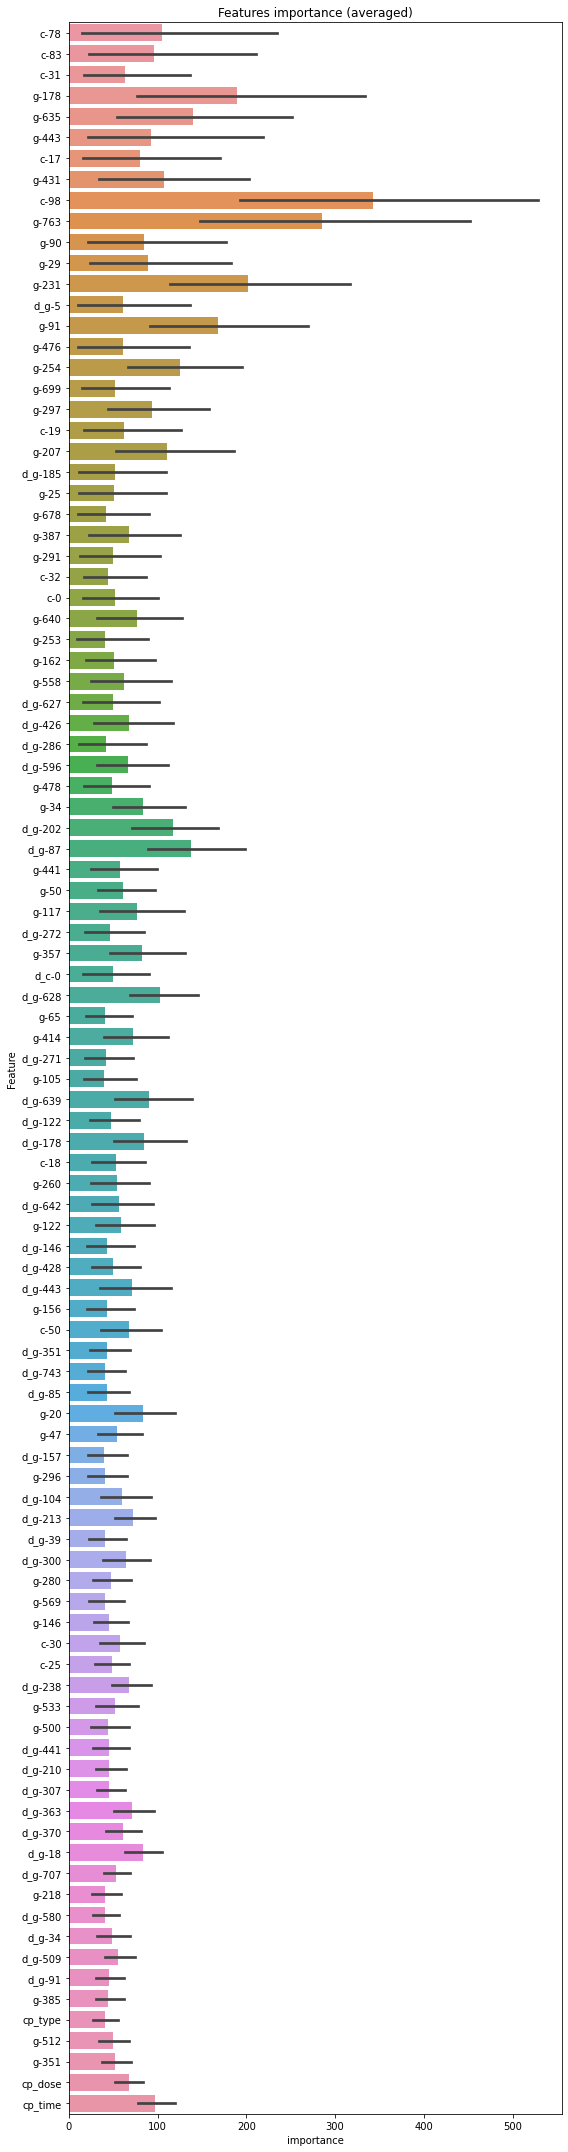

In [38]:
show_feature_importance(feature_importance_df)

In [39]:
feature_importance_df.to_csv(output_dir + f'feature_importance_df.{Version}.csv', index=False)